# Prédiction des arrivées aux urgences

## Initialisation

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import statistics
import xgboost as xgb

from IPython.display import display
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

In [28]:
type_target = 'hospitalisations'
assert type_target in ['hospitalisations', 'arrivees_urgences']
horizon = 15
NUM_FEATS = 50
DEPARTEMENT = 'Dijon'

In [29]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18,8)

def teste(df, params, score=100000, ma=7, verbose=False):
    MAEs, MSEs = [], []
    new_score = 100000
    reg_best = None
    final = df.loc[df.index.year==2023]
    X_final = final.drop('target', axis=1)
    y_final = final['target']

    for max_depth in [3, 4, 5, 6, 7, 8, 9]:
        params['max_depth'] = max_depth
        train_val_test = df.copy()
        for annee in range(2019, 2024):
            train_val = train_val_test.loc[train_val_test.index.year != annee]
            test = train_val_test.loc[train_val_test.index.year == annee]
            X_test = test.drop('target', axis=1)
            y_test = test['target']
            X_train, X_valid, y_train, y_valid = train_test_split(train_val.drop('target', axis=1), train_val['target'], 
                                                                  test_size=0.2, shuffle=False)
                    
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dvalid = xgb.DMatrix(X_valid, label=y_valid)
            dtest = xgb.DMatrix(X_test, label=y_test)
            evals = [(dtrain, 'train'), (dvalid, 'eval')]
            bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                            early_stopping_rounds=15, verbose_eval=verbose)
        
            y_pred = bst.predict(dtest)
            MAEs.append(mean_absolute_error(y_test, y_pred))
            MSEs.append(mean_squared_error(y_test, y_pred))

        current_score = statistics.mean(MSEs)
        if current_score < new_score:
            train_val_test = df.loc[df.index.year<2023]
            previous_score = new_score
            new_score = current_score
            if new_score < score:
                print(f"Amélioration avec {max_depth=}: {min(previous_score, score):.4f} -> {new_score:.4f}")
                new_score = statistics.mean(MSEs)
                X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                                    train_val_test['target'], 
                                                                    test_size=0.2, shuffle=False)

                dtrain = xgb.DMatrix(X_train, label=y_train)
                dvalid = xgb.DMatrix(X_valid, label=y_valid)
                dtest = xgb.DMatrix(X_final, label=y_final)
                evals = [(dtrain, 'train'), (dvalid, 'eval')]
                bst = xgb.train(params, dtrain, num_boost_round=100000, evals=evals,
                                early_stopping_rounds=15, verbose_eval=verbose)
                reg_best = bst
                y_pred = bst.predict(dtest)
                #y_pred_ma = pd.Series(y_pred).rolling(window=ma, center=True).mean()
                N = 365
                plt.figure()
                plt.plot(range(len(y_final))[-N:], y_final[-N:], label='actual', color='blue')
                plt.plot(range(len(y_pred))[-N:], y_pred[-N:], label='predict', color='orange')
                #plt.plot(range(len(y_pred))[-N:], y_pred_ma[-N:], label='trend', color='red')
                plt.legend()
                '''y_test_ma = y_final.rolling(window=ma, center=True).mean()
                
                plt.figure()
                plt.plot(range(len(y_final)), y_test_ma, label='actual')
                plt.plot(range(len(y_pred)), y_pred_ma, label='predict')
                plt.legend()
                '''
                display(plt.gcf())

                mean_y_test = np.mean(y_final)
                error_percentage = np.abs((y_pred - y_final) / mean_y_test) * 100
                percent_below_thresholds = {}
                for threshold in range(1, 12):  # de 1% à 30%
                    percent_below = np.mean(error_percentage < threshold) * 100
                    percent_below_thresholds[threshold] = percent_below
                for threshold, percent_below in percent_below_thresholds.items():
                    print(f"{percent_below:.2f}%,{threshold}%")

                print(f"   - MAE : {statistics.mean(MAEs):.2f} ({mean_absolute_error(y_pred, y_final):.2f} sur 2023)")
                print(f"   - MSE : {statistics.mean(MSEs):.2f} ({mean_squared_error(y_pred, y_final):.2f} sur 2023)")
    return new_score, reg_best

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/julienaudoux/Desktop/WORK(lab)/forecasting_models/.venv/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [30]:
assert type_target in ['hospitalisations', 'arrivees_urgences']
if type_target == 'hospitalisations':
    df = pd.read_excel('RPU_vers_hospit_adultes.xlsx', )
    df['date_entree'] = pd.to_datetime(df['date_entree'], unit='D', origin='1899-12-30')
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()
    # on ajoute les arrivées aux urgences, que l'on suppose connues pour le jour J
    dff = pd.read_feather('CHU Dijon_volumes.feather')
    dff.rename({'Total': 'arrivees_urgences'}, axis=1, inplace=True)
    dff.reset_index(inplace=True)
    df = pd.merge(df, dff, on='date_entree')
else:
    df = pd.read_feather('CHU Dijon_volumes.feather')
    df.rename({'Total': type_target}, axis=1, inplace=True)
    df['target'] = df[type_target].copy()

In [31]:
# On ajoute la target
if type_target == 'hospitalisations':
    horizon = 7
else:
    horizon = 3
df['mean'] = df[type_target].rolling(window=horizon, min_periods=1).mean()
df['target'] = df['mean'].shift(-2*horizon+1)
df.drop('mean', axis=1, inplace=True)

df.dropna(inplace=True)
df.shape

(1813, 6)

In [32]:
df

date_entree  hospitalisations     target  arrivees_urgences  \
0     2019-01-01                46  48.000000                202   
1     2019-01-02                50  44.714286                198   
2     2019-01-03                44  46.714286                186   
3     2019-01-04                49  47.142857                186   
4     2019-01-05                41  45.428571                204   
...          ...               ...        ...                ...   
1808  2023-12-14                37  40.714286                191   
1809  2023-12-15                37  40.000000                164   
1810  2023-12-16                40  40.285714                193   
1811  2023-12-17                32  39.571429                148   
1812  2023-12-18                39  39.142857                165   

     nom_etablissement  total_CHU Dijon  
0            CHU Dijon              202  
1            CHU Dijon              198  
2            CHU Dijon              186  
3            CHU Dijon              186  
4            CHU Dijon              204  
...                ...              ...  
1808         CHU Dijon              191  
1809         CHU Dijon              164  
1810         CHU Dijon              193  
1811         CHU Dijon              148  
1812         CHU Dijon              165  

[1813 rows x 6 columns]

In [33]:
for k in range(2*horizon-1, 15):
    df[f'target_history-{k}'] = df['target'].shift(k)

In [34]:
for k in range(1, 15):
    df[f'{type_target}_history-{k}'] = df[type_target].shift(k)

In [35]:
dg = pd.read_csv('features_all_origin.csv', sep=',')
dg.drop('Total', axis=1, inplace=True)
dg['date_entree'] = pd.to_datetime(dg['date_entree'], format="%Y-%m-%d")
df = pd.merge(df, dg, on='date_entree', how='left')
df.set_index('date_entree', inplace=True)
df.dropna(inplace=True)

In [36]:
print(f"Moyenne : {df['target'].mean():.2f}, Ecart-type : {df['target'].std():.2f}")
print(f"Baseline : {mean_absolute_error(df['target'], [df['target'].mean()]*len(df)):.2f}")

Moyenne : 40.12, Ecart-type : 5.13
Baseline : 3.21


In [37]:
df['HNFC_moving'] = df['HNFC_moving']=='Après'
df.drop(['nom_etablissement_x', 'nom_etablissement_y'], axis=1, inplace=True)
df = df.drop(df.loc['2020-03':'2020-05'].index)

In [38]:
shifted = df["target"].shift(2*horizon-1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'target_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)

shifted = df[type_target].shift(1)
for ma in [2, 3, 7, 15, 30]:    
    window = shifted.rolling(window=ma)
    df[f'{type_target}_ma_{ma}'] = window.mean()
    df.bfill(inplace=True)


In [39]:
# On sauvegarde notre dataframe
df0 = df.copy()

## On va commencer par prédire la tendance

### Calendaire

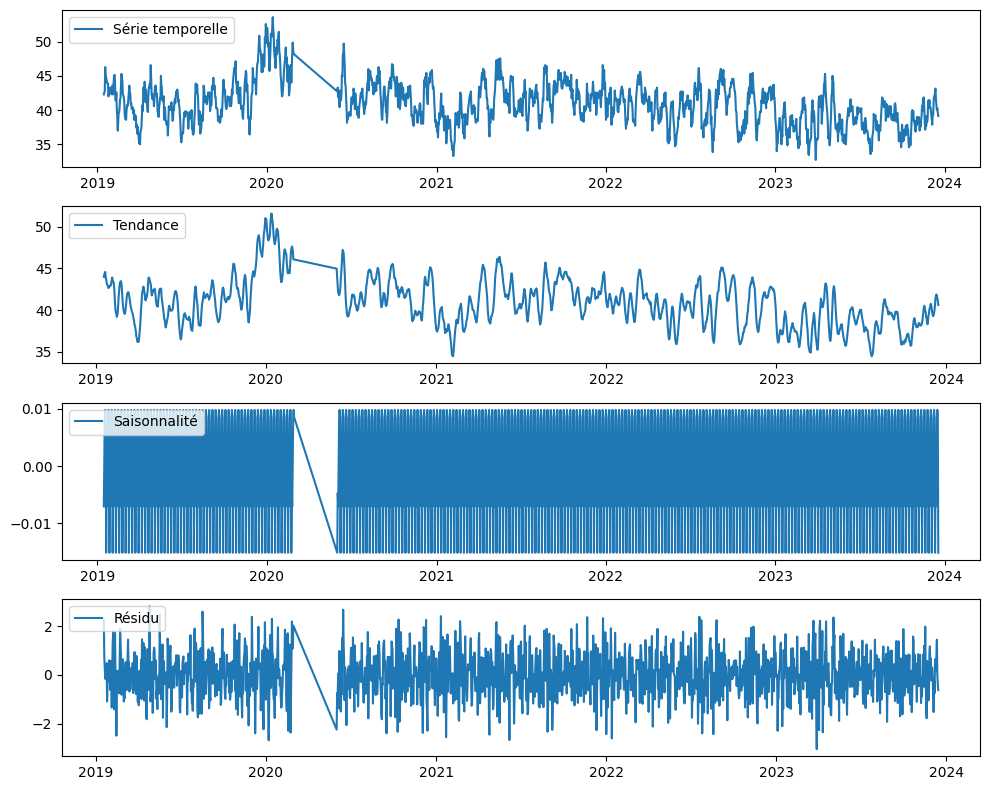

In [40]:
y = df['target']
result = seasonal_decompose(y, model='additive', period=7)

# Affichage des composantes
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(y, label='Série temporelle')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Tendance')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Saisonnalité')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Résidu')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [41]:
df = df0.copy()
df['target'] = result.trend.copy()
df.dropna(inplace=True)

In [42]:
df

hospitalisations     target  arrivees_urgences  total_CHU Dijon  \
date_entree                                                                    
2019-01-18                 48  44.000000                221              221   
2019-01-19                 38  44.244898                230              230   
2019-01-20                 37  44.428571                211              211   
2019-01-21                 43  44.591837                217              217   
2019-01-22                 42  43.979592                196              196   
...                       ...        ...                ...              ...   
2023-12-11                 44  41.877551                194              194   
2023-12-12                 38  41.693878                199              199   
2023-12-13                 42  41.448980                171              171   
2023-12-14                 37  41.122449                191              191   
2023-12-15                 37  40.612245                164              164   

             target_history-13  target_history-14  hospitalisations_history-1  \
date_entree                                                                     
2019-01-18           45.428571          47.142857                        51.0   
2019-01-19           44.714286          45.428571                        48.0   
2019-01-20           44.428571          44.714286                        38.0   
2019-01-21           43.571429          44.428571                        37.0   
2019-01-22           44.714286          43.571429                        43.0   
...                        ...                ...                         ...   
2023-12-11           40.714286          41.428571                        37.0   
2023-12-12           41.428571          40.714286                        44.0   
2023-12-13           40.285714          41.428571                        38.0   
2023-12-14           40.428571          40.285714                        42.0   
2023-12-15           40.000000          40.428571                        37.0   

             hospitalisations_history-2  hospitalisations_history-3  \
date_entree                                                           
2019-01-18                         54.0                        34.0   
2019-01-19                         51.0                        54.0   
2019-01-20                         48.0                        51.0   
2019-01-21                         38.0                        48.0   
2019-01-22                         37.0                        38.0   
...                                 ...                         ...   
2023-12-11                         45.0                        40.0   
2023-12-12                         37.0                        45.0   
2023-12-13                         44.0                        37.0   
2023-12-14                         38.0                        44.0   
2023-12-15                         42.0                        38.0   

             hospitalisations_history-4  ...  target_ma_2  target_ma_3  \
date_entree                              ...                             
2019-01-18                         49.0  ...    42.428571    42.523810   
2019-01-19                         34.0  ...    42.428571    42.523810   
2019-01-20                         54.0  ...    42.428571    42.523810   
2019-01-21                         51.0  ...    42.428571    42.523810   
2019-01-22                         48.0  ...    42.428571    42.523810   
...                                 ...  ...          ...          ...   
2023-12-11                         36.0  ...    41.071429    41.047619   
2023-12-12                         40.0  ...    41.071429    41.190476   
2023-12-13                         45.0  ...    40.857143    40.809524   
2023-12-14                         37.0  ...    40.357143    40.714286   
2023-12-15                         44.0  ...    40.214286    40.238095   

             target_ma_7  targe

Amélioration avec max_depth=3: 100000.0000 -> 7.9722


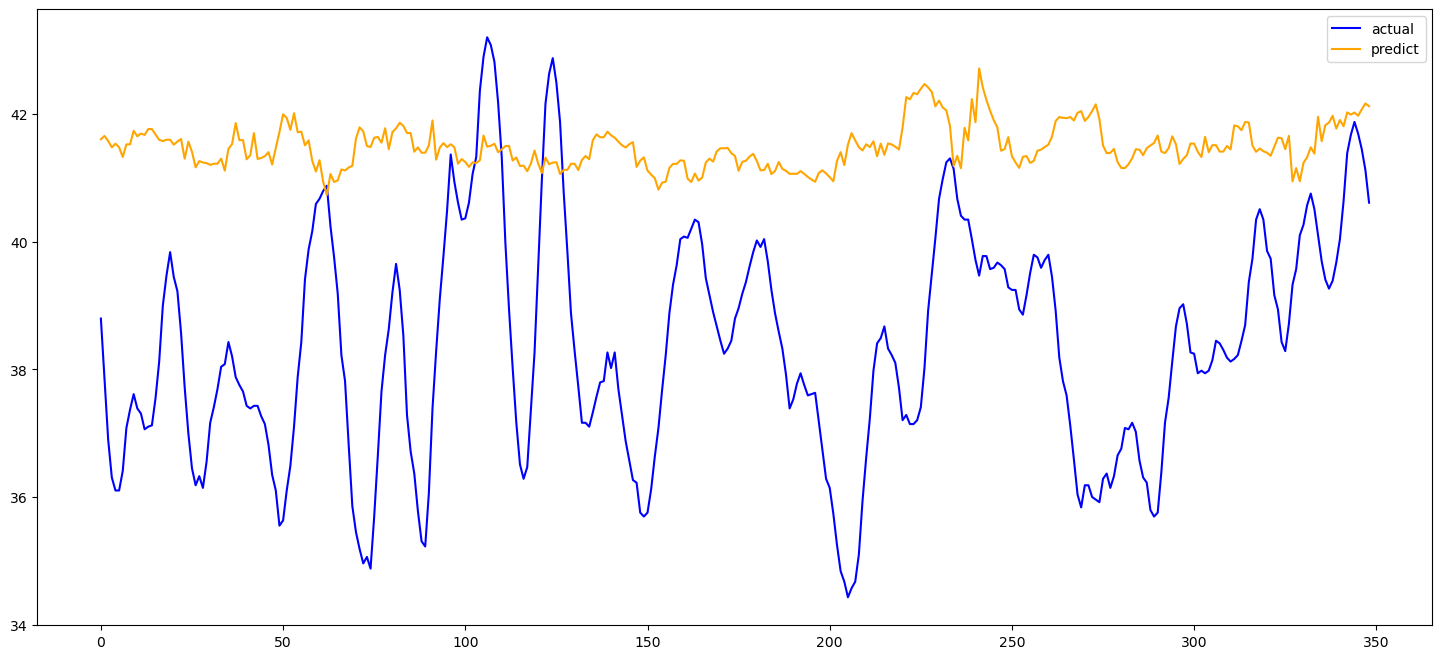

3.44%,1%
7.74%,2%
13.75%,3%
18.62%,4%
27.51%,5%
33.52%,6%
39.83%,7%
46.42%,8%
56.45%,9%
62.46%,10%
70.49%,11%
   - MAE : 2.28 (3.20 sur 2023)
   - MSE : 7.97 (13.11 sur 2023)
Amélioration avec max_depth=4: 7.9722 -> 7.9666


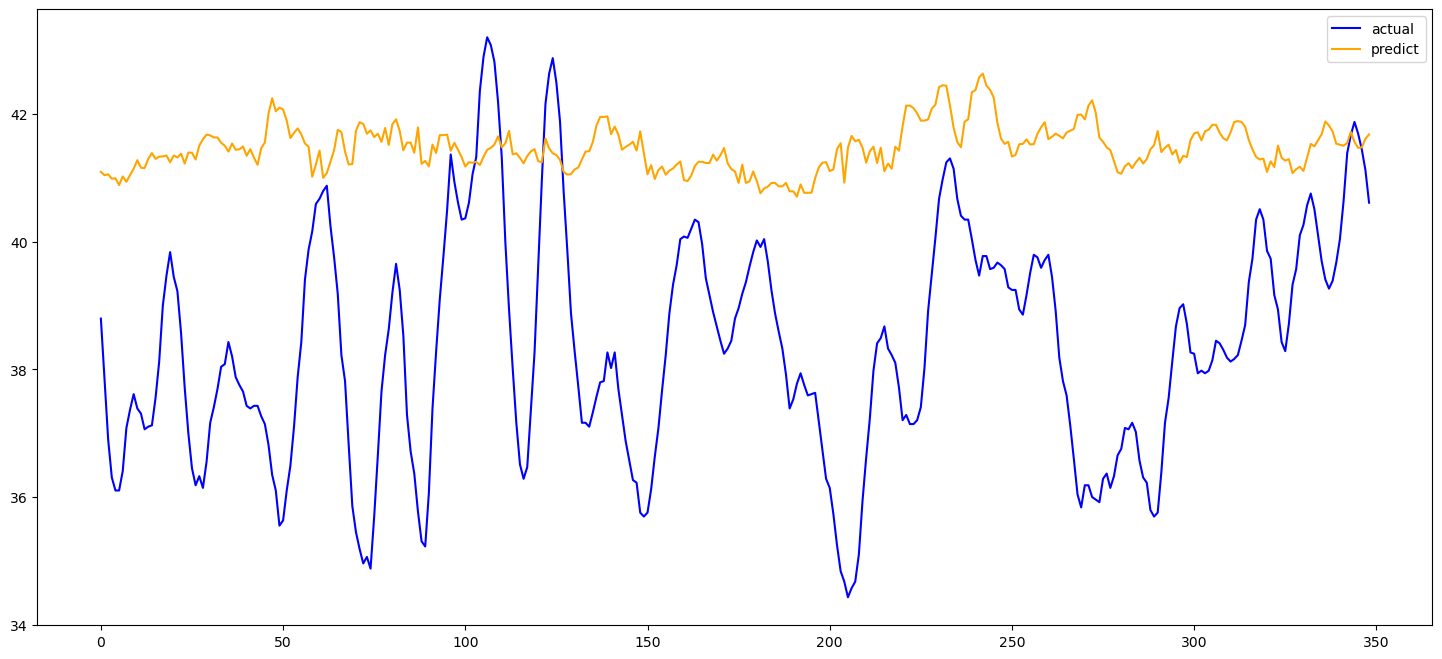

3.72%,1%
6.59%,2%
14.04%,3%
19.48%,4%
26.07%,5%
33.81%,6%
40.97%,7%
48.14%,8%
55.59%,9%
63.32%,10%
71.92%,11%
   - MAE : 2.28 (3.19 sur 2023)
   - MSE : 7.97 (13.01 sur 2023)
                 feature       gain       cover  weight  importance  rank
0       inc_diarrhee_std  51.191029  652.733337    15.0    0.023660   1.0
1           target_ma_15  53.993820  727.666687     3.0    0.018044   2.0
2      trend_vaccin_mean  42.601589  698.166687     6.0    0.017552   3.0
3              dayofYear  40.269028  598.000000     8.0    0.017296   4.0
4           trend_vaccin  53.514618  678.000000     1.0    0.016325   5.0
5           inc_ira_J-18  36.723732  760.500000     2.0    0.014916   6.0
6      inc_diarrhee_J-16  37.938019  704.000000     2.0    0.014551   7.0
7           inc_ira_J-17  34.344856  779.000000     1.0    0.014134   8.0
8           inc_ira_mean  27.761242  307.818176    11.0    0.014001   9.0
9       inc_diarrhee_J-1  34.633266  643.333313     3.0    0.013959  10.0
10  air_PM1

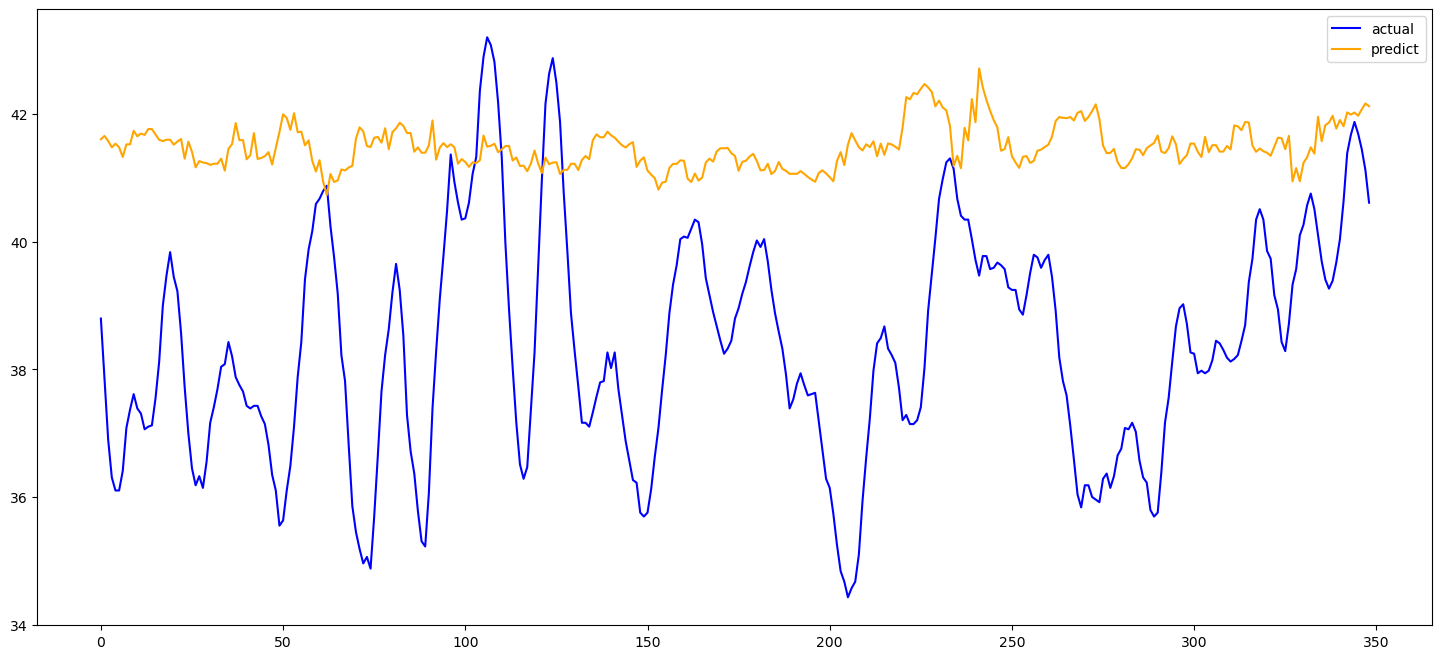

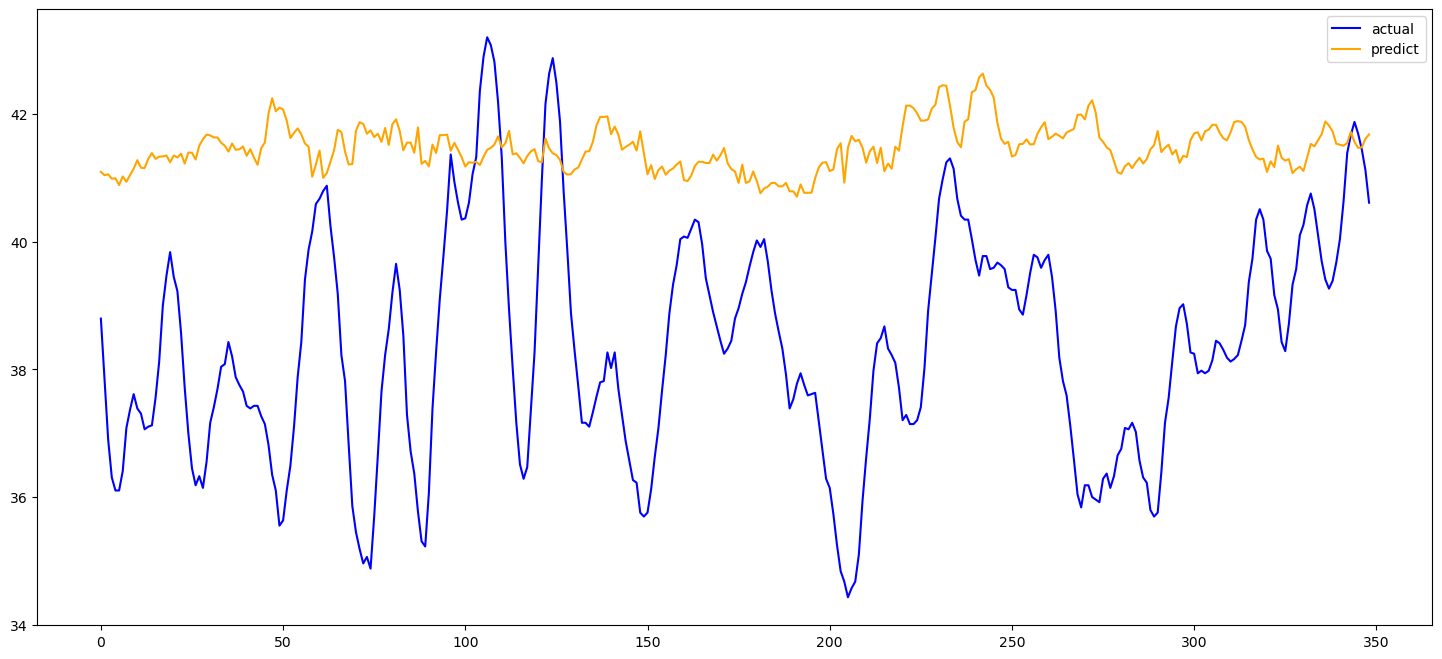

In [23]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

new_score, bst = teste(df, params)

# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')
importance_weight = bst.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']].head(20))


In [34]:
for col in sorted(df.columns):
    print(col)

HNFC_moving
air_NO2_FR26005
air_NO2_FR26005_J-1
air_NO2_FR26005_J-2
air_NO2_FR26005_J-3
air_NO2_FR26005_J-4
air_NO2_FR26005_J-5
air_NO2_FR26005_J-6
air_NO2_FR26005_J-7
air_NO2_FR26005_derivative
air_NO2_FR26005_mean
air_NO2_FR26005_std
air_NO2_FR26010
air_NO2_FR26010_J-1
air_NO2_FR26010_J-2
air_NO2_FR26010_J-3
air_NO2_FR26010_J-4
air_NO2_FR26010_J-5
air_NO2_FR26010_J-6
air_NO2_FR26010_J-7
air_NO2_FR26010_derivative
air_NO2_FR26010_mean
air_NO2_FR26010_std
air_NO2_FR26014
air_NO2_FR26014_J-1
air_NO2_FR26014_J-2
air_NO2_FR26014_J-3
air_NO2_FR26014_J-4
air_NO2_FR26014_J-5
air_NO2_FR26014_J-6
air_NO2_FR26014_J-7
air_NO2_FR26014_derivative
air_NO2_FR26014_mean
air_NO2_FR26014_std
air_NO2_FR26094
air_NO2_FR26094_J-1
air_NO2_FR26094_J-2
air_NO2_FR26094_J-3
air_NO2_FR26094_J-4
air_NO2_FR26094_J-5
air_NO2_FR26094_J-6
air_NO2_FR26094_J-7
air_NO2_FR26094_derivative
air_NO2_FR26094_mean
air_NO2_FR26094_std
air_O3_FR26005
air_O3_FR26005_J-1
air_O3_FR26005_J-2
air_O3_FR26005_J-3
air_O3_FR26005_J-4
a

<Axes: xlabel='date_entree'>

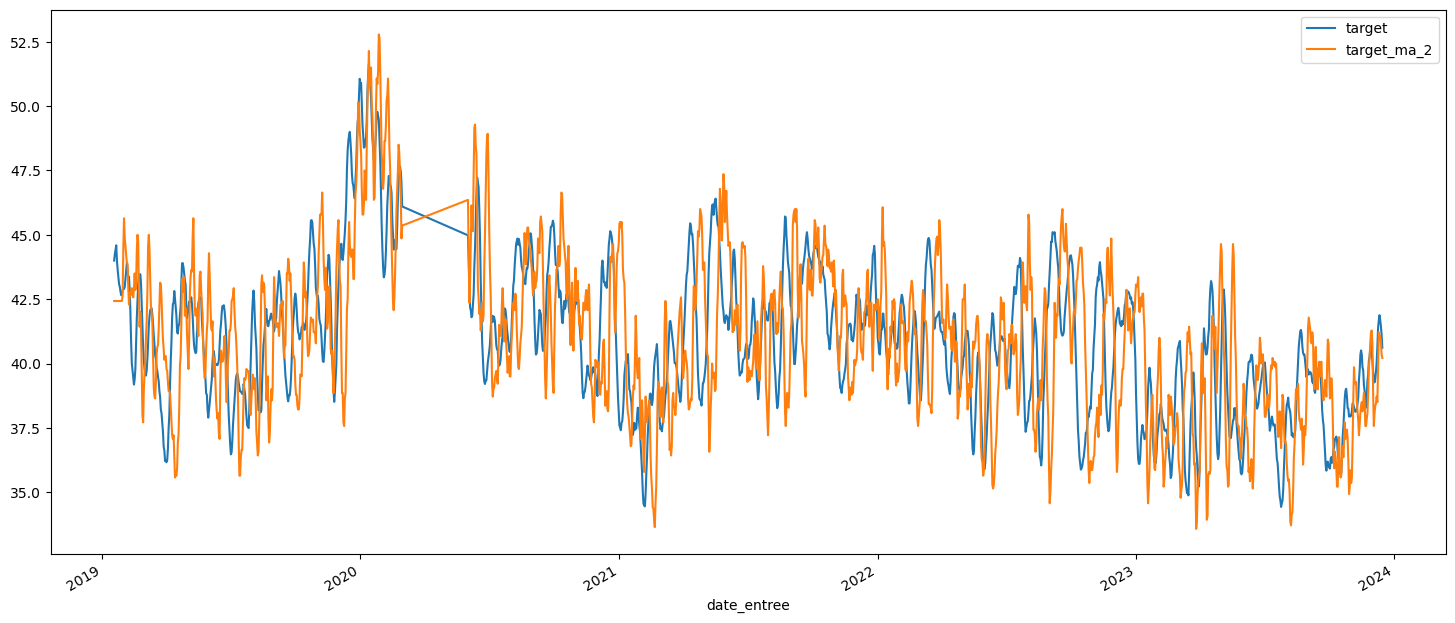

In [38]:
#df.plot(y=['target', 'target_history-14'])
df.plot(y=['target', 'target_ma_2'])


In [77]:
prevision.iloc

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [17]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

# Exemple de série temporelle synthétique (à remplacer par vos données)
#date_rng = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
#data = np.sin(2 * np.pi * date_rng.dayofyear / 365) + np.random.normal(0, 0.1, len(date_rng))

cible = []

N = 365
p, d, q = 4,1,3
for l in range(N):
    liste = list(df['target'][:(-(N+15)+l)].values)
    for k in range(14):
        # Définir le modèle ARMA (p, q à ajuster selon votre série temporelle)
        #modele = ARIMA(liste, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
        modele = SARIMAX(liste, order=(4, 1, 3), seasonal_order=(1, 1, 0, 7))
        # Ajuster le modèle
        modele_fit = modele.fit(method_kwargs={"disp": 0})
        prevision = modele_fit.forecast(steps=1)
        liste.append(prevision[0])
        # Affichage des résultats
        if k == 13:
            print(l, prevision[0])
            cible.append(prevision[0])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90899D+00    |proj g|=  4.21881D-02

At iterate    5    f=  1.90568D+00    |proj g|=  9.82473D-03

At iterate   10    f=  1.88433D+00    |proj g|=  3.71936D-02

At iterate   15    f=  1.86706D+00    |proj g|=  8.04976D-02

At iterate   20    f=  1.83486D+00    |proj g|=  4.37080D-02

At iterate   25    f=  1.80818D+00    |proj g|=  1.88829D-02

At iterate   30    f=  1.80071D+00    |proj g|=  1.57406D-02

At iterate   35    f=  1.79387D+00    |proj g|=  1.91594D-02

At iterate   40    f=  1.79272D+00    |proj g|=  8.35068D-03

At iterate   45    f=  1.79249D+00    |proj g|=  3.40078D-03

At iterate   50    f=  1.79245D+00    |proj g|=  1.89190D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90861D+00    |proj g|=  4.22301D-02

At iterate    5    f=  1.90533D+00    |proj g|=  9.77588D-03

At iterate   10    f=  1.88435D+00    |proj g|=  3.70437D-02

At iterate   15    f=  1.86395D+00    |proj g|=  6.92698D-02

At iterate   20    f=  1.83304D+00    |proj g|=  3.35054D-02

At iterate   25    f=  1.80645D+00    |proj g|=  1.95992D-02

At iterate   30    f=  1.80080D+00    |proj g|=  3.27084D-02

At iterate   35    f=  1.79400D+00    |proj g|=  3.64850D-02

At iterate   40    f=  1.79238D+00    |proj g|=  1.74032D-02

At iterate   45    f=  1.79213D+00    |proj g|=  3.56254D-03

At iterate   50    f=  1.79208D+00    |proj g|=  1.35762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90816D+00    |proj g|=  4.20620D-02

At iterate    5    f=  1.90506D+00    |proj g|=  8.60065D-03

At iterate   10    f=  1.88211D+00    |proj g|=  1.67505D-01

At iterate   15    f=  1.86588D+00    |proj g|=  1.19576D-01

At iterate   20    f=  1.84060D+00    |proj g|=  7.75756D-02

At iterate   25    f=  1.81154D+00    |proj g|=  2.76459D-02

At iterate   30    f=  1.79931D+00    |proj g|=  1.86147D-02

At iterate   35    f=  1.79324D+00    |proj g|=  1.62326D-02

At iterate   40    f=  1.79189D+00    |proj g|=  7.72163D-03

At iterate   45    f=  1.79173D+00    |proj g|=  2.13644D-03

At iterate   50    f=  1.79170D+00    |proj g|=  1.58871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90782D+00    |proj g|=  4.20553D-02

At iterate    5    f=  1.90473D+00    |proj g|=  8.35940D-03

At iterate   10    f=  1.88171D+00    |proj g|=  1.53714D-01

At iterate   15    f=  1.86256D+00    |proj g|=  5.88937D-02

At iterate   20    f=  1.83723D+00    |proj g|=  5.71331D-02

At iterate   25    f=  1.80754D+00    |proj g|=  1.55079D-02

At iterate   30    f=  1.79506D+00    |proj g|=  1.95733D-02

At iterate   35    f=  1.79185D+00    |proj g|=  1.03924D-02

At iterate   40    f=  1.79139D+00    |proj g|=  3.16690D-03

At iterate   45    f=  1.79133D+00    |proj g|=  2.03997D-03

At iterate   50    f=  1.79132D+00    |proj g|=  3.69665D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90442D+00    |proj g|=  8.26379D-03

At iterate   10    f=  1.87960D+00    |proj g|=  6.19951D-02

At iterate   15    f=  1.86032D+00    |proj g|=  4.19872D-02

At iterate   20    f=  1.82649D+00    |proj g|=  7.22147D-02

At iterate   25    f=  1.80642D+00    |proj g|=  2.45337D-02

At iterate   30    f=  1.79499D+00    |proj g|=  1.59009D-02

At iterate   35    f=  1.79177D+00    |proj g|=  1.63191D-02

At iterate   40    f=  1.79114D+00    |proj g|=  4.18621D-03

At iterate   45    f=  1.79098D+00    |proj g|=  6.53555D-03

At iterate   50    f=  1.79095D+00    |proj g|=  1.41382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90403D+00    |proj g|=  9.23657D-03

At iterate   10    f=  1.88176D+00    |proj g|=  1.48876D-01

At iterate   15    f=  1.86397D+00    |proj g|=  8.47046D-02

At iterate   20    f=  1.84559D+00    |proj g|=  3.03940D-02

At iterate   25    f=  1.81406D+00    |proj g|=  1.54177D-01

At iterate   30    f=  1.79645D+00    |proj g|=  9.98436D-03

At iterate   35    f=  1.79244D+00    |proj g|=  9.88477D-03

At iterate   40    f=  1.79093D+00    |proj g|=  6.81200D-03

At iterate   45    f=  1.79064D+00    |proj g|=  7.39164D-03

At iterate   50    f=  1.79059D+00    |proj g|=  2.26712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90673D+00    |proj g|=  4.20438D-02

At iterate    5    f=  1.90370D+00    |proj g|=  7.77221D-03

At iterate   10    f=  1.88432D+00    |proj g|=  1.57202D-01

At iterate   15    f=  1.86270D+00    |proj g|=  6.71492D-02

At iterate   20    f=  1.82984D+00    |proj g|=  9.37073D-02

At iterate   25    f=  1.80479D+00    |proj g|=  1.63276D-02

At iterate   30    f=  1.79442D+00    |proj g|=  2.64381D-02

At iterate   35    f=  1.79079D+00    |proj g|=  9.36738D-03

At iterate   40    f=  1.79029D+00    |proj g|=  3.47529D-03

At iterate   45    f=  1.79022D+00    |proj g|=  1.98578D-03

At iterate   50    f=  1.79020D+00    |proj g|=  2.69342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90333D+00    |proj g|=  8.16440D-03

At iterate   10    f=  1.88262D+00    |proj g|=  1.49571D-01

At iterate   15    f=  1.86270D+00    |proj g|=  6.37076D-02

At iterate   20    f=  1.82760D+00    |proj g|=  7.67386D-02

At iterate   25    f=  1.80610D+00    |proj g|=  2.13115D-02

At iterate   30    f=  1.79460D+00    |proj g|=  4.21606D-02

At iterate   35    f=  1.79082D+00    |proj g|=  6.50316D-03

At iterate   40    f=  1.78999D+00    |proj g|=  5.94202D-03

At iterate   45    f=  1.78986D+00    |proj g|=  1.82106D-03

At iterate   50    f=  1.78984D+00    |proj g|=  3.06144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90296D+00    |proj g|=  8.11169D-03

At iterate   10    f=  1.88307D+00    |proj g|=  1.62078D-01

At iterate   15    f=  1.86176D+00    |proj g|=  5.33983D-02

At iterate   20    f=  1.83634D+00    |proj g|=  6.22997D-02

At iterate   25    f=  1.81249D+00    |proj g|=  6.77162D-02

At iterate   30    f=  1.80216D+00    |proj g|=  1.84405D-02

At iterate   35    f=  1.79401D+00    |proj g|=  3.52571D-02

At iterate   40    f=  1.79010D+00    |proj g|=  1.31153D-02

At iterate   45    f=  1.78953D+00    |proj g|=  4.56690D-03

At iterate   50    f=  1.78947D+00    |proj g|=  8.22844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90262D+00    |proj g|=  7.64791D-03

At iterate   10    f=  1.88363D+00    |proj g|=  1.51198D-01

At iterate   15    f=  1.86126D+00    |proj g|=  7.28281D-02

At iterate   20    f=  1.83422D+00    |proj g|=  5.48646D-02

At iterate   25    f=  1.80428D+00    |proj g|=  2.46679D-02

At iterate   30    f=  1.79706D+00    |proj g|=  2.13246D-02

At iterate   35    f=  1.79032D+00    |proj g|=  1.04664D-02

At iterate   40    f=  1.78928D+00    |proj g|=  1.42136D-02

At iterate   45    f=  1.78912D+00    |proj g|=  5.91669D-03

At iterate   50    f=  1.78910D+00    |proj g|=  4.39291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90225D+00    |proj g|=  7.69704D-03

At iterate   10    f=  1.88236D+00    |proj g|=  1.50069D-01

At iterate   15    f=  1.86010D+00    |proj g|=  6.46902D-02

At iterate   20    f=  1.83278D+00    |proj g|=  9.09095D-02

At iterate   25    f=  1.80403D+00    |proj g|=  1.66535D-02

At iterate   30    f=  1.79430D+00    |proj g|=  1.56386D-02

At iterate   35    f=  1.78952D+00    |proj g|=  8.62516D-03

At iterate   40    f=  1.78885D+00    |proj g|=  1.05182D-02

At iterate   45    f=  1.78874D+00    |proj g|=  1.11014D-03

At iterate   50    f=  1.78872D+00    |proj g|=  1.68479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90490D+00    |proj g|=  4.20984D-02

At iterate    5    f=  1.90189D+00    |proj g|=  7.63483D-03

At iterate   10    f=  1.88243D+00    |proj g|=  1.48028D-01

At iterate   15    f=  1.85975D+00    |proj g|=  6.88060D-02

At iterate   20    f=  1.83320D+00    |proj g|=  5.69138D-02

At iterate   25    f=  1.80331D+00    |proj g|=  1.78353D-02

At iterate   30    f=  1.79417D+00    |proj g|=  3.55828D-02

At iterate   35    f=  1.78937D+00    |proj g|=  1.18187D-02

At iterate   40    f=  1.78854D+00    |proj g|=  8.78580D-03

At iterate   45    f=  1.78838D+00    |proj g|=  2.93438D-03

At iterate   50    f=  1.78836D+00    |proj g|=  2.15130D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90151D+00    |proj g|=  8.02809D-03

At iterate   10    f=  1.88192D+00    |proj g|=  1.68657D-01

At iterate   15    f=  1.85353D+00    |proj g|=  3.63314D-02

At iterate   20    f=  1.82150D+00    |proj g|=  9.09116D-02

At iterate   25    f=  1.80355D+00    |proj g|=  1.54300D-02

At iterate   30    f=  1.79221D+00    |proj g|=  2.83106D-02

At iterate   35    f=  1.78853D+00    |proj g|=  7.22098D-03

At iterate   40    f=  1.78808D+00    |proj g|=  8.47839D-03

At iterate   45    f=  1.78800D+00    |proj g|=  4.28280D-03

At iterate   50    f=  1.78798D+00    |proj g|=  2.90197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90415D+00    |proj g|=  4.21101D-02

At iterate    5    f=  1.90116D+00    |proj g|=  7.48997D-03

At iterate   10    f=  1.89460D+00    |proj g|=  8.07570D-02

At iterate   15    f=  1.86934D+00    |proj g|=  2.69841D-02

At iterate   20    f=  1.83473D+00    |proj g|=  2.72367D-02

At iterate   25    f=  1.80553D+00    |proj g|=  6.40006D-02

At iterate   30    f=  1.79826D+00    |proj g|=  1.05561D-02

At iterate   35    f=  1.78981D+00    |proj g|=  1.15565D-02

At iterate   40    f=  1.78795D+00    |proj g|=  4.09300D-03

At iterate   45    f=  1.78765D+00    |proj g|=  2.38408D-03

At iterate   50    f=  1.78761D+00    |proj g|=  1.41939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90711D+00    |proj g|=  8.59081D-03

At iterate   10    f=  1.88597D+00    |proj g|=  5.03113D-02

At iterate   15    f=  1.85620D+00    |proj g|=  4.07191D-02

At iterate   20    f=  1.82957D+00    |proj g|=  4.77851D-02

At iterate   25    f=  1.80842D+00    |proj g|=  2.17142D-02

At iterate   30    f=  1.79847D+00    |proj g|=  9.80908D-03

At iterate   35    f=  1.79509D+00    |proj g|=  1.27429D-02

At iterate   40    f=  1.79428D+00    |proj g|=  1.20336D-02

At iterate   45    f=  1.79405D+00    |proj g|=  1.04575D-03

At iterate   50    f=  1.79401D+00    |proj g|=  8.44409D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90681D+00    |proj g|=  7.74451D-03

At iterate   10    f=  1.89841D+00    |proj g|=  7.49560D-02

At iterate   15    f=  1.86971D+00    |proj g|=  4.23488D-02

At iterate   20    f=  1.84577D+00    |proj g|=  4.89001D-02

At iterate   25    f=  1.81519D+00    |proj g|=  3.14374D-02

At iterate   30    f=  1.80429D+00    |proj g|=  1.41500D-02

At iterate   35    f=  1.79557D+00    |proj g|=  8.02550D-03

At iterate   40    f=  1.79390D+00    |proj g|=  7.25211D-03

At iterate   45    f=  1.79368D+00    |proj g|=  5.28970D-03

At iterate   50    f=  1.79364D+00    |proj g|=  3.12477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90647D+00    |proj g|=  8.45178D-03

At iterate   10    f=  1.88662D+00    |proj g|=  2.36335D-01

At iterate   15    f=  1.86318D+00    |proj g|=  5.10420D-02

At iterate   20    f=  1.83571D+00    |proj g|=  4.59306D-02

At iterate   25    f=  1.80672D+00    |proj g|=  3.20160D-02

At iterate   30    f=  1.79773D+00    |proj g|=  2.09755D-02

At iterate   35    f=  1.79415D+00    |proj g|=  1.00189D-02

At iterate   40    f=  1.79346D+00    |proj g|=  1.41802D-02

At iterate   45    f=  1.79329D+00    |proj g|=  3.95509D-03

At iterate   50    f=  1.79326D+00    |proj g|=  1.74925D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90621D+00    |proj g|=  9.02633D-03

At iterate   10    f=  1.88950D+00    |proj g|=  2.51299D-01

At iterate   15    f=  1.86507D+00    |proj g|=  7.07296D-02

At iterate   20    f=  1.83243D+00    |proj g|=  7.65171D-02

At iterate   25    f=  1.80478D+00    |proj g|=  1.66124D-02

At iterate   30    f=  1.79647D+00    |proj g|=  3.13478D-02

At iterate   35    f=  1.79343D+00    |proj g|=  3.33671D-03

At iterate   40    f=  1.79298D+00    |proj g|=  5.61231D-03

At iterate   45    f=  1.79290D+00    |proj g|=  2.32594D-03

At iterate   50    f=  1.79289D+00    |proj g|=  2.58856D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90893D+00    |proj g|=  4.14516D-02

At iterate    5    f=  1.90587D+00    |proj g|=  8.45276D-03

At iterate   10    f=  1.88196D+00    |proj g|=  1.42279D-01

At iterate   15    f=  1.86433D+00    |proj g|=  7.03313D-02

At iterate   20    f=  1.83306D+00    |proj g|=  9.28630D-02

At iterate   25    f=  1.80825D+00    |proj g|=  1.52912D-02

At iterate   30    f=  1.79817D+00    |proj g|=  2.19694D-02

At iterate   35    f=  1.79409D+00    |proj g|=  1.50409D-02

At iterate   40    f=  1.79274D+00    |proj g|=  1.15163D-02

At iterate   45    f=  1.79255D+00    |proj g|=  4.54576D-04

At iterate   50    f=  1.79252D+00    |proj g|=  3.50370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90566D+00    |proj g|=  7.79662D-03

At iterate   10    f=  1.88332D+00    |proj g|=  1.32959D-01

At iterate   15    f=  1.85853D+00    |proj g|=  3.99061D-02

At iterate   20    f=  1.82494D+00    |proj g|=  8.75278D-02

At iterate   25    f=  1.80695D+00    |proj g|=  2.33818D-02

At iterate   30    f=  1.79700D+00    |proj g|=  3.82118D-02

At iterate   35    f=  1.79274D+00    |proj g|=  8.46988D-03

At iterate   40    f=  1.79225D+00    |proj g|=  1.20615D-02

At iterate   45    f=  1.79216D+00    |proj g|=  1.09474D-03

At iterate   50    f=  1.79215D+00    |proj g|=  2.90056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90528D+00    |proj g|=  8.59637D-03

At iterate   10    f=  1.88368D+00    |proj g|=  1.95712D-01

At iterate   15    f=  1.86269D+00    |proj g|=  4.70887D-02

At iterate   20    f=  1.83510D+00    |proj g|=  6.49098D-02

At iterate   25    f=  1.80478D+00    |proj g|=  2.50318D-02

At iterate   30    f=  1.79837D+00    |proj g|=  2.78449D-02

At iterate   35    f=  1.79297D+00    |proj g|=  4.30560D-02

At iterate   40    f=  1.79193D+00    |proj g|=  6.67292D-03

At iterate   45    f=  1.79179D+00    |proj g|=  1.11063D-03

At iterate   50    f=  1.79177D+00    |proj g|=  2.30519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90801D+00    |proj g|=  4.15439D-02

At iterate    5    f=  1.90500D+00    |proj g|=  7.73044D-03

At iterate   10    f=  1.88181D+00    |proj g|=  1.17186D-01

At iterate   15    f=  1.85773D+00    |proj g|=  3.97030D-02

At iterate   20    f=  1.82453D+00    |proj g|=  8.63923D-02

At iterate   25    f=  1.80751D+00    |proj g|=  1.79307D-02

At iterate   30    f=  1.79741D+00    |proj g|=  3.43948D-02

At iterate   35    f=  1.79227D+00    |proj g|=  1.05510D-02

At iterate   40    f=  1.79158D+00    |proj g|=  7.69574D-03

At iterate   45    f=  1.79143D+00    |proj g|=  4.05181D-03

At iterate   50    f=  1.79140D+00    |proj g|=  6.22877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90463D+00    |proj g|=  7.59351D-03

At iterate   10    f=  1.88138D+00    |proj g|=  9.93675D-02

At iterate   15    f=  1.85789D+00    |proj g|=  3.89467D-02

At iterate   20    f=  1.81722D+00    |proj g|=  1.15043D-01

At iterate   25    f=  1.80466D+00    |proj g|=  1.38873D-02

At iterate   30    f=  1.79336D+00    |proj g|=  2.28785D-02

At iterate   35    f=  1.79140D+00    |proj g|=  1.74666D-02

At iterate   40    f=  1.79112D+00    |proj g|=  4.97021D-03

At iterate   45    f=  1.79104D+00    |proj g|=  3.80902D-03

At iterate   50    f=  1.79103D+00    |proj g|=  1.04628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90729D+00    |proj g|=  4.15417D-02

At iterate    5    f=  1.90429D+00    |proj g|=  7.68429D-03

At iterate   10    f=  1.88082D+00    |proj g|=  1.08425D-01

At iterate   15    f=  1.85726D+00    |proj g|=  3.95908D-02

At iterate   20    f=  1.81908D+00    |proj g|=  8.13884D-02

At iterate   25    f=  1.80538D+00    |proj g|=  9.86994D-03

At iterate   30    f=  1.79399D+00    |proj g|=  3.75112D-02

At iterate   35    f=  1.79131D+00    |proj g|=  3.30523D-02

At iterate   40    f=  1.79079D+00    |proj g|=  9.59319D-03

At iterate   45    f=  1.79067D+00    |proj g|=  1.15390D-03

At iterate   50    f=  1.79066D+00    |proj g|=  1.41574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90693D+00    |proj g|=  4.15763D-02

At iterate    5    f=  1.90393D+00    |proj g|=  7.67853D-03

At iterate   10    f=  1.88052D+00    |proj g|=  1.09822D-01

At iterate   15    f=  1.85762D+00    |proj g|=  3.96943D-02

At iterate   20    f=  1.82063D+00    |proj g|=  9.43293D-02

At iterate   25    f=  1.80410D+00    |proj g|=  1.26165D-02

At iterate   30    f=  1.79419D+00    |proj g|=  4.21780D-02

At iterate   35    f=  1.79085D+00    |proj g|=  1.34934D-02

At iterate   40    f=  1.79039D+00    |proj g|=  4.50448D-03

At iterate   45    f=  1.79030D+00    |proj g|=  1.75538D-03

At iterate   50    f=  1.79029D+00    |proj g|=  1.41006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90654D+00    |proj g|=  4.16046D-02

At iterate    5    f=  1.90357D+00    |proj g|=  7.39199D-03

At iterate   10    f=  1.89893D+00    |proj g|=  8.50096D-02

At iterate   15    f=  1.87430D+00    |proj g|=  3.08365D-02

At iterate   20    f=  1.83910D+00    |proj g|=  6.60907D-02

At iterate   25    f=  1.81618D+00    |proj g|=  8.51327D-02

At iterate   30    f=  1.80214D+00    |proj g|=  1.19879D-02

At iterate   35    f=  1.79258D+00    |proj g|=  2.77178D-02

At iterate   40    f=  1.79028D+00    |proj g|=  2.85571D-03

At iterate   45    f=  1.78995D+00    |proj g|=  1.86846D-03

At iterate   50    f=  1.78992D+00    |proj g|=  5.23957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90620D+00    |proj g|=  4.16360D-02

At iterate    5    f=  1.90322D+00    |proj g|=  7.42385D-03

At iterate   10    f=  1.88147D+00    |proj g|=  1.05150D-01

At iterate   15    f=  1.85458D+00    |proj g|=  6.00921D-02

At iterate   20    f=  1.82126D+00    |proj g|=  5.43429D-02

At iterate   25    f=  1.80386D+00    |proj g|=  2.03508D-02

At iterate   30    f=  1.79271D+00    |proj g|=  9.96837D-03

At iterate   35    f=  1.79012D+00    |proj g|=  7.66799D-03

At iterate   40    f=  1.78971D+00    |proj g|=  1.54162D-03

At iterate   45    f=  1.78958D+00    |proj g|=  1.12021D-03

At iterate   50    f=  1.78955D+00    |proj g|=  8.98737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90285D+00    |proj g|=  7.63610D-03

At iterate   10    f=  1.87915D+00    |proj g|=  1.01119D-01

At iterate   15    f=  1.86310D+00    |proj g|=  9.53236D-02

At iterate   20    f=  1.83435D+00    |proj g|=  9.02912D-02

At iterate   25    f=  1.80430D+00    |proj g|=  1.67371D-02

At iterate   30    f=  1.79538D+00    |proj g|=  1.76176D-02

At iterate   35    f=  1.79049D+00    |proj g|=  5.96740D-03

At iterate   40    f=  1.78940D+00    |proj g|=  1.59988D-02

At iterate   45    f=  1.78922D+00    |proj g|=  3.61709D-03

At iterate   50    f=  1.78918D+00    |proj g|=  1.42906D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90696D+00    |proj g|=  7.88831D-03

At iterate   10    f=  1.88789D+00    |proj g|=  6.25115D-02

At iterate   15    f=  1.86603D+00    |proj g|=  4.33100D-02

At iterate   20    f=  1.83918D+00    |proj g|=  3.97597D-02

At iterate   25    f=  1.81097D+00    |proj g|=  1.71829D-02

At iterate   30    f=  1.80077D+00    |proj g|=  2.37350D-02

At iterate   35    f=  1.79589D+00    |proj g|=  1.33029D-02

At iterate   40    f=  1.79450D+00    |proj g|=  1.16648D-02

At iterate   45    f=  1.79423D+00    |proj g|=  4.60380D-03

At iterate   50    f=  1.79418D+00    |proj g|=  2.05243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90659D+00    |proj g|=  9.23413D-03

At iterate   10    f=  1.88792D+00    |proj g|=  4.23053D-02

At iterate   15    f=  1.86130D+00    |proj g|=  4.96039D-02

At iterate   20    f=  1.82712D+00    |proj g|=  4.37799D-02

At iterate   25    f=  1.80784D+00    |proj g|=  1.80606D-02

At iterate   30    f=  1.79782D+00    |proj g|=  1.75365D-02

At iterate   35    f=  1.79454D+00    |proj g|=  1.83592D-02

At iterate   40    f=  1.79397D+00    |proj g|=  5.46759D-03

At iterate   45    f=  1.79386D+00    |proj g|=  3.26668D-03

At iterate   50    f=  1.79381D+00    |proj g|=  2.72644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90982D+00    |proj g|=  4.16664D-02

At iterate    5    f=  1.90651D+00    |proj g|=  9.77225D-03

At iterate   10    f=  1.88440D+00    |proj g|=  1.43498D-01

At iterate   15    f=  1.87243D+00    |proj g|=  4.29354D-02

At iterate   20    f=  1.81156D+00    |proj g|=  5.89188D-02

At iterate   25    f=  1.79981D+00    |proj g|=  8.86387D-03

At iterate   30    f=  1.79504D+00    |proj g|=  6.74327D-03

At iterate   35    f=  1.79391D+00    |proj g|=  6.16192D-03

At iterate   40    f=  1.79362D+00    |proj g|=  4.03525D-03

At iterate   45    f=  1.79349D+00    |proj g|=  7.20856D-03

At iterate   50    f=  1.79345D+00    |proj g|=  3.23172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90615D+00    |proj g|=  9.33103D-03

At iterate   10    f=  1.88801D+00    |proj g|=  4.91459D-02

At iterate   15    f=  1.86229D+00    |proj g|=  5.64493D-02

At iterate   20    f=  1.82652D+00    |proj g|=  1.10136D-01

At iterate   25    f=  1.80562D+00    |proj g|=  1.73528D-02

At iterate   30    f=  1.79809D+00    |proj g|=  5.23962D-03

At iterate   35    f=  1.79441D+00    |proj g|=  3.89996D-03

At iterate   40    f=  1.79331D+00    |proj g|=  3.94858D-03

At iterate   45    f=  1.79309D+00    |proj g|=  3.53790D-03

At iterate   50    f=  1.79306D+00    |proj g|=  9.58419D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90588D+00    |proj g|=  1.01639D-02

At iterate   10    f=  1.88216D+00    |proj g|=  4.01104D-02

At iterate   15    f=  1.85738D+00    |proj g|=  6.34771D-02

At iterate   20    f=  1.81398D+00    |proj g|=  7.83113D-02

At iterate   25    f=  1.80342D+00    |proj g|=  1.88607D-02

At iterate   30    f=  1.79676D+00    |proj g|=  3.31387D-02

At iterate   35    f=  1.79393D+00    |proj g|=  1.09319D-02

At iterate   40    f=  1.79307D+00    |proj g|=  5.12591D-03

At iterate   45    f=  1.79281D+00    |proj g|=  5.54487D-03

At iterate   50    f=  1.79271D+00    |proj g|=  4.04395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90887D+00    |proj g|=  4.18370D-02

At iterate    5    f=  1.90552D+00    |proj g|=  1.03478D-02

At iterate   10    f=  1.88254D+00    |proj g|=  6.88425D-02

At iterate   15    f=  1.86250D+00    |proj g|=  4.51157D-02

At iterate   20    f=  1.81983D+00    |proj g|=  8.97811D-02

At iterate   25    f=  1.80723D+00    |proj g|=  2.01906D-02

At iterate   30    f=  1.79587D+00    |proj g|=  5.88332D-02

At iterate   35    f=  1.79310D+00    |proj g|=  1.62294D-02

At iterate   40    f=  1.79246D+00    |proj g|=  9.51391D-03

At iterate   45    f=  1.79235D+00    |proj g|=  2.30726D-03

At iterate   50    f=  1.79231D+00    |proj g|=  1.80419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90521D+00    |proj g|=  9.41694D-03

At iterate   10    f=  1.88793D+00    |proj g|=  4.38749D-02

At iterate   15    f=  1.86580D+00    |proj g|=  8.78300D-02

At iterate   20    f=  1.83230D+00    |proj g|=  6.39518D-02

At iterate   25    f=  1.80718D+00    |proj g|=  1.95992D-02

At iterate   30    f=  1.79592D+00    |proj g|=  7.55232D-03

At iterate   35    f=  1.79294D+00    |proj g|=  1.62594D-02

At iterate   40    f=  1.79217D+00    |proj g|=  1.14016D-02

At iterate   45    f=  1.79203D+00    |proj g|=  3.79200D-03

At iterate   50    f=  1.79196D+00    |proj g|=  2.11382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90486D+00    |proj g|=  9.24256D-03

At iterate   10    f=  1.88754D+00    |proj g|=  4.30578D-02

At iterate   15    f=  1.86622D+00    |proj g|=  8.97191D-02

At iterate   20    f=  1.83589D+00    |proj g|=  5.61643D-02

At iterate   25    f=  1.80957D+00    |proj g|=  3.99753D-02

At iterate   30    f=  1.79916D+00    |proj g|=  3.40394D-02

At iterate   35    f=  1.79327D+00    |proj g|=  1.92478D-02

At iterate   40    f=  1.79195D+00    |proj g|=  8.96824D-03

At iterate   45    f=  1.79168D+00    |proj g|=  3.82890D-03

At iterate   50    f=  1.79159D+00    |proj g|=  3.23391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90450D+00    |proj g|=  9.11799D-03

At iterate   10    f=  1.88685D+00    |proj g|=  4.84029D-02

At iterate   15    f=  1.86620D+00    |proj g|=  8.61149D-02

At iterate   20    f=  1.83426D+00    |proj g|=  7.01166D-02

At iterate   25    f=  1.80923D+00    |proj g|=  1.40271D-02

At iterate   30    f=  1.79651D+00    |proj g|=  2.64709D-02

At iterate   35    f=  1.79275D+00    |proj g|=  3.74719D-02

At iterate   40    f=  1.79155D+00    |proj g|=  3.02337D-03

At iterate   45    f=  1.79126D+00    |proj g|=  5.35163D-03

At iterate   50    f=  1.79121D+00    |proj g|=  2.59998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90416D+00    |proj g|=  8.94853D-03

At iterate   10    f=  1.88613D+00    |proj g|=  4.99537D-02

At iterate   15    f=  1.86362D+00    |proj g|=  5.94307D-02

At iterate   20    f=  1.83137D+00    |proj g|=  7.42309D-02

At iterate   25    f=  1.80773D+00    |proj g|=  1.45196D-02

At iterate   30    f=  1.79571D+00    |proj g|=  2.31252D-02

At iterate   35    f=  1.79193D+00    |proj g|=  2.72500D-02

At iterate   40    f=  1.79104D+00    |proj g|=  1.71964D-02

At iterate   45    f=  1.79087D+00    |proj g|=  2.13937D-03

At iterate   50    f=  1.79083D+00    |proj g|=  8.32529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90703D+00    |proj g|=  4.20820D-02

At iterate    5    f=  1.90380D+00    |proj g|=  9.11840D-03

At iterate   10    f=  1.88645D+00    |proj g|=  4.03356D-02

At iterate   15    f=  1.86732D+00    |proj g|=  1.07674D-01

At iterate   20    f=  1.83690D+00    |proj g|=  5.61596D-02

At iterate   25    f=  1.81062D+00    |proj g|=  2.34745D-02

At iterate   30    f=  1.79663D+00    |proj g|=  2.89849D-02

At iterate   35    f=  1.79210D+00    |proj g|=  3.18437D-02

At iterate   40    f=  1.79072D+00    |proj g|=  1.00893D-02

At iterate   45    f=  1.79051D+00    |proj g|=  2.36702D-03

At iterate   50    f=  1.79046D+00    |proj g|=  2.07186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90671D+00    |proj g|=  4.20658D-02

At iterate    5    f=  1.90345D+00    |proj g|=  8.88274D-03

At iterate   10    f=  1.88531D+00    |proj g|=  5.01728D-02

At iterate   15    f=  1.86383D+00    |proj g|=  6.90441D-02

At iterate   20    f=  1.83043D+00    |proj g|=  7.01815D-02

At iterate   25    f=  1.80518D+00    |proj g|=  2.07604D-02

At iterate   30    f=  1.79510D+00    |proj g|=  2.93125D-02

At iterate   35    f=  1.79142D+00    |proj g|=  6.56397D-03

At iterate   40    f=  1.79041D+00    |proj g|=  2.32924D-03

At iterate   45    f=  1.79018D+00    |proj g|=  7.11297D-03

At iterate   50    f=  1.79011D+00    |proj g|=  2.85989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90309D+00    |proj g|=  8.86390D-03

At iterate   10    f=  1.88486D+00    |proj g|=  5.08866D-02

At iterate   15    f=  1.86372D+00    |proj g|=  7.08082D-02

At iterate   20    f=  1.83047D+00    |proj g|=  8.22865D-02

At iterate   25    f=  1.80468D+00    |proj g|=  1.46705D-02

At iterate   30    f=  1.79368D+00    |proj g|=  1.29036D-02

At iterate   35    f=  1.79057D+00    |proj g|=  8.30826D-03

At iterate   40    f=  1.78991D+00    |proj g|=  3.53803D-03

At iterate   45    f=  1.78976D+00    |proj g|=  1.05832D-02

At iterate   50    f=  1.78973D+00    |proj g|=  1.71579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90273D+00    |proj g|=  8.90025D-03

At iterate   10    f=  1.88482D+00    |proj g|=  4.78108D-02

At iterate   15    f=  1.86597D+00    |proj g|=  9.54587D-02

At iterate   20    f=  1.83896D+00    |proj g|=  3.08035D-02

At iterate   25    f=  1.80821D+00    |proj g|=  2.82533D-02

At iterate   30    f=  1.79372D+00    |proj g|=  1.41151D-02

At iterate   35    f=  1.79076D+00    |proj g|=  1.71267D-02

At iterate   40    f=  1.78963D+00    |proj g|=  6.94750D-03

At iterate   45    f=  1.78939D+00    |proj g|=  1.42971D-03

At iterate   50    f=  1.78935D+00    |proj g|=  6.57928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90658D+00    |proj g|=  9.02781D-03

At iterate   10    f=  1.88777D+00    |proj g|=  4.13065D-02

At iterate   15    f=  1.86010D+00    |proj g|=  4.68454D-02

At iterate   20    f=  1.82541D+00    |proj g|=  7.98854D-02

At iterate   25    f=  1.80846D+00    |proj g|=  2.09567D-02

At iterate   30    f=  1.79724D+00    |proj g|=  1.54159D-02

At iterate   35    f=  1.79446D+00    |proj g|=  8.48317D-03

At iterate   40    f=  1.79394D+00    |proj g|=  5.40330D-03

At iterate   45    f=  1.79383D+00    |proj g|=  4.77156D-03

At iterate   50    f=  1.79381D+00    |proj g|=  2.28524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90979D+00    |proj g|=  4.16699D-02

At iterate    5    f=  1.90650D+00    |proj g|=  9.51128D-03

At iterate   10    f=  1.88532D+00    |proj g|=  4.09075D-02

At iterate   15    f=  1.85411D+00    |proj g|=  6.37026D-02

At iterate   20    f=  1.82129D+00    |proj g|=  8.35976D-02

At iterate   25    f=  1.80738D+00    |proj g|=  2.23379D-02

At iterate   30    f=  1.79903D+00    |proj g|=  1.34813D-02

At iterate   35    f=  1.79568D+00    |proj g|=  1.59247D-02

At iterate   40    f=  1.79387D+00    |proj g|=  4.07692D-03

At iterate   45    f=  1.79352D+00    |proj g|=  8.98755D-03

At iterate   50    f=  1.79344D+00    |proj g|=  1.69527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90614D+00    |proj g|=  9.16431D-03

At iterate   10    f=  1.88793D+00    |proj g|=  4.81993D-02

At iterate   15    f=  1.86255D+00    |proj g|=  6.00212D-02

At iterate   20    f=  1.83509D+00    |proj g|=  6.37563D-02

At iterate   25    f=  1.80830D+00    |proj g|=  1.46649D-02

At iterate   30    f=  1.79786D+00    |proj g|=  1.76948D-02

At iterate   35    f=  1.79448D+00    |proj g|=  2.01932D-02

At iterate   40    f=  1.79350D+00    |proj g|=  1.24308D-02

At iterate   45    f=  1.79313D+00    |proj g|=  6.43783D-03

At iterate   50    f=  1.79306D+00    |proj g|=  3.96659D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90587D+00    |proj g|=  1.02888D-02

At iterate   10    f=  1.88289D+00    |proj g|=  7.14513D-02

At iterate   15    f=  1.86291D+00    |proj g|=  4.52170D-02

At iterate   20    f=  1.82284D+00    |proj g|=  3.66174D-02

At iterate   25    f=  1.80643D+00    |proj g|=  1.37546D-02

At iterate   30    f=  1.79565D+00    |proj g|=  1.15272D-02

At iterate   35    f=  1.79363D+00    |proj g|=  9.07527D-03

At iterate   40    f=  1.79292D+00    |proj g|=  2.38417D-03

At iterate   45    f=  1.79273D+00    |proj g|=  1.01305D-02

At iterate   50    f=  1.79269D+00    |proj g|=  1.84638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90885D+00    |proj g|=  4.17698D-02

At iterate    5    f=  1.90551D+00    |proj g|=  1.04641D-02

At iterate   10    f=  1.88344D+00    |proj g|=  8.47353D-02

At iterate   15    f=  1.86524D+00    |proj g|=  4.35300D-02

At iterate   20    f=  1.82513D+00    |proj g|=  6.96485D-02

At iterate   25    f=  1.80733D+00    |proj g|=  2.74559D-02

At iterate   30    f=  1.80117D+00    |proj g|=  1.63337D-02

At iterate   35    f=  1.79437D+00    |proj g|=  7.68694D-03

At iterate   40    f=  1.79270D+00    |proj g|=  1.16420D-02

At iterate   45    f=  1.79240D+00    |proj g|=  5.02857D-03

At iterate   50    f=  1.79233D+00    |proj g|=  1.36794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90519D+00    |proj g|=  9.24901D-03

At iterate   10    f=  1.88758D+00    |proj g|=  4.91259D-02

At iterate   15    f=  1.86667D+00    |proj g|=  8.61888D-02

At iterate   20    f=  1.83431D+00    |proj g|=  6.85888D-02

At iterate   25    f=  1.80906D+00    |proj g|=  3.45773D-02

At iterate   30    f=  1.79770D+00    |proj g|=  4.99136D-02

At iterate   35    f=  1.79430D+00    |proj g|=  1.26565D-02

At iterate   40    f=  1.79240D+00    |proj g|=  2.39337D-02

At iterate   45    f=  1.79208D+00    |proj g|=  1.47773D-02

At iterate   50    f=  1.79198D+00    |proj g|=  7.30947D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90810D+00    |proj g|=  4.19296D-02

At iterate    5    f=  1.90484D+00    |proj g|=  9.06201D-03

At iterate   10    f=  1.88717D+00    |proj g|=  4.87548D-02

At iterate   15    f=  1.86739D+00    |proj g|=  9.23716D-02

At iterate   20    f=  1.83617D+00    |proj g|=  5.76044D-02

At iterate   25    f=  1.81042D+00    |proj g|=  2.02894D-02

At iterate   30    f=  1.79739D+00    |proj g|=  3.63682D-02

At iterate   35    f=  1.79301D+00    |proj g|=  4.34717D-02

At iterate   40    f=  1.79180D+00    |proj g|=  9.54542D-03

At iterate   45    f=  1.79166D+00    |proj g|=  1.71485D-03

At iterate   50    f=  1.79158D+00    |proj g|=  1.08281D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90775D+00    |proj g|=  4.19305D-02

At iterate    5    f=  1.90449D+00    |proj g|=  8.92728D-03

At iterate   10    f=  1.88630D+00    |proj g|=  5.15782D-02

At iterate   15    f=  1.86495D+00    |proj g|=  6.92376D-02

At iterate   20    f=  1.83173D+00    |proj g|=  8.68226D-02

At iterate   25    f=  1.80629D+00    |proj g|=  1.24663D-02

At iterate   30    f=  1.79498D+00    |proj g|=  4.79930D-02

At iterate   35    f=  1.79205D+00    |proj g|=  2.21056D-02

At iterate   40    f=  1.79134D+00    |proj g|=  3.78339D-03

At iterate   45    f=  1.79123D+00    |proj g|=  3.73696D-03

At iterate   50    f=  1.79120D+00    |proj g|=  1.29209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90742D+00    |proj g|=  4.19672D-02

At iterate    5    f=  1.90415D+00    |proj g|=  9.01787D-03

At iterate   10    f=  1.88537D+00    |proj g|=  5.18771D-02

At iterate   15    f=  1.85370D+00    |proj g|=  4.92529D-02

At iterate   20    f=  1.82146D+00    |proj g|=  7.73747D-02

At iterate   25    f=  1.80532D+00    |proj g|=  1.52734D-02

At iterate   30    f=  1.79592D+00    |proj g|=  1.97442D-02

At iterate   35    f=  1.79216D+00    |proj g|=  1.08532D-02

At iterate   40    f=  1.79113D+00    |proj g|=  1.31431D-02

At iterate   45    f=  1.79088D+00    |proj g|=  4.19571D-03

At iterate   50    f=  1.79084D+00    |proj g|=  2.79819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90702D+00    |proj g|=  4.20130D-02

At iterate    5    f=  1.90379D+00    |proj g|=  8.95154D-03

At iterate   10    f=  1.88631D+00    |proj g|=  4.16068D-02

At iterate   15    f=  1.86683D+00    |proj g|=  9.58656D-02

At iterate   20    f=  1.83586D+00    |proj g|=  4.18939D-02

At iterate   25    f=  1.80923D+00    |proj g|=  3.89524D-02

At iterate   30    f=  1.79758D+00    |proj g|=  5.06153D-02

At iterate   35    f=  1.79175D+00    |proj g|=  2.01883D-02

At iterate   40    f=  1.79074D+00    |proj g|=  1.70329D-02

At iterate   45    f=  1.79053D+00    |proj g|=  5.54214D-03

At iterate   50    f=  1.79048D+00    |proj g|=  1.77660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90344D+00    |proj g|=  9.09832D-03

At iterate   10    f=  1.88429D+00    |proj g|=  5.17373D-02

At iterate   15    f=  1.85949D+00    |proj g|=  5.57708D-02

At iterate   20    f=  1.81583D+00    |proj g|=  5.68987D-02

At iterate   25    f=  1.80206D+00    |proj g|=  1.90363D-02

At iterate   30    f=  1.79329D+00    |proj g|=  2.08117D-02

At iterate   35    f=  1.79088D+00    |proj g|=  1.55616D-02

At iterate   40    f=  1.79026D+00    |proj g|=  8.02623D-03

At iterate   45    f=  1.79012D+00    |proj g|=  1.47565D-03

At iterate   50    f=  1.79010D+00    |proj g|=  1.50303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90635D+00    |proj g|=  4.20046D-02

At iterate    5    f=  1.90307D+00    |proj g|=  9.16026D-03

At iterate   10    f=  1.88380D+00    |proj g|=  5.17154D-02

At iterate   15    f=  1.85951D+00    |proj g|=  7.46183D-02

At iterate   20    f=  1.82168D+00    |proj g|=  4.23841D-02

At iterate   25    f=  1.80412D+00    |proj g|=  2.58775D-02

At iterate   30    f=  1.79623D+00    |proj g|=  1.37419D-02

At iterate   35    f=  1.79135D+00    |proj g|=  1.46851D-02

At iterate   40    f=  1.79002D+00    |proj g|=  8.14420D-03

At iterate   45    f=  1.78981D+00    |proj g|=  1.08472D-02

At iterate   50    f=  1.78974D+00    |proj g|=  1.85318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90272D+00    |proj g|=  9.02631D-03

At iterate   10    f=  1.88382D+00    |proj g|=  5.12718D-02

At iterate   15    f=  1.86282D+00    |proj g|=  9.72532D-02

At iterate   20    f=  1.82669D+00    |proj g|=  5.21374D-02

At iterate   25    f=  1.80472D+00    |proj g|=  1.64263D-02

At iterate   30    f=  1.79342D+00    |proj g|=  1.17004D-02

At iterate   35    f=  1.79011D+00    |proj g|=  5.27328D-03

At iterate   40    f=  1.78955D+00    |proj g|=  7.15939D-03

At iterate   45    f=  1.78939D+00    |proj g|=  3.33176D-03

At iterate   50    f=  1.78936D+00    |proj g|=  2.07444D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90562D+00    |proj g|=  4.20291D-02

At iterate    5    f=  1.90236D+00    |proj g|=  9.05515D-03

At iterate   10    f=  1.88345D+00    |proj g|=  5.15654D-02

At iterate   15    f=  1.86272D+00    |proj g|=  9.95944D-02

At iterate   20    f=  1.82661D+00    |proj g|=  5.35523D-02

At iterate   25    f=  1.80675D+00    |proj g|=  2.26058D-02

At iterate   30    f=  1.79449D+00    |proj g|=  1.29677D-02

At iterate   35    f=  1.79010D+00    |proj g|=  7.11996D-03

At iterate   40    f=  1.78920D+00    |proj g|=  4.32172D-03

At iterate   45    f=  1.78905D+00    |proj g|=  7.46837D-03

At iterate   50    f=  1.78900D+00    |proj g|=  1.52600D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90678D+00    |proj g|=  1.08834D-02

At iterate   10    f=  1.88461D+00    |proj g|=  4.67114D-02

At iterate   15    f=  1.87249D+00    |proj g|=  9.51015D-02

At iterate   20    f=  1.84154D+00    |proj g|=  5.83466D-02

At iterate   25    f=  1.81466D+00    |proj g|=  5.06716D-02

At iterate   30    f=  1.80339D+00    |proj g|=  5.18455D-02

At iterate   35    f=  1.79535D+00    |proj g|=  3.32850D-02

At iterate   40    f=  1.79384D+00    |proj g|=  5.07999D-03

At iterate   45    f=  1.79355D+00    |proj g|=  2.91200D-03

At iterate   50    f=  1.79350D+00    |proj g|=  8.37446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90970D+00    |proj g|=  4.10891D-02

At iterate    5    f=  1.90642D+00    |proj g|=  1.01239D-02

At iterate   10    f=  1.89119D+00    |proj g|=  1.88194D-01

At iterate   15    f=  1.86530D+00    |proj g|=  3.59501D-02

At iterate   20    f=  1.81626D+00    |proj g|=  6.08510D-02

At iterate   25    f=  1.80469D+00    |proj g|=  2.41638D-02

At iterate   30    f=  1.79674D+00    |proj g|=  9.91491D-03

At iterate   35    f=  1.79409D+00    |proj g|=  5.81863D-03

At iterate   40    f=  1.79332D+00    |proj g|=  1.64138D-02

At iterate   45    f=  1.79316D+00    |proj g|=  3.95582D-03

At iterate   50    f=  1.79313D+00    |proj g|=  2.82155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90947D+00    |proj g|=  4.10932D-02

At iterate    5    f=  1.90611D+00    |proj g|=  1.15699D-02

At iterate   10    f=  1.88488D+00    |proj g|=  3.63511D-02

At iterate   15    f=  1.86748D+00    |proj g|=  9.97103D-02

At iterate   20    f=  1.83207D+00    |proj g|=  6.87755D-02

At iterate   25    f=  1.80705D+00    |proj g|=  2.13585D-02

At iterate   30    f=  1.79742D+00    |proj g|=  3.65354D-02

At iterate   35    f=  1.79381D+00    |proj g|=  2.07596D-02

At iterate   40    f=  1.79297D+00    |proj g|=  9.95497D-03

At iterate   45    f=  1.79278D+00    |proj g|=  8.11124D-04

At iterate   50    f=  1.79275D+00    |proj g|=  2.12689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90912D+00    |proj g|=  4.11383D-02

At iterate    5    f=  1.90575D+00    |proj g|=  1.16983D-02

At iterate   10    f=  1.88723D+00    |proj g|=  1.62160D-01

At iterate   15    f=  1.86620D+00    |proj g|=  1.25844D-01

At iterate   20    f=  1.84732D+00    |proj g|=  4.68571D-02

At iterate   25    f=  1.83000D+00    |proj g|=  7.22415D-02

At iterate   30    f=  1.81081D+00    |proj g|=  1.03107D-01

At iterate   35    f=  1.80088D+00    |proj g|=  1.88844D-02

At iterate   40    f=  1.79448D+00    |proj g|=  1.48490D-02

At iterate   45    f=  1.79282D+00    |proj g|=  1.83026D-02

At iterate   50    f=  1.79247D+00    |proj g|=  2.48313D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90545D+00    |proj g|=  9.53828D-03

At iterate   10    f=  1.88400D+00    |proj g|=  1.21514D-01

At iterate   15    f=  1.86679D+00    |proj g|=  4.44283D-02

At iterate   20    f=  1.82252D+00    |proj g|=  8.05729D-02

At iterate   25    f=  1.80535D+00    |proj g|=  1.62290D-02

At iterate   30    f=  1.79646D+00    |proj g|=  2.04848D-02

At iterate   35    f=  1.79292D+00    |proj g|=  1.20080D-02

At iterate   40    f=  1.79227D+00    |proj g|=  1.97499D-02

At iterate   45    f=  1.79206D+00    |proj g|=  4.70165D-03

At iterate   50    f=  1.79202D+00    |proj g|=  3.52066D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90833D+00    |proj g|=  4.12837D-02

At iterate    5    f=  1.90508D+00    |proj g|=  9.38819D-03

At iterate   10    f=  1.88540D+00    |proj g|=  7.48289D-02

At iterate   15    f=  1.86025D+00    |proj g|=  4.83221D-02

At iterate   20    f=  1.81877D+00    |proj g|=  1.06042D-01

At iterate   25    f=  1.80233D+00    |proj g|=  2.38868D-02

At iterate   30    f=  1.79765D+00    |proj g|=  1.78518D-02

At iterate   35    f=  1.79321D+00    |proj g|=  8.96058D-03

At iterate   40    f=  1.79194D+00    |proj g|=  1.93418D-02

At iterate   45    f=  1.79168D+00    |proj g|=  1.62033D-03

At iterate   50    f=  1.79164D+00    |proj g|=  1.70397D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90474D+00    |proj g|=  9.44615D-03

At iterate   10    f=  1.88522D+00    |proj g|=  7.96347D-02

At iterate   15    f=  1.85631D+00    |proj g|=  6.25099D-02

At iterate   20    f=  1.82667D+00    |proj g|=  8.21603D-02

At iterate   25    f=  1.80526D+00    |proj g|=  2.45353D-02

At iterate   30    f=  1.79671D+00    |proj g|=  3.53647D-02

At iterate   35    f=  1.79310D+00    |proj g|=  1.85864D-02

At iterate   40    f=  1.79160D+00    |proj g|=  2.51594D-03

At iterate   45    f=  1.79133D+00    |proj g|=  3.84517D-03

At iterate   50    f=  1.79128D+00    |proj g|=  3.85887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90438D+00    |proj g|=  1.02026D-02

At iterate   10    f=  1.88118D+00    |proj g|=  7.38471D-02

At iterate   15    f=  1.86032D+00    |proj g|=  4.48257D-02

At iterate   20    f=  1.81726D+00    |proj g|=  5.01330D-02

At iterate   25    f=  1.80468D+00    |proj g|=  2.51301D-02

At iterate   30    f=  1.79490D+00    |proj g|=  2.05807D-02

At iterate   35    f=  1.79233D+00    |proj g|=  3.48522D-02

At iterate   40    f=  1.79126D+00    |proj g|=  2.39258D-03

At iterate   45    f=  1.79099D+00    |proj g|=  3.39118D-03

At iterate   50    f=  1.79092D+00    |proj g|=  2.53950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90402D+00    |proj g|=  9.49850D-03

At iterate   10    f=  1.88527D+00    |proj g|=  7.55752D-02

At iterate   15    f=  1.86008D+00    |proj g|=  4.20022D-02

At iterate   20    f=  1.81662D+00    |proj g|=  6.44374D-02

At iterate   25    f=  1.80240D+00    |proj g|=  2.08818D-02

At iterate   30    f=  1.79622D+00    |proj g|=  1.39698D-02

At iterate   35    f=  1.79216D+00    |proj g|=  1.20648D-02

At iterate   40    f=  1.79089D+00    |proj g|=  7.64113D-03

At iterate   45    f=  1.79060D+00    |proj g|=  2.44009D-03

At iterate   50    f=  1.79054D+00    |proj g|=  1.37937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90366D+00    |proj g|=  1.02384D-02

At iterate   10    f=  1.88066D+00    |proj g|=  7.69633D-02

At iterate   15    f=  1.86169D+00    |proj g|=  3.76487D-02

At iterate   20    f=  1.81879D+00    |proj g|=  2.77496D-02

At iterate   25    f=  1.80536D+00    |proj g|=  2.68576D-02

At iterate   30    f=  1.79517D+00    |proj g|=  4.68808D-02

At iterate   35    f=  1.79228D+00    |proj g|=  1.19189D-02

At iterate   40    f=  1.79094D+00    |proj g|=  8.89471D-03

At iterate   45    f=  1.79034D+00    |proj g|=  1.17338D-02

At iterate   50    f=  1.79019D+00    |proj g|=  2.02864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90330D+00    |proj g|=  1.03225D-02

At iterate   10    f=  1.88040D+00    |proj g|=  7.97578D-02

At iterate   15    f=  1.86014D+00    |proj g|=  4.57635D-02

At iterate   20    f=  1.81653D+00    |proj g|=  6.28654D-02

At iterate   25    f=  1.80657D+00    |proj g|=  2.20046D-02

At iterate   30    f=  1.79520D+00    |proj g|=  1.94695D-02

At iterate   35    f=  1.79130D+00    |proj g|=  9.48734D-03

At iterate   40    f=  1.79011D+00    |proj g|=  8.67711D-03

At iterate   45    f=  1.78987D+00    |proj g|=  1.43245D-02

At iterate   50    f=  1.78980D+00    |proj g|=  1.35413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90621D+00    |proj g|=  4.13490D-02

At iterate    5    f=  1.90294D+00    |proj g|=  9.91214D-03

At iterate   10    f=  1.87833D+00    |proj g|=  8.17673D-02

At iterate   15    f=  1.86154D+00    |proj g|=  4.44957D-02

At iterate   20    f=  1.81677D+00    |proj g|=  6.37521D-02

At iterate   25    f=  1.80067D+00    |proj g|=  1.61342D-02

At iterate   30    f=  1.79254D+00    |proj g|=  3.55751D-02

At iterate   35    f=  1.79046D+00    |proj g|=  1.48654D-02

At iterate   40    f=  1.78968D+00    |proj g|=  1.80190D-03

At iterate   45    f=  1.78950D+00    |proj g|=  1.47489D-02

At iterate   50    f=  1.78944D+00    |proj g|=  8.56460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90258D+00    |proj g|=  1.00060D-02

At iterate   10    f=  1.87802D+00    |proj g|=  4.71358D-02

At iterate   15    f=  1.85573D+00    |proj g|=  5.01777D-02

At iterate   20    f=  1.81771D+00    |proj g|=  6.69557D-02

At iterate   25    f=  1.79948D+00    |proj g|=  2.14935D-02

At iterate   30    f=  1.79223D+00    |proj g|=  9.52817D-03

At iterate   35    f=  1.79007D+00    |proj g|=  7.05554D-03

At iterate   40    f=  1.78932D+00    |proj g|=  4.17594D-03

At iterate   45    f=  1.78912D+00    |proj g|=  9.64024D-03

At iterate   50    f=  1.78907D+00    |proj g|=  1.42020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90549D+00    |proj g|=  4.13517D-02

At iterate    5    f=  1.90221D+00    |proj g|=  1.00524D-02

At iterate   10    f=  1.87787D+00    |proj g|=  4.46673D-02

At iterate   15    f=  1.86007D+00    |proj g|=  7.04301D-02

At iterate   20    f=  1.81060D+00    |proj g|=  5.41491D-02

At iterate   25    f=  1.79994D+00    |proj g|=  2.45674D-02

At iterate   30    f=  1.79267D+00    |proj g|=  1.23748D-02

At iterate   35    f=  1.78985D+00    |proj g|=  1.61322D-02

At iterate   40    f=  1.78906D+00    |proj g|=  1.05401D-02

At iterate   45    f=  1.78879D+00    |proj g|=  2.17748D-03

At iterate   50    f=  1.78872D+00    |proj g|=  8.65524D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90206D+00    |proj g|=  9.28000D-02

At iterate   10    f=  1.88646D+00    |proj g|=  5.93838D-02

At iterate   15    f=  1.85887D+00    |proj g|=  6.53585D-02

At iterate   20    f=  1.82973D+00    |proj g|=  1.06095D-01

At iterate   25    f=  1.80612D+00    |proj g|=  2.14672D-02

At iterate   30    f=  1.79651D+00    |proj g|=  1.75897D-02

At iterate   35    f=  1.79391D+00    |proj g|=  1.01993D-02

At iterate   40    f=  1.79350D+00    |proj g|=  4.97760D-03

At iterate   45    f=  1.79344D+00    |proj g|=  2.69123D-03

At iterate   50    f=  1.79343D+00    |proj g|=  4.13929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90983D+00    |proj g|=  4.19278D-02

At iterate    5    f=  1.90222D+00    |proj g|=  1.10982D-01

At iterate   10    f=  1.88893D+00    |proj g|=  7.80574D-02

At iterate   15    f=  1.86406D+00    |proj g|=  5.54132D-02

At iterate   20    f=  1.84282D+00    |proj g|=  3.34102D-02

At iterate   25    f=  1.80742D+00    |proj g|=  2.51494D-02

At iterate   30    f=  1.80137D+00    |proj g|=  3.37716D-02

At iterate   35    f=  1.79415D+00    |proj g|=  1.51363D-02

At iterate   40    f=  1.79319D+00    |proj g|=  8.04590D-03

At iterate   45    f=  1.79307D+00    |proj g|=  6.44632D-04

At iterate   50    f=  1.79306D+00    |proj g|=  5.47668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90952D+00    |proj g|=  4.24471D-02

At iterate    5    f=  1.90176D+00    |proj g|=  1.14908D-01

At iterate   10    f=  1.88858D+00    |proj g|=  7.59525D-02

At iterate   15    f=  1.86352D+00    |proj g|=  5.20310D-02

At iterate   20    f=  1.84034D+00    |proj g|=  4.41019D-02

At iterate   25    f=  1.80877D+00    |proj g|=  2.73071D-02

At iterate   30    f=  1.80206D+00    |proj g|=  1.04325D-02

At iterate   35    f=  1.79461D+00    |proj g|=  4.61622D-03

At iterate   40    f=  1.79294D+00    |proj g|=  4.54090D-03

At iterate   45    f=  1.79273D+00    |proj g|=  4.25172D-03

At iterate   50    f=  1.79270D+00    |proj g|=  2.34446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90904D+00    |proj g|=  4.06354D-02

At iterate    5    f=  1.90562D+00    |proj g|=  1.46150D-02

At iterate   10    f=  1.89067D+00    |proj g|=  5.08798D-02

At iterate   15    f=  1.87503D+00    |proj g|=  5.54042D-02

At iterate   20    f=  1.85381D+00    |proj g|=  4.84310D-02

At iterate   25    f=  1.84473D+00    |proj g|=  2.07542D-02

At iterate   30    f=  1.82561D+00    |proj g|=  1.20187D-01

At iterate   35    f=  1.80687D+00    |proj g|=  3.12022D-02

At iterate   40    f=  1.80185D+00    |proj g|=  1.76774D-02

At iterate   45    f=  1.79429D+00    |proj g|=  8.69629D-03

At iterate   50    f=  1.79255D+00    |proj g|=  2.53788D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90527D+00    |proj g|=  1.46955D-02

At iterate   10    f=  1.89286D+00    |proj g|=  7.65543D-02

At iterate   15    f=  1.87067D+00    |proj g|=  8.33625D-02

At iterate   20    f=  1.82955D+00    |proj g|=  9.11487D-02

At iterate   25    f=  1.80662D+00    |proj g|=  2.35280D-02

At iterate   30    f=  1.79782D+00    |proj g|=  1.07325D-02

At iterate   35    f=  1.79425D+00    |proj g|=  1.25411D-02

At iterate   40    f=  1.79264D+00    |proj g|=  2.80791D-03

At iterate   45    f=  1.79215D+00    |proj g|=  1.42723D-02

At iterate   50    f=  1.79201D+00    |proj g|=  9.95286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90491D+00    |proj g|=  1.50552D-02

At iterate   10    f=  1.89132D+00    |proj g|=  5.06919D-02

At iterate   15    f=  1.86970D+00    |proj g|=  6.44863D-02

At iterate   20    f=  1.85117D+00    |proj g|=  4.84928D-02

At iterate   25    f=  1.83773D+00    |proj g|=  6.69777D-02

At iterate   30    f=  1.80290D+00    |proj g|=  1.32088D-02

At iterate   35    f=  1.79808D+00    |proj g|=  1.62363D-02

At iterate   40    f=  1.79255D+00    |proj g|=  7.74181D-03

At iterate   45    f=  1.79171D+00    |proj g|=  3.92520D-03

At iterate   50    f=  1.79160D+00    |proj g|=  3.92894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90806D+00    |proj g|=  4.18867D-02

At iterate    5    f=  1.90458D+00    |proj g|=  1.51199D-02

At iterate   10    f=  1.89062D+00    |proj g|=  4.71684D-02

At iterate   15    f=  1.87548D+00    |proj g|=  3.68579D-02

At iterate   20    f=  1.84929D+00    |proj g|=  7.86601D-02

At iterate   25    f=  1.83151D+00    |proj g|=  9.82422D-02

At iterate   30    f=  1.80416D+00    |proj g|=  6.34581D-02

At iterate   35    f=  1.79845D+00    |proj g|=  1.25829D-02

At iterate   40    f=  1.79263D+00    |proj g|=  5.60719D-03

At iterate   45    f=  1.79147D+00    |proj g|=  1.65985D-02

At iterate   50    f=  1.79125D+00    |proj g|=  4.68102D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90771D+00    |proj g|=  4.21194D-02

At iterate    5    f=  1.90422D+00    |proj g|=  1.52947D-02

At iterate   10    f=  1.89024D+00    |proj g|=  4.55915D-02

At iterate   15    f=  1.87486D+00    |proj g|=  3.46830D-02

At iterate   20    f=  1.84971D+00    |proj g|=  4.20140D-02

At iterate   25    f=  1.83015D+00    |proj g|=  8.03297D-02

At iterate   30    f=  1.80042D+00    |proj g|=  7.17568D-02

At iterate   35    f=  1.79722D+00    |proj g|=  1.29024D-02

At iterate   40    f=  1.79215D+00    |proj g|=  3.57371D-03

At iterate   45    f=  1.79106D+00    |proj g|=  1.43573D-02

At iterate   50    f=  1.79087D+00    |proj g|=  2.79803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90388D+00    |proj g|=  1.53225D-02

At iterate   10    f=  1.89034D+00    |proj g|=  4.67924D-02

At iterate   15    f=  1.87250D+00    |proj g|=  4.47728D-02

At iterate   20    f=  1.84725D+00    |proj g|=  5.69381D-02

At iterate   25    f=  1.82103D+00    |proj g|=  1.11830D-01

At iterate   30    f=  1.79901D+00    |proj g|=  2.73099D-02

At iterate   35    f=  1.79475D+00    |proj g|=  1.35939D-02

At iterate   40    f=  1.79107D+00    |proj g|=  1.98896D-02

At iterate   45    f=  1.79054D+00    |proj g|=  3.36668D-03

At iterate   50    f=  1.79047D+00    |proj g|=  2.55236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90351D+00    |proj g|=  1.53987D-02

At iterate   10    f=  1.89018D+00    |proj g|=  4.50437D-02

At iterate   15    f=  1.87357D+00    |proj g|=  4.37102D-02

At iterate   20    f=  1.84849D+00    |proj g|=  4.81799D-02

At iterate   25    f=  1.81759D+00    |proj g|=  1.12281D-01

At iterate   30    f=  1.79991D+00    |proj g|=  3.60606D-02

At iterate   35    f=  1.79521D+00    |proj g|=  1.67664D-02

At iterate   40    f=  1.79075D+00    |proj g|=  1.02571D-02

At iterate   45    f=  1.79017D+00    |proj g|=  2.19529D-03

At iterate   50    f=  1.79010D+00    |proj g|=  3.65035D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90315D+00    |proj g|=  1.53004D-02

At iterate   10    f=  1.88999D+00    |proj g|=  4.85854D-02

At iterate   15    f=  1.86900D+00    |proj g|=  4.53367D-02

At iterate   20    f=  1.84645D+00    |proj g|=  4.50205D-02

At iterate   25    f=  1.83420D+00    |proj g|=  8.07529D-02

At iterate   30    f=  1.80154D+00    |proj g|=  1.73399D-02

At iterate   35    f=  1.79286D+00    |proj g|=  1.79019D-02

At iterate   40    f=  1.79002D+00    |proj g|=  9.10731D-03

At iterate   45    f=  1.78975D+00    |proj g|=  2.28416D-03

At iterate   50    f=  1.78972D+00    |proj g|=  8.76835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90629D+00    |proj g|=  4.23394D-02

At iterate    5    f=  1.90278D+00    |proj g|=  1.53837D-02

At iterate   10    f=  1.88963D+00    |proj g|=  4.83033D-02

At iterate   15    f=  1.86796D+00    |proj g|=  4.69270D-02

At iterate   20    f=  1.84347D+00    |proj g|=  2.41449D-02

At iterate   25    f=  1.81888D+00    |proj g|=  8.89351D-02

At iterate   30    f=  1.80441D+00    |proj g|=  8.84912D-03

At iterate   35    f=  1.79286D+00    |proj g|=  1.41671D-02

At iterate   40    f=  1.78970D+00    |proj g|=  1.07499D-02

At iterate   45    f=  1.78939D+00    |proj g|=  1.55596D-03

At iterate   50    f=  1.78936D+00    |proj g|=  1.14059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90242D+00    |proj g|=  1.55032D-02

At iterate   10    f=  1.88927D+00    |proj g|=  4.68373D-02

At iterate   15    f=  1.86709D+00    |proj g|=  5.99416D-02

At iterate   20    f=  1.84421D+00    |proj g|=  5.26990D-02

At iterate   25    f=  1.80890D+00    |proj g|=  3.14303D-02

At iterate   30    f=  1.80012D+00    |proj g|=  2.11313D-02

At iterate   35    f=  1.79094D+00    |proj g|=  1.45431D-02

At iterate   40    f=  1.78925D+00    |proj g|=  1.23376D-02

At iterate   45    f=  1.78901D+00    |proj g|=  8.76149D-04

At iterate   50    f=  1.78899D+00    |proj g|=  7.45929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90206D+00    |proj g|=  1.55814D-02

At iterate   10    f=  1.88895D+00    |proj g|=  4.82368D-02

At iterate   15    f=  1.86684D+00    |proj g|=  4.53002D-02

At iterate   20    f=  1.84456D+00    |proj g|=  2.29672D-02

At iterate   25    f=  1.81954D+00    |proj g|=  6.48866D-02

At iterate   30    f=  1.80135D+00    |proj g|=  1.97869D-02

At iterate   35    f=  1.79355D+00    |proj g|=  1.25889D-02

At iterate   40    f=  1.78951D+00    |proj g|=  9.12507D-03

At iterate   45    f=  1.78871D+00    |proj g|=  2.17062D-03

At iterate   50    f=  1.78863D+00    |proj g|=  1.03994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90219D+00    |proj g|=  8.82076D-02

At iterate   10    f=  1.88546D+00    |proj g|=  6.08743D-02

At iterate   15    f=  1.86487D+00    |proj g|=  6.62624D-02

At iterate   20    f=  1.84584D+00    |proj g|=  3.02657D-02

At iterate   25    f=  1.81135D+00    |proj g|=  6.19045D-02

At iterate   30    f=  1.80404D+00    |proj g|=  9.88530D-03

At iterate   35    f=  1.79596D+00    |proj g|=  2.98178D-02

At iterate   40    f=  1.79393D+00    |proj g|=  1.86046D-02

At iterate   45    f=  1.79363D+00    |proj g|=  3.81272D-03

At iterate   50    f=  1.79359D+00    |proj g|=  3.92455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90602D+00    |proj g|=  1.47864D-02

At iterate   10    f=  1.88823D+00    |proj g|=  5.97838D-02

At iterate   15    f=  1.86964D+00    |proj g|=  8.03255D-02

At iterate   20    f=  1.84270D+00    |proj g|=  2.46558D-02

At iterate   25    f=  1.81023D+00    |proj g|=  3.68307D-02

At iterate   30    f=  1.80179D+00    |proj g|=  1.74301D-02

At iterate   35    f=  1.79583D+00    |proj g|=  3.09494D-02

At iterate   40    f=  1.79379D+00    |proj g|=  1.80107D-02

At iterate   45    f=  1.79329D+00    |proj g|=  6.89288D-03

At iterate   50    f=  1.79323D+00    |proj g|=  1.81686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90908D+00    |proj g|=  4.07155D-02

At iterate    5    f=  1.90581D+00    |proj g|=  1.14916D-02

At iterate   10    f=  1.88423D+00    |proj g|=  7.24474D-02

At iterate   15    f=  1.86442D+00    |proj g|=  7.14084D-02

At iterate   20    f=  1.82994D+00    |proj g|=  8.05908D-02

At iterate   25    f=  1.80641D+00    |proj g|=  1.69907D-02

At iterate   30    f=  1.79715D+00    |proj g|=  3.08691D-02

At iterate   35    f=  1.79396D+00    |proj g|=  1.38126D-02

At iterate   40    f=  1.79304D+00    |proj g|=  4.24851D-03

At iterate   45    f=  1.79289D+00    |proj g|=  2.85338D-03

At iterate   50    f=  1.79286D+00    |proj g|=  2.08829D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90548D+00    |proj g|=  1.12802D-02

At iterate   10    f=  1.88393D+00    |proj g|=  7.03251D-02

At iterate   15    f=  1.86316D+00    |proj g|=  5.43773D-02

At iterate   20    f=  1.82563D+00    |proj g|=  8.18184D-02

At iterate   25    f=  1.80451D+00    |proj g|=  1.36457D-02

At iterate   30    f=  1.79576D+00    |proj g|=  1.90035D-02

At iterate   35    f=  1.79302D+00    |proj g|=  1.10748D-02

At iterate   40    f=  1.79262D+00    |proj g|=  3.81615D-03

At iterate   45    f=  1.79251D+00    |proj g|=  1.90972D-03

At iterate   50    f=  1.79248D+00    |proj g|=  1.26726D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90511D+00    |proj g|=  1.14291D-02

At iterate   10    f=  1.88343D+00    |proj g|=  6.99787D-02

At iterate   15    f=  1.85843D+00    |proj g|=  4.96229D-02

At iterate   20    f=  1.81994D+00    |proj g|=  5.55776D-02

At iterate   25    f=  1.80308D+00    |proj g|=  1.71775D-02

At iterate   30    f=  1.79451D+00    |proj g|=  1.54738D-02

At iterate   35    f=  1.79270D+00    |proj g|=  5.87677D-03

At iterate   40    f=  1.79222D+00    |proj g|=  2.11935D-03

At iterate   45    f=  1.79213D+00    |proj g|=  3.03310D-03

At iterate   50    f=  1.79211D+00    |proj g|=  3.51636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90811D+00    |proj g|=  4.08718D-02

At iterate    5    f=  1.90485D+00    |proj g|=  1.12151D-02

At iterate   10    f=  1.88369D+00    |proj g|=  7.15147D-02

At iterate   15    f=  1.86240D+00    |proj g|=  6.08741D-02

At iterate   20    f=  1.82181D+00    |proj g|=  8.51698D-02

At iterate   25    f=  1.80239D+00    |proj g|=  9.69114D-03

At iterate   30    f=  1.79492D+00    |proj g|=  2.21163D-02

At iterate   35    f=  1.79247D+00    |proj g|=  1.95129D-02

At iterate   40    f=  1.79191D+00    |proj g|=  1.20400D-02

At iterate   45    f=  1.79178D+00    |proj g|=  4.78142D-03

At iterate   50    f=  1.79174D+00    |proj g|=  3.04866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90778D+00    |proj g|=  4.08143D-02

At iterate    5    f=  1.90448D+00    |proj g|=  1.17651D-02

At iterate   10    f=  1.88291D+00    |proj g|=  6.65428D-02

At iterate   15    f=  1.85967D+00    |proj g|=  7.86660D-02

At iterate   20    f=  1.82231D+00    |proj g|=  8.74870D-02

At iterate   25    f=  1.80383D+00    |proj g|=  1.61048D-02

At iterate   30    f=  1.79540D+00    |proj g|=  2.61992D-02

At iterate   35    f=  1.79220D+00    |proj g|=  1.88477D-02

At iterate   40    f=  1.79152D+00    |proj g|=  8.12021D-03

At iterate   45    f=  1.79139D+00    |proj g|=  6.76307D-03

At iterate   50    f=  1.79137D+00    |proj g|=  8.38734D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90420D+00    |proj g|=  1.05984D-02

At iterate   10    f=  1.88428D+00    |proj g|=  7.23927D-02

At iterate   15    f=  1.85394D+00    |proj g|=  1.06258D-01

At iterate   20    f=  1.81342D+00    |proj g|=  3.56338D-02

At iterate   25    f=  1.80441D+00    |proj g|=  2.05824D-02

At iterate   30    f=  1.79638D+00    |proj g|=  1.49431D-02

At iterate   35    f=  1.79290D+00    |proj g|=  1.67635D-02

At iterate   40    f=  1.79145D+00    |proj g|=  1.67904D-02

At iterate   45    f=  1.79110D+00    |proj g|=  8.41421D-03

At iterate   50    f=  1.79103D+00    |proj g|=  1.12447D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90384D+00    |proj g|=  1.06994D-02

At iterate   10    f=  1.88382D+00    |proj g|=  7.32893D-02

At iterate   15    f=  1.85459D+00    |proj g|=  9.07723D-02

At iterate   20    f=  1.81263D+00    |proj g|=  5.15339D-02

At iterate   25    f=  1.80388D+00    |proj g|=  1.94395D-02

At iterate   30    f=  1.79347D+00    |proj g|=  2.37710D-02

At iterate   35    f=  1.79132D+00    |proj g|=  1.18363D-02

At iterate   40    f=  1.79081D+00    |proj g|=  4.66322D-03

At iterate   45    f=  1.79066D+00    |proj g|=  3.08372D-03

At iterate   50    f=  1.79063D+00    |proj g|=  4.78348D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90672D+00    |proj g|=  4.08004D-02

At iterate    5    f=  1.90352D+00    |proj g|=  9.84025D-03

At iterate   10    f=  1.88570D+00    |proj g|=  6.24727D-02

At iterate   15    f=  1.85171D+00    |proj g|=  5.06036D-02

At iterate   20    f=  1.82439D+00    |proj g|=  5.57561D-02

At iterate   25    f=  1.80644D+00    |proj g|=  1.93538D-02

At iterate   30    f=  1.79657D+00    |proj g|=  3.79925D-02

At iterate   35    f=  1.79194D+00    |proj g|=  1.34019D-02

At iterate   40    f=  1.79078D+00    |proj g|=  3.90855D-03

At iterate   45    f=  1.79040D+00    |proj g|=  8.59325D-03

At iterate   50    f=  1.79029D+00    |proj g|=  5.08428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90636D+00    |proj g|=  4.08167D-02

At iterate    5    f=  1.90315D+00    |proj g|=  9.79880D-03

At iterate   10    f=  1.88524D+00    |proj g|=  6.39311D-02

At iterate   15    f=  1.85333D+00    |proj g|=  9.39651D-02

At iterate   20    f=  1.82337D+00    |proj g|=  1.05119D-01

At iterate   25    f=  1.80563D+00    |proj g|=  2.16179D-02

At iterate   30    f=  1.79642D+00    |proj g|=  1.38850D-02

At iterate   35    f=  1.79196D+00    |proj g|=  3.27708D-02

At iterate   40    f=  1.79052D+00    |proj g|=  5.25634D-03

At iterate   45    f=  1.79008D+00    |proj g|=  1.10838D-02

At iterate   50    f=  1.78993D+00    |proj g|=  4.69772D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90599D+00    |proj g|=  4.08210D-02

At iterate    5    f=  1.90278D+00    |proj g|=  9.83916D-03

At iterate   10    f=  1.88500D+00    |proj g|=  6.35661D-02

At iterate   15    f=  1.85068D+00    |proj g|=  5.03418D-02

At iterate   20    f=  1.82147D+00    |proj g|=  5.92642D-02

At iterate   25    f=  1.80323D+00    |proj g|=  1.84622D-02

At iterate   30    f=  1.79503D+00    |proj g|=  1.77426D-02

At iterate   35    f=  1.79134D+00    |proj g|=  8.77967D-03

At iterate   40    f=  1.78996D+00    |proj g|=  2.74453D-03

At iterate   45    f=  1.78960D+00    |proj g|=  6.76551D-03

At iterate   50    f=  1.78954D+00    |proj g|=  1.80431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90563D+00    |proj g|=  4.08486D-02

At iterate    5    f=  1.90243D+00    |proj g|=  9.82699D-03

At iterate   10    f=  1.88482D+00    |proj g|=  6.26192D-02

At iterate   15    f=  1.84964D+00    |proj g|=  7.72235D-02

At iterate   20    f=  1.82015D+00    |proj g|=  6.37869D-02

At iterate   25    f=  1.80319D+00    |proj g|=  1.76633D-02

At iterate   30    f=  1.79210D+00    |proj g|=  3.45324D-02

At iterate   35    f=  1.78976D+00    |proj g|=  1.08965D-02

At iterate   40    f=  1.78933D+00    |proj g|=  8.83733D-03

At iterate   45    f=  1.78922D+00    |proj g|=  3.41682D-03

At iterate   50    f=  1.78916D+00    |proj g|=  4.78292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90206D+00    |proj g|=  9.96197D-03

At iterate   10    f=  1.88412D+00    |proj g|=  6.50059D-02

At iterate   15    f=  1.85376D+00    |proj g|=  4.13913D-02

At iterate   20    f=  1.81747D+00    |proj g|=  7.56844D-02

At iterate   25    f=  1.80328D+00    |proj g|=  2.37321D-02

At iterate   30    f=  1.79357D+00    |proj g|=  1.95119D-02

At iterate   35    f=  1.79027D+00    |proj g|=  1.05477D-02

At iterate   40    f=  1.78939D+00    |proj g|=  2.51333D-02

At iterate   45    f=  1.78896D+00    |proj g|=  1.09146D-02

At iterate   50    f=  1.78884D+00    |proj g|=  6.67022D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90613D+00    |proj g|=  1.21377D-02

At iterate   10    f=  1.88722D+00    |proj g|=  5.02868D-02

At iterate   15    f=  1.87405D+00    |proj g|=  1.22337D-01

At iterate   20    f=  1.84335D+00    |proj g|=  4.39470D-02

At iterate   25    f=  1.81127D+00    |proj g|=  5.02199D-02

At iterate   30    f=  1.80192D+00    |proj g|=  3.56432D-02

At iterate   35    f=  1.79552D+00    |proj g|=  4.22018D-02

At iterate   40    f=  1.79384D+00    |proj g|=  1.62751D-02

At iterate   45    f=  1.79359D+00    |proj g|=  3.18664D-03

At iterate   50    f=  1.79353D+00    |proj g|=  3.18715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90912D+00    |proj g|=  4.14941D-02

At iterate    5    f=  1.90596D+00    |proj g|=  9.61159D-03

At iterate   10    f=  1.89745D+00    |proj g|=  1.69233D-01

At iterate   15    f=  1.87868D+00    |proj g|=  3.24690D-02

At iterate   20    f=  1.82189D+00    |proj g|=  2.00250D-01

At iterate   25    f=  1.80010D+00    |proj g|=  1.50222D-02

At iterate   30    f=  1.79755D+00    |proj g|=  3.45395D-02

At iterate   35    f=  1.79427D+00    |proj g|=  8.72553D-03

At iterate   40    f=  1.79349D+00    |proj g|=  1.94378D-02

At iterate   45    f=  1.79323D+00    |proj g|=  6.35731D-03

At iterate   50    f=  1.79318D+00    |proj g|=  2.57274D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90559D+00    |proj g|=  9.81901D-03

At iterate   10    f=  1.88474D+00    |proj g|=  8.67496D-02

At iterate   15    f=  1.86256D+00    |proj g|=  5.09036D-02

At iterate   20    f=  1.81209D+00    |proj g|=  6.38710D-02

At iterate   25    f=  1.80362D+00    |proj g|=  1.20513D-02

At iterate   30    f=  1.79592D+00    |proj g|=  8.51929D-03

At iterate   35    f=  1.79351D+00    |proj g|=  3.69895D-03

At iterate   40    f=  1.79294D+00    |proj g|=  6.73671D-03

At iterate   45    f=  1.79283D+00    |proj g|=  2.77412D-03

At iterate   50    f=  1.79279D+00    |proj g|=  7.31069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90842D+00    |proj g|=  4.14621D-02

At iterate    5    f=  1.90522D+00    |proj g|=  9.71049D-03

At iterate   10    f=  1.88277D+00    |proj g|=  9.28865D-02

At iterate   15    f=  1.84364D+00    |proj g|=  8.69191D-02

At iterate   20    f=  1.81034D+00    |proj g|=  3.29799D-02

At iterate   25    f=  1.80339D+00    |proj g|=  3.58989D-02

At iterate   30    f=  1.79526D+00    |proj g|=  1.97183D-02

At iterate   35    f=  1.79308D+00    |proj g|=  3.08407D-03

At iterate   40    f=  1.79256D+00    |proj g|=  1.11781D-02

At iterate   45    f=  1.79244D+00    |proj g|=  3.94126D-03

At iterate   50    f=  1.79241D+00    |proj g|=  1.79796D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90817D+00    |proj g|=  4.17023D-02

At iterate    5    f=  1.90498D+00    |proj g|=  9.36773D-03

At iterate   10    f=  1.88697D+00    |proj g|=  4.88807D-02

At iterate   15    f=  1.86039D+00    |proj g|=  6.33009D-02

At iterate   20    f=  1.82497D+00    |proj g|=  5.17853D-02

At iterate   25    f=  1.80326D+00    |proj g|=  3.02267D-02

At iterate   30    f=  1.79550D+00    |proj g|=  1.98612D-02

At iterate   35    f=  1.79295D+00    |proj g|=  1.30798D-02

At iterate   40    f=  1.79229D+00    |proj g|=  2.12850D-03

At iterate   45    f=  1.79209D+00    |proj g|=  6.71816D-03

At iterate   50    f=  1.79205D+00    |proj g|=  2.78132D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90465D+00    |proj g|=  9.85987D-03

At iterate   10    f=  1.87988D+00    |proj g|=  4.51970D-02

At iterate   15    f=  1.85006D+00    |proj g|=  5.85453D-02

At iterate   20    f=  1.80897D+00    |proj g|=  5.05599D-02

At iterate   25    f=  1.80225D+00    |proj g|=  2.54134D-02

At iterate   30    f=  1.79441D+00    |proj g|=  1.12459D-02

At iterate   35    f=  1.79223D+00    |proj g|=  6.36580D-03

At iterate   40    f=  1.79180D+00    |proj g|=  1.90915D-03

At iterate   45    f=  1.79169D+00    |proj g|=  9.32610D-04

At iterate   50    f=  1.79167D+00    |proj g|=  2.59922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90763D+00    |proj g|=  4.16632D-02

At iterate    5    f=  1.90440D+00    |proj g|=  9.61669D-03

At iterate   10    f=  1.89677D+00    |proj g|=  6.00234D-02

At iterate   15    f=  1.87085D+00    |proj g|=  2.53282D-02

At iterate   20    f=  1.81532D+00    |proj g|=  2.02133D-01

At iterate   25    f=  1.80046D+00    |proj g|=  1.91912D-02

At iterate   30    f=  1.79430D+00    |proj g|=  4.12311D-02

At iterate   35    f=  1.79229D+00    |proj g|=  6.31264D-03

At iterate   40    f=  1.79152D+00    |proj g|=  5.45682D-03

At iterate   45    f=  1.79135D+00    |proj g|=  1.55637D-03

At iterate   50    f=  1.79131D+00    |proj g|=  2.64988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90727D+00    |proj g|=  4.15857D-02

At iterate    5    f=  1.90407D+00    |proj g|=  9.73073D-03

At iterate   10    f=  1.88651D+00    |proj g|=  4.06533D-02

At iterate   15    f=  1.85839D+00    |proj g|=  7.95489D-02

At iterate   20    f=  1.82475D+00    |proj g|=  4.07670D-02

At iterate   25    f=  1.80343D+00    |proj g|=  2.51599D-02

At iterate   30    f=  1.79529D+00    |proj g|=  7.59488D-03

At iterate   35    f=  1.79172D+00    |proj g|=  1.28571D-02

At iterate   40    f=  1.79113D+00    |proj g|=  3.88171D-03

At iterate   45    f=  1.79099D+00    |proj g|=  1.14511D-02

At iterate   50    f=  1.79094D+00    |proj g|=  3.43229D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90691D+00    |proj g|=  4.15441D-02

At iterate    5    f=  1.90377D+00    |proj g|=  9.58116D-03

At iterate   10    f=  1.88574D+00    |proj g|=  4.42563D-02

At iterate   15    f=  1.86746D+00    |proj g|=  1.15610D-01

At iterate   20    f=  1.83952D+00    |proj g|=  4.24045D-02

At iterate   25    f=  1.80721D+00    |proj g|=  2.30286D-02

At iterate   30    f=  1.80007D+00    |proj g|=  1.67079D-02

At iterate   35    f=  1.79257D+00    |proj g|=  1.28422D-02

At iterate   40    f=  1.79088D+00    |proj g|=  6.64094D-03

At iterate   45    f=  1.79062D+00    |proj g|=  3.68230D-03

At iterate   50    f=  1.79057D+00    |proj g|=  2.65317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90340D+00    |proj g|=  9.59638D-03

At iterate   10    f=  1.88542D+00    |proj g|=  4.40951D-02

At iterate   15    f=  1.86759D+00    |proj g|=  1.15502D-01

At iterate   20    f=  1.83974D+00    |proj g|=  4.19684D-02

At iterate   25    f=  1.80752D+00    |proj g|=  2.05219D-02

At iterate   30    f=  1.80021D+00    |proj g|=  1.64204D-02

At iterate   35    f=  1.79203D+00    |proj g|=  2.93259D-02

At iterate   40    f=  1.79049D+00    |proj g|=  2.62872D-03

At iterate   45    f=  1.79027D+00    |proj g|=  4.82154D-03

At iterate   50    f=  1.79020D+00    |proj g|=  1.99382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90303D+00    |proj g|=  9.65800D-03

At iterate   10    f=  1.88514D+00    |proj g|=  4.37148D-02

At iterate   15    f=  1.86753D+00    |proj g|=  1.14678D-01

At iterate   20    f=  1.83931D+00    |proj g|=  3.98322D-02

At iterate   25    f=  1.80774D+00    |proj g|=  1.96514D-02

At iterate   30    f=  1.79990D+00    |proj g|=  1.75720D-02

At iterate   35    f=  1.79155D+00    |proj g|=  1.36409D-02

At iterate   40    f=  1.79012D+00    |proj g|=  2.72583D-03

At iterate   45    f=  1.78987D+00    |proj g|=  3.66806D-03

At iterate   50    f=  1.78983D+00    |proj g|=  1.75336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90583D+00    |proj g|=  4.15538D-02

At iterate    5    f=  1.90267D+00    |proj g|=  9.66404D-03

At iterate   10    f=  1.88481D+00    |proj g|=  4.34796D-02

At iterate   15    f=  1.86729D+00    |proj g|=  1.12926D-01

At iterate   20    f=  1.83892D+00    |proj g|=  3.49348D-02

At iterate   25    f=  1.80804D+00    |proj g|=  4.90455D-02

At iterate   30    f=  1.80004D+00    |proj g|=  1.45696D-02

At iterate   35    f=  1.79204D+00    |proj g|=  1.37723D-02

At iterate   40    f=  1.78981D+00    |proj g|=  1.07932D-02

At iterate   45    f=  1.78951D+00    |proj g|=  4.88160D-03

At iterate   50    f=  1.78946D+00    |proj g|=  1.20399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90230D+00    |proj g|=  9.72887D-03

At iterate   10    f=  1.88456D+00    |proj g|=  4.19284D-02

At iterate   15    f=  1.86369D+00    |proj g|=  1.04578D-01

At iterate   20    f=  1.82242D+00    |proj g|=  6.04851D-02

At iterate   25    f=  1.80345D+00    |proj g|=  2.12302D-02

At iterate   30    f=  1.79286D+00    |proj g|=  2.02721D-02

At iterate   35    f=  1.78984D+00    |proj g|=  8.51762D-03

At iterate   40    f=  1.78923D+00    |proj g|=  3.26238D-03

At iterate   45    f=  1.78911D+00    |proj g|=  3.91906D-03

At iterate   50    f=  1.78909D+00    |proj g|=  2.11195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90194D+00    |proj g|=  9.73362D-03

At iterate   10    f=  1.88419D+00    |proj g|=  4.24268D-02

At iterate   15    f=  1.86565D+00    |proj g|=  1.08726D-01

At iterate   20    f=  1.83593D+00    |proj g|=  3.22002D-02

At iterate   25    f=  1.80491D+00    |proj g|=  4.60957D-02

At iterate   30    f=  1.79474D+00    |proj g|=  2.66753D-02

At iterate   35    f=  1.79045D+00    |proj g|=  2.64903D-02

At iterate   40    f=  1.78891D+00    |proj g|=  8.98023D-03

At iterate   45    f=  1.78875D+00    |proj g|=  6.05767D-03

At iterate   50    f=  1.78872D+00    |proj g|=  1.16453D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90582D+00    |proj g|=  9.90073D-03

At iterate   10    f=  1.88393D+00    |proj g|=  5.05326D-02

At iterate   15    f=  1.86393D+00    |proj g|=  3.66760D-02

At iterate   20    f=  1.82142D+00    |proj g|=  1.01337D-01

At iterate   25    f=  1.80375D+00    |proj g|=  1.65561D-02

At iterate   30    f=  1.79624D+00    |proj g|=  1.32818D-02

At iterate   35    f=  1.79402D+00    |proj g|=  1.24485D-02

At iterate   40    f=  1.79347D+00    |proj g|=  1.86332D-02

At iterate   45    f=  1.79326D+00    |proj g|=  6.68477D-03

At iterate   50    f=  1.79322D+00    |proj g|=  2.71172D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90544D+00    |proj g|=  1.00143D-02

At iterate   10    f=  1.88620D+00    |proj g|=  8.44179D-02

At iterate   15    f=  1.85147D+00    |proj g|=  8.12566D-02

At iterate   20    f=  1.81502D+00    |proj g|=  5.50186D-02

At iterate   25    f=  1.80068D+00    |proj g|=  3.48227D-02

At iterate   30    f=  1.79605D+00    |proj g|=  2.25446D-02

At iterate   35    f=  1.79372D+00    |proj g|=  6.92564D-03

At iterate   40    f=  1.79303D+00    |proj g|=  6.87655D-03

At iterate   45    f=  1.79287D+00    |proj g|=  4.07862D-03

At iterate   50    f=  1.79284D+00    |proj g|=  5.97028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90834D+00    |proj g|=  4.12928D-02

At iterate    5    f=  1.90508D+00    |proj g|=  9.85565D-03

At iterate   10    f=  1.88657D+00    |proj g|=  1.01073D-01

At iterate   15    f=  1.86717D+00    |proj g|=  7.62265D-02

At iterate   20    f=  1.84417D+00    |proj g|=  2.85793D-02

At iterate   25    f=  1.81507D+00    |proj g|=  1.05215D-01

At iterate   30    f=  1.80157D+00    |proj g|=  1.04761D-02

At iterate   35    f=  1.79496D+00    |proj g|=  1.89445D-02

At iterate   40    f=  1.79289D+00    |proj g|=  2.14530D-03

At iterate   45    f=  1.79254D+00    |proj g|=  3.96351D-03

At iterate   50    f=  1.79247D+00    |proj g|=  3.05496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90485D+00    |proj g|=  9.59209D-03

At iterate   10    f=  1.88827D+00    |proj g|=  7.89864D-02

At iterate   15    f=  1.85408D+00    |proj g|=  6.40520D-02

At iterate   20    f=  1.81905D+00    |proj g|=  8.00115D-02

At iterate   25    f=  1.80317D+00    |proj g|=  1.30853D-02

At iterate   30    f=  1.79568D+00    |proj g|=  1.30867D-02

At iterate   35    f=  1.79313D+00    |proj g|=  4.76638D-03

At iterate   40    f=  1.79230D+00    |proj g|=  1.20948D-02

At iterate   45    f=  1.79213D+00    |proj g|=  4.74929D-03

At iterate   50    f=  1.79210D+00    |proj g|=  3.26743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90784D+00    |proj g|=  4.13687D-02

At iterate    5    f=  1.90453D+00    |proj g|=  1.06719D-02

At iterate   10    f=  1.88177D+00    |proj g|=  6.25342D-02

At iterate   15    f=  1.85955D+00    |proj g|=  4.25541D-02

At iterate   20    f=  1.83398D+00    |proj g|=  5.33921D-02

At iterate   25    f=  1.80808D+00    |proj g|=  2.43121D-02

At iterate   30    f=  1.80086D+00    |proj g|=  1.17250D-02

At iterate   35    f=  1.79369D+00    |proj g|=  1.26314D-02

At iterate   40    f=  1.79212D+00    |proj g|=  2.04722D-03

At iterate   45    f=  1.79181D+00    |proj g|=  6.55733D-03

At iterate   50    f=  1.79174D+00    |proj g|=  3.16266D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90759D+00    |proj g|=  4.14234D-02

At iterate    5    f=  1.90431D+00    |proj g|=  9.84812D-03

At iterate   10    f=  1.88433D+00    |proj g|=  1.39316D-01

At iterate   15    f=  1.85443D+00    |proj g|=  1.10517D-01

At iterate   20    f=  1.81745D+00    |proj g|=  8.57518D-02

At iterate   25    f=  1.80411D+00    |proj g|=  1.33351D-02

At iterate   30    f=  1.79777D+00    |proj g|=  3.36101D-02

At iterate   35    f=  1.79297D+00    |proj g|=  1.25508D-02

At iterate   40    f=  1.79174D+00    |proj g|=  3.34259D-03

At iterate   45    f=  1.79146D+00    |proj g|=  3.85642D-03

At iterate   50    f=  1.79138D+00    |proj g|=  4.40084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90399D+00    |proj g|=  1.00595D-02

At iterate   10    f=  1.87672D+00    |proj g|=  8.15961D-02

At iterate   15    f=  1.84471D+00    |proj g|=  1.35221D-01

At iterate   20    f=  1.81092D+00    |proj g|=  5.45655D-02

At iterate   25    f=  1.80183D+00    |proj g|=  1.66192D-02

At iterate   30    f=  1.79327D+00    |proj g|=  3.36139D-02

At iterate   35    f=  1.79149D+00    |proj g|=  7.39588D-03

At iterate   40    f=  1.79109D+00    |proj g|=  1.09430D-02

At iterate   45    f=  1.79100D+00    |proj g|=  3.88671D-03

At iterate   50    f=  1.79098D+00    |proj g|=  1.96440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90370D+00    |proj g|=  9.98919D-03

At iterate   10    f=  1.88719D+00    |proj g|=  1.28639D-01

At iterate   15    f=  1.87119D+00    |proj g|=  2.57590D-02

At iterate   20    f=  1.82173D+00    |proj g|=  7.99635D-02

At iterate   25    f=  1.80111D+00    |proj g|=  1.78697D-02

At iterate   30    f=  1.79669D+00    |proj g|=  4.05577D-02

At iterate   35    f=  1.79232D+00    |proj g|=  1.85840D-02

At iterate   40    f=  1.79104D+00    |proj g|=  6.67250D-03

At iterate   45    f=  1.79074D+00    |proj g|=  7.30092D-03

At iterate   50    f=  1.79065D+00    |proj g|=  4.68459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90333D+00    |proj g|=  9.98795D-03

At iterate   10    f=  1.88148D+00    |proj g|=  5.63480D-02

At iterate   15    f=  1.86724D+00    |proj g|=  4.47400D-02

At iterate   20    f=  1.82330D+00    |proj g|=  9.73865D-02

At iterate   25    f=  1.79720D+00    |proj g|=  1.27170D-02

At iterate   30    f=  1.79331D+00    |proj g|=  5.38560D-02

At iterate   35    f=  1.79100D+00    |proj g|=  1.66961D-02

At iterate   40    f=  1.79044D+00    |proj g|=  1.24699D-02

At iterate   45    f=  1.79030D+00    |proj g|=  5.57461D-03

At iterate   50    f=  1.79026D+00    |proj g|=  3.25556D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90297D+00    |proj g|=  1.00177D-02

At iterate   10    f=  1.87743D+00    |proj g|=  4.99976D-02

At iterate   15    f=  1.85259D+00    |proj g|=  1.16462D-01

At iterate   20    f=  1.81227D+00    |proj g|=  4.07919D-02

At iterate   25    f=  1.80068D+00    |proj g|=  1.64277D-02

At iterate   30    f=  1.79253D+00    |proj g|=  9.86790D-03

At iterate   35    f=  1.79064D+00    |proj g|=  4.72587D-03

At iterate   40    f=  1.79006D+00    |proj g|=  8.31048D-03

At iterate   45    f=  1.78994D+00    |proj g|=  4.21548D-03

At iterate   50    f=  1.78989D+00    |proj g|=  8.23823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90582D+00    |proj g|=  4.12435D-02

At iterate    5    f=  1.90260D+00    |proj g|=  1.00004D-02

At iterate   10    f=  1.88311D+00    |proj g|=  1.07035D-01

At iterate   15    f=  1.85568D+00    |proj g|=  4.72678D-02

At iterate   20    f=  1.81025D+00    |proj g|=  7.40494D-02

At iterate   25    f=  1.80041D+00    |proj g|=  1.31783D-02

At iterate   30    f=  1.79160D+00    |proj g|=  8.79454D-03

At iterate   35    f=  1.79005D+00    |proj g|=  1.27368D-02

At iterate   40    f=  1.78967D+00    |proj g|=  3.04541D-03

At iterate   45    f=  1.78955D+00    |proj g|=  3.96318D-03

At iterate   50    f=  1.78952D+00    |proj g|=  6.88908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90223D+00    |proj g|=  1.00265D-02

At iterate   10    f=  1.88116D+00    |proj g|=  5.76541D-02

At iterate   15    f=  1.85693D+00    |proj g|=  4.42951D-02

At iterate   20    f=  1.81424D+00    |proj g|=  4.08120D-02

At iterate   25    f=  1.80066D+00    |proj g|=  2.01080D-02

At iterate   30    f=  1.79199D+00    |proj g|=  1.32016D-02

At iterate   35    f=  1.78971D+00    |proj g|=  1.26241D-02

At iterate   40    f=  1.78934D+00    |proj g|=  9.35664D-03

At iterate   45    f=  1.78919D+00    |proj g|=  3.23173D-03

At iterate   50    f=  1.78915D+00    |proj g|=  6.55731D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90512D+00    |proj g|=  4.12371D-02

At iterate    5    f=  1.90188D+00    |proj g|=  1.00349D-02

At iterate   10    f=  1.88005D+00    |proj g|=  1.41304D-01

At iterate   15    f=  1.86321D+00    |proj g|=  3.31449D-02

At iterate   20    f=  1.83672D+00    |proj g|=  1.15527D-01

At iterate   25    f=  1.80222D+00    |proj g|=  3.24941D-02

At iterate   30    f=  1.79551D+00    |proj g|=  3.28549D-02

At iterate   35    f=  1.79101D+00    |proj g|=  2.82337D-02

At iterate   40    f=  1.78934D+00    |proj g|=  1.25388D-02

At iterate   45    f=  1.78889D+00    |proj g|=  9.71188D-03

At iterate   50    f=  1.78878D+00    |proj g|=  6.13357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90152D+00    |proj g|=  1.00703D-02

At iterate   10    f=  1.88055D+00    |proj g|=  1.64257D-01

At iterate   15    f=  1.86460D+00    |proj g|=  6.41253D-02

At iterate   20    f=  1.82878D+00    |proj g|=  8.04102D-02

At iterate   25    f=  1.80605D+00    |proj g|=  3.12466D-02

At iterate   30    f=  1.79609D+00    |proj g|=  3.60830D-02

At iterate   35    f=  1.78998D+00    |proj g|=  1.32896D-02

At iterate   40    f=  1.78871D+00    |proj g|=  4.97312D-03

At iterate   45    f=  1.78845D+00    |proj g|=  5.75314D-03

At iterate   50    f=  1.78841D+00    |proj g|=  1.40931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90611D+00    |proj g|=  8.95150D-03

At iterate   10    f=  1.88742D+00    |proj g|=  4.57092D-02

At iterate   15    f=  1.85434D+00    |proj g|=  5.07959D-02

At iterate   20    f=  1.82402D+00    |proj g|=  7.45547D-02

At iterate   25    f=  1.80875D+00    |proj g|=  1.52159D-02

At iterate   30    f=  1.79970D+00    |proj g|=  1.23672D-02

At iterate   35    f=  1.79488D+00    |proj g|=  2.73923D-02

At iterate   40    f=  1.79388D+00    |proj g|=  4.82953D-03

At iterate   45    f=  1.79367D+00    |proj g|=  4.02793D-03

At iterate   50    f=  1.79363D+00    |proj g|=  4.06208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90574D+00    |proj g|=  9.04218D-03

At iterate   10    f=  1.88762D+00    |proj g|=  4.47651D-02

At iterate   15    f=  1.86418D+00    |proj g|=  7.94682D-02

At iterate   20    f=  1.83906D+00    |proj g|=  6.06915D-02

At iterate   25    f=  1.81081D+00    |proj g|=  3.96117D-02

At iterate   30    f=  1.80332D+00    |proj g|=  2.91305D-02

At iterate   35    f=  1.79477D+00    |proj g|=  8.32094D-03

At iterate   40    f=  1.79354D+00    |proj g|=  9.74859D-03

At iterate   45    f=  1.79334D+00    |proj g|=  5.56280D-03

At iterate   50    f=  1.79327D+00    |proj g|=  9.64854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90843D+00    |proj g|=  4.09131D-02

At iterate    5    f=  1.90538D+00    |proj g|=  9.04307D-03

At iterate   10    f=  1.88761D+00    |proj g|=  4.31362D-02

At iterate   15    f=  1.86709D+00    |proj g|=  1.02872D-01

At iterate   20    f=  1.83703D+00    |proj g|=  5.80766D-02

At iterate   25    f=  1.80922D+00    |proj g|=  2.11358D-02

At iterate   30    f=  1.79928D+00    |proj g|=  7.86107D-03

At iterate   35    f=  1.79383D+00    |proj g|=  2.28117D-02

At iterate   40    f=  1.79311D+00    |proj g|=  4.36090D-03

At iterate   45    f=  1.79296D+00    |proj g|=  3.99936D-03

At iterate   50    f=  1.79289D+00    |proj g|=  8.13405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90824D+00    |proj g|=  4.03774D-02

At iterate    5    f=  1.90508D+00    |proj g|=  9.72530D-03

At iterate   10    f=  1.89069D+00    |proj g|=  2.27179D-01

At iterate   15    f=  1.86476D+00    |proj g|=  3.20809D-02

At iterate   20    f=  1.81342D+00    |proj g|=  4.32027D-02

At iterate   25    f=  1.80355D+00    |proj g|=  2.11989D-02

At iterate   30    f=  1.79630D+00    |proj g|=  1.56403D-02

At iterate   35    f=  1.79359D+00    |proj g|=  8.44632D-03

At iterate   40    f=  1.79273D+00    |proj g|=  8.81251D-03

At iterate   45    f=  1.79256D+00    |proj g|=  4.98840D-03

At iterate   50    f=  1.79252D+00    |proj g|=  1.26078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90492D+00    |proj g|=  8.83140D-03

At iterate   10    f=  1.88663D+00    |proj g|=  4.32514D-02

At iterate   15    f=  1.86674D+00    |proj g|=  9.93266D-02

At iterate   20    f=  1.83501D+00    |proj g|=  7.24609D-02

At iterate   25    f=  1.80840D+00    |proj g|=  2.20416D-02

At iterate   30    f=  1.79826D+00    |proj g|=  1.38371D-02

At iterate   35    f=  1.79359D+00    |proj g|=  4.97289D-03

At iterate   40    f=  1.79255D+00    |proj g|=  8.19700D-03

At iterate   45    f=  1.79221D+00    |proj g|=  3.11917D-03

At iterate   50    f=  1.79215D+00    |proj g|=  3.08080D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90469D+00    |proj g|=  9.09507D-03

At iterate   10    f=  1.88679D+00    |proj g|=  4.16961D-02

At iterate   15    f=  1.86885D+00    |proj g|=  1.09909D-01

At iterate   20    f=  1.83882D+00    |proj g|=  3.72369D-02

At iterate   25    f=  1.81058D+00    |proj g|=  4.16809D-02

At iterate   30    f=  1.80296D+00    |proj g|=  2.21998D-02

At iterate   35    f=  1.79400D+00    |proj g|=  2.39424D-02

At iterate   40    f=  1.79215D+00    |proj g|=  2.03144D-02

At iterate   45    f=  1.79182D+00    |proj g|=  1.96882D-03

At iterate   50    f=  1.79177D+00    |proj g|=  2.11431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90445D+00    |proj g|=  9.03016D-03

At iterate   10    f=  1.88587D+00    |proj g|=  4.39566D-02

At iterate   15    f=  1.86282D+00    |proj g|=  7.62632D-02

At iterate   20    f=  1.83589D+00    |proj g|=  7.44714D-02

At iterate   25    f=  1.80651D+00    |proj g|=  3.68279D-02

At iterate   30    f=  1.79947D+00    |proj g|=  1.77446D-02

At iterate   35    f=  1.79326D+00    |proj g|=  1.22855D-02

At iterate   40    f=  1.79179D+00    |proj g|=  1.19464D-02

At iterate   45    f=  1.79148D+00    |proj g|=  2.73323D-03

At iterate   50    f=  1.79141D+00    |proj g|=  2.57761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90708D+00    |proj g|=  4.01835D-02

At iterate    5    f=  1.90414D+00    |proj g|=  8.63647D-03

At iterate   10    f=  1.88381D+00    |proj g|=  1.37644D-01

At iterate   15    f=  1.86094D+00    |proj g|=  4.66941D-02

At iterate   20    f=  1.84145D+00    |proj g|=  4.39806D-02

At iterate   25    f=  1.80303D+00    |proj g|=  5.45460D-02

At iterate   30    f=  1.79693D+00    |proj g|=  6.76317D-03

At iterate   35    f=  1.79229D+00    |proj g|=  1.63822D-02

At iterate   40    f=  1.79118D+00    |proj g|=  8.39182D-03

At iterate   45    f=  1.79105D+00    |proj g|=  1.95812D-03

At iterate   50    f=  1.79103D+00    |proj g|=  4.94292D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90673D+00    |proj g|=  4.01278D-02

At iterate    5    f=  1.90378D+00    |proj g|=  8.73759D-03

At iterate   10    f=  1.88341D+00    |proj g|=  1.05247D-01

At iterate   15    f=  1.85441D+00    |proj g|=  3.60315D-02

At iterate   20    f=  1.83050D+00    |proj g|=  1.17965D-01

At iterate   25    f=  1.80706D+00    |proj g|=  2.36024D-02

At iterate   30    f=  1.79878D+00    |proj g|=  6.12116D-02

At iterate   35    f=  1.79270D+00    |proj g|=  1.54750D-02

At iterate   40    f=  1.79099D+00    |proj g|=  5.83449D-03

At iterate   45    f=  1.79070D+00    |proj g|=  4.00577D-03

At iterate   50    f=  1.79066D+00    |proj g|=  1.48589D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90341D+00    |proj g|=  8.78284D-03

At iterate   10    f=  1.88327D+00    |proj g|=  9.04139D-02

At iterate   15    f=  1.85356D+00    |proj g|=  4.44282D-02

At iterate   20    f=  1.83480D+00    |proj g|=  6.87326D-02

At iterate   25    f=  1.80942D+00    |proj g|=  2.89315D-02

At iterate   30    f=  1.80073D+00    |proj g|=  1.86929D-02

At iterate   35    f=  1.79256D+00    |proj g|=  2.86860D-02

At iterate   40    f=  1.79096D+00    |proj g|=  1.05277D-02

At iterate   45    f=  1.79041D+00    |proj g|=  3.03811D-03

At iterate   50    f=  1.79030D+00    |proj g|=  6.50080D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90605D+00    |proj g|=  4.01027D-02

At iterate    5    f=  1.90304D+00    |proj g|=  9.03681D-03

At iterate   10    f=  1.88435D+00    |proj g|=  4.44416D-02

At iterate   15    f=  1.85267D+00    |proj g|=  5.57784D-02

At iterate   20    f=  1.81778D+00    |proj g|=  6.94073D-02

At iterate   25    f=  1.79973D+00    |proj g|=  1.44721D-02

At iterate   30    f=  1.79261D+00    |proj g|=  1.17041D-02

At iterate   35    f=  1.79043D+00    |proj g|=  2.28790D-03

At iterate   40    f=  1.79006D+00    |proj g|=  1.15526D-02

At iterate   45    f=  1.78995D+00    |proj g|=  1.78721D-03

At iterate   50    f=  1.78992D+00    |proj g|=  1.77381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90567D+00    |proj g|=  4.01380D-02

At iterate    5    f=  1.90269D+00    |proj g|=  8.95025D-03

At iterate   10    f=  1.88343D+00    |proj g|=  5.73526D-02

At iterate   15    f=  1.85786D+00    |proj g|=  3.89377D-02

At iterate   20    f=  1.83547D+00    |proj g|=  4.86747D-02

At iterate   25    f=  1.81116D+00    |proj g|=  2.61242D-02

At iterate   30    f=  1.80112D+00    |proj g|=  2.66823D-02

At iterate   35    f=  1.79187D+00    |proj g|=  4.50523D-02

At iterate   40    f=  1.78991D+00    |proj g|=  4.58115D-03

At iterate   45    f=  1.78963D+00    |proj g|=  4.21947D-03

At iterate   50    f=  1.78957D+00    |proj g|=  4.66394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90233D+00    |proj g|=  9.03245D-03

At iterate   10    f=  1.88350D+00    |proj g|=  4.57878D-02

At iterate   15    f=  1.85036D+00    |proj g|=  4.89097D-02

At iterate   20    f=  1.81974D+00    |proj g|=  7.50795D-02

At iterate   25    f=  1.80686D+00    |proj g|=  1.73512D-02

At iterate   30    f=  1.79707D+00    |proj g|=  2.37493D-02

At iterate   35    f=  1.79111D+00    |proj g|=  2.29904D-02

At iterate   40    f=  1.78956D+00    |proj g|=  5.35949D-03

At iterate   45    f=  1.78925D+00    |proj g|=  2.87730D-03

At iterate   50    f=  1.78919D+00    |proj g|=  2.85898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90197D+00    |proj g|=  8.97592D-03

At iterate   10    f=  1.88281D+00    |proj g|=  5.69914D-02

At iterate   15    f=  1.85089D+00    |proj g|=  3.25411D-02

At iterate   20    f=  1.82362D+00    |proj g|=  9.91064D-02

At iterate   25    f=  1.80686D+00    |proj g|=  1.60533D-02

At iterate   30    f=  1.79553D+00    |proj g|=  1.29098D-02

At iterate   35    f=  1.79043D+00    |proj g|=  5.66795D-03

At iterate   40    f=  1.78920D+00    |proj g|=  2.05456D-02

At iterate   45    f=  1.78889D+00    |proj g|=  1.44724D-03

At iterate   50    f=  1.78883D+00    |proj g|=  2.11895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90613D+00    |proj g|=  9.27631D-03

At iterate   10    f=  1.88584D+00    |proj g|=  5.44357D-02

At iterate   15    f=  1.85468D+00    |proj g|=  4.71928D-02

At iterate   20    f=  1.81907D+00    |proj g|=  5.23989D-02

At iterate   25    f=  1.81034D+00    |proj g|=  2.43564D-02

At iterate   30    f=  1.79992D+00    |proj g|=  8.99050D-03

At iterate   35    f=  1.79537D+00    |proj g|=  1.07689D-02

At iterate   40    f=  1.79411D+00    |proj g|=  5.90856D-03

At iterate   45    f=  1.79387D+00    |proj g|=  2.32328D-03

At iterate   50    f=  1.79383D+00    |proj g|=  6.71589D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90882D+00    |proj g|=  4.03923D-02

At iterate    5    f=  1.90577D+00    |proj g|=  9.27333D-03

At iterate   10    f=  1.88573D+00    |proj g|=  4.11879D-02

At iterate   15    f=  1.85416D+00    |proj g|=  9.06869D-02

At iterate   20    f=  1.82151D+00    |proj g|=  6.63032D-02

At iterate   25    f=  1.80858D+00    |proj g|=  1.34010D-02

At iterate   30    f=  1.79944D+00    |proj g|=  3.09587D-02

At iterate   35    f=  1.79464D+00    |proj g|=  1.67780D-02

At iterate   40    f=  1.79369D+00    |proj g|=  1.19877D-02

At iterate   45    f=  1.79350D+00    |proj g|=  9.46663D-03

At iterate   50    f=  1.79347D+00    |proj g|=  2.10017D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90851D+00    |proj g|=  4.02286D-02

At iterate    5    f=  1.90539D+00    |proj g|=  9.67086D-03

At iterate   10    f=  1.88635D+00    |proj g|=  4.24012D-02

At iterate   15    f=  1.85419D+00    |proj g|=  4.32511D-02

At iterate   20    f=  1.83057D+00    |proj g|=  6.50772D-02

At iterate   25    f=  1.80681D+00    |proj g|=  1.59340D-02

At iterate   30    f=  1.79881D+00    |proj g|=  3.84601D-02

At iterate   35    f=  1.79441D+00    |proj g|=  1.34118D-02

At iterate   40    f=  1.79338D+00    |proj g|=  2.70933D-03

At iterate   45    f=  1.79316D+00    |proj g|=  5.22861D-03

At iterate   50    f=  1.79310D+00    |proj g|=  2.70505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90824D+00    |proj g|=  3.98337D-02

At iterate    5    f=  1.90529D+00    |proj g|=  8.74847D-03

At iterate   10    f=  1.88308D+00    |proj g|=  1.22022D-01

At iterate   15    f=  1.85954D+00    |proj g|=  6.36497D-02

At iterate   20    f=  1.84134D+00    |proj g|=  5.55139D-02

At iterate   25    f=  1.80643D+00    |proj g|=  7.06850D-02

At iterate   30    f=  1.79959D+00    |proj g|=  2.48700D-02

At iterate   35    f=  1.79375D+00    |proj g|=  3.93764D-02

At iterate   40    f=  1.79288D+00    |proj g|=  2.80199D-03

At iterate   45    f=  1.79274D+00    |proj g|=  9.50439D-04

At iterate   50    f=  1.79272D+00    |proj g|=  1.02883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90511D+00    |proj g|=  7.98588D-03

At iterate   10    f=  1.88817D+00    |proj g|=  2.62652D-01

At iterate   15    f=  1.86703D+00    |proj g|=  6.73244D-02

At iterate   20    f=  1.84426D+00    |proj g|=  4.52373D-02

At iterate   25    f=  1.81057D+00    |proj g|=  4.91035D-02

At iterate   30    f=  1.80247D+00    |proj g|=  1.40147D-02

At iterate   35    f=  1.79460D+00    |proj g|=  2.99149D-02

At iterate   40    f=  1.79275D+00    |proj g|=  4.85425D-03

At iterate   45    f=  1.79241D+00    |proj g|=  1.85281D-03

At iterate   50    f=  1.79236D+00    |proj g|=  1.30254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90787D+00    |proj g|=  3.97545D-02

At iterate    5    f=  1.90500D+00    |proj g|=  7.62013D-03

At iterate   10    f=  1.88207D+00    |proj g|=  5.44266D-02

At iterate   15    f=  1.86055D+00    |proj g|=  4.24802D-02

At iterate   20    f=  1.82651D+00    |proj g|=  8.69160D-02

At iterate   25    f=  1.80591D+00    |proj g|=  1.77356D-02

At iterate   30    f=  1.79719D+00    |proj g|=  1.58854D-02

At iterate   35    f=  1.79292D+00    |proj g|=  4.12993D-02

At iterate   40    f=  1.79214D+00    |proj g|=  3.42714D-03

At iterate   45    f=  1.79201D+00    |proj g|=  5.15018D-03

At iterate   50    f=  1.79198D+00    |proj g|=  1.49623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90472D+00    |proj g|=  7.09823D-03

At iterate   10    f=  1.89037D+00    |proj g|=  6.80220D-02

At iterate   15    f=  1.85766D+00    |proj g|=  6.42037D-02

At iterate   20    f=  1.83883D+00    |proj g|=  5.63969D-02

At iterate   25    f=  1.80741D+00    |proj g|=  2.23541D-02

At iterate   30    f=  1.79906D+00    |proj g|=  5.02771D-02

At iterate   35    f=  1.79248D+00    |proj g|=  1.74008D-02

At iterate   40    f=  1.79175D+00    |proj g|=  1.62441D-02

At iterate   45    f=  1.79164D+00    |proj g|=  4.42427D-03

At iterate   50    f=  1.79161D+00    |proj g|=  1.07438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90440D+00    |proj g|=  6.95008D-03

At iterate   10    f=  1.89032D+00    |proj g|=  6.88641D-02

At iterate   15    f=  1.85742D+00    |proj g|=  6.38396D-02

At iterate   20    f=  1.83830D+00    |proj g|=  5.65225D-02

At iterate   25    f=  1.80607D+00    |proj g|=  1.61849D-02

At iterate   30    f=  1.79822D+00    |proj g|=  2.28710D-02

At iterate   35    f=  1.79271D+00    |proj g|=  1.18371D-02

At iterate   40    f=  1.79153D+00    |proj g|=  6.19701D-03

At iterate   45    f=  1.79129D+00    |proj g|=  3.11589D-03

At iterate   50    f=  1.79125D+00    |proj g|=  1.60399D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90405D+00    |proj g|=  6.99531D-03

At iterate   10    f=  1.88989D+00    |proj g|=  6.91043D-02

At iterate   15    f=  1.85733D+00    |proj g|=  6.54240D-02

At iterate   20    f=  1.83817D+00    |proj g|=  5.52136D-02

At iterate   25    f=  1.80853D+00    |proj g|=  4.47367D-02

At iterate   30    f=  1.79991D+00    |proj g|=  1.34182D-02

At iterate   35    f=  1.79281D+00    |proj g|=  2.92201D-02

At iterate   40    f=  1.79123D+00    |proj g|=  2.43752D-02

At iterate   45    f=  1.79096D+00    |proj g|=  6.94034D-03

At iterate   50    f=  1.79089D+00    |proj g|=  3.32559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90650D+00    |proj g|=  3.93602D-02

At iterate    5    f=  1.90368D+00    |proj g|=  7.31961D-03

At iterate   10    f=  1.88883D+00    |proj g|=  7.32205D-02

At iterate   15    f=  1.85896D+00    |proj g|=  6.47635D-02

At iterate   20    f=  1.83846D+00    |proj g|=  5.67212D-02

At iterate   25    f=  1.80492D+00    |proj g|=  3.40967D-02

At iterate   30    f=  1.79825D+00    |proj g|=  3.76817D-02

At iterate   35    f=  1.79199D+00    |proj g|=  6.31350D-03

At iterate   40    f=  1.79078D+00    |proj g|=  3.12771D-03

At iterate   45    f=  1.79055D+00    |proj g|=  4.39322D-03

At iterate   50    f=  1.79051D+00    |proj g|=  1.70449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90332D+00    |proj g|=  7.13553D-03

At iterate   10    f=  1.88889D+00    |proj g|=  7.05931D-02

At iterate   15    f=  1.85744D+00    |proj g|=  5.74882D-02

At iterate   20    f=  1.83775D+00    |proj g|=  5.60854D-02

At iterate   25    f=  1.80551D+00    |proj g|=  4.45671D-02

At iterate   30    f=  1.79867D+00    |proj g|=  2.92690D-02

At iterate   35    f=  1.79185D+00    |proj g|=  1.25342D-02

At iterate   40    f=  1.79039D+00    |proj g|=  1.50649D-02

At iterate   45    f=  1.79018D+00    |proj g|=  3.85084D-03

At iterate   50    f=  1.79014D+00    |proj g|=  2.04685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90577D+00    |proj g|=  3.94423D-02

At iterate    5    f=  1.90297D+00    |proj g|=  7.02689D-03

At iterate   10    f=  1.88880D+00    |proj g|=  6.98328D-02

At iterate   15    f=  1.85643D+00    |proj g|=  6.59039D-02

At iterate   20    f=  1.83704D+00    |proj g|=  5.50323D-02

At iterate   25    f=  1.80532D+00    |proj g|=  3.66604D-02

At iterate   30    f=  1.79633D+00    |proj g|=  3.39984D-02

At iterate   35    f=  1.79132D+00    |proj g|=  3.07779D-02

At iterate   40    f=  1.79008D+00    |proj g|=  2.12426D-02

At iterate   45    f=  1.78983D+00    |proj g|=  2.88374D-03

At iterate   50    f=  1.78978D+00    |proj g|=  2.32603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90262D+00    |proj g|=  6.79476D-03

At iterate   10    f=  1.88899D+00    |proj g|=  6.93489D-02

At iterate   15    f=  1.85748D+00    |proj g|=  1.02578D-01

At iterate   20    f=  1.83614D+00    |proj g|=  5.25463D-02

At iterate   25    f=  1.80703D+00    |proj g|=  5.06053D-02

At iterate   30    f=  1.79851D+00    |proj g|=  3.59292D-02

At iterate   35    f=  1.79107D+00    |proj g|=  6.46956D-03

At iterate   40    f=  1.78972D+00    |proj g|=  4.14137D-03

At iterate   45    f=  1.78945D+00    |proj g|=  2.23391D-03

At iterate   50    f=  1.78941D+00    |proj g|=  8.06965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90503D+00    |proj g|=  3.94617D-02

At iterate    5    f=  1.90227D+00    |proj g|=  6.64668D-03

At iterate   10    f=  1.88878D+00    |proj g|=  6.42995D-02

At iterate   15    f=  1.86276D+00    |proj g|=  7.99114D-02

At iterate   20    f=  1.84128D+00    |proj g|=  3.48772D-02

At iterate   25    f=  1.80659D+00    |proj g|=  2.15734D-02

At iterate   30    f=  1.79731D+00    |proj g|=  3.56061D-02

At iterate   35    f=  1.79063D+00    |proj g|=  9.88468D-03

At iterate   40    f=  1.78931D+00    |proj g|=  2.07290D-03

At iterate   45    f=  1.78909D+00    |proj g|=  5.45550D-03

At iterate   50    f=  1.78904D+00    |proj g|=  2.02082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90587D+00    |proj g|=  8.67194D-03

At iterate   10    f=  1.88265D+00    |proj g|=  1.18135D-01

At iterate   15    f=  1.86035D+00    |proj g|=  8.26631D-02

At iterate   20    f=  1.84111D+00    |proj g|=  4.30829D-02

At iterate   25    f=  1.80934D+00    |proj g|=  6.17026D-02

At iterate   30    f=  1.80146D+00    |proj g|=  3.95455D-02

At iterate   35    f=  1.79554D+00    |proj g|=  1.53811D-02

At iterate   40    f=  1.79387D+00    |proj g|=  5.93302D-03

At iterate   45    f=  1.79357D+00    |proj g|=  2.96900D-03

At iterate   50    f=  1.79352D+00    |proj g|=  9.99522D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90856D+00    |proj g|=  4.03476D-02

At iterate    5    f=  1.90550D+00    |proj g|=  9.11643D-03

At iterate   10    f=  1.88422D+00    |proj g|=  4.51127D-02

At iterate   15    f=  1.85643D+00    |proj g|=  4.60251D-02

At iterate   20    f=  1.81905D+00    |proj g|=  5.99913D-02

At iterate   25    f=  1.80814D+00    |proj g|=  1.65657D-02

At iterate   30    f=  1.79766D+00    |proj g|=  2.20334D-02

At iterate   35    f=  1.79405D+00    |proj g|=  1.74829D-02

At iterate   40    f=  1.79330D+00    |proj g|=  2.00041D-02

At iterate   45    f=  1.79318D+00    |proj g|=  4.86166D-03

At iterate   50    f=  1.79315D+00    |proj g|=  3.11149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90532D+00    |proj g|=  8.14754D-03

At iterate   10    f=  1.88528D+00    |proj g|=  1.13574D-01

At iterate   15    f=  1.86866D+00    |proj g|=  5.88381D-02

At iterate   20    f=  1.84714D+00    |proj g|=  3.21542D-02

At iterate   25    f=  1.82228D+00    |proj g|=  4.88158D-02

At iterate   30    f=  1.80053D+00    |proj g|=  2.04013D-02

At iterate   35    f=  1.79589D+00    |proj g|=  1.81956D-02

At iterate   40    f=  1.79326D+00    |proj g|=  6.33513D-03

At iterate   45    f=  1.79287D+00    |proj g|=  1.18011D-03

At iterate   50    f=  1.79279D+00    |proj g|=  1.44785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90516D+00    |proj g|=  7.52832D-03

At iterate   10    f=  1.89600D+00    |proj g|=  1.01604D-01

At iterate   15    f=  1.86524D+00    |proj g|=  2.80462D-02

At iterate   20    f=  1.83430D+00    |proj g|=  2.38553D-02

At iterate   25    f=  1.80635D+00    |proj g|=  1.76261D-02

At iterate   30    f=  1.79960D+00    |proj g|=  2.32463D-02

At iterate   35    f=  1.79357D+00    |proj g|=  2.28214D-02

At iterate   40    f=  1.79267D+00    |proj g|=  1.65760D-03

At iterate   45    f=  1.79245D+00    |proj g|=  2.85569D-03

At iterate   50    f=  1.79241D+00    |proj g|=  1.43728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90790D+00    |proj g|=  3.97712D-02

At iterate    5    f=  1.90506D+00    |proj g|=  7.03890D-03

At iterate   10    f=  1.89065D+00    |proj g|=  6.67860D-02

At iterate   15    f=  1.86018D+00    |proj g|=  5.83317D-02

At iterate   20    f=  1.83928D+00    |proj g|=  6.28495D-02

At iterate   25    f=  1.80717D+00    |proj g|=  5.02312D-02

At iterate   30    f=  1.79803D+00    |proj g|=  3.11420D-02

At iterate   35    f=  1.79300D+00    |proj g|=  3.72851D-03

At iterate   40    f=  1.79222D+00    |proj g|=  4.30278D-03

At iterate   45    f=  1.79207D+00    |proj g|=  2.44292D-03

At iterate   50    f=  1.79204D+00    |proj g|=  6.71385D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90480D+00    |proj g|=  6.76192D-03

At iterate   10    f=  1.89093D+00    |proj g|=  6.83916D-02

At iterate   15    f=  1.85888D+00    |proj g|=  6.21434D-02

At iterate   20    f=  1.83925D+00    |proj g|=  5.38626D-02

At iterate   25    f=  1.80725D+00    |proj g|=  4.65602D-02

At iterate   30    f=  1.80001D+00    |proj g|=  2.20677D-02

At iterate   35    f=  1.79329D+00    |proj g|=  9.38998D-03

At iterate   40    f=  1.79198D+00    |proj g|=  7.71652D-03

At iterate   45    f=  1.79173D+00    |proj g|=  8.13822D-03

At iterate   50    f=  1.79168D+00    |proj g|=  2.77953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90449D+00    |proj g|=  6.71649D-03

At iterate   10    f=  1.89060D+00    |proj g|=  6.97023D-02

At iterate   15    f=  1.85920D+00    |proj g|=  5.94474D-02

At iterate   20    f=  1.83909D+00    |proj g|=  5.43802D-02

At iterate   25    f=  1.80800D+00    |proj g|=  3.39455D-02

At iterate   30    f=  1.80034D+00    |proj g|=  2.80548D-02

At iterate   35    f=  1.79270D+00    |proj g|=  2.18713D-02

At iterate   40    f=  1.79165D+00    |proj g|=  1.11351D-02

At iterate   45    f=  1.79137D+00    |proj g|=  8.55585D-03

At iterate   50    f=  1.79132D+00    |proj g|=  3.79872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90694D+00    |proj g|=  3.93039D-02

At iterate    5    f=  1.90414D+00    |proj g|=  6.67400D-03

At iterate   10    f=  1.89034D+00    |proj g|=  6.99129D-02

At iterate   15    f=  1.85917D+00    |proj g|=  5.82523D-02

At iterate   20    f=  1.83875D+00    |proj g|=  5.45441D-02

At iterate   25    f=  1.80755D+00    |proj g|=  3.88527D-02

At iterate   30    f=  1.79693D+00    |proj g|=  2.13951D-02

At iterate   35    f=  1.79186D+00    |proj g|=  3.57311D-03

At iterate   40    f=  1.79113D+00    |proj g|=  3.20059D-03

At iterate   45    f=  1.79098D+00    |proj g|=  2.54454D-03

At iterate   50    f=  1.79095D+00    |proj g|=  2.51863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90660D+00    |proj g|=  3.92673D-02

At iterate    5    f=  1.90377D+00    |proj g|=  6.99713D-03

At iterate   10    f=  1.88933D+00    |proj g|=  7.19307D-02

At iterate   15    f=  1.85947D+00    |proj g|=  6.49448D-02

At iterate   20    f=  1.83882D+00    |proj g|=  5.81937D-02

At iterate   25    f=  1.80435D+00    |proj g|=  2.30241D-02

At iterate   30    f=  1.79638D+00    |proj g|=  4.24545D-02

At iterate   35    f=  1.79160D+00    |proj g|=  1.44897D-02

At iterate   40    f=  1.79074D+00    |proj g|=  3.02656D-03

At iterate   45    f=  1.79060D+00    |proj g|=  3.61382D-03

At iterate   50    f=  1.79057D+00    |proj g|=  6.44918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90623D+00    |proj g|=  3.93193D-02

At iterate    5    f=  1.90342D+00    |proj g|=  6.83949D-03

At iterate   10    f=  1.88933D+00    |proj g|=  7.03488D-02

At iterate   15    f=  1.85857D+00    |proj g|=  5.71392D-02

At iterate   20    f=  1.83820D+00    |proj g|=  5.61954D-02

At iterate   25    f=  1.80489D+00    |proj g|=  4.99433D-02

At iterate   30    f=  1.79615D+00    |proj g|=  1.06727D-02

At iterate   35    f=  1.79177D+00    |proj g|=  1.58455D-02

At iterate   40    f=  1.79057D+00    |proj g|=  4.75028D-03

At iterate   45    f=  1.79028D+00    |proj g|=  8.49726D-03

At iterate   50    f=  1.79022D+00    |proj g|=  1.80759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90587D+00    |proj g|=  3.93472D-02

At iterate    5    f=  1.90306D+00    |proj g|=  6.78379D-03

At iterate   10    f=  1.88912D+00    |proj g|=  6.98871D-02

At iterate   15    f=  1.85802D+00    |proj g|=  5.75666D-02

At iterate   20    f=  1.83765D+00    |proj g|=  5.49185D-02

At iterate   25    f=  1.80651D+00    |proj g|=  3.87478D-02

At iterate   30    f=  1.79801D+00    |proj g|=  4.32137D-02

At iterate   35    f=  1.79097D+00    |proj g|=  9.55731D-03

At iterate   40    f=  1.79003D+00    |proj g|=  1.22728D-02

At iterate   45    f=  1.78989D+00    |proj g|=  3.02087D-03

At iterate   50    f=  1.78985D+00    |proj g|=  2.10979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90271D+00    |proj g|=  6.62952D-03

At iterate   10    f=  1.88913D+00    |proj g|=  6.94662D-02

At iterate   15    f=  1.85775D+00    |proj g|=  6.15329D-02

At iterate   20    f=  1.83702D+00    |proj g|=  5.37950D-02

At iterate   25    f=  1.80773D+00    |proj g|=  3.69579D-02

At iterate   30    f=  1.79943D+00    |proj g|=  4.74770D-02

At iterate   35    f=  1.79147D+00    |proj g|=  2.18661D-02

At iterate   40    f=  1.78988D+00    |proj g|=  1.69219D-02

At iterate   45    f=  1.78955D+00    |proj g|=  2.34272D-03

At iterate   50    f=  1.78948D+00    |proj g|=  6.18366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90515D+00    |proj g|=  3.93557D-02

At iterate    5    f=  1.90236D+00    |proj g|=  6.58956D-03

At iterate   10    f=  1.88873D+00    |proj g|=  6.53643D-02

At iterate   15    f=  1.86334D+00    |proj g|=  8.09295D-02

At iterate   20    f=  1.84217D+00    |proj g|=  3.48923D-02

At iterate   25    f=  1.80749D+00    |proj g|=  3.58143D-02

At iterate   30    f=  1.80054D+00    |proj g|=  4.76565D-02

At iterate   35    f=  1.79214D+00    |proj g|=  3.17985D-02

At iterate   40    f=  1.78967D+00    |proj g|=  1.94601D-02

At iterate   45    f=  1.78919D+00    |proj g|=  3.35756D-03

At iterate   50    f=  1.78911D+00    |proj g|=  1.05813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90479D+00    |proj g|=  3.93384D-02

At iterate    5    f=  1.90200D+00    |proj g|=  6.63187D-03

At iterate   10    f=  1.88848D+00    |proj g|=  6.88889D-02

At iterate   15    f=  1.85709D+00    |proj g|=  6.12508D-02

At iterate   20    f=  1.83632D+00    |proj g|=  5.38424D-02

At iterate   25    f=  1.80644D+00    |proj g|=  2.74380D-02

At iterate   30    f=  1.79905D+00    |proj g|=  4.23598D-02

At iterate   35    f=  1.79101D+00    |proj g|=  4.23593D-02

At iterate   40    f=  1.78935D+00    |proj g|=  2.81736D-02

At iterate   45    f=  1.78885D+00    |proj g|=  3.83036D-03

At iterate   50    f=  1.78876D+00    |proj g|=  2.19537D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90582D+00    |proj g|=  9.87008D-03

At iterate   10    f=  1.88500D+00    |proj g|=  3.98497D-02

At iterate   15    f=  1.85280D+00    |proj g|=  4.00589D-02

At iterate   20    f=  1.82009D+00    |proj g|=  6.94143D-02

At iterate   25    f=  1.80872D+00    |proj g|=  2.14123D-02

At iterate   30    f=  1.79858D+00    |proj g|=  2.13531D-02

At iterate   35    f=  1.79479D+00    |proj g|=  2.93976D-02

At iterate   40    f=  1.79367D+00    |proj g|=  5.21501D-03

At iterate   45    f=  1.79351D+00    |proj g|=  2.74544D-03

At iterate   50    f=  1.79348D+00    |proj g|=  1.49860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90563D+00    |proj g|=  9.29068D-03

At iterate   10    f=  1.88409D+00    |proj g|=  5.32714D-02

At iterate   15    f=  1.85514D+00    |proj g|=  4.48871D-02

At iterate   20    f=  1.81940D+00    |proj g|=  1.15800D-01

At iterate   25    f=  1.80758D+00    |proj g|=  1.98038D-02

At iterate   30    f=  1.79693D+00    |proj g|=  9.79117D-03

At iterate   35    f=  1.79386D+00    |proj g|=  1.54877D-02

At iterate   40    f=  1.79326D+00    |proj g|=  1.12590D-02

At iterate   45    f=  1.79313D+00    |proj g|=  4.82036D-03

At iterate   50    f=  1.79311D+00    |proj g|=  1.28384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90535D+00    |proj g|=  8.93307D-03

At iterate   10    f=  1.88309D+00    |proj g|=  1.48353D-01

At iterate   15    f=  1.86611D+00    |proj g|=  9.83390D-02

At iterate   20    f=  1.84583D+00    |proj g|=  1.95580D-02

At iterate   25    f=  1.81161D+00    |proj g|=  6.77696D-02

At iterate   30    f=  1.80125D+00    |proj g|=  1.27085D-02

At iterate   35    f=  1.79495D+00    |proj g|=  2.52374D-02

At iterate   40    f=  1.79305D+00    |proj g|=  5.37764D-03

At iterate   45    f=  1.79279D+00    |proj g|=  2.95852D-03

At iterate   50    f=  1.79274D+00    |proj g|=  3.83563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90529D+00    |proj g|=  9.06841D-03

At iterate   10    f=  1.88344D+00    |proj g|=  1.55070D-01

At iterate   15    f=  1.84793D+00    |proj g|=  5.91574D-02

At iterate   20    f=  1.83781D+00    |proj g|=  5.02517D-02

At iterate   25    f=  1.81070D+00    |proj g|=  2.75039D-02

At iterate   30    f=  1.80362D+00    |proj g|=  1.93648D-02

At iterate   35    f=  1.79511D+00    |proj g|=  7.55422D-03

At iterate   40    f=  1.79303D+00    |proj g|=  1.24380D-02

At iterate   45    f=  1.79250D+00    |proj g|=  9.05421D-03

At iterate   50    f=  1.79239D+00    |proj g|=  2.82556D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90792D+00    |proj g|=  3.83768D-02

At iterate    5    f=  1.90507D+00    |proj g|=  7.75512D-03

At iterate   10    f=  1.88558D+00    |proj g|=  1.54708D-01

At iterate   15    f=  1.86369D+00    |proj g|=  6.09950D-02

At iterate   20    f=  1.83779D+00    |proj g|=  9.83447D-02

At iterate   25    f=  1.80714D+00    |proj g|=  4.51405D-02

At iterate   30    f=  1.79998D+00    |proj g|=  3.56243D-02

At iterate   35    f=  1.79349D+00    |proj g|=  8.05973D-03

At iterate   40    f=  1.79221D+00    |proj g|=  1.10375D-02

At iterate   45    f=  1.79203D+00    |proj g|=  2.66492D-03

At iterate   50    f=  1.79200D+00    |proj g|=  1.36128D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90482D+00    |proj g|=  8.50647D-03

At iterate   10    f=  1.88830D+00    |proj g|=  2.50852D-01

At iterate   15    f=  1.85395D+00    |proj g|=  3.60833D-02

At iterate   20    f=  1.83381D+00    |proj g|=  8.12503D-02

At iterate   25    f=  1.80660D+00    |proj g|=  2.29418D-02

At iterate   30    f=  1.80011D+00    |proj g|=  2.31355D-02

At iterate   35    f=  1.79302D+00    |proj g|=  1.90241D-02

At iterate   40    f=  1.79190D+00    |proj g|=  1.06977D-02

At iterate   45    f=  1.79168D+00    |proj g|=  4.80759D-03

At iterate   50    f=  1.79165D+00    |proj g|=  9.75447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90742D+00    |proj g|=  3.89710D-02

At iterate    5    f=  1.90449D+00    |proj g|=  8.50123D-03

At iterate   10    f=  1.88769D+00    |proj g|=  2.39846D-01

At iterate   15    f=  1.85431D+00    |proj g|=  3.73031D-02

At iterate   20    f=  1.83629D+00    |proj g|=  6.42209D-02

At iterate   25    f=  1.80616D+00    |proj g|=  2.95849D-02

At iterate   30    f=  1.79997D+00    |proj g|=  7.49299D-03

At iterate   35    f=  1.79279D+00    |proj g|=  1.83944D-02

At iterate   40    f=  1.79151D+00    |proj g|=  4.83333D-03

At iterate   45    f=  1.79131D+00    |proj g|=  3.65937D-03

At iterate   50    f=  1.79127D+00    |proj g|=  6.50768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90413D+00    |proj g|=  8.99528D-03

At iterate   10    f=  1.88409D+00    |proj g|=  1.83064D-01

At iterate   15    f=  1.85247D+00    |proj g|=  3.51485D-02

At iterate   20    f=  1.83338D+00    |proj g|=  7.37661D-02

At iterate   25    f=  1.80355D+00    |proj g|=  1.59941D-02

At iterate   30    f=  1.79528D+00    |proj g|=  5.39296D-02

At iterate   35    f=  1.79173D+00    |proj g|=  4.64173D-03

At iterate   40    f=  1.79109D+00    |proj g|=  5.30449D-03

At iterate   45    f=  1.79093D+00    |proj g|=  1.82594D-03

At iterate   50    f=  1.79090D+00    |proj g|=  2.14433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90675D+00    |proj g|=  3.98239D-02

At iterate    5    f=  1.90376D+00    |proj g|=  8.90942D-03

At iterate   10    f=  1.88486D+00    |proj g|=  2.05337D-01

At iterate   15    f=  1.85563D+00    |proj g|=  4.00688D-02

At iterate   20    f=  1.83632D+00    |proj g|=  5.30684D-02

At iterate   25    f=  1.80329D+00    |proj g|=  1.25126D-02

At iterate   30    f=  1.79520D+00    |proj g|=  1.77591D-02

At iterate   35    f=  1.79146D+00    |proj g|=  1.07853D-02

At iterate   40    f=  1.79070D+00    |proj g|=  5.41402D-03

At iterate   45    f=  1.79055D+00    |proj g|=  4.95377D-03

At iterate   50    f=  1.79053D+00    |proj g|=  2.06134D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90638D+00    |proj g|=  3.96975D-02

At iterate    5    f=  1.90340D+00    |proj g|=  8.88608D-03

At iterate   10    f=  1.88519D+00    |proj g|=  2.20453D-01

At iterate   15    f=  1.85152D+00    |proj g|=  2.67756D-02

At iterate   20    f=  1.82956D+00    |proj g|=  6.06987D-02

At iterate   25    f=  1.80397D+00    |proj g|=  1.66728D-02

At iterate   30    f=  1.79646D+00    |proj g|=  4.34440D-02

At iterate   35    f=  1.79108D+00    |proj g|=  2.34322D-02

At iterate   40    f=  1.79029D+00    |proj g|=  8.83635D-03

At iterate   45    f=  1.79018D+00    |proj g|=  7.03704D-03

At iterate   50    f=  1.79016D+00    |proj g|=  1.32198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90305D+00    |proj g|=  8.80224D-03

At iterate   10    f=  1.88595D+00    |proj g|=  2.38847D-01

At iterate   15    f=  1.85367D+00    |proj g|=  4.50076D-02

At iterate   20    f=  1.83346D+00    |proj g|=  6.70500D-02

At iterate   25    f=  1.80355D+00    |proj g|=  2.27671D-02

At iterate   30    f=  1.79458D+00    |proj g|=  1.91922D-02

At iterate   35    f=  1.79081D+00    |proj g|=  5.56795D-03

At iterate   40    f=  1.78998D+00    |proj g|=  4.33706D-03

At iterate   45    f=  1.78983D+00    |proj g|=  1.84321D-03

At iterate   50    f=  1.78980D+00    |proj g|=  8.70435D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90270D+00    |proj g|=  8.52299D-03

At iterate   10    f=  1.88486D+00    |proj g|=  2.23518D-01

At iterate   15    f=  1.85527D+00    |proj g|=  4.57704D-02

At iterate   20    f=  1.82952D+00    |proj g|=  1.20363D-01

At iterate   25    f=  1.80074D+00    |proj g|=  9.41405D-03

At iterate   30    f=  1.79247D+00    |proj g|=  3.15995D-02

At iterate   35    f=  1.79001D+00    |proj g|=  1.66111D-02

At iterate   40    f=  1.78960D+00    |proj g|=  4.25803D-03

At iterate   45    f=  1.78946D+00    |proj g|=  4.17948D-03

At iterate   50    f=  1.78943D+00    |proj g|=  2.23509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90235D+00    |proj g|=  8.84714D-03

At iterate   10    f=  1.88504D+00    |proj g|=  2.38352D-01

At iterate   15    f=  1.85031D+00    |proj g|=  3.65069D-02

At iterate   20    f=  1.83404D+00    |proj g|=  4.99843D-02

At iterate   25    f=  1.80448D+00    |proj g|=  4.95469D-02

At iterate   30    f=  1.79848D+00    |proj g|=  1.94714D-02

At iterate   35    f=  1.79126D+00    |proj g|=  1.74919D-02

At iterate   40    f=  1.78936D+00    |proj g|=  1.00230D-02

At iterate   45    f=  1.78911D+00    |proj g|=  3.06538D-03

At iterate   50    f=  1.78906D+00    |proj g|=  1.90108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90496D+00    |proj g|=  3.96770D-02

At iterate    5    f=  1.90199D+00    |proj g|=  8.85542D-03

At iterate   10    f=  1.88484D+00    |proj g|=  2.41564D-01

At iterate   15    f=  1.85019D+00    |proj g|=  3.82025D-02

At iterate   20    f=  1.83019D+00    |proj g|=  5.97930D-02

At iterate   25    f=  1.80403D+00    |proj g|=  3.32718D-02

At iterate   30    f=  1.79691D+00    |proj g|=  4.33158D-02

At iterate   35    f=  1.79032D+00    |proj g|=  1.34611D-02

At iterate   40    f=  1.78902D+00    |proj g|=  3.42697D-03

At iterate   45    f=  1.78876D+00    |proj g|=  3.30393D-03

At iterate   50    f=  1.78870D+00    |proj g|=  1.70733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90650D+00    |proj g|=  7.25076D-03

At iterate   10    f=  1.89176D+00    |proj g|=  6.80607D-02

At iterate   15    f=  1.86038D+00    |proj g|=  5.45960D-02

At iterate   20    f=  1.84107D+00    |proj g|=  6.14097D-02

At iterate   25    f=  1.80828D+00    |proj g|=  3.90832D-02

At iterate   30    f=  1.79951D+00    |proj g|=  3.81916D-02

At iterate   35    f=  1.79474D+00    |proj g|=  2.78160D-02

At iterate   40    f=  1.79376D+00    |proj g|=  1.32398D-02

At iterate   45    f=  1.79360D+00    |proj g|=  3.31624D-03

At iterate   50    f=  1.79358D+00    |proj g|=  1.79920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90620D+00    |proj g|=  6.63627D-03

At iterate   10    f=  1.89237D+00    |proj g|=  6.44232D-02

At iterate   15    f=  1.86026D+00    |proj g|=  4.89372D-02

At iterate   20    f=  1.83860D+00    |proj g|=  5.78819D-02

At iterate   25    f=  1.80976D+00    |proj g|=  1.35892D-02

At iterate   30    f=  1.79721D+00    |proj g|=  3.79717D-02

At iterate   35    f=  1.79405D+00    |proj g|=  1.34870D-02

At iterate   40    f=  1.79337D+00    |proj g|=  5.40429D-03

At iterate   45    f=  1.79324D+00    |proj g|=  7.67707D-03

At iterate   50    f=  1.79321D+00    |proj g|=  2.02605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90870D+00    |proj g|=  3.81533D-02

At iterate    5    f=  1.90597D+00    |proj g|=  6.26669D-03

At iterate   10    f=  1.89320D+00    |proj g|=  7.15172D-02

At iterate   15    f=  1.86118D+00    |proj g|=  6.97507D-02

At iterate   20    f=  1.84237D+00    |proj g|=  4.84305D-02

At iterate   25    f=  1.81240D+00    |proj g|=  2.97163D-02

At iterate   30    f=  1.80300D+00    |proj g|=  2.52391D-02

At iterate   35    f=  1.79576D+00    |proj g|=  3.79431D-02

At iterate   40    f=  1.79339D+00    |proj g|=  2.08305D-02

At iterate   45    f=  1.79293D+00    |proj g|=  9.39439D-03

At iterate   50    f=  1.79287D+00    |proj g|=  7.61643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90841D+00    |proj g|=  3.75716D-02

At iterate    5    f=  1.90578D+00    |proj g|=  5.57029D-03

At iterate   10    f=  1.88866D+00    |proj g|=  7.90661D-02

At iterate   15    f=  1.86579D+00    |proj g|=  5.67300D-02

At iterate   20    f=  1.83569D+00    |proj g|=  8.03117D-02

At iterate   25    f=  1.80601D+00    |proj g|=  8.08165D-03

At iterate   30    f=  1.79585D+00    |proj g|=  7.62838D-03

At iterate   35    f=  1.79328D+00    |proj g|=  3.14663D-02

At iterate   40    f=  1.79265D+00    |proj g|=  2.68585D-03

At iterate   45    f=  1.79252D+00    |proj g|=  3.16465D-03

At iterate   50    f=  1.79247D+00    |proj g|=  1.82146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90815D+00    |proj g|=  3.74243D-02

At iterate    5    f=  1.90556D+00    |proj g|=  4.96018D-03

At iterate   10    f=  1.89789D+00    |proj g|=  5.36455D-02

At iterate   15    f=  1.86107D+00    |proj g|=  3.89606D-02

At iterate   20    f=  1.82962D+00    |proj g|=  8.05703D-02

At iterate   25    f=  1.80765D+00    |proj g|=  2.23785D-02

At iterate   30    f=  1.79910D+00    |proj g|=  5.40075D-02

At iterate   35    f=  1.79360D+00    |proj g|=  7.15777D-03

At iterate   40    f=  1.79246D+00    |proj g|=  6.37323D-03

At iterate   45    f=  1.79217D+00    |proj g|=  4.55274D-03

At iterate   50    f=  1.79211D+00    |proj g|=  1.25612D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90790D+00    |proj g|=  3.72001D-02

At iterate    5    f=  1.90530D+00    |proj g|=  5.15811D-03

At iterate   10    f=  1.89077D+00    |proj g|=  6.89801D-02

At iterate   15    f=  1.85563D+00    |proj g|=  4.14294D-02

At iterate   20    f=  1.82634D+00    |proj g|=  5.57121D-02

At iterate   25    f=  1.80838D+00    |proj g|=  2.25276D-02

At iterate   30    f=  1.79615D+00    |proj g|=  2.99302D-02

At iterate   35    f=  1.79276D+00    |proj g|=  1.79567D-02

At iterate   40    f=  1.79182D+00    |proj g|=  3.76545D-03

At iterate   45    f=  1.79174D+00    |proj g|=  1.62975D-03

At iterate   50    f=  1.79173D+00    |proj g|=  4.89280D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90765D+00    |proj g|=  3.69756D-02

At iterate    5    f=  1.90497D+00    |proj g|=  5.94736D-03

At iterate   10    f=  1.89645D+00    |proj g|=  5.13486D-02

At iterate   15    f=  1.86780D+00    |proj g|=  7.84115D-02

At iterate   20    f=  1.84402D+00    |proj g|=  4.25004D-02

At iterate   25    f=  1.81586D+00    |proj g|=  1.04930D-01

At iterate   30    f=  1.80311D+00    |proj g|=  1.81767D-02

At iterate   35    f=  1.79352D+00    |proj g|=  1.09264D-02

At iterate   40    f=  1.79180D+00    |proj g|=  4.90758D-03

At iterate   45    f=  1.79147D+00    |proj g|=  5.23566D-03

At iterate   50    f=  1.79138D+00    |proj g|=  1.25355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90722D+00    |proj g|=  3.70124D-02

At iterate    5    f=  1.90462D+00    |proj g|=  5.23849D-03

At iterate   10    f=  1.89638D+00    |proj g|=  5.20421D-02

At iterate   15    f=  1.87385D+00    |proj g|=  7.25843D-02

At iterate   20    f=  1.85089D+00    |proj g|=  6.27323D-02

At iterate   25    f=  1.81141D+00    |proj g|=  5.23418D-02

At iterate   30    f=  1.80372D+00    |proj g|=  2.48422D-02

At iterate   35    f=  1.79558D+00    |proj g|=  2.34185D-02

At iterate   40    f=  1.79231D+00    |proj g|=  1.87486D-02

At iterate   45    f=  1.79121D+00    |proj g|=  9.56287D-03

At iterate   50    f=  1.79105D+00    |proj g|=  4.16734D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90426D+00    |proj g|=  5.24441D-03

At iterate   10    f=  1.89470D+00    |proj g|=  5.86284D-02

At iterate   15    f=  1.87104D+00    |proj g|=  9.15461D-02

At iterate   20    f=  1.83643D+00    |proj g|=  6.48521D-02

At iterate   25    f=  1.80923D+00    |proj g|=  2.50416D-02

At iterate   30    f=  1.79928D+00    |proj g|=  5.19480D-02

At iterate   35    f=  1.79186D+00    |proj g|=  2.82173D-02

At iterate   40    f=  1.79078D+00    |proj g|=  2.83992D-03

At iterate   45    f=  1.79066D+00    |proj g|=  4.07220D-03

At iterate   50    f=  1.79063D+00    |proj g|=  1.95785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90389D+00    |proj g|=  5.12982D-03

At iterate   10    f=  1.89047D+00    |proj g|=  8.53341D-02

At iterate   15    f=  1.86710D+00    |proj g|=  7.70770D-02

At iterate   20    f=  1.84233D+00    |proj g|=  3.11690D-02

At iterate   25    f=  1.80700D+00    |proj g|=  4.04686D-02

At iterate   30    f=  1.79917D+00    |proj g|=  3.63605D-02

At iterate   35    f=  1.79159D+00    |proj g|=  1.70056D-02

At iterate   40    f=  1.79041D+00    |proj g|=  4.32158D-03

At iterate   45    f=  1.79029D+00    |proj g|=  3.16200D-03

At iterate   50    f=  1.79026D+00    |proj g|=  1.87959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90354D+00    |proj g|=  5.02415D-03

At iterate   10    f=  1.88784D+00    |proj g|=  6.39546D-02

At iterate   15    f=  1.85609D+00    |proj g|=  5.93062D-02

At iterate   20    f=  1.84009D+00    |proj g|=  4.16072D-02

At iterate   25    f=  1.80865D+00    |proj g|=  3.04268D-02

At iterate   30    f=  1.80116D+00    |proj g|=  2.99390D-02

At iterate   35    f=  1.79252D+00    |proj g|=  2.52124D-02

At iterate   40    f=  1.79056D+00    |proj g|=  1.25159D-02

At iterate   45    f=  1.79001D+00    |proj g|=  1.27569D-02

At iterate   50    f=  1.78991D+00    |proj g|=  1.17730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90319D+00    |proj g|=  4.98394D-03

At iterate   10    f=  1.88741D+00    |proj g|=  6.51076D-02

At iterate   15    f=  1.85685D+00    |proj g|=  6.88857D-02

At iterate   20    f=  1.84005D+00    |proj g|=  4.59881D-02

At iterate   25    f=  1.80692D+00    |proj g|=  2.42642D-02

At iterate   30    f=  1.79938D+00    |proj g|=  2.21638D-02

At iterate   35    f=  1.79124D+00    |proj g|=  1.61593D-02

At iterate   40    f=  1.78975D+00    |proj g|=  7.36554D-03

At iterate   45    f=  1.78957D+00    |proj g|=  2.23611D-03

At iterate   50    f=  1.78952D+00    |proj g|=  5.27618D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90541D+00    |proj g|=  3.70733D-02

At iterate    5    f=  1.90283D+00    |proj g|=  5.02230D-03

At iterate   10    f=  1.88770D+00    |proj g|=  6.86164D-02

At iterate   15    f=  1.85241D+00    |proj g|=  7.54191D-02

At iterate   20    f=  1.83240D+00    |proj g|=  8.04296D-02

At iterate   25    f=  1.80531D+00    |proj g|=  3.50196D-02

At iterate   30    f=  1.79706D+00    |proj g|=  4.29119D-02

At iterate   35    f=  1.79036D+00    |proj g|=  1.72760D-02

At iterate   40    f=  1.78934D+00    |proj g|=  1.53231D-02

At iterate   45    f=  1.78919D+00    |proj g|=  3.18063D-03

At iterate   50    f=  1.78916D+00    |proj g|=  2.00627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90508D+00    |proj g|=  3.70312D-02

At iterate    5    f=  1.90247D+00    |proj g|=  5.28629D-03

At iterate   10    f=  1.88959D+00    |proj g|=  8.90114D-02

At iterate   15    f=  1.87480D+00    |proj g|=  8.75417D-02

At iterate   20    f=  1.84657D+00    |proj g|=  4.04871D-02

At iterate   25    f=  1.82128D+00    |proj g|=  9.11188D-02

At iterate   30    f=  1.79993D+00    |proj g|=  2.19588D-02

At iterate   35    f=  1.79374D+00    |proj g|=  2.45514D-02

At iterate   40    f=  1.78957D+00    |proj g|=  1.18316D-02

At iterate   45    f=  1.78894D+00    |proj g|=  1.61147D-02

At iterate   50    f=  1.78882D+00    |proj g|=  4.00416D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90645D+00    |proj g|=  5.93549D-03

At iterate   10    f=  1.89302D+00    |proj g|=  7.57164D-02

At iterate   15    f=  1.86292D+00    |proj g|=  3.66033D-02

At iterate   20    f=  1.83835D+00    |proj g|=  7.21644D-02

At iterate   25    f=  1.80851D+00    |proj g|=  1.99884D-02

At iterate   30    f=  1.79903D+00    |proj g|=  3.92583D-02

At iterate   35    f=  1.79461D+00    |proj g|=  1.13465D-02

At iterate   40    f=  1.79362D+00    |proj g|=  6.27167D-03

At iterate   45    f=  1.79336D+00    |proj g|=  2.92021D-03

At iterate   50    f=  1.79333D+00    |proj g|=  2.53301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90621D+00    |proj g|=  5.45866D-03

At iterate   10    f=  1.89594D+00    |proj g|=  5.18671D-02

At iterate   15    f=  1.86954D+00    |proj g|=  9.57940D-02

At iterate   20    f=  1.84545D+00    |proj g|=  4.86450D-02

At iterate   25    f=  1.81226D+00    |proj g|=  4.30666D-02

At iterate   30    f=  1.80445D+00    |proj g|=  2.21800D-02

At iterate   35    f=  1.79479D+00    |proj g|=  7.05216D-03

At iterate   40    f=  1.79328D+00    |proj g|=  8.31952D-03

At iterate   45    f=  1.79304D+00    |proj g|=  2.33626D-03

At iterate   50    f=  1.79298D+00    |proj g|=  3.58595D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90856D+00    |proj g|=  3.76035D-02

At iterate    5    f=  1.90594D+00    |proj g|=  4.96139D-03

At iterate   10    f=  1.89532D+00    |proj g|=  4.17607D-02

At iterate   15    f=  1.87066D+00    |proj g|=  1.12107D-01

At iterate   20    f=  1.84533D+00    |proj g|=  7.51039D-02

At iterate   25    f=  1.80954D+00    |proj g|=  3.19158D-02

At iterate   30    f=  1.80065D+00    |proj g|=  1.25031D-02

At iterate   35    f=  1.79451D+00    |proj g|=  8.62273D-03

At iterate   40    f=  1.79288D+00    |proj g|=  9.57781D-03

At iterate   45    f=  1.79267D+00    |proj g|=  5.90857D-03

At iterate   50    f=  1.79261D+00    |proj g|=  2.28780D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90833D+00    |proj g|=  3.72100D-02

At iterate    5    f=  1.90575D+00    |proj g|=  4.68554D-03

At iterate   10    f=  1.90006D+00    |proj g|=  7.96790D-02

At iterate   15    f=  1.87129D+00    |proj g|=  8.85792D-02

At iterate   20    f=  1.84339D+00    |proj g|=  3.24690D-02

At iterate   25    f=  1.80958D+00    |proj g|=  2.50808D-02

At iterate   30    f=  1.80333D+00    |proj g|=  5.04023D-02

At iterate   35    f=  1.79482D+00    |proj g|=  1.43988D-02

At iterate   40    f=  1.79276D+00    |proj g|=  1.08754D-02

At iterate   45    f=  1.79235D+00    |proj g|=  1.11040D-02

At iterate   50    f=  1.79224D+00    |proj g|=  2.33127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90807D+00    |proj g|=  3.70044D-02

At iterate    5    f=  1.90549D+00    |proj g|=  4.64336D-03

At iterate   10    f=  1.89228D+00    |proj g|=  1.18171D-01

At iterate   15    f=  1.86988D+00    |proj g|=  4.71053D-02

At iterate   20    f=  1.84781D+00    |proj g|=  2.53675D-02

At iterate   25    f=  1.80944D+00    |proj g|=  5.33328D-02

At iterate   30    f=  1.80068D+00    |proj g|=  1.49103D-02

At iterate   35    f=  1.79321D+00    |proj g|=  7.20203D-03

At iterate   40    f=  1.79204D+00    |proj g|=  1.71097D-02

At iterate   45    f=  1.79187D+00    |proj g|=  6.31453D-03

At iterate   50    f=  1.79185D+00    |proj g|=  1.38935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90519D+00    |proj g|=  5.69542D-03

At iterate   10    f=  1.89775D+00    |proj g|=  5.23686D-02

At iterate   15    f=  1.86657D+00    |proj g|=  6.33385D-02

At iterate   20    f=  1.84525D+00    |proj g|=  2.77557D-02

At iterate   25    f=  1.82188D+00    |proj g|=  1.12125D-01

At iterate   30    f=  1.80516D+00    |proj g|=  1.07806D-02

At iterate   35    f=  1.79421D+00    |proj g|=  9.40090D-03

At iterate   40    f=  1.79187D+00    |proj g|=  8.36646D-03

At iterate   45    f=  1.79154D+00    |proj g|=  3.53159D-03

At iterate   50    f=  1.79149D+00    |proj g|=  1.04062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90485D+00    |proj g|=  5.11724D-03

At iterate   10    f=  1.89203D+00    |proj g|=  7.34354D-02

At iterate   15    f=  1.87654D+00    |proj g|=  5.55139D-02

At iterate   20    f=  1.85086D+00    |proj g|=  7.16106D-02

At iterate   25    f=  1.83358D+00    |proj g|=  8.68375D-02

At iterate   30    f=  1.80714D+00    |proj g|=  3.22682D-02

At iterate   35    f=  1.80082D+00    |proj g|=  6.47488D-03

At iterate   40    f=  1.79370D+00    |proj g|=  5.21474D-02

At iterate   45    f=  1.79170D+00    |proj g|=  1.84885D-02

At iterate   50    f=  1.79122D+00    |proj g|=  5.28867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90711D+00    |proj g|=  3.67047D-02

At iterate    5    f=  1.90449D+00    |proj g|=  4.98529D-03

At iterate   10    f=  1.90057D+00    |proj g|=  8.24309D-02

At iterate   15    f=  1.87385D+00    |proj g|=  4.19793D-02

At iterate   20    f=  1.84645D+00    |proj g|=  3.39754D-02

At iterate   25    f=  1.81312D+00    |proj g|=  7.66027D-02

At iterate   30    f=  1.80330D+00    |proj g|=  7.48142D-03

At iterate   35    f=  1.79393D+00    |proj g|=  7.12621D-03

At iterate   40    f=  1.79132D+00    |proj g|=  2.06827D-02

At iterate   45    f=  1.79081D+00    |proj g|=  6.97056D-03

At iterate   50    f=  1.79075D+00    |proj g|=  1.96379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90673D+00    |proj g|=  3.67258D-02

At iterate    5    f=  1.90413D+00    |proj g|=  4.89416D-03

At iterate   10    f=  1.90195D+00    |proj g|=  7.07827D-02

At iterate   15    f=  1.86725D+00    |proj g|=  3.89239D-02

At iterate   20    f=  1.84830D+00    |proj g|=  5.42490D-02

At iterate   25    f=  1.81392D+00    |proj g|=  6.46110D-02

At iterate   30    f=  1.80330D+00    |proj g|=  1.45266D-02

At iterate   35    f=  1.79378D+00    |proj g|=  1.06775D-02

At iterate   40    f=  1.79103D+00    |proj g|=  8.97642D-03

At iterate   45    f=  1.79059D+00    |proj g|=  7.41001D-03

At iterate   50    f=  1.79042D+00    |proj g|=  4.32601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90636D+00    |proj g|=  3.67580D-02

At iterate    5    f=  1.90377D+00    |proj g|=  4.78145D-03

At iterate   10    f=  1.89890D+00    |proj g|=  7.19728D-02

At iterate   15    f=  1.87184D+00    |proj g|=  8.15016D-02

At iterate   20    f=  1.84360D+00    |proj g|=  9.40278D-02

At iterate   25    f=  1.81145D+00    |proj g|=  9.45089D-02

At iterate   30    f=  1.80238D+00    |proj g|=  1.28365D-02

At iterate   35    f=  1.79312D+00    |proj g|=  1.39400D-02

At iterate   40    f=  1.79074D+00    |proj g|=  9.02455D-03

At iterate   45    f=  1.79013D+00    |proj g|=  4.04044D-03

At iterate   50    f=  1.79003D+00    |proj g|=  2.32795D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90602D+00    |proj g|=  3.67698D-02

At iterate    5    f=  1.90342D+00    |proj g|=  4.83852D-03

At iterate   10    f=  1.89862D+00    |proj g|=  7.25713D-02

At iterate   15    f=  1.86915D+00    |proj g|=  6.91245D-02

At iterate   20    f=  1.84036D+00    |proj g|=  6.60426D-02

At iterate   25    f=  1.80562D+00    |proj g|=  2.76310D-02

At iterate   30    f=  1.79985D+00    |proj g|=  1.19961D-02

At iterate   35    f=  1.79081D+00    |proj g|=  1.11302D-02

At iterate   40    f=  1.78989D+00    |proj g|=  5.86634D-03

At iterate   45    f=  1.78970D+00    |proj g|=  3.65305D-03

At iterate   50    f=  1.78966D+00    |proj g|=  2.18587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90566D+00    |proj g|=  3.67679D-02

At iterate    5    f=  1.90306D+00    |proj g|=  4.84684D-03

At iterate   10    f=  1.89823D+00    |proj g|=  7.20664D-02

At iterate   15    f=  1.86777D+00    |proj g|=  6.07019D-02

At iterate   20    f=  1.83927D+00    |proj g|=  1.09170D-01

At iterate   25    f=  1.80601D+00    |proj g|=  3.32802D-02

At iterate   30    f=  1.80008D+00    |proj g|=  4.06833D-02

At iterate   35    f=  1.79133D+00    |proj g|=  1.54466D-02

At iterate   40    f=  1.78969D+00    |proj g|=  7.14305D-03

At iterate   45    f=  1.78936D+00    |proj g|=  3.25645D-03

At iterate   50    f=  1.78929D+00    |proj g|=  2.78394D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90535D+00    |proj g|=  3.67116D-02

At iterate    5    f=  1.90271D+00    |proj g|=  5.21745D-03

At iterate   10    f=  1.89896D+00    |proj g|=  8.25012D-02

At iterate   15    f=  1.86931D+00    |proj g|=  6.88710D-02

At iterate   20    f=  1.84606D+00    |proj g|=  2.17048D-02

At iterate   25    f=  1.81437D+00    |proj g|=  9.20517D-02

At iterate   30    f=  1.80046D+00    |proj g|=  9.95075D-03

At iterate   35    f=  1.79324D+00    |proj g|=  3.89917D-02

At iterate   40    f=  1.78944D+00    |proj g|=  1.36513D-02

At iterate   45    f=  1.78895D+00    |proj g|=  2.92251D-03

At iterate   50    f=  1.78891D+00    |proj g|=  1.47707D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90497D+00    |proj g|=  3.67286D-02

At iterate    5    f=  1.90235D+00    |proj g|=  5.00477D-03

At iterate   10    f=  1.89763D+00    |proj g|=  7.50417D-02

At iterate   15    f=  1.86602D+00    |proj g|=  2.96940D-02

At iterate   20    f=  1.84221D+00    |proj g|=  2.42084D-02

At iterate   25    f=  1.81591D+00    |proj g|=  1.05187D-01

At iterate   30    f=  1.79840D+00    |proj g|=  8.75398D-03

At iterate   35    f=  1.79070D+00    |proj g|=  3.79159D-02

At iterate   40    f=  1.78893D+00    |proj g|=  1.07560D-02

At iterate   45    f=  1.78860D+00    |proj g|=  3.38263D-03

At iterate   50    f=  1.78855D+00    |proj g|=  1.58117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90614D+00    |proj g|=  5.28922D-03

At iterate   10    f=  1.89575D+00    |proj g|=  5.15972D-02

At iterate   15    f=  1.86886D+00    |proj g|=  8.55355D-02

At iterate   20    f=  1.84057D+00    |proj g|=  5.34356D-02

At iterate   25    f=  1.81143D+00    |proj g|=  1.85770D-02

At iterate   30    f=  1.80176D+00    |proj g|=  5.85158D-02

At iterate   35    f=  1.79475D+00    |proj g|=  1.00408D-02

At iterate   40    f=  1.79329D+00    |proj g|=  2.77994D-02

At iterate   45    f=  1.79306D+00    |proj g|=  3.77417D-03

At iterate   50    f=  1.79299D+00    |proj g|=  2.04301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90587D+00    |proj g|=  4.83767D-03

At iterate   10    f=  1.89528D+00    |proj g|=  4.24986D-02

At iterate   15    f=  1.87052D+00    |proj g|=  1.13640D-01

At iterate   20    f=  1.83747D+00    |proj g|=  5.68149D-02

At iterate   25    f=  1.80917D+00    |proj g|=  4.06165D-02

At iterate   30    f=  1.80050D+00    |proj g|=  3.24774D-02

At iterate   35    f=  1.79438D+00    |proj g|=  1.09171D-02

At iterate   40    f=  1.79289D+00    |proj g|=  8.75412D-03

At iterate   45    f=  1.79268D+00    |proj g|=  3.01104D-03

At iterate   50    f=  1.79263D+00    |proj g|=  3.12450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90828D+00    |proj g|=  3.73278D-02

At iterate    5    f=  1.90572D+00    |proj g|=  4.55485D-03

At iterate   10    f=  1.89899D+00    |proj g|=  5.92514D-02

At iterate   15    f=  1.86746D+00    |proj g|=  7.98538D-02

At iterate   20    f=  1.84147D+00    |proj g|=  1.20496D-01

At iterate   25    f=  1.81476D+00    |proj g|=  6.96474D-02

At iterate   30    f=  1.80213D+00    |proj g|=  4.55350D-02

At iterate   35    f=  1.79418D+00    |proj g|=  2.86940D-02

At iterate   40    f=  1.79249D+00    |proj g|=  2.81450D-03

At iterate   45    f=  1.79230D+00    |proj g|=  5.65670D-03

At iterate   50    f=  1.79225D+00    |proj g|=  4.08750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90546D+00    |proj g|=  4.44743D-03

At iterate   10    f=  1.89682D+00    |proj g|=  6.25049D-02

At iterate   15    f=  1.86779D+00    |proj g|=  4.82910D-02

At iterate   20    f=  1.83463D+00    |proj g|=  6.94343D-02

At iterate   25    f=  1.80810D+00    |proj g|=  2.54811D-02

At iterate   30    f=  1.79793D+00    |proj g|=  3.40026D-02

At iterate   35    f=  1.79374D+00    |proj g|=  2.11930D-02

At iterate   40    f=  1.79218D+00    |proj g|=  1.05177D-02

At iterate   45    f=  1.79193D+00    |proj g|=  2.90931D-03

At iterate   50    f=  1.79188D+00    |proj g|=  1.45873D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90785D+00    |proj g|=  3.72613D-02

At iterate    5    f=  1.90515D+00    |proj g|=  5.66888D-03

At iterate   10    f=  1.89738D+00    |proj g|=  5.31977D-02

At iterate   15    f=  1.86868D+00    |proj g|=  8.46732D-02

At iterate   20    f=  1.84385D+00    |proj g|=  2.68556D-02

At iterate   25    f=  1.81352D+00    |proj g|=  8.88822D-02

At iterate   30    f=  1.80364D+00    |proj g|=  4.62542D-02

At iterate   35    f=  1.79322D+00    |proj g|=  1.72626D-02

At iterate   40    f=  1.79177D+00    |proj g|=  4.33446D-03

At iterate   45    f=  1.79155D+00    |proj g|=  5.84397D-03

At iterate   50    f=  1.79151D+00    |proj g|=  2.40357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90480D+00    |proj g|=  5.00107D-03

At iterate   10    f=  1.89678D+00    |proj g|=  6.85529D-02

At iterate   15    f=  1.86830D+00    |proj g|=  3.92323D-02

At iterate   20    f=  1.84288D+00    |proj g|=  4.66935D-02

At iterate   25    f=  1.79945D+00    |proj g|=  1.58861D-02

At iterate   30    f=  1.79531D+00    |proj g|=  1.38092D-02

At iterate   35    f=  1.79173D+00    |proj g|=  1.40249D-02

At iterate   40    f=  1.79118D+00    |proj g|=  1.40433D-03

At iterate   45    f=  1.79114D+00    |proj g|=  1.30156D-03

At iterate   50    f=  1.79113D+00    |proj g|=  5.39587D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90704D+00    |proj g|=  3.69378D-02

At iterate    5    f=  1.90444D+00    |proj g|=  4.84434D-03

At iterate   10    f=  1.89978D+00    |proj g|=  7.48039D-02

At iterate   15    f=  1.87124D+00    |proj g|=  7.25301D-02

At iterate   20    f=  1.84465D+00    |proj g|=  6.22207D-02

At iterate   25    f=  1.80849D+00    |proj g|=  6.63116D-02

At iterate   30    f=  1.80141D+00    |proj g|=  2.21609D-02

At iterate   35    f=  1.79228D+00    |proj g|=  1.79567D-02

At iterate   40    f=  1.79104D+00    |proj g|=  5.30351D-03

At iterate   45    f=  1.79082D+00    |proj g|=  6.60886D-03

At iterate   50    f=  1.79078D+00    |proj g|=  1.00891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90665D+00    |proj g|=  3.69897D-02

At iterate    5    f=  1.90408D+00    |proj g|=  4.61237D-03

At iterate   10    f=  1.89868D+00    |proj g|=  6.76952D-02

At iterate   15    f=  1.86954D+00    |proj g|=  5.80680D-02

At iterate   20    f=  1.84359D+00    |proj g|=  7.92680D-02

At iterate   25    f=  1.80801D+00    |proj g|=  4.22640D-02

At iterate   30    f=  1.80236D+00    |proj g|=  3.06866D-02

At iterate   35    f=  1.79525D+00    |proj g|=  2.37237D-02

At iterate   40    f=  1.79158D+00    |proj g|=  3.90437D-03

At iterate   45    f=  1.79056D+00    |proj g|=  3.86611D-03

At iterate   50    f=  1.79043D+00    |proj g|=  1.05282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90628D+00    |proj g|=  3.70193D-02

At iterate    5    f=  1.90373D+00    |proj g|=  4.50469D-03

At iterate   10    f=  1.89514D+00    |proj g|=  8.06353D-02

At iterate   15    f=  1.86823D+00    |proj g|=  9.95960D-02

At iterate   20    f=  1.84349D+00    |proj g|=  4.03719D-02

At iterate   25    f=  1.81360D+00    |proj g|=  5.78793D-02

At iterate   30    f=  1.80224D+00    |proj g|=  2.41710D-02

At iterate   35    f=  1.79268D+00    |proj g|=  2.06257D-02

At iterate   40    f=  1.79035D+00    |proj g|=  3.51330D-03

At iterate   45    f=  1.79006D+00    |proj g|=  2.51624D-03

At iterate   50    f=  1.79003D+00    |proj g|=  4.57443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90338D+00    |proj g|=  4.56813D-03

At iterate   10    f=  1.89139D+00    |proj g|=  6.06902D-02

At iterate   15    f=  1.86555D+00    |proj g|=  3.02873D-02

At iterate   20    f=  1.83922D+00    |proj g|=  4.46687D-02

At iterate   25    f=  1.80528D+00    |proj g|=  3.18188D-02

At iterate   30    f=  1.79899D+00    |proj g|=  1.72856D-02

At iterate   35    f=  1.79138D+00    |proj g|=  1.05834D-02

At iterate   40    f=  1.79002D+00    |proj g|=  9.57135D-03

At iterate   45    f=  1.78973D+00    |proj g|=  1.46821D-03

At iterate   50    f=  1.78967D+00    |proj g|=  2.41924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90302D+00    |proj g|=  4.56908D-03

At iterate   10    f=  1.88987D+00    |proj g|=  1.12090D-01

At iterate   15    f=  1.86837D+00    |proj g|=  5.00636D-02

At iterate   20    f=  1.84411D+00    |proj g|=  4.42583D-02

At iterate   25    f=  1.81098D+00    |proj g|=  8.65868D-02

At iterate   30    f=  1.80015D+00    |proj g|=  2.51474D-02

At iterate   35    f=  1.79383D+00    |proj g|=  2.39848D-02

At iterate   40    f=  1.78988D+00    |proj g|=  1.51771D-02

At iterate   45    f=  1.78940D+00    |proj g|=  1.95595D-03

At iterate   50    f=  1.78931D+00    |proj g|=  6.81138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90528D+00    |proj g|=  3.69578D-02

At iterate    5    f=  1.90266D+00    |proj g|=  4.97527D-03

At iterate   10    f=  1.89790D+00    |proj g|=  7.23449D-02

At iterate   15    f=  1.86436D+00    |proj g|=  2.47732D-02

At iterate   20    f=  1.83504D+00    |proj g|=  8.29351D-02

At iterate   25    f=  1.80328D+00    |proj g|=  2.38559D-02

At iterate   30    f=  1.79544D+00    |proj g|=  5.25756D-02

At iterate   35    f=  1.78991D+00    |proj g|=  1.87007D-02

At iterate   40    f=  1.78911D+00    |proj g|=  1.86166D-03

At iterate   45    f=  1.78897D+00    |proj g|=  3.06723D-03

At iterate   50    f=  1.78894D+00    |proj g|=  3.00681D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90231D+00    |proj g|=  4.72780D-03

At iterate   10    f=  1.89708D+00    |proj g|=  6.67055D-02

At iterate   15    f=  1.86460D+00    |proj g|=  5.29673D-02

At iterate   20    f=  1.83647D+00    |proj g|=  9.21969D-02

At iterate   25    f=  1.80139D+00    |proj g|=  1.39260D-02

At iterate   30    f=  1.79399D+00    |proj g|=  2.95736D-02

At iterate   35    f=  1.79016D+00    |proj g|=  2.77189D-02

At iterate   40    f=  1.78893D+00    |proj g|=  1.22446D-02

At iterate   45    f=  1.78866D+00    |proj g|=  6.89125D-03

At iterate   50    f=  1.78859D+00    |proj g|=  2.61043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90452D+00    |proj g|=  3.69840D-02

At iterate    5    f=  1.90195D+00    |proj g|=  4.68308D-03

At iterate   10    f=  1.89793D+00    |proj g|=  7.23873D-02

At iterate   15    f=  1.86939D+00    |proj g|=  8.01184D-02

At iterate   20    f=  1.83523D+00    |proj g|=  8.28989D-02

At iterate   25    f=  1.80650D+00    |proj g|=  4.66299D-02

At iterate   30    f=  1.79503D+00    |proj g|=  4.06232D-02

At iterate   35    f=  1.78994D+00    |proj g|=  2.28590D-02

At iterate   40    f=  1.78845D+00    |proj g|=  2.46090D-03

At iterate   45    f=  1.78825D+00    |proj g|=  5.48899D-03

At iterate   50    f=  1.78821D+00    |proj g|=  2.51393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90581D+00    |proj g|=  4.93031D-03

At iterate   10    f=  1.89532D+00    |proj g|=  4.45432D-02

At iterate   15    f=  1.87146D+00    |proj g|=  1.11131D-01

At iterate   20    f=  1.84476D+00    |proj g|=  6.54445D-02

At iterate   25    f=  1.81692D+00    |proj g|=  8.87818D-02

At iterate   30    f=  1.80664D+00    |proj g|=  1.31107D-02

At iterate   35    f=  1.79542D+00    |proj g|=  1.12215D-02

At iterate   40    f=  1.79300D+00    |proj g|=  8.35533D-03

At iterate   45    f=  1.79272D+00    |proj g|=  6.01660D-03

At iterate   50    f=  1.79264D+00    |proj g|=  1.85106D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90824D+00    |proj g|=  3.75240D-02

At iterate    5    f=  1.90566D+00    |proj g|=  4.68094D-03

At iterate   10    f=  1.89906D+00    |proj g|=  5.97363D-02

At iterate   15    f=  1.87066D+00    |proj g|=  9.16823D-02

At iterate   20    f=  1.83497D+00    |proj g|=  8.14294D-02

At iterate   25    f=  1.80860D+00    |proj g|=  1.59059D-02

At iterate   30    f=  1.79778D+00    |proj g|=  3.10041D-02

At iterate   35    f=  1.79328D+00    |proj g|=  6.14666D-03

At iterate   40    f=  1.79244D+00    |proj g|=  7.88013D-03

At iterate   45    f=  1.79230D+00    |proj g|=  3.16781D-03

At iterate   50    f=  1.79226D+00    |proj g|=  1.17769D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90543D+00    |proj g|=  4.56568D-03

At iterate   10    f=  1.89419D+00    |proj g|=  5.90276D-02

At iterate   15    f=  1.87029D+00    |proj g|=  6.59985D-02

At iterate   20    f=  1.84292D+00    |proj g|=  5.14816D-02

At iterate   25    f=  1.81632D+00    |proj g|=  8.89627D-02

At iterate   30    f=  1.80431D+00    |proj g|=  1.65733D-02

At iterate   35    f=  1.79496D+00    |proj g|=  4.24653D-02

At iterate   40    f=  1.79242D+00    |proj g|=  1.02630D-02

At iterate   45    f=  1.79203D+00    |proj g|=  5.86515D-03

At iterate   50    f=  1.79191D+00    |proj g|=  2.77991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90512D+00    |proj g|=  5.69432D-03

At iterate   10    f=  1.89734D+00    |proj g|=  5.35570D-02

At iterate   15    f=  1.86932D+00    |proj g|=  1.01869D-01

At iterate   20    f=  1.84106D+00    |proj g|=  5.56553D-02

At iterate   25    f=  1.81415D+00    |proj g|=  8.36354D-02

At iterate   30    f=  1.80132D+00    |proj g|=  2.41148D-02

At iterate   35    f=  1.79336D+00    |proj g|=  1.82070D-02

At iterate   40    f=  1.79176D+00    |proj g|=  3.75982D-03

At iterate   45    f=  1.79158D+00    |proj g|=  3.03668D-03

At iterate   50    f=  1.79153D+00    |proj g|=  1.23553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90477D+00    |proj g|=  5.16301D-03

At iterate   10    f=  1.90092D+00    |proj g|=  7.87453D-02

At iterate   15    f=  1.86833D+00    |proj g|=  5.41858D-02

At iterate   20    f=  1.84936D+00    |proj g|=  3.70572D-02

At iterate   25    f=  1.80883D+00    |proj g|=  8.11550D-02

At iterate   30    f=  1.79908D+00    |proj g|=  1.14925D-02

At iterate   35    f=  1.79382D+00    |proj g|=  4.46406D-02

At iterate   40    f=  1.79148D+00    |proj g|=  5.16250D-03

At iterate   45    f=  1.79119D+00    |proj g|=  3.53781D-03

At iterate   50    f=  1.79115D+00    |proj g|=  6.50920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90441D+00    |proj g|=  4.93838D-03

At iterate   10    f=  1.89949D+00    |proj g|=  7.59967D-02

At iterate   15    f=  1.86927D+00    |proj g|=  1.21981D-01

At iterate   20    f=  1.84054D+00    |proj g|=  4.93224D-02

At iterate   25    f=  1.80655D+00    |proj g|=  1.40811D-02

At iterate   30    f=  1.79957D+00    |proj g|=  2.41780D-02

At iterate   35    f=  1.79206D+00    |proj g|=  8.60110D-03

At iterate   40    f=  1.79100D+00    |proj g|=  6.35802D-03

At iterate   45    f=  1.79082D+00    |proj g|=  9.67212D-04

At iterate   50    f=  1.79079D+00    |proj g|=  6.00057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90664D+00    |proj g|=  3.72554D-02

At iterate    5    f=  1.90405D+00    |proj g|=  4.69906D-03

At iterate   10    f=  1.89874D+00    |proj g|=  6.78317D-02

At iterate   15    f=  1.86691D+00    |proj g|=  5.42015D-02

At iterate   20    f=  1.83826D+00    |proj g|=  1.26901D-01

At iterate   25    f=  1.81143D+00    |proj g|=  8.74240D-02

At iterate   30    f=  1.80216D+00    |proj g|=  1.91196D-02

At iterate   35    f=  1.79412D+00    |proj g|=  9.46930D-03

At iterate   40    f=  1.79113D+00    |proj g|=  5.58674D-03

At iterate   45    f=  1.79060D+00    |proj g|=  2.62858D-03

At iterate   50    f=  1.79045D+00    |proj g|=  3.55227D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90627D+00    |proj g|=  3.72807D-02

At iterate    5    f=  1.90369D+00    |proj g|=  4.63311D-03

At iterate   10    f=  1.89249D+00    |proj g|=  6.04792D-02

At iterate   15    f=  1.86741D+00    |proj g|=  6.49796D-02

At iterate   20    f=  1.83989D+00    |proj g|=  3.87395D-02

At iterate   25    f=  1.81339D+00    |proj g|=  8.46948D-02

At iterate   30    f=  1.80208D+00    |proj g|=  4.19634D-02

At iterate   35    f=  1.79204D+00    |proj g|=  8.09267D-03

At iterate   40    f=  1.79041D+00    |proj g|=  9.55968D-03

At iterate   45    f=  1.79012D+00    |proj g|=  1.24161D-03

At iterate   50    f=  1.79006D+00    |proj g|=  2.78899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90594D+00    |proj g|=  3.72835D-02

At iterate    5    f=  1.90335D+00    |proj g|=  4.68520D-03

At iterate   10    f=  1.89962D+00    |proj g|=  6.71745D-02

At iterate   15    f=  1.87128D+00    |proj g|=  9.10490D-02

At iterate   20    f=  1.84823D+00    |proj g|=  3.18015D-02

At iterate   25    f=  1.81308D+00    |proj g|=  7.00377D-02

At iterate   30    f=  1.80113D+00    |proj g|=  1.55531D-02

At iterate   35    f=  1.79227D+00    |proj g|=  4.27527D-02

At iterate   40    f=  1.79015D+00    |proj g|=  6.75397D-03

At iterate   45    f=  1.78978D+00    |proj g|=  1.44728D-03

At iterate   50    f=  1.78970D+00    |proj g|=  2.12703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90558D+00    |proj g|=  3.72765D-02

At iterate    5    f=  1.90299D+00    |proj g|=  4.68234D-03

At iterate   10    f=  1.89373D+00    |proj g|=  6.09348D-02

At iterate   15    f=  1.86722D+00    |proj g|=  6.98514D-02

At iterate   20    f=  1.84757D+00    |proj g|=  3.70898D-02

At iterate   25    f=  1.81242D+00    |proj g|=  8.86399D-02

At iterate   30    f=  1.80082D+00    |proj g|=  3.41588D-02

At iterate   35    f=  1.79190D+00    |proj g|=  1.50461D-02

At iterate   40    f=  1.78969D+00    |proj g|=  2.61023D-03

At iterate   45    f=  1.78941D+00    |proj g|=  8.37273D-03

At iterate   50    f=  1.78933D+00    |proj g|=  1.24897D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90527D+00    |proj g|=  3.72121D-02

At iterate    5    f=  1.90263D+00    |proj g|=  5.06417D-03

At iterate   10    f=  1.89780D+00    |proj g|=  7.07384D-02

At iterate   15    f=  1.86408D+00    |proj g|=  2.67700D-02

At iterate   20    f=  1.83568D+00    |proj g|=  5.11873D-02

At iterate   25    f=  1.80244D+00    |proj g|=  2.32793D-02

At iterate   30    f=  1.79634D+00    |proj g|=  4.12884D-02

At iterate   35    f=  1.78987D+00    |proj g|=  4.19480D-02

At iterate   40    f=  1.78914D+00    |proj g|=  4.92138D-03

At iterate   45    f=  1.78898D+00    |proj g|=  4.59923D-03

At iterate   50    f=  1.78895D+00    |proj g|=  2.45248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90228D+00    |proj g|=  4.86201D-03

At iterate   10    f=  1.89725D+00    |proj g|=  6.69284D-02

At iterate   15    f=  1.86352D+00    |proj g|=  3.89114D-02

At iterate   20    f=  1.82824D+00    |proj g|=  6.85627D-02

At iterate   25    f=  1.80696D+00    |proj g|=  6.21660D-02

At iterate   30    f=  1.79666D+00    |proj g|=  3.16516D-02

At iterate   35    f=  1.79047D+00    |proj g|=  2.14373D-02

At iterate   40    f=  1.78898D+00    |proj g|=  4.49963D-03

At iterate   45    f=  1.78866D+00    |proj g|=  3.84341D-03

At iterate   50    f=  1.78859D+00    |proj g|=  1.61973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90192D+00    |proj g|=  4.78721D-03

At iterate   10    f=  1.89670D+00    |proj g|=  6.56656D-02

At iterate   15    f=  1.86379D+00    |proj g|=  4.15061D-02

At iterate   20    f=  1.83284D+00    |proj g|=  8.89845D-02

At iterate   25    f=  1.80228D+00    |proj g|=  2.72965D-02

At iterate   30    f=  1.79675D+00    |proj g|=  4.41867D-02

At iterate   35    f=  1.78942D+00    |proj g|=  8.53438D-03

At iterate   40    f=  1.78848D+00    |proj g|=  3.22816D-03

At iterate   45    f=  1.78828D+00    |proj g|=  6.12557D-03

At iterate   50    f=  1.78823D+00    |proj g|=  2.39233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90415D+00    |proj g|=  3.72501D-02

At iterate    5    f=  1.90156D+00    |proj g|=  4.72319D-03

At iterate   10    f=  1.89005D+00    |proj g|=  8.30599D-02

At iterate   15    f=  1.86488D+00    |proj g|=  9.89676D-02

At iterate   20    f=  1.84242D+00    |proj g|=  4.25404D-02

At iterate   25    f=  1.81140D+00    |proj g|=  7.33274D-02

At iterate   30    f=  1.79754D+00    |proj g|=  1.52894D-02

At iterate   35    f=  1.78950D+00    |proj g|=  1.17698D-02

At iterate   40    f=  1.78825D+00    |proj g|=  3.39802D-02

At iterate   45    f=  1.78798D+00    |proj g|=  1.34852D-02

At iterate   50    f=  1.78787D+00    |proj g|=  2.16061D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90557D+00    |proj g|=  4.74030D-03

At iterate   10    f=  1.89794D+00    |proj g|=  5.19442D-02

At iterate   15    f=  1.86682D+00    |proj g|=  5.92683D-02

At iterate   20    f=  1.83997D+00    |proj g|=  6.32557D-02

At iterate   25    f=  1.81462D+00    |proj g|=  7.05017D-02

At iterate   30    f=  1.80059D+00    |proj g|=  3.46160D-02

At iterate   35    f=  1.79395D+00    |proj g|=  1.37407D-02

At iterate   40    f=  1.79253D+00    |proj g|=  9.89240D-03

At iterate   45    f=  1.79235D+00    |proj g|=  6.71059D-03

At iterate   50    f=  1.79229D+00    |proj g|=  3.98382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90792D+00    |proj g|=  3.75213D-02

At iterate    5    f=  1.90534D+00    |proj g|=  4.66180D-03

At iterate   10    f=  1.89821D+00    |proj g|=  6.04941D-02

At iterate   15    f=  1.86936D+00    |proj g|=  5.69240D-02

At iterate   20    f=  1.84075D+00    |proj g|=  3.73490D-02

At iterate   25    f=  1.81299D+00    |proj g|=  4.94758D-02

At iterate   30    f=  1.80157D+00    |proj g|=  2.45525D-02

At iterate   35    f=  1.79328D+00    |proj g|=  8.23231D-03

At iterate   40    f=  1.79228D+00    |proj g|=  9.53210D-03

At iterate   45    f=  1.79199D+00    |proj g|=  2.16634D-03

At iterate   50    f=  1.79192D+00    |proj g|=  1.65440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90778D+00    |proj g|=  3.74052D-02

At iterate    5    f=  1.90505D+00    |proj g|=  5.89874D-03

At iterate   10    f=  1.89905D+00    |proj g|=  6.77723D-02

At iterate   15    f=  1.87100D+00    |proj g|=  3.74518D-02

At iterate   20    f=  1.84376D+00    |proj g|=  2.52091D-02

At iterate   25    f=  1.81025D+00    |proj g|=  5.47317D-02

At iterate   30    f=  1.80235D+00    |proj g|=  1.94048D-02

At iterate   35    f=  1.79330D+00    |proj g|=  4.49798D-02

At iterate   40    f=  1.79175D+00    |proj g|=  8.87618D-03

At iterate   45    f=  1.79157D+00    |proj g|=  5.04951D-03

At iterate   50    f=  1.79154D+00    |proj g|=  1.52175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90735D+00    |proj g|=  3.73035D-02

At iterate    5    f=  1.90469D+00    |proj g|=  5.29327D-03

At iterate   10    f=  1.89972D+00    |proj g|=  7.38912D-02

At iterate   15    f=  1.87056D+00    |proj g|=  6.69610D-02

At iterate   20    f=  1.83775D+00    |proj g|=  8.06438D-02

At iterate   25    f=  1.81170D+00    |proj g|=  3.51909D-02

At iterate   30    f=  1.80181D+00    |proj g|=  1.59598D-02

At iterate   35    f=  1.79395D+00    |proj g|=  2.31619D-02

At iterate   40    f=  1.79174D+00    |proj g|=  7.72176D-03

At iterate   45    f=  1.79130D+00    |proj g|=  2.21420D-03

At iterate   50    f=  1.79120D+00    |proj g|=  2.11870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90698D+00    |proj g|=  3.73178D-02

At iterate    5    f=  1.90433D+00    |proj g|=  5.16711D-03

At iterate   10    f=  1.89969D+00    |proj g|=  7.26264D-02

At iterate   15    f=  1.86746D+00    |proj g|=  5.41078D-02

At iterate   20    f=  1.84554D+00    |proj g|=  2.99897D-02

At iterate   25    f=  1.80854D+00    |proj g|=  4.32621D-02

At iterate   30    f=  1.80230D+00    |proj g|=  2.60396D-02

At iterate   35    f=  1.79271D+00    |proj g|=  1.20576D-02

At iterate   40    f=  1.79100D+00    |proj g|=  4.25364D-03

At iterate   45    f=  1.79083D+00    |proj g|=  3.51985D-03

At iterate   50    f=  1.79080D+00    |proj g|=  5.55262D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90659D+00    |proj g|=  3.73975D-02

At iterate    5    f=  1.90398D+00    |proj g|=  4.90646D-03

At iterate   10    f=  1.89841D+00    |proj g|=  6.61825D-02

At iterate   15    f=  1.86492D+00    |proj g|=  5.82469D-02

At iterate   20    f=  1.83098D+00    |proj g|=  8.78482D-02

At iterate   25    f=  1.80757D+00    |proj g|=  1.16575D-02

At iterate   30    f=  1.79540D+00    |proj g|=  5.31952D-02

At iterate   35    f=  1.79182D+00    |proj g|=  1.50258D-02

At iterate   40    f=  1.79067D+00    |proj g|=  6.44303D-03

At iterate   45    f=  1.79047D+00    |proj g|=  5.80809D-03

At iterate   50    f=  1.79044D+00    |proj g|=  2.56714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90363D+00    |proj g|=  4.82505D-03

At iterate   10    f=  1.89661D+00    |proj g|=  9.66760D-02

At iterate   15    f=  1.87332D+00    |proj g|=  6.36921D-02

At iterate   20    f=  1.84576D+00    |proj g|=  6.45847D-02

At iterate   25    f=  1.81769D+00    |proj g|=  5.36053D-02

At iterate   30    f=  1.80260D+00    |proj g|=  4.64693D-02

At iterate   35    f=  1.79313D+00    |proj g|=  1.73653D-02

At iterate   40    f=  1.79110D+00    |proj g|=  5.87277D-03

At iterate   45    f=  1.79021D+00    |proj g|=  5.20257D-03

At iterate   50    f=  1.79009D+00    |proj g|=  1.48303D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90329D+00    |proj g|=  4.88442D-03

At iterate   10    f=  1.89542D+00    |proj g|=  6.36002D-02

At iterate   15    f=  1.87146D+00    |proj g|=  5.57814D-02

At iterate   20    f=  1.83419D+00    |proj g|=  1.19130D-01

At iterate   25    f=  1.80226D+00    |proj g|=  3.74338D-02

At iterate   30    f=  1.79689D+00    |proj g|=  1.13823D-02

At iterate   35    f=  1.79171D+00    |proj g|=  3.02703D-02

At iterate   40    f=  1.79029D+00    |proj g|=  1.72875D-02

At iterate   45    f=  1.78991D+00    |proj g|=  1.07156D-02

At iterate   50    f=  1.78975D+00    |proj g|=  3.15953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90293D+00    |proj g|=  4.87586D-03

At iterate   10    f=  1.89500D+00    |proj g|=  7.28013D-02

At iterate   15    f=  1.86508D+00    |proj g|=  4.67695D-02

At iterate   20    f=  1.82657D+00    |proj g|=  5.83260D-02

At iterate   25    f=  1.80583D+00    |proj g|=  3.77145D-02

At iterate   30    f=  1.79929D+00    |proj g|=  2.75821D-02

At iterate   35    f=  1.79258D+00    |proj g|=  2.95097D-02

At iterate   40    f=  1.79000D+00    |proj g|=  3.91859D-03

At iterate   45    f=  1.78946D+00    |proj g|=  4.82204D-03

At iterate   50    f=  1.78936D+00    |proj g|=  2.72105D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90258D+00    |proj g|=  5.29651D-03

At iterate   10    f=  1.89274D+00    |proj g|=  8.40386D-02

At iterate   15    f=  1.85700D+00    |proj g|=  4.98663D-02

At iterate   20    f=  1.83331D+00    |proj g|=  8.58076D-02

At iterate   25    f=  1.79906D+00    |proj g|=  1.32742D-02

At iterate   30    f=  1.79532D+00    |proj g|=  1.73998D-02

At iterate   35    f=  1.79027D+00    |proj g|=  1.06997D-02

At iterate   40    f=  1.78916D+00    |proj g|=  4.76098D-03

At iterate   45    f=  1.78900D+00    |proj g|=  3.15925D-03

At iterate   50    f=  1.78897D+00    |proj g|=  1.14428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90486D+00    |proj g|=  3.73604D-02

At iterate    5    f=  1.90222D+00    |proj g|=  5.05528D-03

At iterate   10    f=  1.89067D+00    |proj g|=  1.01799D-01

At iterate   15    f=  1.86566D+00    |proj g|=  4.50756D-02

At iterate   20    f=  1.84262D+00    |proj g|=  2.79252D-02

At iterate   25    f=  1.80576D+00    |proj g|=  6.97204D-02

At iterate   30    f=  1.79637D+00    |proj g|=  2.13909D-02

At iterate   35    f=  1.79039D+00    |proj g|=  5.24356D-03

At iterate   40    f=  1.78892D+00    |proj g|=  1.07785D-02

At iterate   45    f=  1.78866D+00    |proj g|=  7.12467D-03

At iterate   50    f=  1.78861D+00    |proj g|=  2.20352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90186D+00    |proj g|=  5.01695D-03

At iterate   10    f=  1.89435D+00    |proj g|=  6.40547D-02

At iterate   15    f=  1.87048D+00    |proj g|=  1.04567D-01

At iterate   20    f=  1.83820D+00    |proj g|=  9.97769D-02

At iterate   25    f=  1.80186D+00    |proj g|=  7.36360D-02

At iterate   30    f=  1.79428D+00    |proj g|=  1.44644D-02

At iterate   35    f=  1.78996D+00    |proj g|=  3.33273D-02

At iterate   40    f=  1.78861D+00    |proj g|=  2.57515D-02

At iterate   45    f=  1.78833D+00    |proj g|=  5.55155D-03

At iterate   50    f=  1.78826D+00    |proj g|=  1.07926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90150D+00    |proj g|=  4.95699D-03

At iterate   10    f=  1.89384D+00    |proj g|=  5.82125D-02

At iterate   15    f=  1.86734D+00    |proj g|=  9.55531D-02

At iterate   20    f=  1.83726D+00    |proj g|=  4.75879D-02

At iterate   25    f=  1.81051D+00    |proj g|=  7.21168D-02

At iterate   30    f=  1.79695D+00    |proj g|=  3.31844D-02

At iterate   35    f=  1.78995D+00    |proj g|=  2.41060D-02

At iterate   40    f=  1.78822D+00    |proj g|=  9.75954D-03

At iterate   45    f=  1.78795D+00    |proj g|=  5.65713D-03

At iterate   50    f=  1.78788D+00    |proj g|=  1.33938D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90376D+00    |proj g|=  3.73846D-02

At iterate    5    f=  1.90114D+00    |proj g|=  4.92689D-03

At iterate   10    f=  1.89349D+00    |proj g|=  5.52701D-02

At iterate   15    f=  1.87047D+00    |proj g|=  7.93346D-02

At iterate   20    f=  1.85032D+00    |proj g|=  5.76172D-02

At iterate   25    f=  1.81672D+00    |proj g|=  9.85460D-02

At iterate   30    f=  1.80134D+00    |proj g|=  2.12153D-02

At iterate   35    f=  1.79542D+00    |proj g|=  4.68493D-02

At iterate   40    f=  1.78874D+00    |proj g|=  2.39628D-02

At iterate   45    f=  1.78766D+00    |proj g|=  1.24754D-02

At iterate   50    f=  1.78753D+00    |proj g|=  2.82949D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90556D+00    |proj g|=  4.59409D-03

At iterate   10    f=  1.89690D+00    |proj g|=  9.56702D-02

At iterate   15    f=  1.87121D+00    |proj g|=  8.81352D-02

At iterate   20    f=  1.84416D+00    |proj g|=  1.09177D-01

At iterate   25    f=  1.81312D+00    |proj g|=  6.32040D-02

At iterate   30    f=  1.80182D+00    |proj g|=  1.68515D-02

At iterate   35    f=  1.79478D+00    |proj g|=  5.78921D-03

At iterate   40    f=  1.79239D+00    |proj g|=  3.03035D-03

At iterate   45    f=  1.79205D+00    |proj g|=  9.37258D-03

At iterate   50    f=  1.79198D+00    |proj g|=  2.50613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90798D+00    |proj g|=  3.73431D-02

At iterate    5    f=  1.90526D+00    |proj g|=  5.67744D-03

At iterate   10    f=  1.89786D+00    |proj g|=  5.32771D-02

At iterate   15    f=  1.86732D+00    |proj g|=  5.99831D-02

At iterate   20    f=  1.84865D+00    |proj g|=  3.20864D-02

At iterate   25    f=  1.83508D+00    |proj g|=  1.19332D-01

At iterate   30    f=  1.80528D+00    |proj g|=  3.48555D-02

At iterate   35    f=  1.79938D+00    |proj g|=  1.79620D-02

At iterate   40    f=  1.79271D+00    |proj g|=  8.61397D-03

At iterate   45    f=  1.79178D+00    |proj g|=  2.00586D-03

At iterate   50    f=  1.79163D+00    |proj g|=  2.95581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90490D+00    |proj g|=  5.19647D-03

At iterate   10    f=  1.89287D+00    |proj g|=  5.96008D-02

At iterate   15    f=  1.86925D+00    |proj g|=  8.05336D-02

At iterate   20    f=  1.84481D+00    |proj g|=  3.88623D-02

At iterate   25    f=  1.81409D+00    |proj g|=  5.87663D-02

At iterate   30    f=  1.80342D+00    |proj g|=  4.08796D-02

At iterate   35    f=  1.79357D+00    |proj g|=  1.17586D-02

At iterate   40    f=  1.79160D+00    |proj g|=  8.89788D-03

At iterate   45    f=  1.79131D+00    |proj g|=  7.01318D-03

At iterate   50    f=  1.79125D+00    |proj g|=  4.27335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90454D+00    |proj g|=  5.14849D-03

At iterate   10    f=  1.89222D+00    |proj g|=  6.56769D-02

At iterate   15    f=  1.87251D+00    |proj g|=  6.39905D-02

At iterate   20    f=  1.84474D+00    |proj g|=  7.17987D-02

At iterate   25    f=  1.81079D+00    |proj g|=  5.25242D-02

At iterate   30    f=  1.80075D+00    |proj g|=  1.06882D-02

At iterate   35    f=  1.79357D+00    |proj g|=  2.48977D-02

At iterate   40    f=  1.79132D+00    |proj g|=  3.76852D-03

At iterate   45    f=  1.79092D+00    |proj g|=  4.09637D-03

At iterate   50    f=  1.79088D+00    |proj g|=  1.21797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90419D+00    |proj g|=  4.99442D-03

At iterate   10    f=  1.89955D+00    |proj g|=  7.63221D-02

At iterate   15    f=  1.86534D+00    |proj g|=  2.86386D-02

At iterate   20    f=  1.84289D+00    |proj g|=  3.75216D-02

At iterate   25    f=  1.80665D+00    |proj g|=  2.20669D-02

At iterate   30    f=  1.79727D+00    |proj g|=  1.68497D-02

At iterate   35    f=  1.79162D+00    |proj g|=  1.11303D-02

At iterate   40    f=  1.79064D+00    |proj g|=  3.74981D-03

At iterate   45    f=  1.79052D+00    |proj g|=  3.22618D-03

At iterate   50    f=  1.79050D+00    |proj g|=  1.14618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90382D+00    |proj g|=  4.99131D-03

At iterate   10    f=  1.89893D+00    |proj g|=  7.68499D-02

At iterate   15    f=  1.87145D+00    |proj g|=  1.27992D-01

At iterate   20    f=  1.84852D+00    |proj g|=  4.26441D-02

At iterate   25    f=  1.81201D+00    |proj g|=  8.99874D-02

At iterate   30    f=  1.80172D+00    |proj g|=  1.81846D-02

At iterate   35    f=  1.79219D+00    |proj g|=  1.83748D-02

At iterate   40    f=  1.79041D+00    |proj g|=  7.03717D-03

At iterate   45    f=  1.79017D+00    |proj g|=  2.12676D-03

At iterate   50    f=  1.79014D+00    |proj g|=  9.87424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90348D+00    |proj g|=  5.09092D-03

At iterate   10    f=  1.89979D+00    |proj g|=  6.56836D-02

At iterate   15    f=  1.86351D+00    |proj g|=  2.44535D-02

At iterate   20    f=  1.84445D+00    |proj g|=  3.42865D-02

At iterate   25    f=  1.82048D+00    |proj g|=  9.51934D-02

At iterate   30    f=  1.80217D+00    |proj g|=  2.38653D-02

At iterate   35    f=  1.79505D+00    |proj g|=  2.85816D-02

At iterate   40    f=  1.79032D+00    |proj g|=  1.44613D-02

At iterate   45    f=  1.78986D+00    |proj g|=  4.11380D-03

At iterate   50    f=  1.78978D+00    |proj g|=  2.29206D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90312D+00    |proj g|=  5.05741D-03

At iterate   10    f=  1.89839D+00    |proj g|=  7.49355D-02

At iterate   15    f=  1.86185D+00    |proj g|=  7.45691D-02

At iterate   20    f=  1.84246D+00    |proj g|=  1.73983D-02

At iterate   25    f=  1.80042D+00    |proj g|=  3.66793D-02

At iterate   30    f=  1.79386D+00    |proj g|=  4.00154D-02

At iterate   35    f=  1.79022D+00    |proj g|=  1.06206D-02

At iterate   40    f=  1.78954D+00    |proj g|=  2.50893D-03

At iterate   45    f=  1.78943D+00    |proj g|=  2.00996D-03

At iterate   50    f=  1.78940D+00    |proj g|=  6.92041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90546D+00    |proj g|=  3.72407D-02

At iterate    5    f=  1.90276D+00    |proj g|=  5.50581D-03

At iterate   10    f=  1.89405D+00    |proj g|=  5.32078D-02

At iterate   15    f=  1.87175D+00    |proj g|=  7.51741D-02

At iterate   20    f=  1.84972D+00    |proj g|=  5.61206D-02

At iterate   25    f=  1.81020D+00    |proj g|=  3.11840D-02

At iterate   30    f=  1.79947D+00    |proj g|=  2.33936D-02

At iterate   35    f=  1.79081D+00    |proj g|=  1.42843D-02

At iterate   40    f=  1.78927D+00    |proj g|=  7.49557D-03

At iterate   45    f=  1.78905D+00    |proj g|=  2.99965D-03

At iterate   50    f=  1.78903D+00    |proj g|=  9.41740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90507D+00    |proj g|=  3.72684D-02

At iterate    5    f=  1.90240D+00    |proj g|=  5.26355D-03

At iterate   10    f=  1.89862D+00    |proj g|=  8.03791D-02

At iterate   15    f=  1.86643D+00    |proj g|=  5.74961D-02

At iterate   20    f=  1.84245D+00    |proj g|=  2.00893D-02

At iterate   25    f=  1.81048D+00    |proj g|=  6.08532D-02

At iterate   30    f=  1.79626D+00    |proj g|=  1.47130D-02

At iterate   35    f=  1.79036D+00    |proj g|=  7.63880D-03

At iterate   40    f=  1.78903D+00    |proj g|=  2.18979D-03

At iterate   45    f=  1.78872D+00    |proj g|=  6.90282D-03

At iterate   50    f=  1.78868D+00    |proj g|=  1.86193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90204D+00    |proj g|=  5.26439D-03

At iterate   10    f=  1.89739D+00    |proj g|=  7.88499D-02

At iterate   15    f=  1.86893D+00    |proj g|=  3.07932D-02

At iterate   20    f=  1.84447D+00    |proj g|=  3.52954D-02

At iterate   25    f=  1.82156D+00    |proj g|=  1.43276D-01

At iterate   30    f=  1.79902D+00    |proj g|=  1.67644D-02

At iterate   35    f=  1.79417D+00    |proj g|=  4.33793D-02

At iterate   40    f=  1.78915D+00    |proj g|=  2.73900D-02

At iterate   45    f=  1.78850D+00    |proj g|=  1.56612D-02

At iterate   50    f=  1.78835D+00    |proj g|=  3.01968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90435D+00    |proj g|=  3.72783D-02

At iterate    5    f=  1.90168D+00    |proj g|=  5.24158D-03

At iterate   10    f=  1.89321D+00    |proj g|=  6.90015D-02

At iterate   15    f=  1.86308D+00    |proj g|=  4.98472D-02

At iterate   20    f=  1.83857D+00    |proj g|=  4.38380D-02

At iterate   25    f=  1.81098D+00    |proj g|=  4.97390D-02

At iterate   30    f=  1.80006D+00    |proj g|=  1.51819D-02

At iterate   35    f=  1.79093D+00    |proj g|=  1.01105D-02

At iterate   40    f=  1.78851D+00    |proj g|=  9.93022D-03

At iterate   45    f=  1.78801D+00    |proj g|=  9.50420D-03

At iterate   50    f=  1.78795D+00    |proj g|=  1.59324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90399D+00    |proj g|=  3.72781D-02

At iterate    5    f=  1.90132D+00    |proj g|=  5.25762D-03

At iterate   10    f=  1.89160D+00    |proj g|=  1.17014D-01

At iterate   15    f=  1.86075D+00    |proj g|=  4.02910D-02

At iterate   20    f=  1.83968D+00    |proj g|=  3.33397D-02

At iterate   25    f=  1.80667D+00    |proj g|=  4.70332D-02

At iterate   30    f=  1.79709D+00    |proj g|=  1.31340D-02

At iterate   35    f=  1.78906D+00    |proj g|=  3.10902D-02

At iterate   40    f=  1.78783D+00    |proj g|=  1.26751D-02

At iterate   45    f=  1.78762D+00    |proj g|=  2.16295D-03

At iterate   50    f=  1.78757D+00    |proj g|=  8.22797D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90096D+00    |proj g|=  5.29357D-03

At iterate   10    f=  1.89204D+00    |proj g|=  9.62022D-02

At iterate   15    f=  1.85462D+00    |proj g|=  3.05403D-02

At iterate   20    f=  1.84034D+00    |proj g|=  2.01698D-02

At iterate   25    f=  1.80551D+00    |proj g|=  9.94595D-02

At iterate   30    f=  1.79453D+00    |proj g|=  2.44204D-02

At iterate   35    f=  1.79088D+00    |proj g|=  1.34590D-02

At iterate   40    f=  1.78785D+00    |proj g|=  9.10952D-03

At iterate   45    f=  1.78736D+00    |proj g|=  1.30505D-02

At iterate   50    f=  1.78726D+00    |proj g|=  2.44414D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90519D+00    |proj g|=  5.27401D-03

At iterate   10    f=  1.90133D+00    |proj g|=  7.86438D-02

At iterate   15    f=  1.87072D+00    |proj g|=  5.53589D-02

At iterate   20    f=  1.85216D+00    |proj g|=  5.91124D-02

At iterate   25    f=  1.83023D+00    |proj g|=  1.02632D-01

At iterate   30    f=  1.80184D+00    |proj g|=  1.20772D-02

At iterate   35    f=  1.79542D+00    |proj g|=  3.35685D-02

At iterate   40    f=  1.79225D+00    |proj g|=  4.58707D-03

At iterate   45    f=  1.79183D+00    |proj g|=  3.95070D-03

At iterate   50    f=  1.79175D+00    |proj g|=  3.94382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90743D+00    |proj g|=  3.74181D-02

At iterate    5    f=  1.90483D+00    |proj g|=  4.81513D-03

At iterate   10    f=  1.89975D+00    |proj g|=  6.80291D-02

At iterate   15    f=  1.86653D+00    |proj g|=  3.95721D-02

At iterate   20    f=  1.84213D+00    |proj g|=  3.43031D-02

At iterate   25    f=  1.80970D+00    |proj g|=  4.21830D-02

At iterate   30    f=  1.79950D+00    |proj g|=  3.80952D-02

At iterate   35    f=  1.79317D+00    |proj g|=  6.03000D-03

At iterate   40    f=  1.79175D+00    |proj g|=  1.31926D-02

At iterate   45    f=  1.79146D+00    |proj g|=  7.03939D-03

At iterate   50    f=  1.79139D+00    |proj g|=  3.52756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90708D+00    |proj g|=  3.72807D-02

At iterate    5    f=  1.90449D+00    |proj g|=  4.77600D-03

At iterate   10    f=  1.89839D+00    |proj g|=  6.66413D-02

At iterate   15    f=  1.86686D+00    |proj g|=  8.50938D-02

At iterate   20    f=  1.83118D+00    |proj g|=  4.95482D-02

At iterate   25    f=  1.80586D+00    |proj g|=  3.99490D-02

At iterate   30    f=  1.79983D+00    |proj g|=  2.62544D-02

At iterate   35    f=  1.79344D+00    |proj g|=  5.27156D-03

At iterate   40    f=  1.79142D+00    |proj g|=  3.55458D-03

At iterate   45    f=  1.79106D+00    |proj g|=  1.28165D-03

At iterate   50    f=  1.79101D+00    |proj g|=  2.52077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90414D+00    |proj g|=  4.67838D-03

At iterate   10    f=  1.89614D+00    |proj g|=  8.71248D-02

At iterate   15    f=  1.86163D+00    |proj g|=  7.69306D-02

At iterate   20    f=  1.84238D+00    |proj g|=  4.54867D-02

At iterate   25    f=  1.81190D+00    |proj g|=  7.56942D-02

At iterate   30    f=  1.80234D+00    |proj g|=  2.76380D-02

At iterate   35    f=  1.79270D+00    |proj g|=  7.23873D-03

At iterate   40    f=  1.79090D+00    |proj g|=  1.39089D-02

At iterate   45    f=  1.79069D+00    |proj g|=  1.11690D-03

At iterate   50    f=  1.79065D+00    |proj g|=  4.00130D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90636D+00    |proj g|=  3.72721D-02

At iterate    5    f=  1.90378D+00    |proj g|=  4.84530D-03

At iterate   10    f=  1.89865D+00    |proj g|=  6.57936D-02

At iterate   15    f=  1.86629D+00    |proj g|=  4.88179D-02

At iterate   20    f=  1.82973D+00    |proj g|=  7.73374D-02

At iterate   25    f=  1.80663D+00    |proj g|=  2.38298D-02

At iterate   30    f=  1.79790D+00    |proj g|=  4.83319D-02

At iterate   35    f=  1.79227D+00    |proj g|=  1.15839D-02

At iterate   40    f=  1.79064D+00    |proj g|=  5.41438D-03

At iterate   45    f=  1.79033D+00    |proj g|=  3.15583D-03

At iterate   50    f=  1.79028D+00    |proj g|=  1.13256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90604D+00    |proj g|=  3.73458D-02

At iterate    5    f=  1.90346D+00    |proj g|=  4.72330D-03

At iterate   10    f=  1.89975D+00    |proj g|=  6.71211D-02

At iterate   15    f=  1.87127D+00    |proj g|=  9.24578D-02

At iterate   20    f=  1.84798D+00    |proj g|=  3.38092D-02

At iterate   25    f=  1.81324D+00    |proj g|=  8.12441D-02

At iterate   30    f=  1.80257D+00    |proj g|=  2.59564D-02

At iterate   35    f=  1.79369D+00    |proj g|=  2.11099D-02

At iterate   40    f=  1.79075D+00    |proj g|=  8.26013D-03

At iterate   45    f=  1.79006D+00    |proj g|=  1.26702D-02

At iterate   50    f=  1.78992D+00    |proj g|=  1.09089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90311D+00    |proj g|=  4.66779D-03

At iterate   10    f=  1.89516D+00    |proj g|=  9.13078D-02

At iterate   15    f=  1.86102D+00    |proj g|=  8.11744D-02

At iterate   20    f=  1.84114D+00    |proj g|=  4.74611D-02

At iterate   25    f=  1.81020D+00    |proj g|=  6.26839D-02

At iterate   30    f=  1.80137D+00    |proj g|=  4.38297D-02

At iterate   35    f=  1.79142D+00    |proj g|=  2.74937D-02

At iterate   40    f=  1.78984D+00    |proj g|=  8.30066D-03

At iterate   45    f=  1.78959D+00    |proj g|=  6.41943D-03

At iterate   50    f=  1.78954D+00    |proj g|=  1.25043D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90277D+00    |proj g|=  4.77334D-03

At iterate   10    f=  1.90013D+00    |proj g|=  7.20641D-02

At iterate   15    f=  1.87534D+00    |proj g|=  8.26554D-02

At iterate   20    f=  1.84795D+00    |proj g|=  3.90812D-02

At iterate   25    f=  1.82382D+00    |proj g|=  7.37746D-02

At iterate   30    f=  1.80007D+00    |proj g|=  2.50484D-02

At iterate   35    f=  1.79490D+00    |proj g|=  3.09716D-02

At iterate   40    f=  1.79004D+00    |proj g|=  2.04818D-02

At iterate   45    f=  1.78935D+00    |proj g|=  5.78272D-03

At iterate   50    f=  1.78921D+00    |proj g|=  4.35488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90497D+00    |proj g|=  3.73252D-02

At iterate    5    f=  1.90241D+00    |proj g|=  4.54162D-03

At iterate   10    f=  1.89389D+00    |proj g|=  6.78022D-02

At iterate   15    f=  1.86338D+00    |proj g|=  3.30913D-02

At iterate   20    f=  1.82519D+00    |proj g|=  7.23139D-02

At iterate   25    f=  1.80309D+00    |proj g|=  1.92583D-02

At iterate   30    f=  1.79418D+00    |proj g|=  3.22334D-02

At iterate   35    f=  1.79074D+00    |proj g|=  1.14055D-02

At iterate   40    f=  1.78934D+00    |proj g|=  1.13385D-02

At iterate   45    f=  1.78891D+00    |proj g|=  1.75175D-02

At iterate   50    f=  1.78882D+00    |proj g|=  2.29893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90462D+00    |proj g|=  3.73139D-02

At iterate    5    f=  1.90205D+00    |proj g|=  4.54261D-03

At iterate   10    f=  1.89391D+00    |proj g|=  9.01368D-02

At iterate   15    f=  1.87284D+00    |proj g|=  6.62030D-02

At iterate   20    f=  1.84658D+00    |proj g|=  3.92197D-02

At iterate   25    f=  1.81540D+00    |proj g|=  4.16385D-02

At iterate   30    f=  1.80261D+00    |proj g|=  1.47995D-02

At iterate   35    f=  1.79595D+00    |proj g|=  2.48998D-02

At iterate   40    f=  1.79006D+00    |proj g|=  6.01081D-03

At iterate   45    f=  1.78868D+00    |proj g|=  6.82347D-03

At iterate   50    f=  1.78847D+00    |proj g|=  3.63832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90426D+00    |proj g|=  3.73300D-02

At iterate    5    f=  1.90169D+00    |proj g|=  4.54094D-03

At iterate   10    f=  1.89331D+00    |proj g|=  6.15336D-02

At iterate   15    f=  1.86205D+00    |proj g|=  3.84674D-02

At iterate   20    f=  1.82364D+00    |proj g|=  6.94839D-02

At iterate   25    f=  1.80300D+00    |proj g|=  3.44806D-02

At iterate   30    f=  1.79502D+00    |proj g|=  3.59705D-02

At iterate   35    f=  1.78987D+00    |proj g|=  3.21459D-02

At iterate   40    f=  1.78837D+00    |proj g|=  8.04694D-03

At iterate   45    f=  1.78813D+00    |proj g|=  3.86444D-03

At iterate   50    f=  1.78808D+00    |proj g|=  2.60931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90133D+00    |proj g|=  4.62834D-03

At iterate   10    f=  1.89288D+00    |proj g|=  9.42250D-02

At iterate   15    f=  1.85902D+00    |proj g|=  7.66920D-02

At iterate   20    f=  1.84003D+00    |proj g|=  4.50998D-02

At iterate   25    f=  1.81029D+00    |proj g|=  6.01614D-02

At iterate   30    f=  1.79808D+00    |proj g|=  2.09885D-02

At iterate   35    f=  1.78995D+00    |proj g|=  2.76229D-02

At iterate   40    f=  1.78798D+00    |proj g|=  1.32621D-02

At iterate   45    f=  1.78774D+00    |proj g|=  3.89072D-03

At iterate   50    f=  1.78771D+00    |proj g|=  4.88658D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90354D+00    |proj g|=  3.73312D-02

At iterate    5    f=  1.90097D+00    |proj g|=  4.57121D-03

At iterate   10    f=  1.89288D+00    |proj g|=  5.51139D-02

At iterate   15    f=  1.86396D+00    |proj g|=  5.20353D-02

At iterate   20    f=  1.83472D+00    |proj g|=  6.69263D-02

At iterate   25    f=  1.79744D+00    |proj g|=  2.24795D-02

At iterate   30    f=  1.79182D+00    |proj g|=  2.10204D-02

At iterate   35    f=  1.78833D+00    |proj g|=  2.78423D-02

At iterate   40    f=  1.78753D+00    |proj g|=  1.67619D-02

At iterate   45    f=  1.78739D+00    |proj g|=  1.87653D-03

At iterate   50    f=  1.78735D+00    |proj g|=  2.04852D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90317D+00    |proj g|=  3.73333D-02

At iterate    5    f=  1.90061D+00    |proj g|=  4.57244D-03

At iterate   10    f=  1.89312D+00    |proj g|=  5.70820D-02

At iterate   15    f=  1.86306D+00    |proj g|=  6.46813D-02

At iterate   20    f=  1.83650D+00    |proj g|=  9.37653D-02

At iterate   25    f=  1.80504D+00    |proj g|=  3.89945D-02

At iterate   30    f=  1.79558D+00    |proj g|=  3.27935D-02

At iterate   35    f=  1.78844D+00    |proj g|=  1.24456D-02

At iterate   40    f=  1.78724D+00    |proj g|=  3.91948D-03

At iterate   45    f=  1.78701D+00    |proj g|=  3.24792D-03

At iterate   50    f=  1.78698D+00    |proj g|=  5.76485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90582D+00    |proj g|=  5.63408D-03

At iterate   10    f=  1.90140D+00    |proj g|=  7.29735D-02

At iterate   15    f=  1.87639D+00    |proj g|=  5.95079D-02

At iterate   20    f=  1.84740D+00    |proj g|=  4.42787D-02

At iterate   25    f=  1.81629D+00    |proj g|=  5.05431D-02

At iterate   30    f=  1.80414D+00    |proj g|=  1.26685D-02

At iterate   35    f=  1.79693D+00    |proj g|=  4.52570D-02

At iterate   40    f=  1.79345D+00    |proj g|=  8.40897D-03

At iterate   45    f=  1.79279D+00    |proj g|=  2.00919D-03

At iterate   50    f=  1.79270D+00    |proj g|=  3.29574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90551D+00    |proj g|=  5.84382D-03

At iterate   10    f=  1.89766D+00    |proj g|=  5.40616D-02

At iterate   15    f=  1.87117D+00    |proj g|=  7.71689D-02

At iterate   20    f=  1.84918D+00    |proj g|=  4.53425D-02

At iterate   25    f=  1.82233D+00    |proj g|=  1.14968D-01

At iterate   30    f=  1.80601D+00    |proj g|=  8.19314D-03

At iterate   35    f=  1.79532D+00    |proj g|=  1.23373D-02

At iterate   40    f=  1.79285D+00    |proj g|=  1.84523D-02

At iterate   45    f=  1.79239D+00    |proj g|=  1.16674D-03

At iterate   50    f=  1.79233D+00    |proj g|=  3.83505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90519D+00    |proj g|=  5.98586D-03

At iterate   10    f=  1.89811D+00    |proj g|=  5.45040D-02

At iterate   15    f=  1.86899D+00    |proj g|=  5.95655D-02

At iterate   20    f=  1.84748D+00    |proj g|=  2.65363D-02

At iterate   25    f=  1.83368D+00    |proj g|=  9.77089D-02

At iterate   30    f=  1.80538D+00    |proj g|=  5.13935D-02

At iterate   35    f=  1.79928D+00    |proj g|=  2.34601D-02

At iterate   40    f=  1.79300D+00    |proj g|=  8.52574D-03

At iterate   45    f=  1.79209D+00    |proj g|=  4.29810D-03

At iterate   50    f=  1.79197D+00    |proj g|=  2.56935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90757D+00    |proj g|=  3.74808D-02

At iterate    5    f=  1.90486D+00    |proj g|=  5.93639D-03

At iterate   10    f=  1.89792D+00    |proj g|=  6.59141D-02

At iterate   15    f=  1.86736D+00    |proj g|=  6.40493D-02

At iterate   20    f=  1.83436D+00    |proj g|=  8.25415D-02

At iterate   25    f=  1.80465D+00    |proj g|=  1.88101D-02

At iterate   30    f=  1.79700D+00    |proj g|=  3.92609D-02

At iterate   35    f=  1.79270D+00    |proj g|=  4.07220D-03

At iterate   40    f=  1.79182D+00    |proj g|=  2.01946D-02

At iterate   45    f=  1.79163D+00    |proj g|=  2.28796D-03

At iterate   50    f=  1.79159D+00    |proj g|=  3.06072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90455D+00    |proj g|=  6.01375D-03

At iterate   10    f=  1.89889D+00    |proj g|=  7.06263D-02

At iterate   15    f=  1.86244D+00    |proj g|=  3.41893D-02

At iterate   20    f=  1.82876D+00    |proj g|=  6.54695D-02

At iterate   25    f=  1.80794D+00    |proj g|=  1.60737D-02

At iterate   30    f=  1.79804D+00    |proj g|=  3.88936D-02

At iterate   35    f=  1.79232D+00    |proj g|=  2.81292D-02

At iterate   40    f=  1.79141D+00    |proj g|=  5.44361D-03

At iterate   45    f=  1.79124D+00    |proj g|=  2.34144D-03

At iterate   50    f=  1.79122D+00    |proj g|=  2.40131D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90430D+00    |proj g|=  5.93479D-03

At iterate   10    f=  1.89870D+00    |proj g|=  6.02946D-02

At iterate   15    f=  1.86806D+00    |proj g|=  9.59429D-02

At iterate   20    f=  1.83443D+00    |proj g|=  1.19311D-01

At iterate   25    f=  1.80715D+00    |proj g|=  2.69397D-02

At iterate   30    f=  1.79771D+00    |proj g|=  4.39852D-02

At iterate   35    f=  1.79188D+00    |proj g|=  7.70003D-03

At iterate   40    f=  1.79107D+00    |proj g|=  9.58651D-03

At iterate   45    f=  1.79089D+00    |proj g|=  7.00053D-03

At iterate   50    f=  1.79085D+00    |proj g|=  7.80967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90679D+00    |proj g|=  3.76802D-02

At iterate    5    f=  1.90401D+00    |proj g|=  5.99428D-03

At iterate   10    f=  1.89827D+00    |proj g|=  7.13866D-02

At iterate   15    f=  1.86631D+00    |proj g|=  6.04425D-02

At iterate   20    f=  1.83421D+00    |proj g|=  1.10305D-01

At iterate   25    f=  1.80150D+00    |proj g|=  2.06533D-02

At iterate   30    f=  1.79419D+00    |proj g|=  1.21489D-02

At iterate   35    f=  1.79127D+00    |proj g|=  2.40930D-02

At iterate   40    f=  1.79063D+00    |proj g|=  6.53179D-03

At iterate   45    f=  1.79052D+00    |proj g|=  3.21956D-03

At iterate   50    f=  1.79049D+00    |proj g|=  3.54786D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90649D+00    |proj g|=  3.78450D-02

At iterate    5    f=  1.90370D+00    |proj g|=  5.98831D-03

At iterate   10    f=  1.89804D+00    |proj g|=  7.20278D-02

At iterate   15    f=  1.86612D+00    |proj g|=  6.15305D-02

At iterate   20    f=  1.83613D+00    |proj g|=  6.95771D-02

At iterate   25    f=  1.80363D+00    |proj g|=  1.63128D-02

At iterate   30    f=  1.79590D+00    |proj g|=  2.84664D-02

At iterate   35    f=  1.79159D+00    |proj g|=  2.46458D-02

At iterate   40    f=  1.79033D+00    |proj g|=  7.57704D-03

At iterate   45    f=  1.79016D+00    |proj g|=  2.69749D-03

At iterate   50    f=  1.79012D+00    |proj g|=  9.65920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90614D+00    |proj g|=  3.77382D-02

At iterate    5    f=  1.90337D+00    |proj g|=  5.89625D-03

At iterate   10    f=  1.89776D+00    |proj g|=  7.26673D-02

At iterate   15    f=  1.86727D+00    |proj g|=  6.52472D-02

At iterate   20    f=  1.83481D+00    |proj g|=  9.47543D-02

At iterate   25    f=  1.80169D+00    |proj g|=  2.40748D-02

At iterate   30    f=  1.79659D+00    |proj g|=  4.90860D-02

At iterate   35    f=  1.79086D+00    |proj g|=  2.67281D-02

At iterate   40    f=  1.79012D+00    |proj g|=  1.23433D-02

At iterate   45    f=  1.78982D+00    |proj g|=  5.98431D-03

At iterate   50    f=  1.78976D+00    |proj g|=  1.79510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90578D+00    |proj g|=  3.76956D-02

At iterate    5    f=  1.90301D+00    |proj g|=  5.83702D-03

At iterate   10    f=  1.89735D+00    |proj g|=  6.92202D-02

At iterate   15    f=  1.86620D+00    |proj g|=  5.70956D-02

At iterate   20    f=  1.83130D+00    |proj g|=  7.07536D-02

At iterate   25    f=  1.80086D+00    |proj g|=  1.74684D-02

At iterate   30    f=  1.79295D+00    |proj g|=  1.28176D-02

At iterate   35    f=  1.79001D+00    |proj g|=  9.56551D-03

At iterate   40    f=  1.78951D+00    |proj g|=  2.49643D-03

At iterate   45    f=  1.78940D+00    |proj g|=  1.26799D-03

At iterate   50    f=  1.78938D+00    |proj g|=  4.21107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90265D+00    |proj g|=  5.81783D-03

At iterate   10    f=  1.89675D+00    |proj g|=  6.74566D-02

At iterate   15    f=  1.86095D+00    |proj g|=  5.34052D-02

At iterate   20    f=  1.82088D+00    |proj g|=  6.90452D-02

At iterate   25    f=  1.80576D+00    |proj g|=  1.11837D-02

At iterate   30    f=  1.79303D+00    |proj g|=  2.01239D-02

At iterate   35    f=  1.78969D+00    |proj g|=  1.47778D-02

At iterate   40    f=  1.78911D+00    |proj g|=  6.46778D-03

At iterate   45    f=  1.78903D+00    |proj g|=  2.60373D-03

At iterate   50    f=  1.78902D+00    |proj g|=  1.76760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90229D+00    |proj g|=  6.05478D-03

At iterate   10    f=  1.89640D+00    |proj g|=  6.77128D-02

At iterate   15    f=  1.85998D+00    |proj g|=  4.05297D-02

At iterate   20    f=  1.82859D+00    |proj g|=  4.00804D-02

At iterate   25    f=  1.80627D+00    |proj g|=  1.87092D-02

At iterate   30    f=  1.79464D+00    |proj g|=  3.22515D-02

At iterate   35    f=  1.79016D+00    |proj g|=  1.59618D-02

At iterate   40    f=  1.78885D+00    |proj g|=  2.75228D-03

At iterate   45    f=  1.78868D+00    |proj g|=  3.33719D-03

At iterate   50    f=  1.78865D+00    |proj g|=  1.06267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90193D+00    |proj g|=  5.98375D-03

At iterate   10    f=  1.89591D+00    |proj g|=  6.90033D-02

At iterate   15    f=  1.85700D+00    |proj g|=  6.28085D-02

At iterate   20    f=  1.82283D+00    |proj g|=  7.94889D-02

At iterate   25    f=  1.80614D+00    |proj g|=  1.06418D-02

At iterate   30    f=  1.79349D+00    |proj g|=  2.00662D-02

At iterate   35    f=  1.79011D+00    |proj g|=  3.68280D-03

At iterate   40    f=  1.78858D+00    |proj g|=  1.81989D-02

At iterate   45    f=  1.78834D+00    |proj g|=  3.70306D-03

At iterate   50    f=  1.78830D+00    |proj g|=  8.84213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90157D+00    |proj g|=  6.05003D-03

At iterate   10    f=  1.89549D+00    |proj g|=  6.95079D-02

At iterate   15    f=  1.85868D+00    |proj g|=  7.68746D-02

At iterate   20    f=  1.82454D+00    |proj g|=  6.30437D-02

At iterate   25    f=  1.80635D+00    |proj g|=  2.65415D-02

At iterate   30    f=  1.79343D+00    |proj g|=  4.45525D-02

At iterate   35    f=  1.78992D+00    |proj g|=  1.53745D-02

At iterate   40    f=  1.78846D+00    |proj g|=  5.90430D-03

At iterate   45    f=  1.78803D+00    |proj g|=  4.39491D-03

At iterate   50    f=  1.78794D+00    |proj g|=  1.15040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90569D+00    |proj g|=  4.98873D-03

At iterate   10    f=  1.90125D+00    |proj g|=  7.13374D-02

At iterate   15    f=  1.87431D+00    |proj g|=  7.99857D-02

At iterate   20    f=  1.84788D+00    |proj g|=  4.74476D-02

At iterate   25    f=  1.81631D+00    |proj g|=  9.42530D-02

At iterate   30    f=  1.80504D+00    |proj g|=  1.39471D-02

At iterate   35    f=  1.79635D+00    |proj g|=  5.70970D-02

At iterate   40    f=  1.79368D+00    |proj g|=  5.32321D-03

At iterate   45    f=  1.79311D+00    |proj g|=  5.82496D-03

At iterate   50    f=  1.79296D+00    |proj g|=  4.51405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90540D+00    |proj g|=  5.24186D-03

At iterate   10    f=  1.88805D+00    |proj g|=  4.11734D-02

At iterate   15    f=  1.86858D+00    |proj g|=  7.38619D-02

At iterate   20    f=  1.83889D+00    |proj g|=  4.14457D-02

At iterate   25    f=  1.80928D+00    |proj g|=  2.45411D-02

At iterate   30    f=  1.79784D+00    |proj g|=  2.28706D-02

At iterate   35    f=  1.79360D+00    |proj g|=  2.99972D-02

At iterate   40    f=  1.79268D+00    |proj g|=  6.73499D-03

At iterate   45    f=  1.79257D+00    |proj g|=  1.38703D-03

At iterate   50    f=  1.79256D+00    |proj g|=  6.82359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90782D+00    |proj g|=  3.87135D-02

At iterate    5    f=  1.90504D+00    |proj g|=  5.04842D-03

At iterate   10    f=  1.89003D+00    |proj g|=  7.37309D-02

At iterate   15    f=  1.86026D+00    |proj g|=  5.59516D-02

At iterate   20    f=  1.84538D+00    |proj g|=  1.93375D-02

At iterate   25    f=  1.81780D+00    |proj g|=  5.94170D-02

At iterate   30    f=  1.80440D+00    |proj g|=  1.10242D-02

At iterate   35    f=  1.79439D+00    |proj g|=  4.95619D-02

At iterate   40    f=  1.79250D+00    |proj g|=  1.51945D-03

At iterate   45    f=  1.79221D+00    |proj g|=  7.24442D-04

At iterate   50    f=  1.79219D+00    |proj g|=  5.39907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90756D+00    |proj g|=  3.84144D-02

At iterate    5    f=  1.90478D+00    |proj g|=  5.00332D-03

At iterate   10    f=  1.89824D+00    |proj g|=  6.26168D-02

At iterate   15    f=  1.87226D+00    |proj g|=  9.30661D-02

At iterate   20    f=  1.83731D+00    |proj g|=  6.75647D-02

At iterate   25    f=  1.81226D+00    |proj g|=  5.18665D-02

At iterate   30    f=  1.80265D+00    |proj g|=  3.34202D-02

At iterate   35    f=  1.79506D+00    |proj g|=  3.20808D-02

At iterate   40    f=  1.79245D+00    |proj g|=  2.52706D-02

At iterate   45    f=  1.79192D+00    |proj g|=  4.71388D-03

At iterate   50    f=  1.79184D+00    |proj g|=  2.03081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90732D+00    |proj g|=  3.86005D-02

At iterate    5    f=  1.90454D+00    |proj g|=  4.66259D-03

At iterate   10    f=  1.89842D+00    |proj g|=  6.80233D-02

At iterate   15    f=  1.86657D+00    |proj g|=  6.81117D-02

At iterate   20    f=  1.83786D+00    |proj g|=  6.98072D-02

At iterate   25    f=  1.80593D+00    |proj g|=  2.42367D-02

At iterate   30    f=  1.79679D+00    |proj g|=  1.29425D-02

At iterate   35    f=  1.79296D+00    |proj g|=  2.83195D-02

At iterate   40    f=  1.79166D+00    |proj g|=  7.92548D-03

At iterate   45    f=  1.79150D+00    |proj g|=  3.49676D-03

At iterate   50    f=  1.79147D+00    |proj g|=  7.64529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90437D+00    |proj g|=  4.60222D-03

At iterate   10    f=  1.89842D+00    |proj g|=  6.80619D-02

At iterate   15    f=  1.86722D+00    |proj g|=  5.68279D-02

At iterate   20    f=  1.84180D+00    |proj g|=  7.41156D-02

At iterate   25    f=  1.80874D+00    |proj g|=  4.81218D-02

At iterate   30    f=  1.79992D+00    |proj g|=  2.97636D-02

At iterate   35    f=  1.79299D+00    |proj g|=  1.56725D-02

At iterate   40    f=  1.79135D+00    |proj g|=  6.08056D-03

At iterate   45    f=  1.79112D+00    |proj g|=  3.84648D-03

At iterate   50    f=  1.79109D+00    |proj g|=  4.20408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90691D+00    |proj g|=  3.85097D-02

At iterate    5    f=  1.90411D+00    |proj g|=  4.78301D-03

At iterate   10    f=  1.89929D+00    |proj g|=  6.99727D-02

At iterate   15    f=  1.86761D+00    |proj g|=  5.34568D-02

At iterate   20    f=  1.84206D+00    |proj g|=  6.92199D-02

At iterate   25    f=  1.80914D+00    |proj g|=  6.05317D-02

At iterate   30    f=  1.80044D+00    |proj g|=  2.55788D-02

At iterate   35    f=  1.79266D+00    |proj g|=  6.91646D-03

At iterate   40    f=  1.79101D+00    |proj g|=  4.51170D-03

At iterate   45    f=  1.79077D+00    |proj g|=  6.39310D-03

At iterate   50    f=  1.79073D+00    |proj g|=  2.00821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90383D+00    |proj g|=  4.61584D-03

At iterate   10    f=  1.89780D+00    |proj g|=  6.81533D-02

At iterate   15    f=  1.86771D+00    |proj g|=  4.47187D-02

At iterate   20    f=  1.84193D+00    |proj g|=  6.18823D-02

At iterate   25    f=  1.81093D+00    |proj g|=  7.83796D-02

At iterate   30    f=  1.80261D+00    |proj g|=  4.55706D-02

At iterate   35    f=  1.79321D+00    |proj g|=  2.50054D-02

At iterate   40    f=  1.79084D+00    |proj g|=  6.83569D-03

At iterate   45    f=  1.79044D+00    |proj g|=  1.47102D-02

At iterate   50    f=  1.79037D+00    |proj g|=  2.18758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90626D+00    |proj g|=  3.82367D-02

At iterate    5    f=  1.90348D+00    |proj g|=  4.56715D-03

At iterate   10    f=  1.89727D+00    |proj g|=  6.86094D-02

At iterate   15    f=  1.87086D+00    |proj g|=  5.84207D-02

At iterate   20    f=  1.83960D+00    |proj g|=  3.74183D-02

At iterate   25    f=  1.81130D+00    |proj g|=  6.92053D-02

At iterate   30    f=  1.80014D+00    |proj g|=  1.78181D-02

At iterate   35    f=  1.79208D+00    |proj g|=  1.32328D-02

At iterate   40    f=  1.79042D+00    |proj g|=  2.88132D-03

At iterate   45    f=  1.79007D+00    |proj g|=  6.12860D-03

At iterate   50    f=  1.79000D+00    |proj g|=  2.32326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90590D+00    |proj g|=  3.81995D-02

At iterate    5    f=  1.90313D+00    |proj g|=  4.52528D-03

At iterate   10    f=  1.89768D+00    |proj g|=  8.97510D-02

At iterate   15    f=  1.86788D+00    |proj g|=  5.62701D-02

At iterate   20    f=  1.84860D+00    |proj g|=  6.96350D-02

At iterate   25    f=  1.82079D+00    |proj g|=  8.48877D-02

At iterate   30    f=  1.80446D+00    |proj g|=  1.97734D-02

At iterate   35    f=  1.79699D+00    |proj g|=  3.26439D-02

At iterate   40    f=  1.79091D+00    |proj g|=  2.61356D-02

At iterate   45    f=  1.78983D+00    |proj g|=  1.39773D-03

At iterate   50    f=  1.78968D+00    |proj g|=  5.63810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90555D+00    |proj g|=  3.82045D-02

At iterate    5    f=  1.90277D+00    |proj g|=  4.60953D-03

At iterate   10    f=  1.89654D+00    |proj g|=  6.83259D-02

At iterate   15    f=  1.86968D+00    |proj g|=  5.46800D-02

At iterate   20    f=  1.84212D+00    |proj g|=  4.98964D-02

At iterate   25    f=  1.80723D+00    |proj g|=  5.41187D-02

At iterate   30    f=  1.79867D+00    |proj g|=  1.75793D-02

At iterate   35    f=  1.79213D+00    |proj g|=  2.42823D-02

At iterate   40    f=  1.78996D+00    |proj g|=  9.51325D-03

At iterate   45    f=  1.78937D+00    |proj g|=  3.96427D-03

At iterate   50    f=  1.78928D+00    |proj g|=  2.08242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90519D+00    |proj g|=  3.82192D-02

At iterate    5    f=  1.90241D+00    |proj g|=  4.61883D-03

At iterate   10    f=  1.89623D+00    |proj g|=  6.83018D-02

At iterate   15    f=  1.86864D+00    |proj g|=  5.06354D-02

At iterate   20    f=  1.83707D+00    |proj g|=  4.94369D-02

At iterate   25    f=  1.80335D+00    |proj g|=  2.71449D-02

At iterate   30    f=  1.79832D+00    |proj g|=  4.11894D-02

At iterate   35    f=  1.79012D+00    |proj g|=  2.07414D-02

At iterate   40    f=  1.78920D+00    |proj g|=  2.24114D-02

At iterate   45    f=  1.78895D+00    |proj g|=  3.46224D-03

At iterate   50    f=  1.78891D+00    |proj g|=  3.75067D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90206D+00    |proj g|=  4.62229D-03

At iterate   10    f=  1.89588D+00    |proj g|=  6.84074D-02

At iterate   15    f=  1.86768D+00    |proj g|=  4.75888D-02

At iterate   20    f=  1.83928D+00    |proj g|=  5.72721D-02

At iterate   25    f=  1.80580D+00    |proj g|=  5.70403D-02

At iterate   30    f=  1.79836D+00    |proj g|=  9.62006D-03

At iterate   35    f=  1.79121D+00    |proj g|=  6.84345D-03

At iterate   40    f=  1.78887D+00    |proj g|=  9.16983D-03

At iterate   45    f=  1.78858D+00    |proj g|=  6.10995D-03

At iterate   50    f=  1.78854D+00    |proj g|=  6.14347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90170D+00    |proj g|=  4.68876D-03

At iterate   10    f=  1.89575D+00    |proj g|=  6.73563D-02

At iterate   15    f=  1.86478D+00    |proj g|=  4.98383D-02

At iterate   20    f=  1.83756D+00    |proj g|=  6.88524D-02

At iterate   25    f=  1.80742D+00    |proj g|=  1.04801D-01

At iterate   30    f=  1.79836D+00    |proj g|=  2.29420D-02

At iterate   35    f=  1.79010D+00    |proj g|=  1.14197D-02

At iterate   40    f=  1.78840D+00    |proj g|=  1.36867D-02

At iterate   45    f=  1.78819D+00    |proj g|=  2.53266D-03

At iterate   50    f=  1.78817D+00    |proj g|=  1.33230D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90533D+00    |proj g|=  4.93561D-03

At iterate   10    f=  1.90061D+00    |proj g|=  7.92344D-02

At iterate   15    f=  1.86654D+00    |proj g|=  3.12946D-02

At iterate   20    f=  1.83567D+00    |proj g|=  7.53694D-02

At iterate   25    f=  1.80785D+00    |proj g|=  4.42102D-02

At iterate   30    f=  1.80128D+00    |proj g|=  4.34030D-02

At iterate   35    f=  1.79373D+00    |proj g|=  1.13777D-02

At iterate   40    f=  1.79276D+00    |proj g|=  2.25448D-03

At iterate   45    f=  1.79266D+00    |proj g|=  1.96718D-03

At iterate   50    f=  1.79264D+00    |proj g|=  7.42257D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90773D+00    |proj g|=  3.87329D-02

At iterate    5    f=  1.90497D+00    |proj g|=  4.78240D-03

At iterate   10    f=  1.89908D+00    |proj g|=  7.29015D-02

At iterate   15    f=  1.86728D+00    |proj g|=  4.86874D-02

At iterate   20    f=  1.83778D+00    |proj g|=  1.01659D-01

At iterate   25    f=  1.80724D+00    |proj g|=  3.22880D-02

At iterate   30    f=  1.79832D+00    |proj g|=  1.65579D-02

At iterate   35    f=  1.79364D+00    |proj g|=  9.19402D-03

At iterate   40    f=  1.79248D+00    |proj g|=  7.93278D-03

At iterate   45    f=  1.79231D+00    |proj g|=  2.28502D-03

At iterate   50    f=  1.79228D+00    |proj g|=  8.29649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90466D+00    |proj g|=  4.88436D-03

At iterate   10    f=  1.89722D+00    |proj g|=  7.56222D-02

At iterate   15    f=  1.86480D+00    |proj g|=  3.20014D-02

At iterate   20    f=  1.84800D+00    |proj g|=  2.53268D-02

At iterate   25    f=  1.80800D+00    |proj g|=  4.57203D-02

At iterate   30    f=  1.79887D+00    |proj g|=  9.31451D-03

At iterate   35    f=  1.79398D+00    |proj g|=  3.56794D-02

At iterate   40    f=  1.79214D+00    |proj g|=  5.25085D-03

At iterate   45    f=  1.79195D+00    |proj g|=  5.15705D-03

At iterate   50    f=  1.79192D+00    |proj g|=  8.13626D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90445D+00    |proj g|=  4.67712D-03

At iterate   10    f=  1.89845D+00    |proj g|=  7.63283D-02

At iterate   15    f=  1.86777D+00    |proj g|=  7.76490D-02

At iterate   20    f=  1.83860D+00    |proj g|=  7.74850D-02

At iterate   25    f=  1.81310D+00    |proj g|=  4.33264D-02

At iterate   30    f=  1.80205D+00    |proj g|=  3.00592D-02

At iterate   35    f=  1.79358D+00    |proj g|=  4.32334D-02

At iterate   40    f=  1.79191D+00    |proj g|=  1.02950D-02

At iterate   45    f=  1.79161D+00    |proj g|=  1.48189D-03

At iterate   50    f=  1.79156D+00    |proj g|=  8.90545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90428D+00    |proj g|=  4.44253D-03

At iterate   10    f=  1.89927D+00    |proj g|=  9.81132D-02

At iterate   15    f=  1.86819D+00    |proj g|=  6.05723D-02

At iterate   20    f=  1.84706D+00    |proj g|=  3.29129D-02

At iterate   25    f=  1.82698D+00    |proj g|=  1.11731D-01

At iterate   30    f=  1.80183D+00    |proj g|=  2.12472D-02

At iterate   35    f=  1.79740D+00    |proj g|=  4.83447D-02

At iterate   40    f=  1.79186D+00    |proj g|=  6.37446D-03

At iterate   45    f=  1.79128D+00    |proj g|=  5.32579D-03

At iterate   50    f=  1.79118D+00    |proj g|=  2.07615D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90406D+00    |proj g|=  4.80701D-03

At iterate   10    f=  1.90107D+00    |proj g|=  7.56740D-02

At iterate   15    f=  1.86785D+00    |proj g|=  6.49548D-02

At iterate   20    f=  1.83514D+00    |proj g|=  6.24768D-02

At iterate   25    f=  1.80975D+00    |proj g|=  9.78934D-02

At iterate   30    f=  1.80196D+00    |proj g|=  3.72527D-02

At iterate   35    f=  1.79230D+00    |proj g|=  1.30750D-02

At iterate   40    f=  1.79102D+00    |proj g|=  1.28941D-02

At iterate   45    f=  1.79085D+00    |proj g|=  2.75845D-03

At iterate   50    f=  1.79081D+00    |proj g|=  2.15277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90380D+00    |proj g|=  4.68459D-03

At iterate   10    f=  1.89785D+00    |proj g|=  6.90460D-02

At iterate   15    f=  1.86501D+00    |proj g|=  4.75728D-02

At iterate   20    f=  1.84207D+00    |proj g|=  5.33095D-02

At iterate   25    f=  1.80910D+00    |proj g|=  2.37140D-02

At iterate   30    f=  1.80247D+00    |proj g|=  2.38693D-02

At iterate   35    f=  1.79298D+00    |proj g|=  1.57000D-02

At iterate   40    f=  1.79082D+00    |proj g|=  2.44969D-02

At iterate   45    f=  1.79051D+00    |proj g|=  5.95111D-03

At iterate   50    f=  1.79045D+00    |proj g|=  1.10995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90625D+00    |proj g|=  3.80869D-02

At iterate    5    f=  1.90347D+00    |proj g|=  4.53251D-03

At iterate   10    f=  1.89727D+00    |proj g|=  7.02698D-02

At iterate   15    f=  1.86738D+00    |proj g|=  4.56780D-02

At iterate   20    f=  1.84203D+00    |proj g|=  3.30184D-02

At iterate   25    f=  1.81402D+00    |proj g|=  5.00116D-02

At iterate   30    f=  1.80252D+00    |proj g|=  1.78257D-02

At iterate   35    f=  1.79459D+00    |proj g|=  3.06203D-02

At iterate   40    f=  1.79074D+00    |proj g|=  1.91192D-02

At iterate   45    f=  1.79017D+00    |proj g|=  3.88136D-03

At iterate   50    f=  1.79009D+00    |proj g|=  1.15574D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90312D+00    |proj g|=  4.48352D-03

At iterate   10    f=  1.89786D+00    |proj g|=  9.31426D-02

At iterate   15    f=  1.86724D+00    |proj g|=  5.97284D-02

At iterate   20    f=  1.84323D+00    |proj g|=  4.24281D-02

At iterate   25    f=  1.81670D+00    |proj g|=  6.48035D-02

At iterate   30    f=  1.80312D+00    |proj g|=  1.53392D-02

At iterate   35    f=  1.79472D+00    |proj g|=  1.45339D-02

At iterate   40    f=  1.79050D+00    |proj g|=  3.79761D-02

At iterate   45    f=  1.78982D+00    |proj g|=  1.88476D-03

At iterate   50    f=  1.78972D+00    |proj g|=  1.82238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90276D+00    |proj g|=  4.58165D-03

At iterate   10    f=  1.89653D+00    |proj g|=  6.97372D-02

At iterate   15    f=  1.86716D+00    |proj g|=  4.49033D-02

At iterate   20    f=  1.84348D+00    |proj g|=  6.13458D-02

At iterate   25    f=  1.80896D+00    |proj g|=  5.04271D-02

At iterate   30    f=  1.80206D+00    |proj g|=  3.06257D-02

At iterate   35    f=  1.79416D+00    |proj g|=  3.93660D-02

At iterate   40    f=  1.79047D+00    |proj g|=  1.86683D-02

At iterate   45    f=  1.78951D+00    |proj g|=  3.45583D-03

At iterate   50    f=  1.78937D+00    |proj g|=  3.53792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90518D+00    |proj g|=  3.80385D-02

At iterate    5    f=  1.90240D+00    |proj g|=  4.59530D-03

At iterate   10    f=  1.89619D+00    |proj g|=  6.97853D-02

At iterate   15    f=  1.86590D+00    |proj g|=  4.88439D-02

At iterate   20    f=  1.83987D+00    |proj g|=  6.46033D-02

At iterate   25    f=  1.81481D+00    |proj g|=  4.83778D-02

At iterate   30    f=  1.80219D+00    |proj g|=  1.53994D-02

At iterate   35    f=  1.79335D+00    |proj g|=  1.04995D-02

At iterate   40    f=  1.78970D+00    |proj g|=  1.54582D-02

At iterate   45    f=  1.78909D+00    |proj g|=  3.27771D-03

At iterate   50    f=  1.78899D+00    |proj g|=  3.37515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90205D+00    |proj g|=  4.60502D-03

At iterate   10    f=  1.89585D+00    |proj g|=  6.98435D-02

At iterate   15    f=  1.86520D+00    |proj g|=  5.32081D-02

At iterate   20    f=  1.83726D+00    |proj g|=  7.05262D-02

At iterate   25    f=  1.80565D+00    |proj g|=  3.74739D-02

At iterate   30    f=  1.79570D+00    |proj g|=  1.36158D-02

At iterate   35    f=  1.79049D+00    |proj g|=  1.63947D-02

At iterate   40    f=  1.78914D+00    |proj g|=  7.15885D-03

At iterate   45    f=  1.78871D+00    |proj g|=  2.94501D-03

At iterate   50    f=  1.78863D+00    |proj g|=  2.76898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90450D+00    |proj g|=  3.80375D-02

At iterate    5    f=  1.90170D+00    |proj g|=  4.74626D-03

At iterate   10    f=  1.89610D+00    |proj g|=  7.45242D-02

At iterate   15    f=  1.86607D+00    |proj g|=  8.28701D-02

At iterate   20    f=  1.84211D+00    |proj g|=  4.67949D-02

At iterate   25    f=  1.81622D+00    |proj g|=  8.51088D-02

At iterate   30    f=  1.80257D+00    |proj g|=  1.21538D-02

At iterate   35    f=  1.79145D+00    |proj g|=  3.47992D-02

At iterate   40    f=  1.78892D+00    |proj g|=  3.08808D-02

At iterate   45    f=  1.78838D+00    |proj g|=  5.18040D-03

At iterate   50    f=  1.78827D+00    |proj g|=  8.97780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90415D+00    |proj g|=  3.80310D-02

At iterate    5    f=  1.90134D+00    |proj g|=  4.74154D-03

At iterate   10    f=  1.89577D+00    |proj g|=  7.44648D-02

At iterate   15    f=  1.86580D+00    |proj g|=  8.19928D-02

At iterate   20    f=  1.84152D+00    |proj g|=  4.75618D-02

At iterate   25    f=  1.81632D+00    |proj g|=  6.38685D-02

At iterate   30    f=  1.80191D+00    |proj g|=  3.18495D-02

At iterate   35    f=  1.79105D+00    |proj g|=  1.01694D-02

At iterate   40    f=  1.78835D+00    |proj g|=  8.30452D-03

At iterate   45    f=  1.78801D+00    |proj g|=  2.21048D-03

At iterate   50    f=  1.78791D+00    |proj g|=  9.38164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90508D+00    |proj g|=  4.99554D-03

At iterate   10    f=  1.89999D+00    |proj g|=  7.03126D-02

At iterate   15    f=  1.86681D+00    |proj g|=  2.88170D-02

At iterate   20    f=  1.83330D+00    |proj g|=  9.67159D-02

At iterate   25    f=  1.80657D+00    |proj g|=  1.69787D-02

At iterate   30    f=  1.79654D+00    |proj g|=  2.90125D-02

At iterate   35    f=  1.79394D+00    |proj g|=  1.17742D-02

At iterate   40    f=  1.79283D+00    |proj g|=  8.41777D-03

At iterate   45    f=  1.79256D+00    |proj g|=  8.22882D-03

At iterate   50    f=  1.79251D+00    |proj g|=  1.49503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90753D+00    |proj g|=  3.76926D-02

At iterate    5    f=  1.90476D+00    |proj g|=  5.15331D-03

At iterate   10    f=  1.89262D+00    |proj g|=  5.36581D-02

At iterate   15    f=  1.87452D+00    |proj g|=  6.97639D-02

At iterate   20    f=  1.84838D+00    |proj g|=  3.87505D-02

At iterate   25    f=  1.81979D+00    |proj g|=  5.51843D-02

At iterate   30    f=  1.80498D+00    |proj g|=  1.75408D-02

At iterate   35    f=  1.79482D+00    |proj g|=  1.31264D-02

At iterate   40    f=  1.79255D+00    |proj g|=  1.03651D-02

At iterate   45    f=  1.79220D+00    |proj g|=  8.66851D-03

At iterate   50    f=  1.79214D+00    |proj g|=  9.99716D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90446D+00    |proj g|=  4.90605D-03

At iterate   10    f=  1.89994D+00    |proj g|=  7.60177D-02

At iterate   15    f=  1.86845D+00    |proj g|=  4.60486D-02

At iterate   20    f=  1.84648D+00    |proj g|=  4.36798D-02

At iterate   25    f=  1.82048D+00    |proj g|=  6.41052D-02

At iterate   30    f=  1.80204D+00    |proj g|=  3.10744D-02

At iterate   35    f=  1.79763D+00    |proj g|=  2.29855D-02

At iterate   40    f=  1.79295D+00    |proj g|=  3.48039D-02

At iterate   45    f=  1.79199D+00    |proj g|=  2.50275D-03

At iterate   50    f=  1.79182D+00    |proj g|=  3.59375D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90707D+00    |proj g|=  3.74511D-02

At iterate    5    f=  1.90434D+00    |proj g|=  4.90033D-03

At iterate   10    f=  1.89989D+00    |proj g|=  7.63364D-02

At iterate   15    f=  1.87013D+00    |proj g|=  2.87330D-02

At iterate   20    f=  1.84859D+00    |proj g|=  5.86992D-02

At iterate   25    f=  1.81853D+00    |proj g|=  1.72385D-01

At iterate   30    f=  1.80236D+00    |proj g|=  1.80031D-02

At iterate   35    f=  1.79573D+00    |proj g|=  1.18471D-02

At iterate   40    f=  1.79227D+00    |proj g|=  9.81584D-03

At iterate   45    f=  1.79155D+00    |proj g|=  3.49059D-03

At iterate   50    f=  1.79143D+00    |proj g|=  5.88034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90413D+00    |proj g|=  4.75695D-03

At iterate   10    f=  1.89622D+00    |proj g|=  7.99507D-02

At iterate   15    f=  1.86099D+00    |proj g|=  3.06846D-02

At iterate   20    f=  1.84365D+00    |proj g|=  3.68370D-02

At iterate   25    f=  1.80935D+00    |proj g|=  3.42704D-02

At iterate   30    f=  1.80045D+00    |proj g|=  1.45199D-02

At iterate   35    f=  1.79238D+00    |proj g|=  1.65989D-02

At iterate   40    f=  1.79122D+00    |proj g|=  5.76316D-03

At iterate   45    f=  1.79106D+00    |proj g|=  1.32258D-03

At iterate   50    f=  1.79104D+00    |proj g|=  9.04202D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90667D+00    |proj g|=  3.70864D-02

At iterate    5    f=  1.90394D+00    |proj g|=  4.78142D-03

At iterate   10    f=  1.90228D+00    |proj g|=  6.88384D-02

At iterate   15    f=  1.86744D+00    |proj g|=  3.19268D-02

At iterate   20    f=  1.84485D+00    |proj g|=  5.11589D-02

At iterate   25    f=  1.80862D+00    |proj g|=  4.31722D-02

At iterate   30    f=  1.80007D+00    |proj g|=  1.39572D-02

At iterate   35    f=  1.79290D+00    |proj g|=  1.10401D-02

At iterate   40    f=  1.79096D+00    |proj g|=  2.61581D-03

At iterate   45    f=  1.79071D+00    |proj g|=  1.13467D-03

At iterate   50    f=  1.79068D+00    |proj g|=  1.80956D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90364D+00    |proj g|=  4.69008D-03

At iterate   10    f=  1.90138D+00    |proj g|=  6.42315D-02

At iterate   15    f=  1.87777D+00    |proj g|=  4.10740D-02

At iterate   20    f=  1.83866D+00    |proj g|=  9.27871D-02

At iterate   25    f=  1.80406D+00    |proj g|=  3.76204D-02

At iterate   30    f=  1.79780D+00    |proj g|=  1.02836D-02

At iterate   35    f=  1.79149D+00    |proj g|=  2.17786D-02

At iterate   40    f=  1.79053D+00    |proj g|=  7.15937D-03

At iterate   45    f=  1.79035D+00    |proj g|=  5.32913D-03

At iterate   50    f=  1.79031D+00    |proj g|=  2.77052D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90331D+00    |proj g|=  4.60227D-03

At iterate   10    f=  1.89734D+00    |proj g|=  7.54110D-02

At iterate   15    f=  1.86438D+00    |proj g|=  8.14131D-02

At iterate   20    f=  1.83990D+00    |proj g|=  7.78233D-02

At iterate   25    f=  1.80831D+00    |proj g|=  4.65810D-02

At iterate   30    f=  1.79560D+00    |proj g|=  2.17397D-02

At iterate   35    f=  1.79112D+00    |proj g|=  1.82461D-02

At iterate   40    f=  1.79019D+00    |proj g|=  1.15870D-02

At iterate   45    f=  1.78999D+00    |proj g|=  3.38280D-03

At iterate   50    f=  1.78995D+00    |proj g|=  1.89866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90566D+00    |proj g|=  3.69414D-02

At iterate    5    f=  1.90295D+00    |proj g|=  4.67493D-03

At iterate   10    f=  1.89871D+00    |proj g|=  6.67973D-02

At iterate   15    f=  1.86712D+00    |proj g|=  4.30995D-02

At iterate   20    f=  1.84066D+00    |proj g|=  5.31974D-02

At iterate   25    f=  1.80697D+00    |proj g|=  4.85613D-02

At iterate   30    f=  1.79801D+00    |proj g|=  4.23696D-02

At iterate   35    f=  1.79131D+00    |proj g|=  1.69359D-02

At iterate   40    f=  1.78996D+00    |proj g|=  1.84656D-02

At iterate   45    f=  1.78965D+00    |proj g|=  5.39091D-03

At iterate   50    f=  1.78959D+00    |proj g|=  1.36916D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90259D+00    |proj g|=  4.67051D-03

At iterate   10    f=  1.89839D+00    |proj g|=  6.64982D-02

At iterate   15    f=  1.86676D+00    |proj g|=  4.30746D-02

At iterate   20    f=  1.84022D+00    |proj g|=  5.43898D-02

At iterate   25    f=  1.80860D+00    |proj g|=  6.19774D-02

At iterate   30    f=  1.79971D+00    |proj g|=  3.15894D-02

At iterate   35    f=  1.79149D+00    |proj g|=  1.45543D-02

At iterate   40    f=  1.78960D+00    |proj g|=  1.16718D-02

At iterate   45    f=  1.78928D+00    |proj g|=  5.62937D-03

At iterate   50    f=  1.78922D+00    |proj g|=  6.31431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90224D+00    |proj g|=  4.68424D-03

At iterate   10    f=  1.89911D+00    |proj g|=  6.17654D-02

At iterate   15    f=  1.86819D+00    |proj g|=  6.33144D-02

At iterate   20    f=  1.84349D+00    |proj g|=  9.82977D-02

At iterate   25    f=  1.80511D+00    |proj g|=  4.22578D-02

At iterate   30    f=  1.79698D+00    |proj g|=  2.95859D-02

At iterate   35    f=  1.79105D+00    |proj g|=  9.63717D-03

At iterate   40    f=  1.78915D+00    |proj g|=  1.09673D-02

At iterate   45    f=  1.78891D+00    |proj g|=  9.74971D-04

At iterate   50    f=  1.78885D+00    |proj g|=  8.46985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90460D+00    |proj g|=  3.69849D-02

At iterate    5    f=  1.90189D+00    |proj g|=  4.71756D-03

At iterate   10    f=  1.89842D+00    |proj g|=  6.48319D-02

At iterate   15    f=  1.86555D+00    |proj g|=  3.96545D-02

At iterate   20    f=  1.83694D+00    |proj g|=  6.14382D-02

At iterate   25    f=  1.80210D+00    |proj g|=  3.44036D-02

At iterate   30    f=  1.79476D+00    |proj g|=  3.22457D-02

At iterate   35    f=  1.78941D+00    |proj g|=  2.89154D-02

At iterate   40    f=  1.78861D+00    |proj g|=  4.33079D-03

At iterate   45    f=  1.78851D+00    |proj g|=  2.30474D-03

At iterate   50    f=  1.78849D+00    |proj g|=  1.25820D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90154D+00    |proj g|=  4.76900D-03

At iterate   10    f=  1.89562D+00    |proj g|=  8.06938D-02

At iterate   15    f=  1.85786D+00    |proj g|=  3.78392D-02

At iterate   20    f=  1.84570D+00    |proj g|=  4.29617D-02

At iterate   25    f=  1.80720D+00    |proj g|=  6.84364D-02

At iterate   30    f=  1.79665D+00    |proj g|=  2.51680D-02

At iterate   35    f=  1.79225D+00    |proj g|=  4.49281D-02

At iterate   40    f=  1.78871D+00    |proj g|=  1.40457D-02

At iterate   45    f=  1.78819D+00    |proj g|=  1.71706D-03

At iterate   50    f=  1.78813D+00    |proj g|=  1.06246D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90390D+00    |proj g|=  3.70752D-02

At iterate    5    f=  1.90118D+00    |proj g|=  4.74537D-03

At iterate   10    f=  1.89488D+00    |proj g|=  7.90393D-02

At iterate   15    f=  1.86241D+00    |proj g|=  3.63647D-02

At iterate   20    f=  1.84304D+00    |proj g|=  3.02143D-02

At iterate   25    f=  1.79787D+00    |proj g|=  2.66944D-02

At iterate   30    f=  1.79212D+00    |proj g|=  1.18789D-02

At iterate   35    f=  1.78826D+00    |proj g|=  4.42162D-03

At iterate   40    f=  1.78783D+00    |proj g|=  5.77872D-03

At iterate   45    f=  1.78777D+00    |proj g|=  2.19471D-03

At iterate   50    f=  1.78776D+00    |proj g|=  1.60020D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90536D+00    |proj g|=  3.95976D-03

At iterate   10    f=  1.89951D+00    |proj g|=  7.14357D-02

At iterate   15    f=  1.87217D+00    |proj g|=  7.87082D-02

At iterate   20    f=  1.84037D+00    |proj g|=  6.66177D-02

At iterate   25    f=  1.81223D+00    |proj g|=  7.46608D-02

At iterate   30    f=  1.80366D+00    |proj g|=  2.23393D-02

At iterate   35    f=  1.79583D+00    |proj g|=  1.16529D-02

At iterate   40    f=  1.79312D+00    |proj g|=  8.83551D-03

At iterate   45    f=  1.79264D+00    |proj g|=  4.38632D-03

At iterate   50    f=  1.79258D+00    |proj g|=  1.54193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90767D+00    |proj g|=  3.72259D-02

At iterate    5    f=  1.90504D+00    |proj g|=  3.71083D-03

At iterate   10    f=  1.90057D+00    |proj g|=  7.06159D-02

At iterate   15    f=  1.87501D+00    |proj g|=  1.08483D-01

At iterate   20    f=  1.85034D+00    |proj g|=  4.31261D-02

At iterate   25    f=  1.81773D+00    |proj g|=  5.49513D-02

At iterate   30    f=  1.80578D+00    |proj g|=  1.42094D-02

At iterate   35    f=  1.79489D+00    |proj g|=  1.54592D-02

At iterate   40    f=  1.79258D+00    |proj g|=  3.46736D-03

At iterate   45    f=  1.79226D+00    |proj g|=  2.63532D-03

At iterate   50    f=  1.79221D+00    |proj g|=  1.82855D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90478D+00    |proj g|=  3.70874D-03

At iterate   10    f=  1.90045D+00    |proj g|=  6.99787D-02

At iterate   15    f=  1.87160D+00    |proj g|=  6.80078D-02

At iterate   20    f=  1.83460D+00    |proj g|=  8.25883D-02

At iterate   25    f=  1.80521D+00    |proj g|=  4.63194D-02

At iterate   30    f=  1.79831D+00    |proj g|=  2.93670D-02

At iterate   35    f=  1.79347D+00    |proj g|=  7.44013D-03

At iterate   40    f=  1.79213D+00    |proj g|=  1.41429D-02

At iterate   45    f=  1.79195D+00    |proj g|=  9.16531D-03

At iterate   50    f=  1.79187D+00    |proj g|=  4.94293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90723D+00    |proj g|=  3.64160D-02

At iterate    5    f=  1.90461D+00    |proj g|=  3.95201D-03

At iterate   10    f=  1.89888D+00    |proj g|=  6.93411D-02

At iterate   15    f=  1.87096D+00    |proj g|=  4.73919D-02

At iterate   20    f=  1.84284D+00    |proj g|=  5.01506D-02

At iterate   25    f=  1.81195D+00    |proj g|=  7.56714D-02

At iterate   30    f=  1.80386D+00    |proj g|=  1.83608D-02

At iterate   35    f=  1.79351D+00    |proj g|=  8.52448D-03

At iterate   40    f=  1.79169D+00    |proj g|=  1.58085D-02

At iterate   45    f=  1.79150D+00    |proj g|=  1.12014D-03

At iterate   50    f=  1.79147D+00    |proj g|=  1.20634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90444D+00    |proj g|=  3.48403D-03

At iterate   10    f=  1.90051D+00    |proj g|=  6.61551D-02

At iterate   15    f=  1.87584D+00    |proj g|=  1.11196D-01

At iterate   20    f=  1.84587D+00    |proj g|=  9.13676D-02

At iterate   25    f=  1.81426D+00    |proj g|=  4.91480D-02

At iterate   30    f=  1.80355D+00    |proj g|=  1.83917D-02

At iterate   35    f=  1.79428D+00    |proj g|=  1.88610D-02

At iterate   40    f=  1.79154D+00    |proj g|=  4.52003D-03

At iterate   45    f=  1.79117D+00    |proj g|=  3.57515D-03

At iterate   50    f=  1.79111D+00    |proj g|=  2.26449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90681D+00    |proj g|=  3.60124D-02

At iterate    5    f=  1.90422D+00    |proj g|=  3.59053D-03

At iterate   10    f=  1.89983D+00    |proj g|=  6.87557D-02

At iterate   15    f=  1.87230D+00    |proj g|=  8.89517D-02

At iterate   20    f=  1.85671D+00    |proj g|=  5.42065D-02

At iterate   25    f=  1.81644D+00    |proj g|=  9.14197D-02

At iterate   30    f=  1.80189D+00    |proj g|=  1.11255D-02

At iterate   35    f=  1.79322D+00    |proj g|=  2.30022D-02

At iterate   40    f=  1.79110D+00    |proj g|=  4.86374D-03

At iterate   45    f=  1.79080D+00    |proj g|=  2.03641D-03

At iterate   50    f=  1.79075D+00    |proj g|=  1.46334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90651D+00    |proj g|=  3.59579D-02

At iterate    5    f=  1.90392D+00    |proj g|=  3.57801D-03

At iterate   10    f=  1.90017D+00    |proj g|=  6.44336D-02

At iterate   15    f=  1.87509D+00    |proj g|=  9.06506D-02

At iterate   20    f=  1.85226D+00    |proj g|=  3.69867D-02

At iterate   25    f=  1.81484D+00    |proj g|=  4.35854D-02

At iterate   30    f=  1.80232D+00    |proj g|=  1.22980D-02

At iterate   35    f=  1.79279D+00    |proj g|=  2.33242D-02

At iterate   40    f=  1.79080D+00    |proj g|=  5.49767D-03

At iterate   45    f=  1.79047D+00    |proj g|=  2.32114D-03

At iterate   50    f=  1.79039D+00    |proj g|=  2.10660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90358D+00    |proj g|=  3.42613D-03

At iterate   10    f=  1.89848D+00    |proj g|=  8.70913D-02

At iterate   15    f=  1.86641D+00    |proj g|=  7.03009D-02

At iterate   20    f=  1.84050D+00    |proj g|=  2.90201D-02

At iterate   25    f=  1.80937D+00    |proj g|=  8.12103D-02

At iterate   30    f=  1.79891D+00    |proj g|=  2.25970D-02

At iterate   35    f=  1.79199D+00    |proj g|=  1.32127D-02

At iterate   40    f=  1.79032D+00    |proj g|=  1.31627D-02

At iterate   45    f=  1.79004D+00    |proj g|=  1.14958D-03

At iterate   50    f=  1.79001D+00    |proj g|=  1.36380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90323D+00    |proj g|=  3.42633D-03

At iterate   10    f=  1.90067D+00    |proj g|=  5.79223D-02

At iterate   15    f=  1.86951D+00    |proj g|=  7.56508D-02

At iterate   20    f=  1.83130D+00    |proj g|=  1.05228D-01

At iterate   25    f=  1.80354D+00    |proj g|=  2.03835D-02

At iterate   30    f=  1.79526D+00    |proj g|=  2.57051D-02

At iterate   35    f=  1.79061D+00    |proj g|=  1.57548D-02

At iterate   40    f=  1.78979D+00    |proj g|=  4.08168D-03

At iterate   45    f=  1.78967D+00    |proj g|=  2.56477D-03

At iterate   50    f=  1.78965D+00    |proj g|=  1.40360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90287D+00    |proj g|=  3.43628D-03

At iterate   10    f=  1.90072D+00    |proj g|=  7.07033D-02

At iterate   15    f=  1.87485D+00    |proj g|=  6.32743D-02

At iterate   20    f=  1.86016D+00    |proj g|=  4.79279D-02

At iterate   25    f=  1.83423D+00    |proj g|=  5.69351D-02

At iterate   30    f=  1.80711D+00    |proj g|=  6.51035D-02

At iterate   35    f=  1.79676D+00    |proj g|=  2.17247D-02

At iterate   40    f=  1.79047D+00    |proj g|=  7.05499D-03

At iterate   45    f=  1.78943D+00    |proj g|=  8.62910D-03

At iterate   50    f=  1.78929D+00    |proj g|=  1.92988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90510D+00    |proj g|=  3.58888D-02

At iterate    5    f=  1.90251D+00    |proj g|=  3.54123D-03

At iterate   10    f=  1.89920D+00    |proj g|=  6.35582D-02

At iterate   15    f=  1.87432D+00    |proj g|=  1.11190D-01

At iterate   20    f=  1.84062D+00    |proj g|=  6.01551D-02

At iterate   25    f=  1.80856D+00    |proj g|=  5.73336D-02

At iterate   30    f=  1.80003D+00    |proj g|=  2.44301D-02

At iterate   35    f=  1.79165D+00    |proj g|=  1.01597D-02

At iterate   40    f=  1.78929D+00    |proj g|=  4.70189D-03

At iterate   45    f=  1.78899D+00    |proj g|=  2.42442D-03

At iterate   50    f=  1.78892D+00    |proj g|=  2.16979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90216D+00    |proj g|=  3.52247D-03

At iterate   10    f=  1.89871D+00    |proj g|=  6.37533D-02

At iterate   15    f=  1.87364D+00    |proj g|=  1.01150D-01

At iterate   20    f=  1.84273D+00    |proj g|=  1.22628D-01

At iterate   25    f=  1.81283D+00    |proj g|=  8.24923D-02

At iterate   30    f=  1.79769D+00    |proj g|=  2.70339D-02

At iterate   35    f=  1.79123D+00    |proj g|=  9.91534D-03

At iterate   40    f=  1.78900D+00    |proj g|=  1.24142D-02

At iterate   45    f=  1.78867D+00    |proj g|=  5.69985D-03

At iterate   50    f=  1.78858D+00    |proj g|=  2.05797D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90440D+00    |proj g|=  3.59996D-02

At iterate    5    f=  1.90181D+00    |proj g|=  3.57208D-03

At iterate   10    f=  1.89747D+00    |proj g|=  6.85328D-02

At iterate   15    f=  1.87143D+00    |proj g|=  7.57672D-02

At iterate   20    f=  1.84415D+00    |proj g|=  4.44464D-02

At iterate   25    f=  1.80628D+00    |proj g|=  6.45607D-02

At iterate   30    f=  1.79878D+00    |proj g|=  3.57029D-02

At iterate   35    f=  1.79039D+00    |proj g|=  2.11109D-02

At iterate   40    f=  1.78871D+00    |proj g|=  1.16151D-02

At iterate   45    f=  1.78827D+00    |proj g|=  6.82311D-03

At iterate   50    f=  1.78820D+00    |proj g|=  6.34240D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90146D+00    |proj g|=  3.57631D-03

At iterate   10    f=  1.89693D+00    |proj g|=  6.97522D-02

At iterate   15    f=  1.87059D+00    |proj g|=  1.04123D-01

At iterate   20    f=  1.85391D+00    |proj g|=  4.37075D-02

At iterate   25    f=  1.83336D+00    |proj g|=  6.71156D-02

At iterate   30    f=  1.80045D+00    |proj g|=  1.87876D-02

At iterate   35    f=  1.79012D+00    |proj g|=  1.76077D-02

At iterate   40    f=  1.78809D+00    |proj g|=  6.92731D-03

At iterate   45    f=  1.78787D+00    |proj g|=  4.83351D-03

At iterate   50    f=  1.78782D+00    |proj g|=  1.43603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90583D+00    |proj g|=  3.35572D-03

At iterate   10    f=  1.90365D+00    |proj g|=  5.84420D-02

At iterate   15    f=  1.87538D+00    |proj g|=  5.95264D-02

At iterate   20    f=  1.83895D+00    |proj g|=  7.08739D-02

At iterate   25    f=  1.80832D+00    |proj g|=  2.32368D-02

At iterate   30    f=  1.80026D+00    |proj g|=  2.90179D-02

At iterate   35    f=  1.79428D+00    |proj g|=  1.01693D-02

At iterate   40    f=  1.79308D+00    |proj g|=  3.38038D-03

At iterate   45    f=  1.79286D+00    |proj g|=  1.98943D-03

At iterate   50    f=  1.79283D+00    |proj g|=  1.17150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90554D+00    |proj g|=  3.30401D-03

At iterate   10    f=  1.90315D+00    |proj g|=  5.90052D-02

At iterate   15    f=  1.87304D+00    |proj g|=  7.25774D-02

At iterate   20    f=  1.83316D+00    |proj g|=  1.03900D-01

At iterate   25    f=  1.80575D+00    |proj g|=  3.44628D-02

At iterate   30    f=  1.79888D+00    |proj g|=  3.68239D-02

At iterate   35    f=  1.79360D+00    |proj g|=  1.27094D-02

At iterate   40    f=  1.79264D+00    |proj g|=  7.27845D-03

At iterate   45    f=  1.79250D+00    |proj g|=  9.35681D-03

At iterate   50    f=  1.79246D+00    |proj g|=  1.74502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90522D+00    |proj g|=  3.43911D-03

At iterate   10    f=  1.90313D+00    |proj g|=  7.57155D-02

At iterate   15    f=  1.87763D+00    |proj g|=  4.72824D-02

At iterate   20    f=  1.85651D+00    |proj g|=  3.41706D-02

At iterate   25    f=  1.83817D+00    |proj g|=  6.84116D-02

At iterate   30    f=  1.80795D+00    |proj g|=  2.83081D-02

At iterate   35    f=  1.80016D+00    |proj g|=  3.63743D-02

At iterate   40    f=  1.79316D+00    |proj g|=  2.01739D-02

At iterate   45    f=  1.79222D+00    |proj g|=  6.97803D-03

At iterate   50    f=  1.79210D+00    |proj g|=  1.77151D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90512D+00    |proj g|=  3.30099D-03

At iterate   10    f=  1.90341D+00    |proj g|=  5.87096D-02

At iterate   15    f=  1.87960D+00    |proj g|=  6.27133D-02

At iterate   20    f=  1.85469D+00    |proj g|=  6.19454D-02

At iterate   25    f=  1.81022D+00    |proj g|=  2.75135D-02

At iterate   30    f=  1.80040D+00    |proj g|=  3.13117D-02

At iterate   35    f=  1.79291D+00    |proj g|=  2.48645D-02

At iterate   40    f=  1.79204D+00    |proj g|=  5.50592D-03

At iterate   45    f=  1.79179D+00    |proj g|=  6.50370D-03

At iterate   50    f=  1.79173D+00    |proj g|=  1.83258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90491D+00    |proj g|=  2.87469D-03

At iterate   10    f=  1.89851D+00    |proj g|=  6.39804D-02

At iterate   15    f=  1.87740D+00    |proj g|=  3.28762D-02

At iterate   20    f=  1.85264D+00    |proj g|=  8.77202D-02

At iterate   25    f=  1.83544D+00    |proj g|=  4.36166D-02

At iterate   30    f=  1.80791D+00    |proj g|=  2.96943D-02

At iterate   35    f=  1.79929D+00    |proj g|=  1.34265D-02

At iterate   40    f=  1.79288D+00    |proj g|=  9.04618D-03

At iterate   45    f=  1.79155D+00    |proj g|=  7.41899D-03

At iterate   50    f=  1.79138D+00    |proj g|=  1.55733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90735D+00    |proj g|=  3.63910D-02

At iterate    5    f=  1.90474D+00    |proj g|=  2.98645D-03

At iterate   10    f=  1.89800D+00    |proj g|=  6.29858D-02

At iterate   15    f=  1.87370D+00    |proj g|=  7.33748D-02

At iterate   20    f=  1.85145D+00    |proj g|=  4.67413D-02

At iterate   25    f=  1.81505D+00    |proj g|=  1.13628D-01

At iterate   30    f=  1.80190D+00    |proj g|=  3.34326D-02

At iterate   35    f=  1.79364D+00    |proj g|=  5.16691D-02

At iterate   40    f=  1.79143D+00    |proj g|=  1.76351D-02

At iterate   45    f=  1.79105D+00    |proj g|=  3.03786D-03

At iterate   50    f=  1.79100D+00    |proj g|=  1.16853D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90443D+00    |proj g|=  2.94269D-03

At iterate   10    f=  1.89774D+00    |proj g|=  6.36911D-02

At iterate   15    f=  1.87755D+00    |proj g|=  4.64113D-02

At iterate   20    f=  1.85005D+00    |proj g|=  7.25412D-02

At iterate   25    f=  1.81916D+00    |proj g|=  5.10331D-02

At iterate   30    f=  1.80470D+00    |proj g|=  1.09427D-02

At iterate   35    f=  1.79440D+00    |proj g|=  2.54345D-02

At iterate   40    f=  1.79134D+00    |proj g|=  8.12149D-03

At iterate   45    f=  1.79070D+00    |proj g|=  4.60925D-03

At iterate   50    f=  1.79064D+00    |proj g|=  1.49214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90669D+00    |proj g|=  3.62654D-02

At iterate    5    f=  1.90410D+00    |proj g|=  2.93459D-03

At iterate   10    f=  1.89710D+00    |proj g|=  6.01221D-02

At iterate   15    f=  1.87399D+00    |proj g|=  8.12595D-02

At iterate   20    f=  1.85296D+00    |proj g|=  2.60828D-02

At iterate   25    f=  1.83576D+00    |proj g|=  7.74754D-02

At iterate   30    f=  1.79981D+00    |proj g|=  1.99729D-02

At iterate   35    f=  1.79528D+00    |proj g|=  8.00679D-02

At iterate   40    f=  1.79113D+00    |proj g|=  6.02462D-03

At iterate   45    f=  1.79041D+00    |proj g|=  1.93776D-03

At iterate   50    f=  1.79027D+00    |proj g|=  1.85465D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90633D+00    |proj g|=  3.62882D-02

At iterate    5    f=  1.90374D+00    |proj g|=  2.94027D-03

At iterate   10    f=  1.89674D+00    |proj g|=  5.99925D-02

At iterate   15    f=  1.87313D+00    |proj g|=  8.25372D-02

At iterate   20    f=  1.85305D+00    |proj g|=  3.26047D-02

At iterate   25    f=  1.83129D+00    |proj g|=  6.48381D-02

At iterate   30    f=  1.80059D+00    |proj g|=  3.05690D-02

At iterate   35    f=  1.79505D+00    |proj g|=  1.19571D-02

At iterate   40    f=  1.79087D+00    |proj g|=  6.36448D-03

At iterate   45    f=  1.78999D+00    |proj g|=  2.48095D-03

At iterate   50    f=  1.78990D+00    |proj g|=  1.00733D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90338D+00    |proj g|=  2.98396D-03

At iterate   10    f=  1.89652D+00    |proj g|=  6.18137D-02

At iterate   15    f=  1.87139D+00    |proj g|=  8.38124D-02

At iterate   20    f=  1.84459D+00    |proj g|=  4.69845D-02

At iterate   25    f=  1.81181D+00    |proj g|=  9.28451D-02

At iterate   30    f=  1.80114D+00    |proj g|=  2.15826D-02

At iterate   35    f=  1.79207D+00    |proj g|=  1.37122D-02

At iterate   40    f=  1.78987D+00    |proj g|=  3.68848D-03

At iterate   45    f=  1.78958D+00    |proj g|=  6.44966D-03

At iterate   50    f=  1.78953D+00    |proj g|=  1.65372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90564D+00    |proj g|=  3.65880D-02

At iterate    5    f=  1.90303D+00    |proj g|=  3.01293D-03

At iterate   10    f=  1.89635D+00    |proj g|=  6.36900D-02

At iterate   15    f=  1.87030D+00    |proj g|=  7.55629D-02

At iterate   20    f=  1.84646D+00    |proj g|=  4.79250D-02

At iterate   25    f=  1.81358D+00    |proj g|=  7.69794D-02

At iterate   30    f=  1.79765D+00    |proj g|=  4.39327D-02

At iterate   35    f=  1.79013D+00    |proj g|=  8.57476D-03

At iterate   40    f=  1.78929D+00    |proj g|=  2.29431D-03

At iterate   45    f=  1.78918D+00    |proj g|=  1.87282D-03

At iterate   50    f=  1.78917D+00    |proj g|=  8.75290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90268D+00    |proj g|=  2.98415D-03

At iterate   10    f=  1.89606D+00    |proj g|=  6.40512D-02

At iterate   15    f=  1.87533D+00    |proj g|=  4.62793D-02

At iterate   20    f=  1.85277D+00    |proj g|=  7.22337D-02

At iterate   25    f=  1.83892D+00    |proj g|=  3.49937D-02

At iterate   30    f=  1.80412D+00    |proj g|=  5.20279D-02

At iterate   35    f=  1.79839D+00    |proj g|=  2.10940D-02

At iterate   40    f=  1.79054D+00    |proj g|=  2.15380D-02

At iterate   45    f=  1.78902D+00    |proj g|=  5.04564D-03

At iterate   50    f=  1.78884D+00    |proj g|=  1.04176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90495D+00    |proj g|=  3.66610D-02

At iterate    5    f=  1.90233D+00    |proj g|=  3.02922D-03

At iterate   10    f=  1.89580D+00    |proj g|=  6.50578D-02

At iterate   15    f=  1.87144D+00    |proj g|=  4.88586D-02

At iterate   20    f=  1.84691D+00    |proj g|=  5.22282D-02

At iterate   25    f=  1.82234D+00    |proj g|=  7.28159D-02

At iterate   30    f=  1.79991D+00    |proj g|=  2.52004D-02

At iterate   35    f=  1.79470D+00    |proj g|=  1.08477D-02

At iterate   40    f=  1.78960D+00    |proj g|=  4.94435D-03

At iterate   45    f=  1.78859D+00    |proj g|=  2.37180D-03

At iterate   50    f=  1.78845D+00    |proj g|=  7.28533D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90197D+00    |proj g|=  3.00594D-03

At iterate   10    f=  1.89543D+00    |proj g|=  6.47325D-02

At iterate   15    f=  1.87266D+00    |proj g|=  3.78281D-02

At iterate   20    f=  1.85046D+00    |proj g|=  4.02522D-02

At iterate   25    f=  1.83037D+00    |proj g|=  9.66752D-02

At iterate   30    f=  1.80163D+00    |proj g|=  3.00949D-02

At iterate   35    f=  1.79541D+00    |proj g|=  1.78857D-02

At iterate   40    f=  1.78928D+00    |proj g|=  8.88815D-03

At iterate   45    f=  1.78820D+00    |proj g|=  4.96155D-03

At iterate   50    f=  1.78809D+00    |proj g|=  1.80300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90661D+00    |proj g|=  2.99524D-03

At iterate   10    f=  1.90415D+00    |proj g|=  6.74863D-02

At iterate   15    f=  1.87725D+00    |proj g|=  1.18154D-01

At iterate   20    f=  1.85038D+00    |proj g|=  9.44480D-02

At iterate   25    f=  1.81864D+00    |proj g|=  6.43522D-02

At iterate   30    f=  1.80624D+00    |proj g|=  1.84782D-02

At iterate   35    f=  1.79537D+00    |proj g|=  1.88701D-02

At iterate   40    f=  1.79374D+00    |proj g|=  2.52746D-02

At iterate   45    f=  1.79335D+00    |proj g|=  1.68572D-03

At iterate   50    f=  1.79329D+00    |proj g|=  5.38675D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90891D+00    |proj g|=  3.63127D-02

At iterate    5    f=  1.90627D+00    |proj g|=  3.07977D-03

At iterate   10    f=  1.90384D+00    |proj g|=  6.86679D-02

At iterate   15    f=  1.87330D+00    |proj g|=  3.84278D-02

At iterate   20    f=  1.85039D+00    |proj g|=  5.91532D-02

At iterate   25    f=  1.82215D+00    |proj g|=  1.01080D-01

At iterate   30    f=  1.80657D+00    |proj g|=  1.50305D-02

At iterate   35    f=  1.79544D+00    |proj g|=  9.31275D-03

At iterate   40    f=  1.79330D+00    |proj g|=  3.88541D-03

At iterate   45    f=  1.79296D+00    |proj g|=  4.94053D-03

At iterate   50    f=  1.79290D+00    |proj g|=  2.64356D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90597D+00    |proj g|=  3.03941D-03

At iterate   10    f=  1.90336D+00    |proj g|=  6.11710D-02

At iterate   15    f=  1.87760D+00    |proj g|=  7.49588D-02

At iterate   20    f=  1.83943D+00    |proj g|=  8.05994D-02

At iterate   25    f=  1.81132D+00    |proj g|=  4.31084D-02

At iterate   30    f=  1.80206D+00    |proj g|=  2.58967D-02

At iterate   35    f=  1.79467D+00    |proj g|=  6.51560D-03

At iterate   40    f=  1.79278D+00    |proj g|=  1.45023D-02

At iterate   45    f=  1.79257D+00    |proj g|=  4.31107D-03

At iterate   50    f=  1.79254D+00    |proj g|=  3.33564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90840D+00    |proj g|=  3.54567D-02

At iterate    5    f=  1.90584D+00    |proj g|=  2.97302D-03

At iterate   10    f=  1.90163D+00    |proj g|=  8.62540D-02

At iterate   15    f=  1.88007D+00    |proj g|=  5.22868D-02

At iterate   20    f=  1.84931D+00    |proj g|=  5.36382D-02

At iterate   25    f=  1.81743D+00    |proj g|=  4.87933D-02

At iterate   30    f=  1.80244D+00    |proj g|=  1.36071D-02

At iterate   35    f=  1.79651D+00    |proj g|=  1.54694D-02

At iterate   40    f=  1.79297D+00    |proj g|=  8.76677D-03

At iterate   45    f=  1.79228D+00    |proj g|=  6.37067D-03

At iterate   50    f=  1.79217D+00    |proj g|=  4.63504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90568D+00    |proj g|=  2.60547D-03

At iterate   10    f=  1.89800D+00    |proj g|=  4.82133D-02

At iterate   15    f=  1.87096D+00    |proj g|=  1.29724D-01

At iterate   20    f=  1.85279D+00    |proj g|=  2.64548D-02

At iterate   25    f=  1.82872D+00    |proj g|=  9.49174D-02

At iterate   30    f=  1.79959D+00    |proj g|=  1.04548D-02

At iterate   35    f=  1.79501D+00    |proj g|=  1.02764D-02

At iterate   40    f=  1.79230D+00    |proj g|=  8.87898D-03

At iterate   45    f=  1.79186D+00    |proj g|=  2.41020D-03

At iterate   50    f=  1.79180D+00    |proj g|=  4.03468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90551D+00    |proj g|=  2.74525D-03

At iterate   10    f=  1.89760D+00    |proj g|=  5.04577D-02

At iterate   15    f=  1.87469D+00    |proj g|=  7.20295D-02

At iterate   20    f=  1.85504D+00    |proj g|=  6.54303D-02

At iterate   25    f=  1.84693D+00    |proj g|=  2.37548D-02

At iterate   30    f=  1.80186D+00    |proj g|=  3.37916D-02

At iterate   35    f=  1.79835D+00    |proj g|=  2.69053D-02

At iterate   40    f=  1.79279D+00    |proj g|=  4.90074D-03

At iterate   45    f=  1.79158D+00    |proj g|=  2.85798D-03

At iterate   50    f=  1.79145D+00    |proj g|=  1.56167D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90522D+00    |proj g|=  2.88234D-03

At iterate   10    f=  1.89746D+00    |proj g|=  5.44815D-02

At iterate   15    f=  1.86809D+00    |proj g|=  1.48604D-01

At iterate   20    f=  1.85230D+00    |proj g|=  2.47932D-02

At iterate   25    f=  1.82583D+00    |proj g|=  1.10367D-01

At iterate   30    f=  1.79898D+00    |proj g|=  1.54013D-02

At iterate   35    f=  1.79615D+00    |proj g|=  1.34946D-02

At iterate   40    f=  1.79164D+00    |proj g|=  1.00903D-02

At iterate   45    f=  1.79113D+00    |proj g|=  4.54220D-03

At iterate   50    f=  1.79107D+00    |proj g|=  8.56530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90489D+00    |proj g|=  2.76871D-03

At iterate   10    f=  1.89684D+00    |proj g|=  4.92145D-02

At iterate   15    f=  1.87465D+00    |proj g|=  4.13303D-02

At iterate   20    f=  1.85876D+00    |proj g|=  4.06056D-02

At iterate   25    f=  1.84702D+00    |proj g|=  3.72780D-02

At iterate   30    f=  1.80349D+00    |proj g|=  6.08626D-02

At iterate   35    f=  1.79713D+00    |proj g|=  2.95361D-02

At iterate   40    f=  1.79156D+00    |proj g|=  6.04991D-03

At iterate   45    f=  1.79079D+00    |proj g|=  5.08298D-03

At iterate   50    f=  1.79071D+00    |proj g|=  1.72123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90711D+00    |proj g|=  3.63652D-02

At iterate    5    f=  1.90453D+00    |proj g|=  2.83355D-03

At iterate   10    f=  1.89646D+00    |proj g|=  4.97740D-02

At iterate   15    f=  1.87713D+00    |proj g|=  5.56523D-02

At iterate   20    f=  1.85361D+00    |proj g|=  3.06531D-02

At iterate   25    f=  1.82183D+00    |proj g|=  6.42892D-02

At iterate   30    f=  1.79730D+00    |proj g|=  8.98556D-03

At iterate   35    f=  1.79189D+00    |proj g|=  1.29598D-02

At iterate   40    f=  1.79056D+00    |proj g|=  8.55762D-03

At iterate   45    f=  1.79037D+00    |proj g|=  9.83575D-04

At iterate   50    f=  1.79034D+00    |proj g|=  1.56036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90675D+00    |proj g|=  3.63635D-02

At iterate    5    f=  1.90417D+00    |proj g|=  2.83862D-03

At iterate   10    f=  1.89614D+00    |proj g|=  5.03723D-02

At iterate   15    f=  1.87687D+00    |proj g|=  5.52919D-02

At iterate   20    f=  1.85933D+00    |proj g|=  2.85083D-02

At iterate   25    f=  1.84624D+00    |proj g|=  4.61006D-02

At iterate   30    f=  1.81637D+00    |proj g|=  1.18262D-01

At iterate   35    f=  1.79592D+00    |proj g|=  1.20157D-02

At iterate   40    f=  1.79284D+00    |proj g|=  1.09389D-02

At iterate   45    f=  1.79033D+00    |proj g|=  7.47160D-03

At iterate   50    f=  1.79000D+00    |proj g|=  2.46833D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90640D+00    |proj g|=  3.63635D-02

At iterate    5    f=  1.90382D+00    |proj g|=  2.86260D-03

At iterate   10    f=  1.89591D+00    |proj g|=  5.22031D-02

At iterate   15    f=  1.87375D+00    |proj g|=  3.41904D-02

At iterate   20    f=  1.85275D+00    |proj g|=  2.66103D-02

At iterate   25    f=  1.83539D+00    |proj g|=  5.38649D-02

At iterate   30    f=  1.79770D+00    |proj g|=  3.95923D-02

At iterate   35    f=  1.79406D+00    |proj g|=  8.97016D-03

At iterate   40    f=  1.79064D+00    |proj g|=  1.11398D-02

At iterate   45    f=  1.78978D+00    |proj g|=  3.94328D-03

At iterate   50    f=  1.78962D+00    |proj g|=  1.74737D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90605D+00    |proj g|=  3.63872D-02

At iterate    5    f=  1.90347D+00    |proj g|=  2.86069D-03

At iterate   10    f=  1.89563D+00    |proj g|=  5.30624D-02

At iterate   15    f=  1.87084D+00    |proj g|=  7.71946D-02

At iterate   20    f=  1.85265D+00    |proj g|=  3.35991D-02

At iterate   25    f=  1.81803D+00    |proj g|=  9.13346D-02

At iterate   30    f=  1.79600D+00    |proj g|=  2.48586D-02

At iterate   35    f=  1.79377D+00    |proj g|=  1.73201D-02

At iterate   40    f=  1.79003D+00    |proj g|=  9.03715D-03

At iterate   45    f=  1.78935D+00    |proj g|=  3.51603D-03

At iterate   50    f=  1.78926D+00    |proj g|=  8.04511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90312D+00    |proj g|=  2.89726D-03

At iterate   10    f=  1.89537D+00    |proj g|=  5.42202D-02

At iterate   15    f=  1.86587D+00    |proj g|=  1.48385D-01

At iterate   20    f=  1.85023D+00    |proj g|=  2.40555D-02

At iterate   25    f=  1.81922D+00    |proj g|=  8.05643D-02

At iterate   30    f=  1.79736D+00    |proj g|=  2.71768D-02

At iterate   35    f=  1.79218D+00    |proj g|=  1.51051D-02

At iterate   40    f=  1.78946D+00    |proj g|=  7.31941D-03

At iterate   45    f=  1.78895D+00    |proj g|=  1.18746D-03

At iterate   50    f=  1.78889D+00    |proj g|=  7.90052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90277D+00    |proj g|=  2.92610D-03

At iterate   10    f=  1.89509D+00    |proj g|=  5.52222D-02

At iterate   15    f=  1.86357D+00    |proj g|=  1.22554D-01

At iterate   20    f=  1.84785D+00    |proj g|=  3.66030D-02

At iterate   25    f=  1.81456D+00    |proj g|=  1.00441D-01

At iterate   30    f=  1.79549D+00    |proj g|=  2.01132D-02

At iterate   35    f=  1.79271D+00    |proj g|=  9.37164D-03

At iterate   40    f=  1.78904D+00    |proj g|=  7.72276D-03

At iterate   45    f=  1.78858D+00    |proj g|=  2.20432D-03

At iterate   50    f=  1.78853D+00    |proj g|=  9.76877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90651D+00    |proj g|=  3.10952D-03

At iterate   10    f=  1.90410D+00    |proj g|=  6.97660D-02

At iterate   15    f=  1.87610D+00    |proj g|=  1.16249D-01

At iterate   20    f=  1.85003D+00    |proj g|=  5.24360D-02

At iterate   25    f=  1.81516D+00    |proj g|=  5.73796D-02

At iterate   30    f=  1.80680D+00    |proj g|=  2.28653D-02

At iterate   35    f=  1.79581D+00    |proj g|=  1.49029D-02

At iterate   40    f=  1.79348D+00    |proj g|=  5.85754D-03

At iterate   45    f=  1.79310D+00    |proj g|=  1.23675D-03

At iterate   50    f=  1.79305D+00    |proj g|=  1.31242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90620D+00    |proj g|=  3.06331D-03

At iterate   10    f=  1.90367D+00    |proj g|=  6.08215D-02

At iterate   15    f=  1.87892D+00    |proj g|=  6.64770D-02

At iterate   20    f=  1.84983D+00    |proj g|=  8.31837D-02

At iterate   25    f=  1.80921D+00    |proj g|=  5.27985D-02

At iterate   30    f=  1.80201D+00    |proj g|=  2.02416D-02

At iterate   35    f=  1.79486D+00    |proj g|=  1.28503D-02

At iterate   40    f=  1.79317D+00    |proj g|=  6.13806D-03

At iterate   45    f=  1.79282D+00    |proj g|=  1.31918D-03

At iterate   50    f=  1.79271D+00    |proj g|=  2.43804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90856D+00    |proj g|=  3.62026D-02

At iterate    5    f=  1.90598D+00    |proj g|=  3.00930D-03

At iterate   10    f=  1.90412D+00    |proj g|=  5.71508D-02

At iterate   15    f=  1.87946D+00    |proj g|=  7.73526D-02

At iterate   20    f=  1.84728D+00    |proj g|=  1.21537D-01

At iterate   25    f=  1.80816D+00    |proj g|=  5.71694D-02

At iterate   30    f=  1.80123D+00    |proj g|=  1.34327D-02

At iterate   35    f=  1.79396D+00    |proj g|=  2.13971D-02

At iterate   40    f=  1.79263D+00    |proj g|=  6.76712D-03

At iterate   45    f=  1.79238D+00    |proj g|=  5.54054D-03

At iterate   50    f=  1.79233D+00    |proj g|=  2.37647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90840D+00    |proj g|=  3.64612D-02

At iterate    5    f=  1.90585D+00    |proj g|=  2.76152D-03

At iterate   10    f=  1.89860D+00    |proj g|=  5.72417D-02

At iterate   15    f=  1.87960D+00    |proj g|=  4.90091D-02

At iterate   20    f=  1.85830D+00    |proj g|=  4.66861D-02

At iterate   25    f=  1.81927D+00    |proj g|=  5.95846D-02

At iterate   30    f=  1.80289D+00    |proj g|=  2.83488D-02

At iterate   35    f=  1.79632D+00    |proj g|=  2.64922D-02

At iterate   40    f=  1.79273D+00    |proj g|=  2.25940D-02

At iterate   45    f=  1.79204D+00    |proj g|=  3.58593D-03

At iterate   50    f=  1.79197D+00    |proj g|=  3.76596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90823D+00    |proj g|=  3.68253D-02

At iterate    5    f=  1.90569D+00    |proj g|=  2.66540D-03

At iterate   10    f=  1.89770D+00    |proj g|=  4.46879D-02

At iterate   15    f=  1.87086D+00    |proj g|=  7.00621D-02

At iterate   20    f=  1.85379D+00    |proj g|=  6.82445D-02

At iterate   25    f=  1.84344D+00    |proj g|=  3.43901D-02

At iterate   30    f=  1.80019D+00    |proj g|=  2.17099D-02

At iterate   35    f=  1.79722D+00    |proj g|=  3.24220D-02

At iterate   40    f=  1.79247D+00    |proj g|=  4.05039D-02

At iterate   45    f=  1.79166D+00    |proj g|=  6.57867D-03

At iterate   50    f=  1.79159D+00    |proj g|=  1.14217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90805D+00    |proj g|=  3.70203D-02

At iterate    5    f=  1.90545D+00    |proj g|=  2.92760D-03

At iterate   10    f=  1.89739D+00    |proj g|=  4.95632D-02

At iterate   15    f=  1.87835D+00    |proj g|=  4.11721D-02

At iterate   20    f=  1.85905D+00    |proj g|=  3.47944D-02

At iterate   25    f=  1.83117D+00    |proj g|=  6.50198D-02

At iterate   30    f=  1.80042D+00    |proj g|=  2.70682D-02

At iterate   35    f=  1.79673D+00    |proj g|=  2.24538D-02

At iterate   40    f=  1.79198D+00    |proj g|=  1.47966D-02

At iterate   45    f=  1.79133D+00    |proj g|=  2.31403D-03

At iterate   50    f=  1.79123D+00    |proj g|=  3.33920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90514D+00    |proj g|=  2.87333D-03

At iterate   10    f=  1.89693D+00    |proj g|=  4.73933D-02

At iterate   15    f=  1.87578D+00    |proj g|=  1.23889D-01

At iterate   20    f=  1.85567D+00    |proj g|=  2.87035D-02

At iterate   25    f=  1.84171D+00    |proj g|=  4.39252D-02

At iterate   30    f=  1.79878D+00    |proj g|=  2.50750D-02

At iterate   35    f=  1.79616D+00    |proj g|=  1.85609D-02

At iterate   40    f=  1.79157D+00    |proj g|=  4.98657D-03

At iterate   45    f=  1.79092D+00    |proj g|=  7.33339D-03

At iterate   50    f=  1.79086D+00    |proj g|=  1.09493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90479D+00    |proj g|=  2.92357D-03

At iterate   10    f=  1.89644D+00    |proj g|=  4.63225D-02

At iterate   15    f=  1.87726D+00    |proj g|=  5.52950D-02

At iterate   20    f=  1.85587D+00    |proj g|=  3.02094D-02

At iterate   25    f=  1.81531D+00    |proj g|=  1.17827D-01

At iterate   30    f=  1.79673D+00    |proj g|=  1.64664D-02

At iterate   35    f=  1.79444D+00    |proj g|=  9.49284D-03

At iterate   40    f=  1.79120D+00    |proj g|=  3.83631D-03

At iterate   45    f=  1.79060D+00    |proj g|=  3.77166D-03

At iterate   50    f=  1.79051D+00    |proj g|=  7.60329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90703D+00    |proj g|=  3.71704D-02

At iterate    5    f=  1.90443D+00    |proj g|=  2.93073D-03

At iterate   10    f=  1.89608D+00    |proj g|=  4.63136D-02

At iterate   15    f=  1.87697D+00    |proj g|=  5.68012D-02

At iterate   20    f=  1.85589D+00    |proj g|=  2.79355D-02

At iterate   25    f=  1.82549D+00    |proj g|=  5.14662D-02

At iterate   30    f=  1.79818D+00    |proj g|=  3.24581D-02

At iterate   35    f=  1.79513D+00    |proj g|=  1.50449D-02

At iterate   40    f=  1.79081D+00    |proj g|=  4.13735D-03

At iterate   45    f=  1.79019D+00    |proj g|=  5.01487D-03

At iterate   50    f=  1.79014D+00    |proj g|=  3.42611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90407D+00    |proj g|=  2.94422D-03

At iterate   10    f=  1.89581D+00    |proj g|=  4.75624D-02

At iterate   15    f=  1.87704D+00    |proj g|=  3.44472D-02

At iterate   20    f=  1.85534D+00    |proj g|=  2.64423D-02

At iterate   25    f=  1.84483D+00    |proj g|=  2.09752D-02

At iterate   30    f=  1.79662D+00    |proj g|=  4.16753D-02

At iterate   35    f=  1.79365D+00    |proj g|=  7.50512D-03

At iterate   40    f=  1.79019D+00    |proj g|=  8.71189D-03

At iterate   45    f=  1.78983D+00    |proj g|=  1.74788D-03

At iterate   50    f=  1.78977D+00    |proj g|=  2.79328D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90372D+00    |proj g|=  2.95849D-03

At iterate   10    f=  1.89558D+00    |proj g|=  4.90387D-02

At iterate   15    f=  1.87444D+00    |proj g|=  4.71544D-02

At iterate   20    f=  1.85520D+00    |proj g|=  3.04753D-02

At iterate   25    f=  1.84435D+00    |proj g|=  1.90197D-02

At iterate   30    f=  1.79759D+00    |proj g|=  3.90970D-02

At iterate   35    f=  1.79352D+00    |proj g|=  2.28097D-02

At iterate   40    f=  1.78986D+00    |proj g|=  6.71873D-03

At iterate   45    f=  1.78945D+00    |proj g|=  4.63842D-03

At iterate   50    f=  1.78940D+00    |proj g|=  4.63637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90598D+00    |proj g|=  3.72013D-02

At iterate    5    f=  1.90337D+00    |proj g|=  2.96252D-03

At iterate   10    f=  1.89530D+00    |proj g|=  4.98542D-02

At iterate   15    f=  1.87604D+00    |proj g|=  3.93690D-02

At iterate   20    f=  1.85704D+00    |proj g|=  2.66566D-02

At iterate   25    f=  1.84001D+00    |proj g|=  3.49251D-02

At iterate   30    f=  1.79480D+00    |proj g|=  2.31554D-02

At iterate   35    f=  1.79287D+00    |proj g|=  1.16927D-02

At iterate   40    f=  1.79081D+00    |proj g|=  1.71488D-02

At iterate   45    f=  1.78928D+00    |proj g|=  5.26360D-03

At iterate   50    f=  1.78906D+00    |proj g|=  4.96390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90302D+00    |proj g|=  3.02692D-03

At iterate   10    f=  1.89504D+00    |proj g|=  5.11331D-02

At iterate   15    f=  1.87670D+00    |proj g|=  3.66199D-02

At iterate   20    f=  1.85228D+00    |proj g|=  5.90951D-02

At iterate   25    f=  1.80984D+00    |proj g|=  8.98990D-02

At iterate   30    f=  1.79447D+00    |proj g|=  1.38939D-02

At iterate   35    f=  1.79167D+00    |proj g|=  1.92496D-02

At iterate   40    f=  1.78916D+00    |proj g|=  1.59577D-02

At iterate   45    f=  1.78871D+00    |proj g|=  1.64407D-03

At iterate   50    f=  1.78867D+00    |proj g|=  9.86258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90529D+00    |proj g|=  3.72239D-02

At iterate    5    f=  1.90267D+00    |proj g|=  3.00638D-03

At iterate   10    f=  1.89471D+00    |proj g|=  5.11397D-02

At iterate   15    f=  1.87668D+00    |proj g|=  3.79202D-02

At iterate   20    f=  1.85293D+00    |proj g|=  2.62252D-02

At iterate   25    f=  1.81203D+00    |proj g|=  1.19193D-01

At iterate   30    f=  1.79428D+00    |proj g|=  9.89683D-03

At iterate   35    f=  1.78981D+00    |proj g|=  1.26402D-02

At iterate   40    f=  1.78855D+00    |proj g|=  4.04938D-03

At iterate   45    f=  1.78834D+00    |proj g|=  3.78516D-03

At iterate   50    f=  1.78831D+00    |proj g|=  2.10218D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90681D+00    |proj g|=  2.90102D-03

At iterate   10    f=  1.90436D+00    |proj g|=  5.54055D-02

At iterate   15    f=  1.86766D+00    |proj g|=  9.76220D-02

At iterate   20    f=  1.84743D+00    |proj g|=  4.13692D-02

At iterate   25    f=  1.82358D+00    |proj g|=  1.27723D-01

At iterate   30    f=  1.80308D+00    |proj g|=  2.92188D-02

At iterate   35    f=  1.79518D+00    |proj g|=  6.79860D-03

At iterate   40    f=  1.79338D+00    |proj g|=  9.20069D-03

At iterate   45    f=  1.79314D+00    |proj g|=  3.16405D-03

At iterate   50    f=  1.79311D+00    |proj g|=  5.45639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90910D+00    |proj g|=  3.70633D-02

At iterate    5    f=  1.90656D+00    |proj g|=  2.84480D-03

At iterate   10    f=  1.90088D+00    |proj g|=  7.42603D-02

At iterate   15    f=  1.87747D+00    |proj g|=  8.80045D-02

At iterate   20    f=  1.84903D+00    |proj g|=  3.84123D-02

At iterate   25    f=  1.81686D+00    |proj g|=  4.90029D-02

At iterate   30    f=  1.80721D+00    |proj g|=  1.30001D-02

At iterate   35    f=  1.79511D+00    |proj g|=  1.06339D-02

At iterate   40    f=  1.79312D+00    |proj g|=  1.23890D-02

At iterate   45    f=  1.79282D+00    |proj g|=  3.78055D-03

At iterate   50    f=  1.79277D+00    |proj g|=  2.90474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90881D+00    |proj g|=  3.72077D-02

At iterate    5    f=  1.90629D+00    |proj g|=  2.68310D-03

At iterate   10    f=  1.89889D+00    |proj g|=  5.14965D-02

At iterate   15    f=  1.86960D+00    |proj g|=  7.43170D-02

At iterate   20    f=  1.84910D+00    |proj g|=  4.40768D-02

At iterate   25    f=  1.81068D+00    |proj g|=  7.52430D-02

At iterate   30    f=  1.80223D+00    |proj g|=  1.21231D-02

At iterate   35    f=  1.79453D+00    |proj g|=  8.26480D-03

At iterate   40    f=  1.79265D+00    |proj g|=  6.51120D-03

At iterate   45    f=  1.79242D+00    |proj g|=  2.42868D-03

At iterate   50    f=  1.79238D+00    |proj g|=  1.72004D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90870D+00    |proj g|=  3.73931D-02

At iterate    5    f=  1.90618D+00    |proj g|=  2.87442D-03

At iterate   10    f=  1.89852D+00    |proj g|=  5.23399D-02

At iterate   15    f=  1.87824D+00    |proj g|=  2.86045D-02

At iterate   20    f=  1.85492D+00    |proj g|=  3.05063D-02

At iterate   25    f=  1.82718D+00    |proj g|=  6.97153D-02

At iterate   30    f=  1.79762D+00    |proj g|=  9.59330D-03

At iterate   35    f=  1.79597D+00    |proj g|=  6.09709D-03

At iterate   40    f=  1.79254D+00    |proj g|=  5.34696D-03

At iterate   45    f=  1.79208D+00    |proj g|=  2.57862D-03

At iterate   50    f=  1.79202D+00    |proj g|=  4.10493D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90846D+00    |proj g|=  3.77049D-02

At iterate    5    f=  1.90595D+00    |proj g|=  2.70709D-03

At iterate   10    f=  1.89765D+00    |proj g|=  4.47589D-02

At iterate   15    f=  1.86795D+00    |proj g|=  7.17968D-02

At iterate   20    f=  1.85092D+00    |proj g|=  2.26964D-02

At iterate   25    f=  1.81639D+00    |proj g|=  6.76297D-02

At iterate   30    f=  1.80114D+00    |proj g|=  5.25278D-03

At iterate   35    f=  1.79406D+00    |proj g|=  1.21762D-02

At iterate   40    f=  1.79204D+00    |proj g|=  6.82325D-03

At iterate   45    f=  1.79170D+00    |proj g|=  3.67176D-03

At iterate   50    f=  1.79165D+00    |proj g|=  8.66536D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90827D+00    |proj g|=  3.78687D-02

At iterate    5    f=  1.90573D+00    |proj g|=  2.81976D-03

At iterate   10    f=  1.89791D+00    |proj g|=  5.64560D-02

At iterate   15    f=  1.87619D+00    |proj g|=  9.18671D-02

At iterate   20    f=  1.85431D+00    |proj g|=  3.28529D-02

At iterate   25    f=  1.82823D+00    |proj g|=  1.35997D-01

At iterate   30    f=  1.79802D+00    |proj g|=  2.13981D-02

At iterate   35    f=  1.79548D+00    |proj g|=  5.18161D-03

At iterate   40    f=  1.79193D+00    |proj g|=  1.11915D-02

At iterate   45    f=  1.79140D+00    |proj g|=  6.12695D-03

At iterate   50    f=  1.79130D+00    |proj g|=  3.48110D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90797D+00    |proj g|=  3.79325D-02

At iterate    5    f=  1.90540D+00    |proj g|=  2.92830D-03

At iterate   10    f=  1.89841D+00    |proj g|=  7.12806D-02

At iterate   15    f=  1.87791D+00    |proj g|=  9.35655D-02

At iterate   20    f=  1.85953D+00    |proj g|=  4.06058D-02

At iterate   25    f=  1.81705D+00    |proj g|=  9.64873D-02

At iterate   30    f=  1.80184D+00    |proj g|=  1.53795D-02

At iterate   35    f=  1.79358D+00    |proj g|=  1.56840D-02

At iterate   40    f=  1.79138D+00    |proj g|=  1.91367D-02

At iterate   45    f=  1.79098D+00    |proj g|=  2.74004D-03

At iterate   50    f=  1.79093D+00    |proj g|=  2.23060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90505D+00    |proj g|=  2.85560D-03

At iterate   10    f=  1.89874D+00    |proj g|=  7.99421D-02

At iterate   15    f=  1.87766D+00    |proj g|=  4.58626D-02

At iterate   20    f=  1.85612D+00    |proj g|=  4.84154D-02

At iterate   25    f=  1.84655D+00    |proj g|=  1.95481D-02

At iterate   30    f=  1.79809D+00    |proj g|=  2.47485D-02

At iterate   35    f=  1.79477D+00    |proj g|=  1.47724D-02

At iterate   40    f=  1.79130D+00    |proj g|=  4.50956D-03

At iterate   45    f=  1.79066D+00    |proj g|=  1.64169D-03

At iterate   50    f=  1.79057D+00    |proj g|=  1.27217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90726D+00    |proj g|=  3.79687D-02

At iterate    5    f=  1.90469D+00    |proj g|=  2.87279D-03

At iterate   10    f=  1.89868D+00    |proj g|=  8.26717D-02

At iterate   15    f=  1.88012D+00    |proj g|=  5.49683D-02

At iterate   20    f=  1.85595D+00    |proj g|=  8.18726D-02

At iterate   25    f=  1.84479D+00    |proj g|=  2.58161D-02

At iterate   30    f=  1.79773D+00    |proj g|=  3.46151D-02

At iterate   35    f=  1.79596D+00    |proj g|=  1.37101D-02

At iterate   40    f=  1.79143D+00    |proj g|=  1.82792D-02

At iterate   45    f=  1.79038D+00    |proj g|=  3.07183D-03

At iterate   50    f=  1.79022D+00    |proj g|=  3.46351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90690D+00    |proj g|=  3.79722D-02

At iterate    5    f=  1.90433D+00    |proj g|=  2.87570D-03

At iterate   10    f=  1.89809D+00    |proj g|=  8.04674D-02

At iterate   15    f=  1.87780D+00    |proj g|=  3.60470D-02

At iterate   20    f=  1.85602D+00    |proj g|=  4.32534D-02

At iterate   25    f=  1.83778D+00    |proj g|=  8.51818D-02

At iterate   30    f=  1.80000D+00    |proj g|=  7.27476D-02

At iterate   35    f=  1.79620D+00    |proj g|=  8.81316D-03

At iterate   40    f=  1.79067D+00    |proj g|=  6.75577D-03

At iterate   45    f=  1.78992D+00    |proj g|=  1.87306D-03

At iterate   50    f=  1.78984D+00    |proj g|=  9.61623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90656D+00    |proj g|=  3.79668D-02

At iterate    5    f=  1.90399D+00    |proj g|=  2.90526D-03

At iterate   10    f=  1.89746D+00    |proj g|=  7.72148D-02

At iterate   15    f=  1.87007D+00    |proj g|=  7.00324D-02

At iterate   20    f=  1.85145D+00    |proj g|=  4.66757D-02

At iterate   25    f=  1.82490D+00    |proj g|=  1.70713D-01

At iterate   30    f=  1.79746D+00    |proj g|=  2.53982D-02

At iterate   35    f=  1.79329D+00    |proj g|=  1.44404D-02

At iterate   40    f=  1.79020D+00    |proj g|=  3.58449D-03

At iterate   45    f=  1.78956D+00    |proj g|=  1.71038D-03

At iterate   50    f=  1.78948D+00    |proj g|=  3.17689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90621D+00    |proj g|=  3.79981D-02

At iterate    5    f=  1.90363D+00    |proj g|=  2.90159D-03

At iterate   10    f=  1.89664D+00    |proj g|=  7.16782D-02

At iterate   15    f=  1.87588D+00    |proj g|=  6.77229D-02

At iterate   20    f=  1.85666D+00    |proj g|=  4.47683D-02

At iterate   25    f=  1.81281D+00    |proj g|=  3.45170D-02

At iterate   30    f=  1.80056D+00    |proj g|=  1.59530D-02

At iterate   35    f=  1.79186D+00    |proj g|=  2.51504D-02

At iterate   40    f=  1.78953D+00    |proj g|=  2.23675D-02

At iterate   45    f=  1.78918D+00    |proj g|=  5.77738D-03

At iterate   50    f=  1.78911D+00    |proj g|=  1.57927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90329D+00    |proj g|=  2.93384D-03

At iterate   10    f=  1.89656D+00    |proj g|=  7.44338D-02

At iterate   15    f=  1.86780D+00    |proj g|=  7.65942D-02

At iterate   20    f=  1.84937D+00    |proj g|=  2.02811D-02

At iterate   25    f=  1.82126D+00    |proj g|=  1.73521D-01

At iterate   30    f=  1.79746D+00    |proj g|=  3.00521D-02

At iterate   35    f=  1.79337D+00    |proj g|=  1.63437D-02

At iterate   40    f=  1.78958D+00    |proj g|=  1.96920D-02

At iterate   45    f=  1.78883D+00    |proj g|=  9.62274D-03

At iterate   50    f=  1.78875D+00    |proj g|=  6.01789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90294D+00    |proj g|=  2.95104D-03

At iterate   10    f=  1.89628D+00    |proj g|=  7.49008D-02

At iterate   15    f=  1.87490D+00    |proj g|=  5.00576D-02

At iterate   20    f=  1.85321D+00    |proj g|=  3.04468D-02

At iterate   25    f=  1.84207D+00    |proj g|=  3.34943D-02

At iterate   30    f=  1.79695D+00    |proj g|=  4.24003D-02

At iterate   35    f=  1.79260D+00    |proj g|=  6.86046D-03

At iterate   40    f=  1.78897D+00    |proj g|=  1.55395D-02

At iterate   45    f=  1.78846D+00    |proj g|=  1.40888D-03

At iterate   50    f=  1.78839D+00    |proj g|=  1.48932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90708D+00    |proj g|=  3.04407D-03

At iterate   10    f=  1.90449D+00    |proj g|=  7.95367D-02

At iterate   15    f=  1.88120D+00    |proj g|=  5.71109D-02

At iterate   20    f=  1.86578D+00    |proj g|=  4.43767D-02

At iterate   25    f=  1.84197D+00    |proj g|=  5.86184D-02

At iterate   30    f=  1.81113D+00    |proj g|=  2.93303D-02

At iterate   35    f=  1.80005D+00    |proj g|=  2.30958D-02

At iterate   40    f=  1.79524D+00    |proj g|=  1.63722D-02

At iterate   45    f=  1.79451D+00    |proj g|=  6.38547D-03

At iterate   50    f=  1.79438D+00    |proj g|=  1.04771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90686D+00    |proj g|=  2.95230D-03

At iterate   10    f=  1.90443D+00    |proj g|=  5.99747D-02

At iterate   15    f=  1.88119D+00    |proj g|=  8.88342D-02

At iterate   20    f=  1.84333D+00    |proj g|=  8.83506D-02

At iterate   25    f=  1.80536D+00    |proj g|=  3.37985D-02

At iterate   30    f=  1.80049D+00    |proj g|=  1.92878D-02

At iterate   35    f=  1.79501D+00    |proj g|=  7.07626D-03

At iterate   40    f=  1.79427D+00    |proj g|=  2.19091D-02

At iterate   45    f=  1.79405D+00    |proj g|=  2.81317D-03

At iterate   50    f=  1.79401D+00    |proj g|=  7.07871D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90982D+00    |proj g|=  3.60271D-02

At iterate    5    f=  1.90724D+00    |proj g|=  3.42723D-03

At iterate   10    f=  1.90460D+00    |proj g|=  6.76629D-02

At iterate   15    f=  1.87646D+00    |proj g|=  6.51070D-02

At iterate   20    f=  1.84776D+00    |proj g|=  9.83556D-02

At iterate   25    f=  1.80275D+00    |proj g|=  1.44860D-02

At iterate   30    f=  1.79689D+00    |proj g|=  3.87145D-02

At iterate   35    f=  1.79393D+00    |proj g|=  1.14717D-02

At iterate   40    f=  1.79366D+00    |proj g|=  1.86624D-03

At iterate   45    f=  1.79363D+00    |proj g|=  1.22452D-03

At iterate   50    f=  1.79363D+00    |proj g|=  9.96592D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90694D+00    |proj g|=  2.87200D-03

At iterate   10    f=  1.90045D+00    |proj g|=  6.65489D-02

At iterate   15    f=  1.87805D+00    |proj g|=  7.77788D-02

At iterate   20    f=  1.85449D+00    |proj g|=  7.07221D-02

At iterate   25    f=  1.81910D+00    |proj g|=  9.91990D-02

At iterate   30    f=  1.80767D+00    |proj g|=  1.83494D-02

At iterate   35    f=  1.79855D+00    |proj g|=  2.13837D-02

At iterate   40    f=  1.79414D+00    |proj g|=  2.15130D-02

At iterate   45    f=  1.79349D+00    |proj g|=  4.99627D-03

At iterate   50    f=  1.79333D+00    |proj g|=  1.44647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90669D+00    |proj g|=  4.13675D-03

At iterate   10    f=  1.90358D+00    |proj g|=  6.34609D-02

At iterate   15    f=  1.87261D+00    |proj g|=  5.20959D-02

At iterate   20    f=  1.84783D+00    |proj g|=  4.25778D-02

At iterate   25    f=  1.81544D+00    |proj g|=  6.38001D-02

At iterate   30    f=  1.80538D+00    |proj g|=  2.90603D-02

At iterate   35    f=  1.79545D+00    |proj g|=  1.56832D-02

At iterate   40    f=  1.79343D+00    |proj g|=  6.52941D-03

At iterate   45    f=  1.79302D+00    |proj g|=  6.10704D-03

At iterate   50    f=  1.79292D+00    |proj g|=  1.05029D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90634D+00    |proj g|=  3.92101D-03

At iterate   10    f=  1.90030D+00    |proj g|=  7.54681D-02

At iterate   15    f=  1.87133D+00    |proj g|=  4.86039D-02

At iterate   20    f=  1.85032D+00    |proj g|=  5.90948D-02

At iterate   25    f=  1.83654D+00    |proj g|=  3.68645D-02

At iterate   30    f=  1.80598D+00    |proj g|=  3.49389D-02

At iterate   35    f=  1.79989D+00    |proj g|=  1.09444D-02

At iterate   40    f=  1.79451D+00    |proj g|=  3.34809D-03

At iterate   45    f=  1.79277D+00    |proj g|=  8.04082D-03

At iterate   50    f=  1.79256D+00    |proj g|=  2.61157D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90868D+00    |proj g|=  3.74294D-02

At iterate    5    f=  1.90598D+00    |proj g|=  3.72659D-03

At iterate   10    f=  1.90222D+00    |proj g|=  6.50351D-02

At iterate   15    f=  1.86780D+00    |proj g|=  1.02258D-01

At iterate   20    f=  1.84771D+00    |proj g|=  4.14304D-02

At iterate   25    f=  1.81170D+00    |proj g|=  3.21157D-02

At iterate   30    f=  1.80185D+00    |proj g|=  1.65686D-02

At iterate   35    f=  1.79406D+00    |proj g|=  2.83194D-02

At iterate   40    f=  1.79248D+00    |proj g|=  9.40194D-03

At iterate   45    f=  1.79220D+00    |proj g|=  3.21253D-03

At iterate   50    f=  1.79218D+00    |proj g|=  9.89014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90567D+00    |proj g|=  3.46592D-03

At iterate   10    f=  1.90180D+00    |proj g|=  6.41877D-02

At iterate   15    f=  1.86722D+00    |proj g|=  6.95309D-02

At iterate   20    f=  1.84930D+00    |proj g|=  3.53256D-02

At iterate   25    f=  1.81731D+00    |proj g|=  5.95323D-02

At iterate   30    f=  1.80446D+00    |proj g|=  1.03828D-02

At iterate   35    f=  1.79409D+00    |proj g|=  2.35837D-02

At iterate   40    f=  1.79222D+00    |proj g|=  1.53214D-02

At iterate   45    f=  1.79185D+00    |proj g|=  2.28760D-03

At iterate   50    f=  1.79181D+00    |proj g|=  3.22565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90532D+00    |proj g|=  3.48067D-03

At iterate   10    f=  1.90315D+00    |proj g|=  5.89218D-02

At iterate   15    f=  1.88043D+00    |proj g|=  4.57519D-02

At iterate   20    f=  1.85951D+00    |proj g|=  6.74399D-02

At iterate   25    f=  1.82297D+00    |proj g|=  4.94557D-02

At iterate   30    f=  1.80458D+00    |proj g|=  1.98106D-02

At iterate   35    f=  1.79431D+00    |proj g|=  7.59708D-03

At iterate   40    f=  1.79208D+00    |proj g|=  4.47860D-03

At iterate   45    f=  1.79153D+00    |proj g|=  3.69034D-03

At iterate   50    f=  1.79146D+00    |proj g|=  1.13513D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90769D+00    |proj g|=  3.69296D-02

At iterate    5    f=  1.90502D+00    |proj g|=  3.54733D-03

At iterate   10    f=  1.90104D+00    |proj g|=  6.50411D-02

At iterate   15    f=  1.86585D+00    |proj g|=  5.23507D-02

At iterate   20    f=  1.84511D+00    |proj g|=  3.19401D-02

At iterate   25    f=  1.81815D+00    |proj g|=  7.28043D-02

At iterate   30    f=  1.80364D+00    |proj g|=  1.70704D-02

At iterate   35    f=  1.79322D+00    |proj g|=  3.56421D-02

At iterate   40    f=  1.79143D+00    |proj g|=  1.54462D-02

At iterate   45    f=  1.79113D+00    |proj g|=  5.59197D-03

At iterate   50    f=  1.79108D+00    |proj g|=  1.22997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90731D+00    |proj g|=  3.65138D-02

At iterate    5    f=  1.90467D+00    |proj g|=  3.43708D-03

At iterate   10    f=  1.90072D+00    |proj g|=  6.47718D-02

At iterate   15    f=  1.86526D+00    |proj g|=  6.95234D-02

At iterate   20    f=  1.84712D+00    |proj g|=  2.64904D-02

At iterate   25    f=  1.81542D+00    |proj g|=  4.93505D-02

At iterate   30    f=  1.80392D+00    |proj g|=  1.24424D-02

At iterate   35    f=  1.79323D+00    |proj g|=  1.04357D-02

At iterate   40    f=  1.79114D+00    |proj g|=  5.17750D-03

At iterate   45    f=  1.79077D+00    |proj g|=  4.87793D-03

At iterate   50    f=  1.79072D+00    |proj g|=  2.03063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90433D+00    |proj g|=  3.75126D-03

At iterate   10    f=  1.90099D+00    |proj g|=  6.36069D-02

At iterate   15    f=  1.86851D+00    |proj g|=  4.89542D-02

At iterate   20    f=  1.83477D+00    |proj g|=  8.88443D-02

At iterate   25    f=  1.80560D+00    |proj g|=  8.91236D-03

At iterate   30    f=  1.79398D+00    |proj g|=  1.31105D-02

At iterate   35    f=  1.79089D+00    |proj g|=  8.93135D-03

At iterate   40    f=  1.79044D+00    |proj g|=  7.05647D-03

At iterate   45    f=  1.79037D+00    |proj g|=  2.21748D-03

At iterate   50    f=  1.79036D+00    |proj g|=  1.12794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90397D+00    |proj g|=  3.63731D-03

At iterate   10    f=  1.90031D+00    |proj g|=  6.42693D-02

At iterate   15    f=  1.86534D+00    |proj g|=  5.36208D-02

At iterate   20    f=  1.84488D+00    |proj g|=  4.95315D-02

At iterate   25    f=  1.81380D+00    |proj g|=  6.83885D-02

At iterate   30    f=  1.80353D+00    |proj g|=  1.43588D-02

At iterate   35    f=  1.79223D+00    |proj g|=  8.62249D-03

At iterate   40    f=  1.79027D+00    |proj g|=  7.69809D-03

At iterate   45    f=  1.79002D+00    |proj g|=  2.71895D-03

At iterate   50    f=  1.78999D+00    |proj g|=  1.35473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90630D+00    |proj g|=  3.72606D-02

At iterate    5    f=  1.90362D+00    |proj g|=  3.60396D-03

At iterate   10    f=  1.89999D+00    |proj g|=  6.45197D-02

At iterate   15    f=  1.86520D+00    |proj g|=  5.08522D-02

At iterate   20    f=  1.84341D+00    |proj g|=  3.03241D-02

At iterate   25    f=  1.81216D+00    |proj g|=  5.81772D-02

At iterate   30    f=  1.80214D+00    |proj g|=  1.58463D-02

At iterate   35    f=  1.79145D+00    |proj g|=  8.08424D-03

At iterate   40    f=  1.78988D+00    |proj g|=  1.06433D-02

At iterate   45    f=  1.78967D+00    |proj g|=  5.30799D-03

At iterate   50    f=  1.78963D+00    |proj g|=  8.71736D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90701D+00    |proj g|=  2.88789D-03

At iterate   10    f=  1.90530D+00    |proj g|=  5.63751D-02

At iterate   15    f=  1.88106D+00    |proj g|=  6.25174D-02

At iterate   20    f=  1.84974D+00    |proj g|=  1.11887D-01

At iterate   25    f=  1.81629D+00    |proj g|=  1.00070D-01

At iterate   30    f=  1.80737D+00    |proj g|=  1.47952D-02

At iterate   35    f=  1.79770D+00    |proj g|=  1.89173D-02

At iterate   40    f=  1.79497D+00    |proj g|=  8.01446D-03

At iterate   45    f=  1.79421D+00    |proj g|=  6.30510D-03

At iterate   50    f=  1.79406D+00    |proj g|=  6.29850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90994D+00    |proj g|=  3.60423D-02

At iterate    5    f=  1.90738D+00    |proj g|=  3.28480D-03

At iterate   10    f=  1.90210D+00    |proj g|=  6.23632D-02

At iterate   15    f=  1.88302D+00    |proj g|=  3.96570D-02

At iterate   20    f=  1.85827D+00    |proj g|=  2.82922D-02

At iterate   25    f=  1.83526D+00    |proj g|=  3.23250D-02

At iterate   30    f=  1.80197D+00    |proj g|=  1.55936D-02

At iterate   35    f=  1.79784D+00    |proj g|=  1.21833D-02

At iterate   40    f=  1.79440D+00    |proj g|=  2.49593D-02

At iterate   45    f=  1.79377D+00    |proj g|=  2.59322D-03

At iterate   50    f=  1.79369D+00    |proj g|=  3.10945D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90960D+00    |proj g|=  3.56796D-02

At iterate    5    f=  1.90706D+00    |proj g|=  2.81778D-03

At iterate   10    f=  1.89988D+00    |proj g|=  5.97215D-02

At iterate   15    f=  1.88043D+00    |proj g|=  5.11799D-02

At iterate   20    f=  1.85579D+00    |proj g|=  2.12648D-02

At iterate   25    f=  1.82110D+00    |proj g|=  1.39701D-01

At iterate   30    f=  1.79961D+00    |proj g|=  1.09234D-02

At iterate   35    f=  1.79656D+00    |proj g|=  1.89512D-02

At iterate   40    f=  1.79380D+00    |proj g|=  2.80946D-03

At iterate   45    f=  1.79336D+00    |proj g|=  7.10722D-03

At iterate   50    f=  1.79331D+00    |proj g|=  6.43009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90959D+00    |proj g|=  3.91376D-02

At iterate    5    f=  1.90681D+00    |proj g|=  4.17599D-03

At iterate   10    f=  1.90396D+00    |proj g|=  6.31028D-02

At iterate   15    f=  1.87422D+00    |proj g|=  4.68806D-02

At iterate   20    f=  1.85157D+00    |proj g|=  4.00574D-02

At iterate   25    f=  1.82302D+00    |proj g|=  8.80757D-02

At iterate   30    f=  1.80634D+00    |proj g|=  2.15493D-02

At iterate   35    f=  1.79758D+00    |proj g|=  2.65069D-02

At iterate   40    f=  1.79369D+00    |proj g|=  1.38222D-02

At iterate   45    f=  1.79301D+00    |proj g|=  1.14372D-03

At iterate   50    f=  1.79294D+00    |proj g|=  1.48373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90918D+00    |proj g|=  3.82199D-02

At iterate    5    f=  1.90647D+00    |proj g|=  3.95110D-03

At iterate   10    f=  1.90381D+00    |proj g|=  5.82497D-02

At iterate   15    f=  1.88118D+00    |proj g|=  3.55488D-02

At iterate   20    f=  1.86538D+00    |proj g|=  4.29224D-02

At iterate   25    f=  1.82361D+00    |proj g|=  7.71974D-02

At iterate   30    f=  1.80483D+00    |proj g|=  1.81172D-02

At iterate   35    f=  1.79700D+00    |proj g|=  3.51973D-02

At iterate   40    f=  1.79349D+00    |proj g|=  1.80524D-02

At iterate   45    f=  1.79277D+00    |proj g|=  9.85252D-03

At iterate   50    f=  1.79261D+00    |proj g|=  1.26704D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90880D+00    |proj g|=  3.78463D-02

At iterate    5    f=  1.90611D+00    |proj g|=  3.78524D-03

At iterate   10    f=  1.90032D+00    |proj g|=  6.38592D-02

At iterate   15    f=  1.87904D+00    |proj g|=  3.64432D-02

At iterate   20    f=  1.85497D+00    |proj g|=  2.75393D-02

At iterate   25    f=  1.83341D+00    |proj g|=  5.39521D-02

At iterate   30    f=  1.79770D+00    |proj g|=  1.49910D-02

At iterate   35    f=  1.79545D+00    |proj g|=  1.51584D-02

At iterate   40    f=  1.79276D+00    |proj g|=  7.54171D-03

At iterate   45    f=  1.79231D+00    |proj g|=  7.86867D-03

At iterate   50    f=  1.79223D+00    |proj g|=  3.89368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90579D+00    |proj g|=  3.52684D-03

At iterate   10    f=  1.90022D+00    |proj g|=  6.67078D-02

At iterate   15    f=  1.88034D+00    |proj g|=  3.82737D-02

At iterate   20    f=  1.85348D+00    |proj g|=  2.60593D-02

At iterate   25    f=  1.82943D+00    |proj g|=  5.55412D-02

At iterate   30    f=  1.79874D+00    |proj g|=  3.06968D-02

At iterate   35    f=  1.79601D+00    |proj g|=  1.17786D-02

At iterate   40    f=  1.79237D+00    |proj g|=  1.40124D-02

At iterate   45    f=  1.79192D+00    |proj g|=  4.55375D-03

At iterate   50    f=  1.79186D+00    |proj g|=  1.14856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90806D+00    |proj g|=  3.67037D-02

At iterate    5    f=  1.90543D+00    |proj g|=  3.49920D-03

At iterate   10    f=  1.90223D+00    |proj g|=  6.44375D-02

At iterate   15    f=  1.86853D+00    |proj g|=  6.62072D-02

At iterate   20    f=  1.85216D+00    |proj g|=  4.15774D-02

At iterate   25    f=  1.82394D+00    |proj g|=  4.36167D-02

At iterate   30    f=  1.80623D+00    |proj g|=  2.12320D-02

At iterate   35    f=  1.79364D+00    |proj g|=  1.48021D-02

At iterate   40    f=  1.79176D+00    |proj g|=  1.21709D-02

At iterate   45    f=  1.79153D+00    |proj g|=  5.07990D-03

At iterate   50    f=  1.79148D+00    |proj g|=  1.61411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90513D+00    |proj g|=  3.56414D-03

At iterate   10    f=  1.89955D+00    |proj g|=  6.67375D-02

At iterate   15    f=  1.87960D+00    |proj g|=  4.09110D-02

At iterate   20    f=  1.85260D+00    |proj g|=  1.91257D-02

At iterate   25    f=  1.82770D+00    |proj g|=  1.01669D-01

At iterate   30    f=  1.79825D+00    |proj g|=  1.23904D-02

At iterate   35    f=  1.79440D+00    |proj g|=  3.55806D-02

At iterate   40    f=  1.79156D+00    |proj g|=  9.20109D-03

At iterate   45    f=  1.79121D+00    |proj g|=  7.99414D-03

At iterate   50    f=  1.79113D+00    |proj g|=  2.60585D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90477D+00    |proj g|=  3.46216D-03

At iterate   10    f=  1.89925D+00    |proj g|=  6.78770D-02

At iterate   15    f=  1.87965D+00    |proj g|=  4.02813D-02

At iterate   20    f=  1.85294D+00    |proj g|=  1.90826D-02

At iterate   25    f=  1.82309D+00    |proj g|=  1.60062D-01

At iterate   30    f=  1.79698D+00    |proj g|=  6.75865D-03

At iterate   35    f=  1.79202D+00    |proj g|=  1.09042D-02

At iterate   40    f=  1.79099D+00    |proj g|=  2.18893D-03

At iterate   45    f=  1.79079D+00    |proj g|=  1.04200D-03

At iterate   50    f=  1.79076D+00    |proj g|=  1.45511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90715D+00    |proj g|=  3.81906D-02

At iterate    5    f=  1.90443D+00    |proj g|=  3.78093D-03

At iterate   10    f=  1.89875D+00    |proj g|=  6.42857D-02

At iterate   15    f=  1.87798D+00    |proj g|=  3.96542D-02

At iterate   20    f=  1.85237D+00    |proj g|=  3.32319D-02

At iterate   25    f=  1.83192D+00    |proj g|=  8.56616D-02

At iterate   30    f=  1.79675D+00    |proj g|=  1.06527D-02

At iterate   35    f=  1.79420D+00    |proj g|=  2.10981D-02

At iterate   40    f=  1.79106D+00    |proj g|=  2.60364D-03

At iterate   45    f=  1.79048D+00    |proj g|=  4.31545D-03

At iterate   50    f=  1.79040D+00    |proj g|=  3.05698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90408D+00    |proj g|=  3.64800D-03

At iterate   10    f=  1.89860D+00    |proj g|=  6.27998D-02

At iterate   15    f=  1.87519D+00    |proj g|=  5.03825D-02

At iterate   20    f=  1.85356D+00    |proj g|=  3.22805D-02

At iterate   25    f=  1.81627D+00    |proj g|=  1.17949D-01

At iterate   30    f=  1.80179D+00    |proj g|=  1.89474D-02

At iterate   35    f=  1.79387D+00    |proj g|=  2.14620D-02

At iterate   40    f=  1.79078D+00    |proj g|=  8.93698D-03

At iterate   45    f=  1.79016D+00    |proj g|=  4.49395D-03

At iterate   50    f=  1.79005D+00    |proj g|=  1.42097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90372D+00    |proj g|=  3.64132D-03

At iterate   10    f=  1.89827D+00    |proj g|=  6.29104D-02

At iterate   15    f=  1.87491D+00    |proj g|=  5.00289D-02

At iterate   20    f=  1.85412D+00    |proj g|=  3.40056D-02

At iterate   25    f=  1.81975D+00    |proj g|=  1.04894D-01

At iterate   30    f=  1.80114D+00    |proj g|=  1.84067D-02

At iterate   35    f=  1.79266D+00    |proj g|=  1.36984D-02

At iterate   40    f=  1.79014D+00    |proj g|=  8.32047D-03

At iterate   45    f=  1.78975D+00    |proj g|=  4.04289D-03

At iterate   50    f=  1.78968D+00    |proj g|=  1.08095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90337D+00    |proj g|=  3.60858D-03

At iterate   10    f=  1.89794D+00    |proj g|=  6.24878D-02

At iterate   15    f=  1.87471D+00    |proj g|=  4.85234D-02

At iterate   20    f=  1.85337D+00    |proj g|=  3.44019D-02

At iterate   25    f=  1.81329D+00    |proj g|=  8.39980D-02

At iterate   30    f=  1.80073D+00    |proj g|=  2.16934D-02

At iterate   35    f=  1.79242D+00    |proj g|=  1.76443D-02

At iterate   40    f=  1.78999D+00    |proj g|=  1.12686D-02

At iterate   45    f=  1.78941D+00    |proj g|=  1.29147D-03

At iterate   50    f=  1.78932D+00    |proj g|=  2.54450D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90667D+00    |proj g|=  2.85438D-03

At iterate   10    f=  1.90455D+00    |proj g|=  6.08709D-02

At iterate   15    f=  1.88022D+00    |proj g|=  2.87745D-02

At iterate   20    f=  1.85223D+00    |proj g|=  7.74015D-02

At iterate   25    f=  1.81533D+00    |proj g|=  6.26891D-02

At iterate   30    f=  1.80726D+00    |proj g|=  1.41761D-02

At iterate   35    f=  1.79715D+00    |proj g|=  5.53427D-03

At iterate   40    f=  1.79517D+00    |proj g|=  1.44980D-02

At iterate   45    f=  1.79498D+00    |proj g|=  2.86457D-03

At iterate   50    f=  1.79494D+00    |proj g|=  2.37451D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90638D+00    |proj g|=  2.48606D-03

At iterate   10    f=  1.90442D+00    |proj g|=  5.81764D-02

At iterate   15    f=  1.88531D+00    |proj g|=  4.12465D-02

At iterate   20    f=  1.85898D+00    |proj g|=  3.13141D-02

At iterate   25    f=  1.81947D+00    |proj g|=  4.74921D-02

At iterate   30    f=  1.80728D+00    |proj g|=  1.41881D-02

At iterate   35    f=  1.79762D+00    |proj g|=  1.60683D-02

At iterate   40    f=  1.79512D+00    |proj g|=  1.43850D-02

At iterate   45    f=  1.79467D+00    |proj g|=  7.59816D-03

At iterate   50    f=  1.79459D+00    |proj g|=  9.83117D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90931D+00    |proj g|=  4.01783D-02

At iterate    5    f=  1.90645D+00    |proj g|=  4.86392D-03

At iterate   10    f=  1.90043D+00    |proj g|=  7.03203D-02

At iterate   15    f=  1.87249D+00    |proj g|=  4.07615D-02

At iterate   20    f=  1.85463D+00    |proj g|=  2.95355D-02

At iterate   25    f=  1.81972D+00    |proj g|=  7.23639D-02

At iterate   30    f=  1.80469D+00    |proj g|=  1.67417D-02

At iterate   35    f=  1.79723D+00    |proj g|=  3.67419D-02

At iterate   40    f=  1.79447D+00    |proj g|=  3.10246D-03

At iterate   45    f=  1.79423D+00    |proj g|=  5.86696D-04

At iterate   50    f=  1.79420D+00    |proj g|=  1.06856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90613D+00    |proj g|=  4.78252D-03

At iterate   10    f=  1.90039D+00    |proj g|=  7.19656D-02

At iterate   15    f=  1.87253D+00    |proj g|=  8.06620D-02

At iterate   20    f=  1.84953D+00    |proj g|=  3.02099D-02

At iterate   25    f=  1.81884D+00    |proj g|=  1.10967D-01

At iterate   30    f=  1.80426D+00    |proj g|=  2.36969D-02

At iterate   35    f=  1.79584D+00    |proj g|=  6.37725D-03

At iterate   40    f=  1.79423D+00    |proj g|=  1.91009D-02

At iterate   45    f=  1.79390D+00    |proj g|=  2.95664D-03

At iterate   50    f=  1.79385D+00    |proj g|=  5.05293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90577D+00    |proj g|=  5.31516D-03

At iterate   10    f=  1.89169D+00    |proj g|=  1.05646D-01

At iterate   15    f=  1.86872D+00    |proj g|=  1.25995D-01

At iterate   20    f=  1.84896D+00    |proj g|=  4.87919D-02

At iterate   25    f=  1.80799D+00    |proj g|=  2.01744D-02

At iterate   30    f=  1.80172D+00    |proj g|=  1.21308D-02

At iterate   35    f=  1.79536D+00    |proj g|=  9.29990D-03

At iterate   40    f=  1.79378D+00    |proj g|=  1.70568D-02

At iterate   45    f=  1.79353D+00    |proj g|=  5.13648D-03

At iterate   50    f=  1.79348D+00    |proj g|=  1.80565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90858D+00    |proj g|=  4.15763D-02

At iterate    5    f=  1.90560D+00    |proj g|=  5.40811D-03

At iterate   10    f=  1.88989D+00    |proj g|=  1.02164D-01

At iterate   15    f=  1.86781D+00    |proj g|=  1.26997D-01

At iterate   20    f=  1.84900D+00    |proj g|=  4.55558D-02

At iterate   25    f=  1.81027D+00    |proj g|=  6.06071D-02

At iterate   30    f=  1.80323D+00    |proj g|=  1.80769D-02

At iterate   35    f=  1.79564D+00    |proj g|=  2.16654D-02

At iterate   40    f=  1.79373D+00    |proj g|=  1.35423D-02

At iterate   45    f=  1.79322D+00    |proj g|=  7.18342D-03

At iterate   50    f=  1.79313D+00    |proj g|=  3.62505D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90527D+00    |proj g|=  5.52997D-03

At iterate   10    f=  1.89098D+00    |proj g|=  9.40964D-02

At iterate   15    f=  1.86789D+00    |proj g|=  1.21438D-01

At iterate   20    f=  1.84756D+00    |proj g|=  2.86283D-02

At iterate   25    f=  1.80967D+00    |proj g|=  4.25357D-02

At iterate   30    f=  1.80249D+00    |proj g|=  1.26550D-02

At iterate   35    f=  1.79557D+00    |proj g|=  4.12913D-02

At iterate   40    f=  1.79315D+00    |proj g|=  1.87674D-03

At iterate   45    f=  1.79282D+00    |proj g|=  5.80178D-03

At iterate   50    f=  1.79276D+00    |proj g|=  1.93140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90798D+00    |proj g|=  4.00501D-02

At iterate    5    f=  1.90510D+00    |proj g|=  4.88116D-03

At iterate   10    f=  1.89941D+00    |proj g|=  7.35928D-02

At iterate   15    f=  1.87223D+00    |proj g|=  3.27971D-02

At iterate   20    f=  1.84111D+00    |proj g|=  5.93210D-02

At iterate   25    f=  1.80801D+00    |proj g|=  4.11457D-02

At iterate   30    f=  1.80113D+00    |proj g|=  1.42697D-02

At iterate   35    f=  1.79364D+00    |proj g|=  1.99745D-02

At iterate   40    f=  1.79254D+00    |proj g|=  5.55968D-03

At iterate   45    f=  1.79241D+00    |proj g|=  2.83347D-03

At iterate   50    f=  1.79239D+00    |proj g|=  8.44223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90476D+00    |proj g|=  4.72199D-03

At iterate   10    f=  1.89848D+00    |proj g|=  7.34509D-02

At iterate   15    f=  1.87088D+00    |proj g|=  4.41132D-02

At iterate   20    f=  1.84890D+00    |proj g|=  3.83164D-02

At iterate   25    f=  1.81622D+00    |proj g|=  1.25757D-01

At iterate   30    f=  1.79955D+00    |proj g|=  1.38806D-02

At iterate   35    f=  1.79332D+00    |proj g|=  6.44880D-03

At iterate   40    f=  1.79221D+00    |proj g|=  6.81064D-03

At iterate   45    f=  1.79206D+00    |proj g|=  4.53233D-03

At iterate   50    f=  1.79203D+00    |proj g|=  1.53095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90447D+00    |proj g|=  5.21647D-03

At iterate   10    f=  1.89969D+00    |proj g|=  6.91363D-02

At iterate   15    f=  1.86859D+00    |proj g|=  5.64324D-02

At iterate   20    f=  1.84971D+00    |proj g|=  2.77851D-02

At iterate   25    f=  1.82283D+00    |proj g|=  9.86190D-02

At iterate   30    f=  1.80393D+00    |proj g|=  5.48345D-02

At iterate   35    f=  1.79786D+00    |proj g|=  2.92485D-02

At iterate   40    f=  1.79250D+00    |proj g|=  3.60312D-03

At iterate   45    f=  1.79180D+00    |proj g|=  7.71020D-03

At iterate   50    f=  1.79169D+00    |proj g|=  6.90025D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90411D+00    |proj g|=  5.04036D-03

At iterate   10    f=  1.89857D+00    |proj g|=  6.97110D-02

At iterate   15    f=  1.87180D+00    |proj g|=  3.37653D-02

At iterate   20    f=  1.84867D+00    |proj g|=  5.46538D-02

At iterate   25    f=  1.81914D+00    |proj g|=  1.19802D-01

At iterate   30    f=  1.80411D+00    |proj g|=  9.16230D-03

At iterate   35    f=  1.79428D+00    |proj g|=  7.31049D-03

At iterate   40    f=  1.79194D+00    |proj g|=  1.28049D-02

At iterate   45    f=  1.79140D+00    |proj g|=  7.91579D-03

At iterate   50    f=  1.79131D+00    |proj g|=  2.11989D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90674D+00    |proj g|=  4.17382D-02

At iterate    5    f=  1.90376D+00    |proj g|=  5.23670D-03

At iterate   10    f=  1.89898D+00    |proj g|=  6.98442D-02

At iterate   15    f=  1.86728D+00    |proj g|=  5.65174D-02

At iterate   20    f=  1.84606D+00    |proj g|=  3.79159D-02

At iterate   25    f=  1.81738D+00    |proj g|=  1.19740D-01

At iterate   30    f=  1.80048D+00    |proj g|=  1.97509D-02

At iterate   35    f=  1.79401D+00    |proj g|=  1.28497D-02

At iterate   40    f=  1.79163D+00    |proj g|=  2.48561D-03

At iterate   45    f=  1.79100D+00    |proj g|=  5.02536D-03

At iterate   50    f=  1.79094D+00    |proj g|=  2.99311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90343D+00    |proj g|=  5.39068D-03

At iterate   10    f=  1.88622D+00    |proj g|=  8.34794D-02

At iterate   15    f=  1.86159D+00    |proj g|=  7.96431D-02

At iterate   20    f=  1.84222D+00    |proj g|=  4.62995D-02

At iterate   25    f=  1.80963D+00    |proj g|=  8.58203D-02

At iterate   30    f=  1.80088D+00    |proj g|=  1.98561D-02

At iterate   35    f=  1.79342D+00    |proj g|=  1.68542D-02

At iterate   40    f=  1.79136D+00    |proj g|=  7.31499D-03

At iterate   45    f=  1.79072D+00    |proj g|=  1.04753D-02

At iterate   50    f=  1.79061D+00    |proj g|=  2.27291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90307D+00    |proj g|=  5.38764D-03

At iterate   10    f=  1.88600D+00    |proj g|=  8.03403D-02

At iterate   15    f=  1.86107D+00    |proj g|=  5.78383D-02

At iterate   20    f=  1.84394D+00    |proj g|=  5.93829D-02

At iterate   25    f=  1.80509D+00    |proj g|=  3.76369D-02

At iterate   30    f=  1.79644D+00    |proj g|=  1.67216D-02

At iterate   35    f=  1.79145D+00    |proj g|=  5.70182D-03

At iterate   40    f=  1.79051D+00    |proj g|=  8.57015D-03

At iterate   45    f=  1.79026D+00    |proj g|=  2.62762D-03

At iterate   50    f=  1.79023D+00    |proj g|=  1.72150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90822D+00    |proj g|=  1.61641D-03

At iterate   10    f=  1.90499D+00    |proj g|=  6.56800D-02

At iterate   15    f=  1.88248D+00    |proj g|=  6.47938D-02

At iterate   20    f=  1.86141D+00    |proj g|=  5.66701D-02

At iterate   25    f=  1.83113D+00    |proj g|=  8.48071D-02

At iterate   30    f=  1.81270D+00    |proj g|=  1.42632D-02

At iterate   35    f=  1.80024D+00    |proj g|=  2.81523D-02

At iterate   40    f=  1.79706D+00    |proj g|=  1.66976D-02

At iterate   45    f=  1.79630D+00    |proj g|=  5.57502D-03

At iterate   50    f=  1.79618D+00    |proj g|=  1.74018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91097D+00    |proj g|=  3.78265D-02

At iterate    5    f=  1.90822D+00    |proj g|=  2.57167D-03

At iterate   10    f=  1.90095D+00    |proj g|=  4.01171D-02

At iterate   15    f=  1.87673D+00    |proj g|=  4.84307D-02

At iterate   20    f=  1.85833D+00    |proj g|=  2.68260D-02

At iterate   25    f=  1.83856D+00    |proj g|=  4.56006D-02

At iterate   30    f=  1.80315D+00    |proj g|=  3.72709D-02

At iterate   35    f=  1.79992D+00    |proj g|=  8.12595D-03

At iterate   40    f=  1.79666D+00    |proj g|=  5.50543D-03

At iterate   45    f=  1.79596D+00    |proj g|=  1.12622D-02

At iterate   50    f=  1.79582D+00    |proj g|=  1.12785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91095D+00    |proj g|=  3.82603D-02

At iterate    5    f=  1.90817D+00    |proj g|=  3.04359D-03

At iterate   10    f=  1.90025D+00    |proj g|=  5.39410D-02

At iterate   15    f=  1.88248D+00    |proj g|=  3.40191D-02

At iterate   20    f=  1.86175D+00    |proj g|=  4.98273D-02

At iterate   25    f=  1.84209D+00    |proj g|=  7.50515D-02

At iterate   30    f=  1.80166D+00    |proj g|=  9.80654D-03

At iterate   35    f=  1.80058D+00    |proj g|=  8.11621D-03

At iterate   40    f=  1.79619D+00    |proj g|=  1.33922D-02

At iterate   45    f=  1.79554D+00    |proj g|=  2.07257D-03

At iterate   50    f=  1.79545D+00    |proj g|=  2.03860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91079D+00    |proj g|=  4.13984D-02

At iterate    5    f=  1.90782D+00    |proj g|=  3.86625D-03

At iterate   10    f=  1.90084D+00    |proj g|=  6.55119D-02

At iterate   15    f=  1.87785D+00    |proj g|=  1.28385D-01

At iterate   20    f=  1.85915D+00    |proj g|=  3.89998D-02

At iterate   25    f=  1.83404D+00    |proj g|=  4.84660D-02

At iterate   30    f=  1.80139D+00    |proj g|=  3.96256D-02

At iterate   35    f=  1.79890D+00    |proj g|=  1.53340D-02

At iterate   40    f=  1.79596D+00    |proj g|=  1.83897D-02

At iterate   45    f=  1.79520D+00    |proj g|=  3.60315D-03

At iterate   50    f=  1.79509D+00    |proj g|=  3.97493D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.90762D+00    |proj g|=  5.24474D-03

At iterate   10    f=  1.90066D+00    |proj g|=  8.49147D-02

At iterate   15    f=  1.87756D+00    |proj g|=  3.68309D-02

At iterate   20    f=  1.85428D+00    |proj g|=  4.28961D-02

At iterate   25    f=  1.84377D+00    |proj g|=  4.52320D-02

At iterate   30    f=  1.80311D+00    |proj g|=  2.15538D-02

At iterate   35    f=  1.80023D+00    |proj g|=  8.21192D-03

At iterate   40    f=  1.79583D+00    |proj g|=  2.37860D-02

At iterate   45    f=  1.79487D+00    |proj g|=  3.49945D-03

At iterate   50    f=  1.79473D+00    |proj g|=  1.38431D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90727D+00    |proj g|=  5.16816D-03

At iterate   10    f=  1.89872D+00    |proj g|=  7.18673D-02

At iterate   15    f=  1.86720D+00    |proj g|=  8.46522D-02

At iterate   20    f=  1.84869D+00    |proj g|=  3.81217D-02

At iterate   25    f=  1.80722D+00    |proj g|=  4.06992D-02

At iterate   30    f=  1.80174D+00    |proj g|=  8.78117D-03

At iterate   35    f=  1.79591D+00    |proj g|=  7.60453D-03

At iterate   40    f=  1.79456D+00    |proj g|=  1.75928D-03

At iterate   45    f=  1.79438D+00    |proj g|=  3.50387D-03

At iterate   50    f=  1.79435D+00    |proj g|=  4.72235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90700D+00    |proj g|=  4.67373D-03

At iterate   10    f=  1.90426D+00    |proj g|=  7.84942D-02

At iterate   15    f=  1.87547D+00    |proj g|=  1.10457D-01

At iterate   20    f=  1.85783D+00    |proj g|=  2.79858D-02

At iterate   25    f=  1.82154D+00    |proj g|=  9.03393D-02

At iterate   30    f=  1.79997D+00    |proj g|=  1.31907D-02

At iterate   35    f=  1.79669D+00    |proj g|=  1.38825D-02

At iterate   40    f=  1.79432D+00    |proj g|=  1.08641D-02

At iterate   45    f=  1.79403D+00    |proj g|=  2.03023D-03

At iterate   50    f=  1.79399D+00    |proj g|=  9.24691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90665D+00    |proj g|=  3.78695D-03

At iterate   10    f=  1.90106D+00    |proj g|=  8.45358D-02

At iterate   15    f=  1.87855D+00    |proj g|=  5.54913D-02

At iterate   20    f=  1.85189D+00    |proj g|=  2.80076D-02

At iterate   25    f=  1.82584D+00    |proj g|=  9.58587D-02

At iterate   30    f=  1.80436D+00    |proj g|=  1.31199D-02

At iterate   35    f=  1.79959D+00    |proj g|=  8.87686D-03

At iterate   40    f=  1.79484D+00    |proj g|=  6.20242D-03

At iterate   45    f=  1.79381D+00    |proj g|=  3.79099D-03

At iterate   50    f=  1.79366D+00    |proj g|=  1.76828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.90633D+00    |proj g|=  4.24739D-03

At iterate   10    f=  1.89914D+00    |proj g|=  6.72647D-02

At iterate   15    f=  1.87985D+00    |proj g|=  4.69656D-02

At iterate   20    f=  1.85542D+00    |proj g|=  6.47608D-02

At iterate   25    f=  1.83364D+00    |proj g|=  8.65617D-02

At iterate   30    f=  1.79930D+00    |proj g|=  1.19022D-02

At iterate   35    f=  1.79532D+00    |proj g|=  1.40274D-02

At iterate   40    f=  1.79349D+00    |proj g|=  7.43885D-03

At iterate   45    f=  1.79329D+00    |proj g|=  3.82631D-03

At iterate   50    f=  1.79326D+00    |proj g|=  9.17500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [60]:
from pmdarima import auto_arima

# Recherche des meilleurs paramètres ARIMA
modele_auto = auto_arima(serie, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(modele_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=589.094, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2283.338, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=712.539, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1326.631, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2281.366, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=695.870, Time=0.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=558.908, Time=2.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=710.774, Time=0.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=709.586, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=528.490, Time=2.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=681.635, Time=0.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=500.934, Time=3.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=600.869, Time=0.66 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=499.112, Time=2.94 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=56

In [14]:
mean_absolute_error(cible, list(df['target'][-N:].values))

2.32750116571024

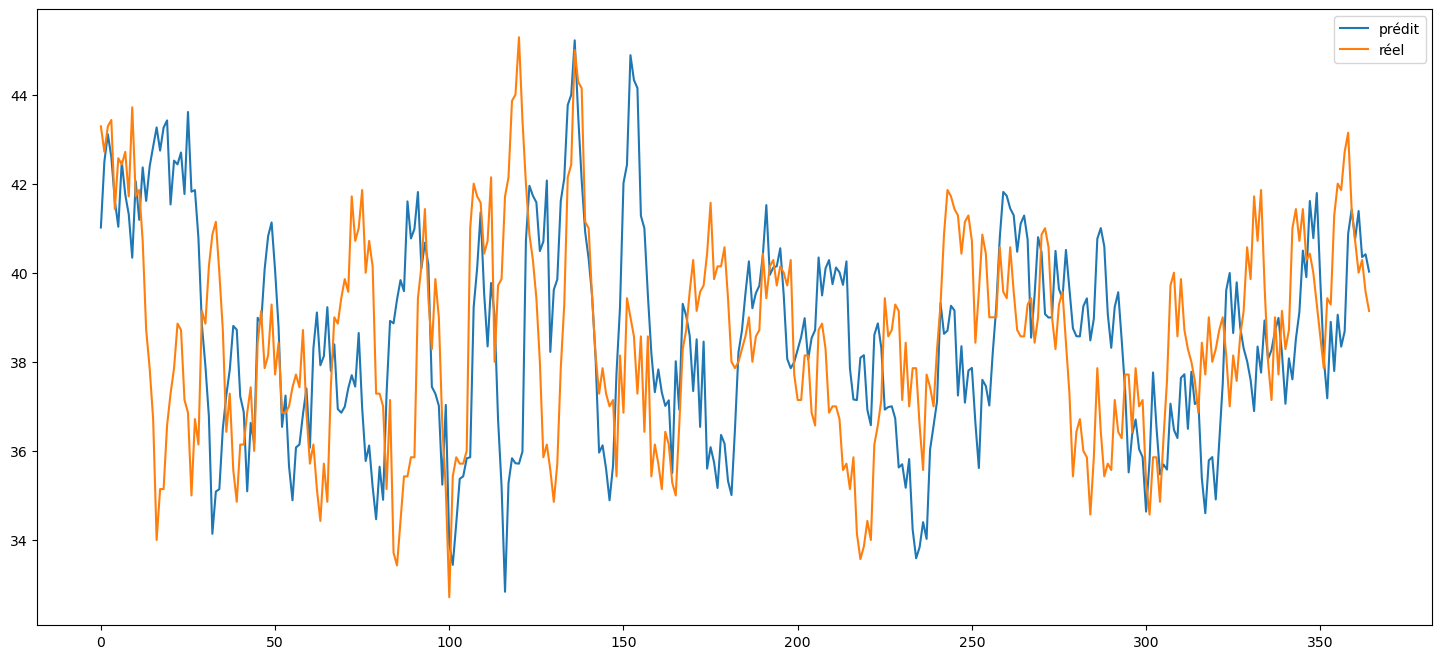

In [13]:
plt.plot(cible, label='prédit')
plt.plot(list(df['target'][-N:].values), label='réel')
plt.legend()

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

cible = []


N = 365
for k in range(N):
    serie = df['target'][:(-(N+15)+k)]


    # Définir le modèle ARMA (p, q à ajuster selon votre série temporelle)
    #p, d, q =4,1,3
    #modele = ARIMA(serie, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)

    modele = SARIMAX(serie, order=(4, 1, 3), seasonal_order=(1, 1, 0, 7))
    modele_fit = modele.fit(disp=False)


    # Ajuster le modèle
    #modele_fit = modele.fit(method_kwargs={"disp": 0})

    # Prédiction des 15 prochains jours
    pas_prevision = 15
    prevision = modele_fit.forecast(steps=pas_prevision)

    # Affichage des résultats
    print(k, prevision.iloc[-1])
    cible.append(prevision.iloc[-1])

0 39.478930515200844
1 40.67571844219537
2 40.75369663412236
3 40.63261653036472
4 40.58081854449346
5 40.54799250278703
6 40.44423837543746
7 40.900397815461076
8 40.52341441062665
9 40.16353294410225
10 40.54229498807584
11 40.742698280988684
12 41.54394983308256
13 41.0560257287533
14 41.61832251800364
15 41.63428554235294
16 42.181339103931975
17 41.9526564151093
18 42.416170005063336
19 42.43509355827881
20 42.43138115855487
21 42.30716705979478
22 42.44128846625151
23 42.56718407674159
24 42.540470850112584
25 42.788237862931595
26 41.95433895310199
27 42.721730091457914
28 42.185892034695215
29 41.70283339969153
30 40.7847664206257
31 40.98747045647502
32 39.20853503880052
33 39.111855404682125
34 39.14049073568141
35 38.508695808415204
36 38.74907315780402
37 38.71077906388933
38 38.83912920521125
39 39.12418630261789
40 38.83619849906685
41 38.17834850557605
42 37.38724757004241
43 37.44618304950624
44 37.34824669505572
45 37.13738392023604
46 37.63068497757346
47 37.863136172

KeyboardInterrupt: 

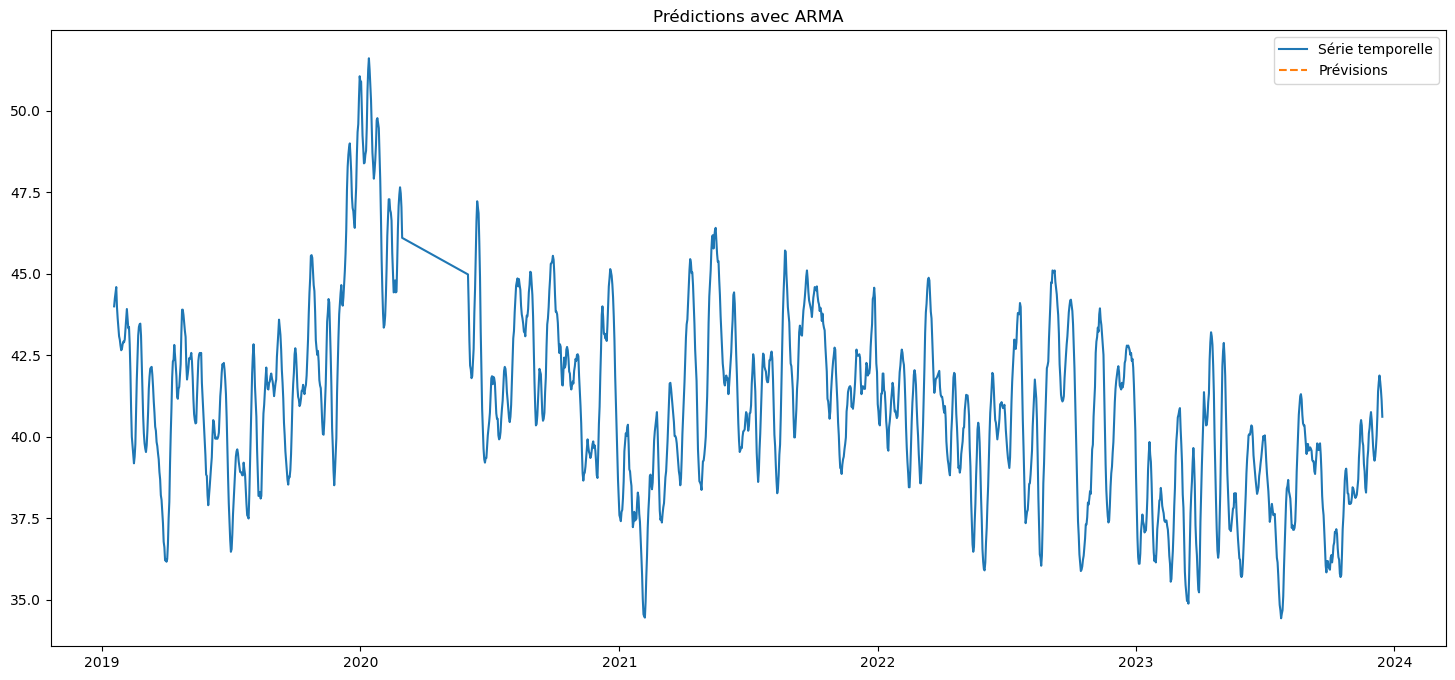

In [41]:
plt.plot(serie, label='Série temporelle')
plt.plot(previsions_series, label='Prévisions', linestyle='--')
plt.title('Prédictions avec ARMA')
plt.legend()
plt.show()


Amélioration avec max_depth=3: 100000.0000 -> 7.0704


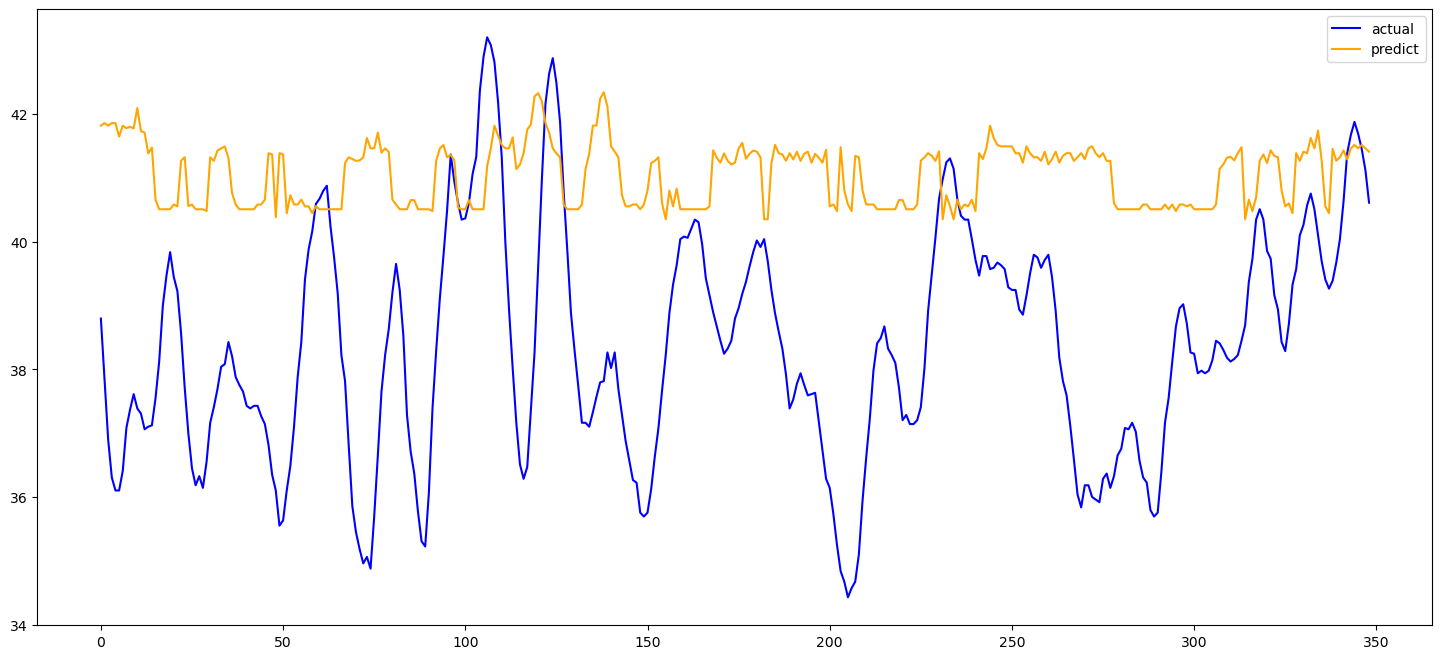

8.60%,1%
14.33%,2%
20.06%,3%
26.36%,4%
34.10%,5%
41.26%,6%
49.00%,7%
55.59%,8%
65.04%,9%
70.77%,10%
76.50%,11%
   - MAE : 2.13 (2.79 sur 2023)
   - MSE : 7.07 (10.50 sur 2023)
Amélioration avec max_depth=4: 7.0704 -> 7.0601


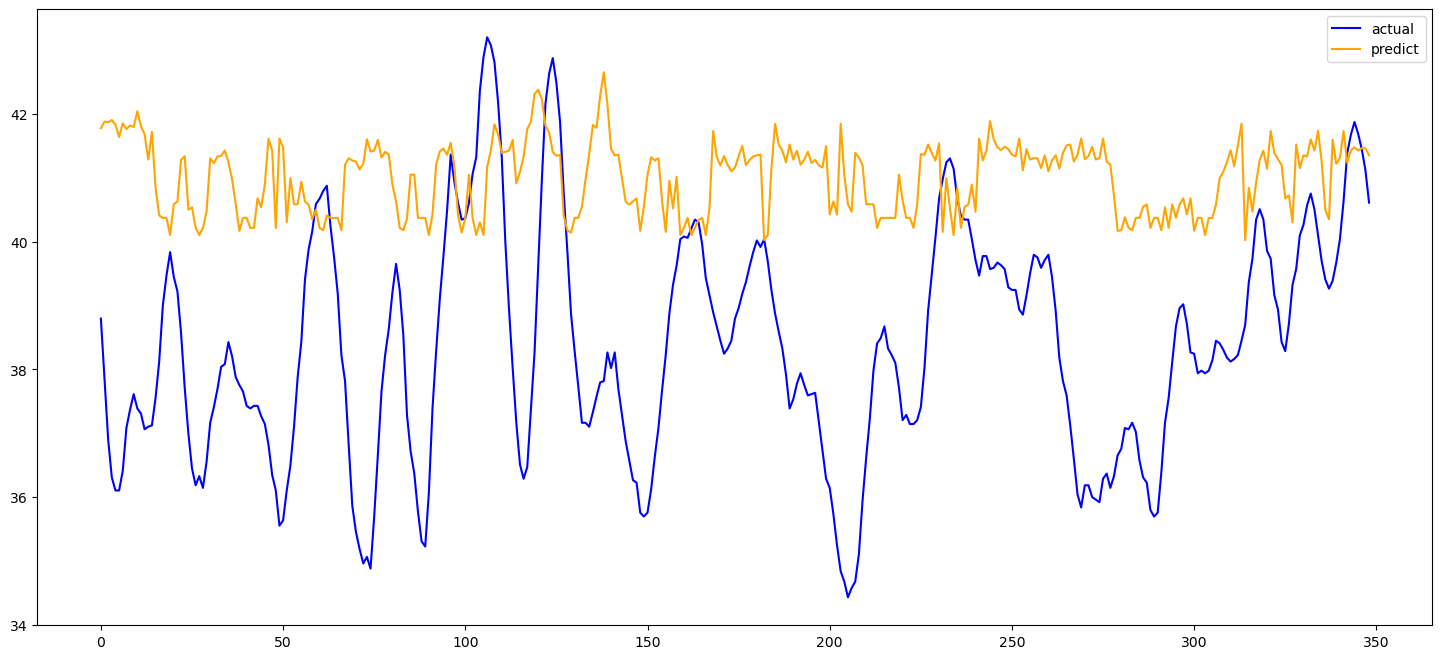

8.60%,1%
13.75%,2%
20.34%,3%
26.93%,4%
34.67%,5%
42.12%,6%
49.00%,7%
56.73%,8%
65.62%,9%
72.49%,10%
78.22%,11%
   - MAE : 2.12 (2.77 sur 2023)
   - MSE : 7.06 (10.43 sur 2023)


(7.060104838868674, <xgboost.core.Booster at 0x7f1494d538f0>)

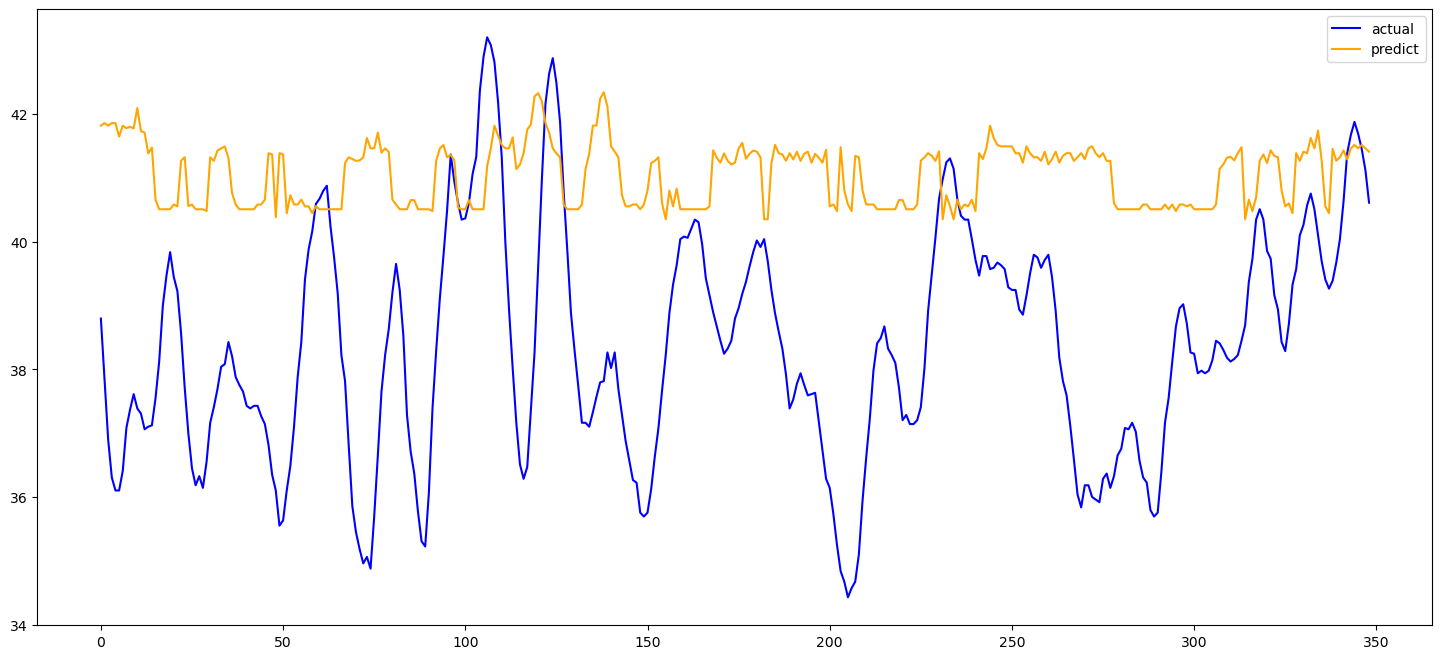

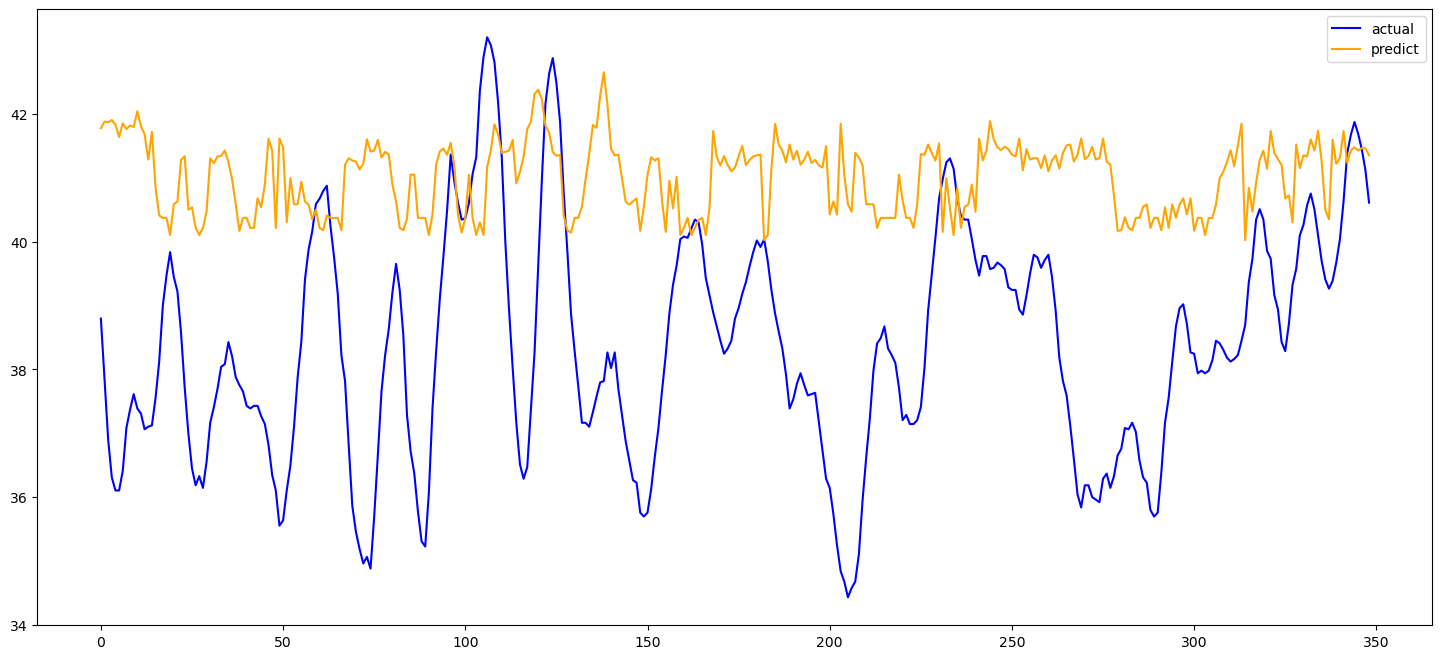

In [39]:
df = df0.copy()
df['target'] = result.trend.copy()
df.dropna(inplace=True)
#target_history-13
#target_history-14
teste(df[['target_ma_2', 'target_history-14', 'target']], params)

Amélioration avec max_depth=3: 100000.0000 -> 9.7824


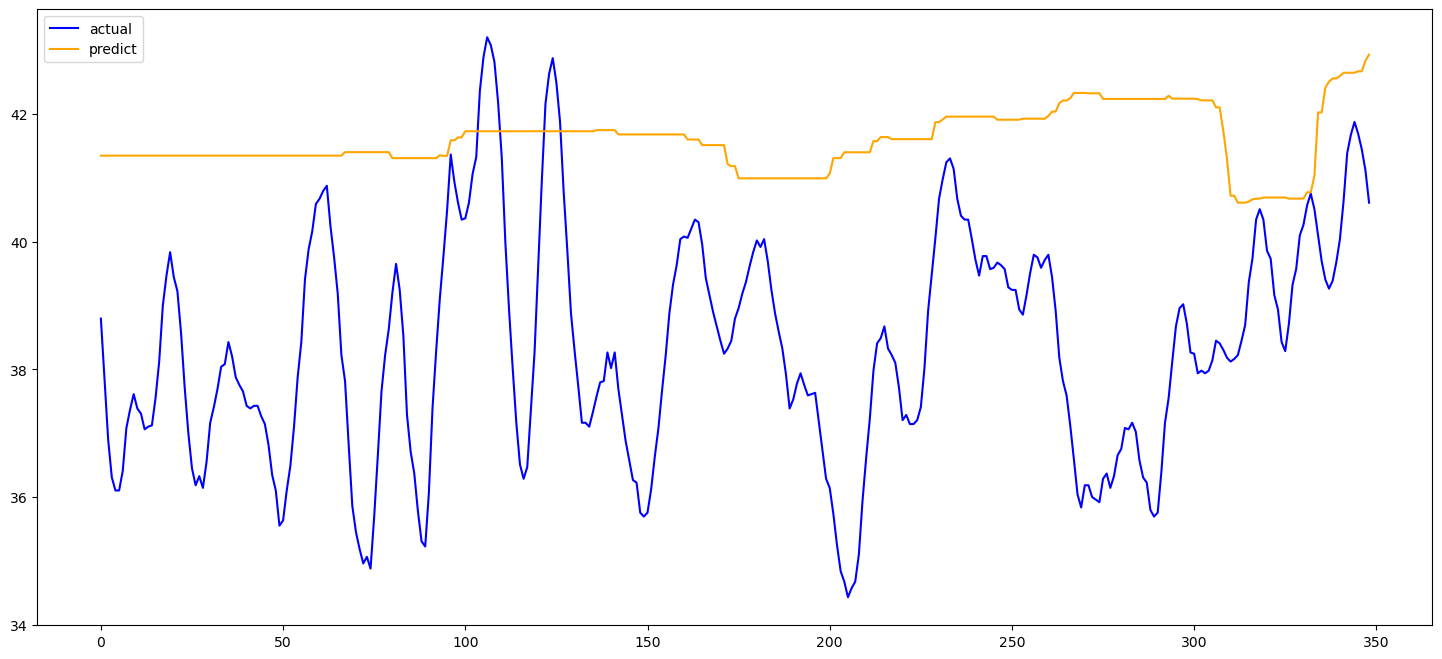

2.01%,1%
6.88%,2%
12.89%,3%
18.91%,4%
24.64%,5%
32.66%,6%
39.83%,7%
45.56%,8%
53.01%,9%
60.74%,10%
68.48%,11%
   - MAE : 2.42 (3.29 sur 2023)
   - MSE : 9.78 (13.75 sur 2023)
Amélioration avec max_depth=4: 9.7824 -> 9.7801


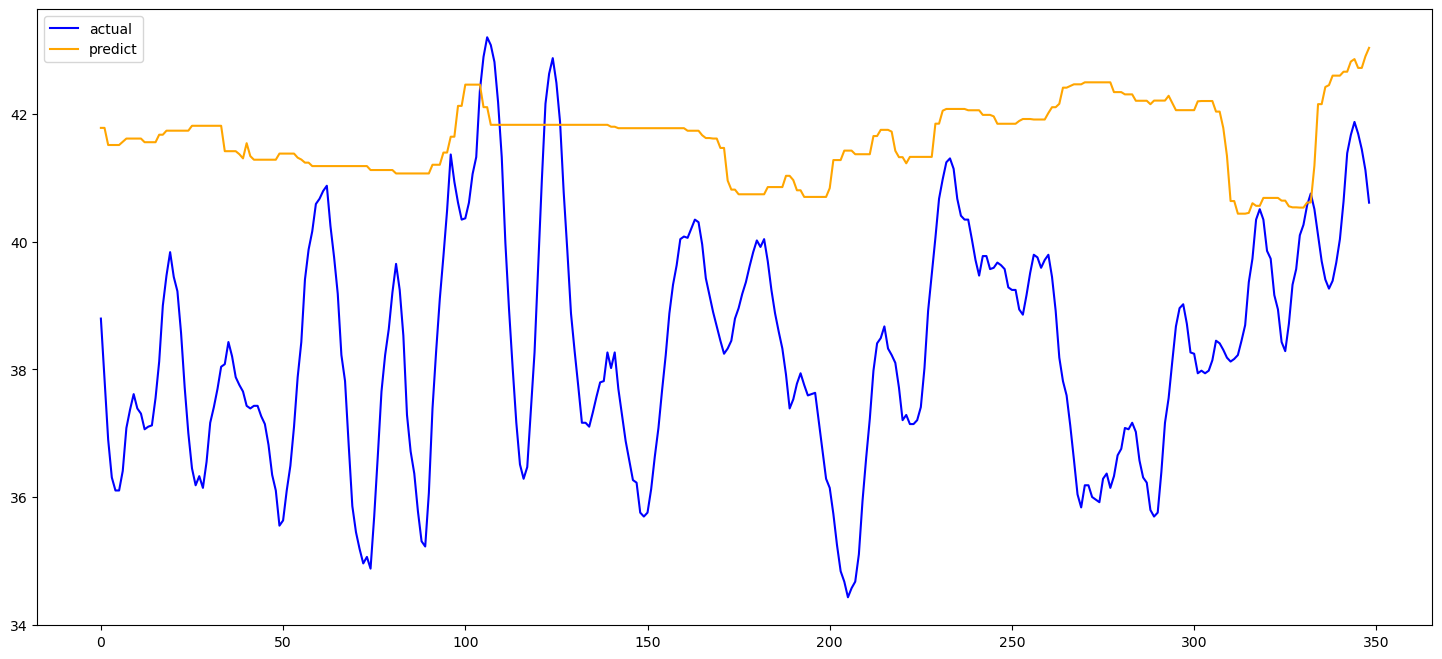

3.44%,1%
6.30%,2%
13.75%,3%
18.34%,4%
25.21%,5%
33.24%,6%
40.69%,7%
46.70%,8%
53.58%,9%
60.74%,10%
68.48%,11%
   - MAE : 2.41 (3.30 sur 2023)
   - MSE : 9.78 (13.90 sur 2023)
Amélioration avec max_depth=5: 9.7801 -> 9.7753


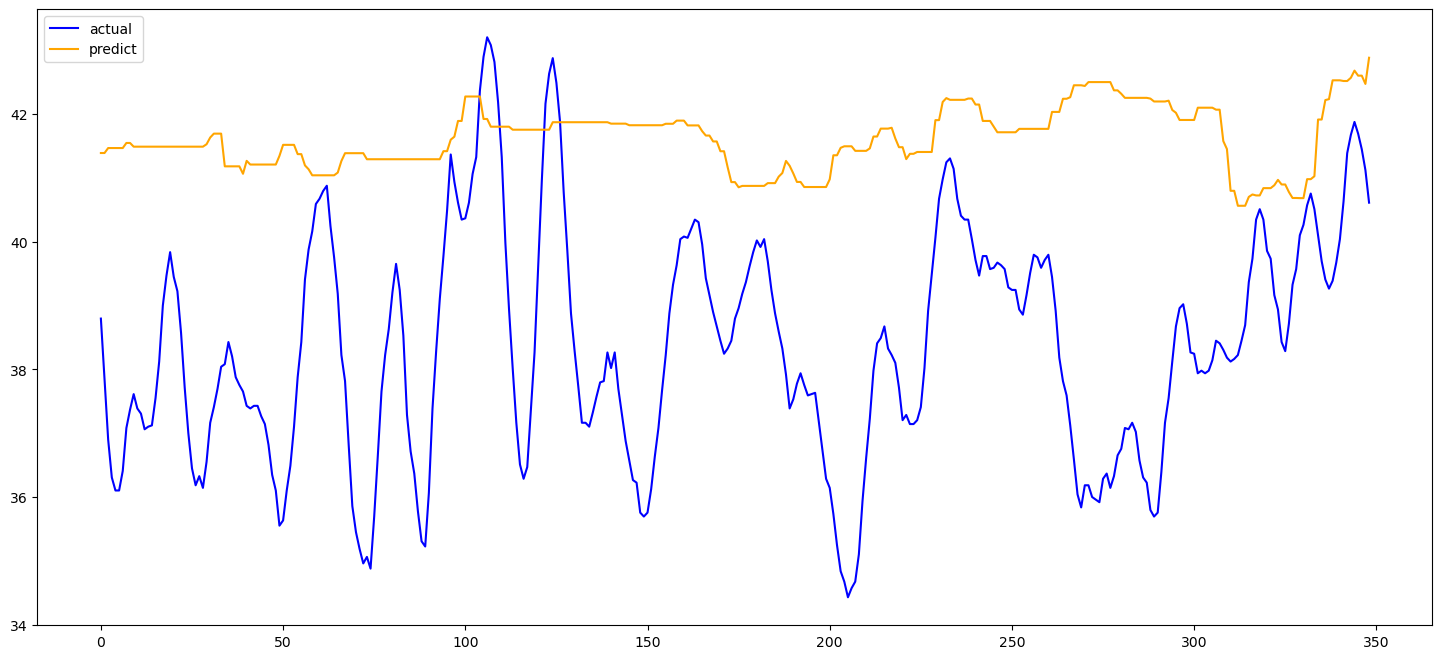

2.87%,1%
5.73%,2%
12.89%,3%
17.77%,4%
25.50%,5%
34.10%,6%
40.69%,7%
47.28%,8%
53.87%,9%
61.60%,10%
69.34%,11%
   - MAE : 2.41 (3.30 sur 2023)
   - MSE : 9.78 (13.91 sur 2023)


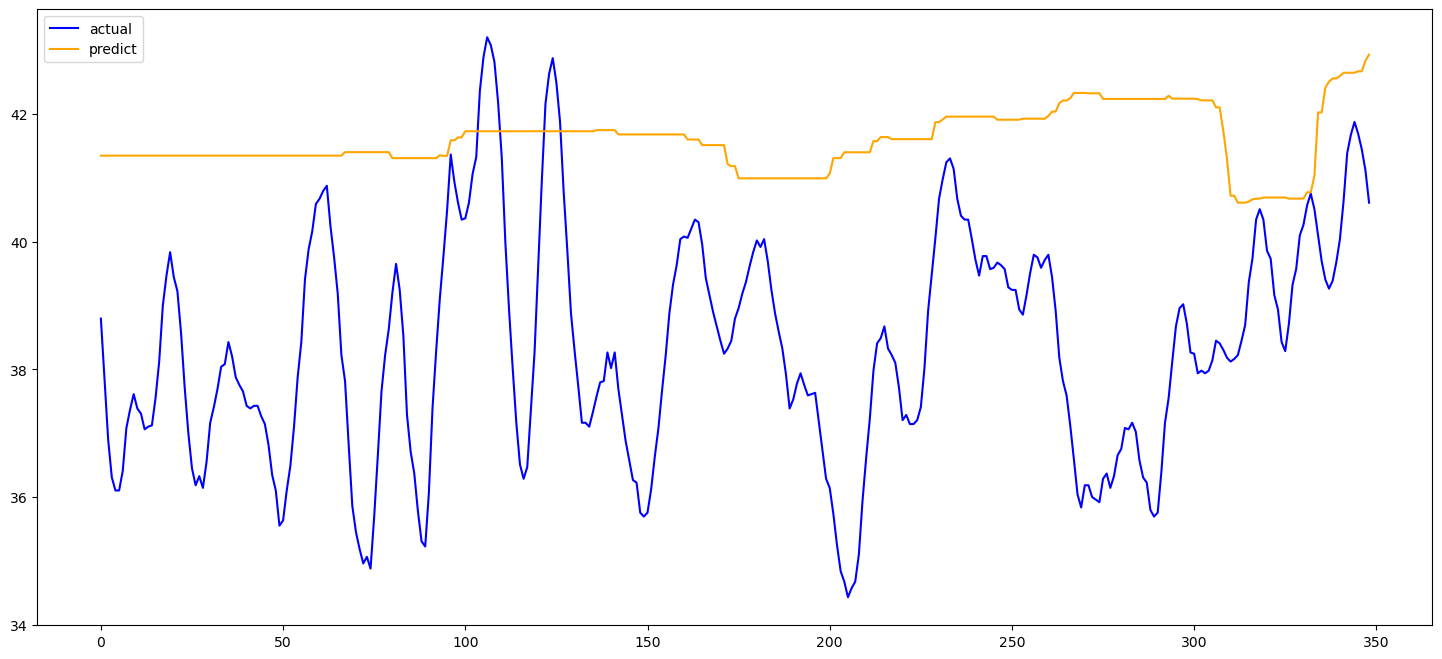

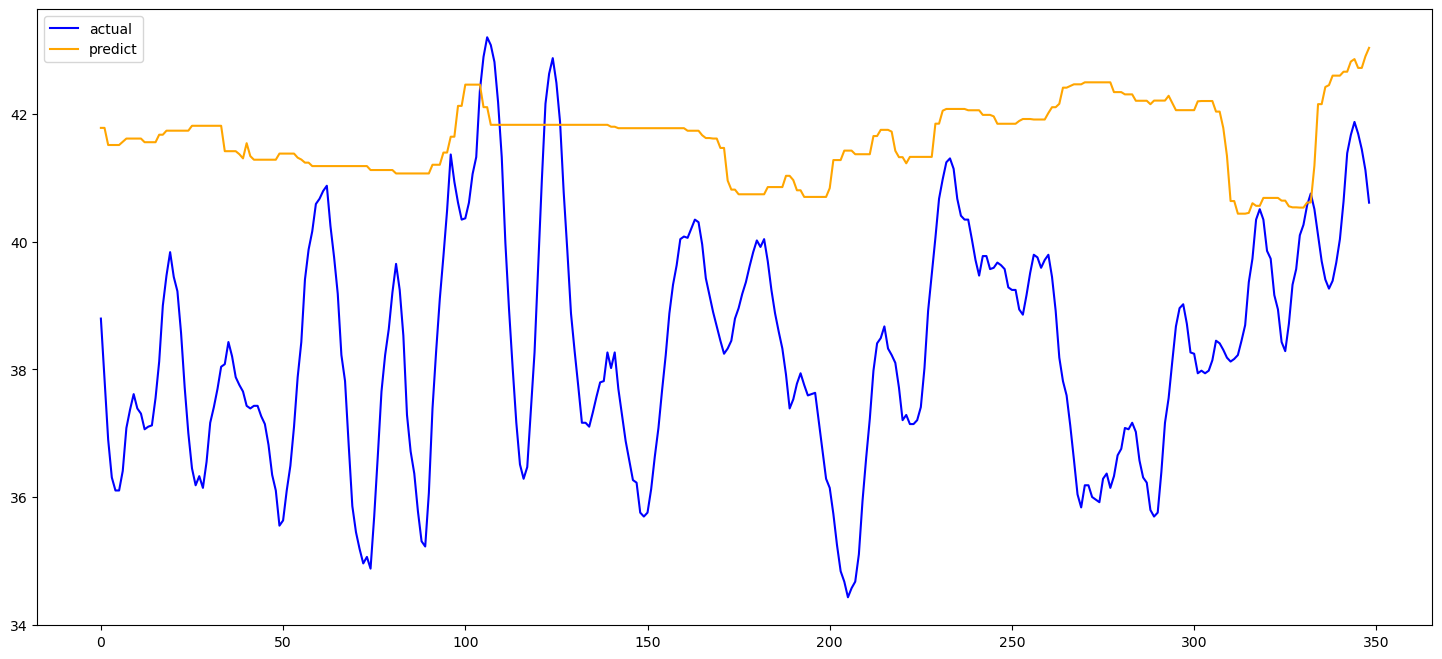

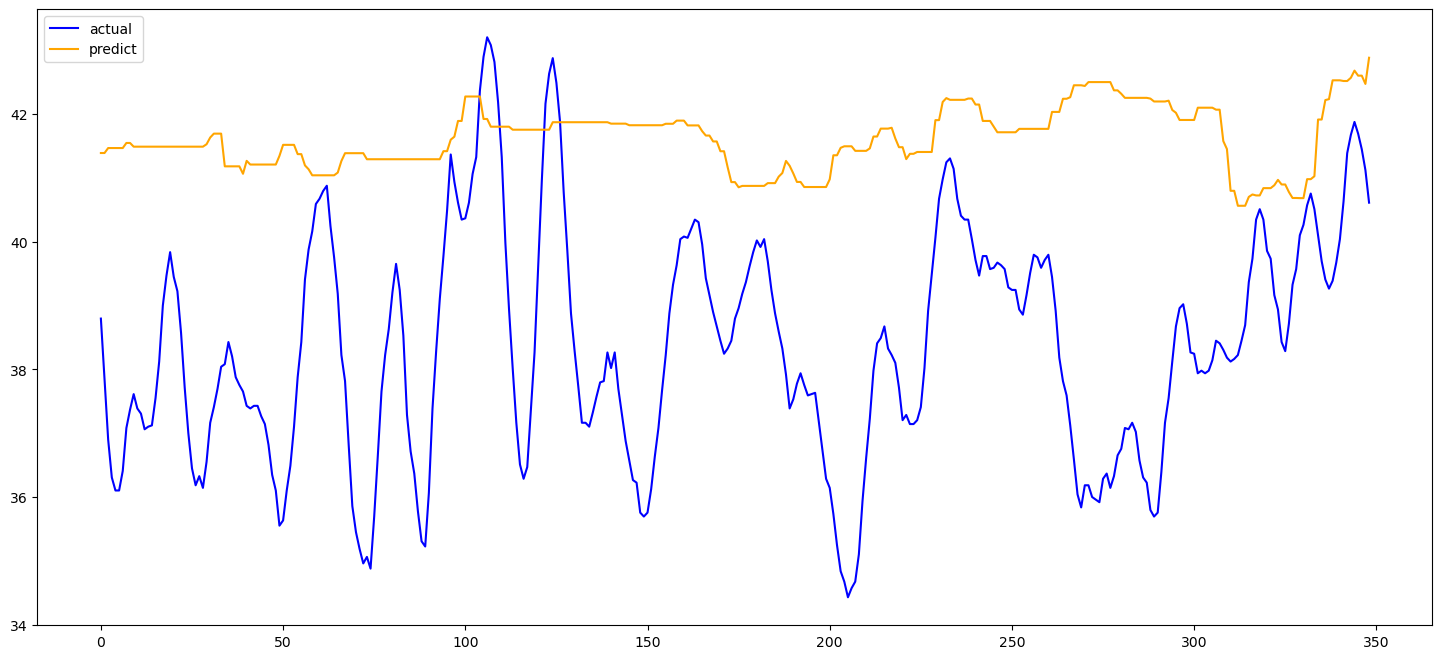

In [29]:
params = {'eta': 0.05, 
          'objective': 'reg:absoluteerror', 
          'eval_metric': ['rmse', 'mae'],
          'subsample': 0.7, 
          'colsample_bytree': 1,
          'nthread': -1}

score = 100000
cols = ['dayofYear', 'month']
col = "holidays"
new_score, _ = teste(df[cols+[col, 'target']], params, score=score)

### Historique

In [30]:
params = {'eta': 0.05, 
		  'objective': 'reg:squarederror',
          'eval_metric': ['rmse', 'mae'], 
          # seule la rmse sera utilisée pour valider
          'subsample': 0.7, 'colsample_bytree': 0.7,
          'nthread': -1}

Amélioration avec max_depth=3: 100000.0000 -> 9.6058


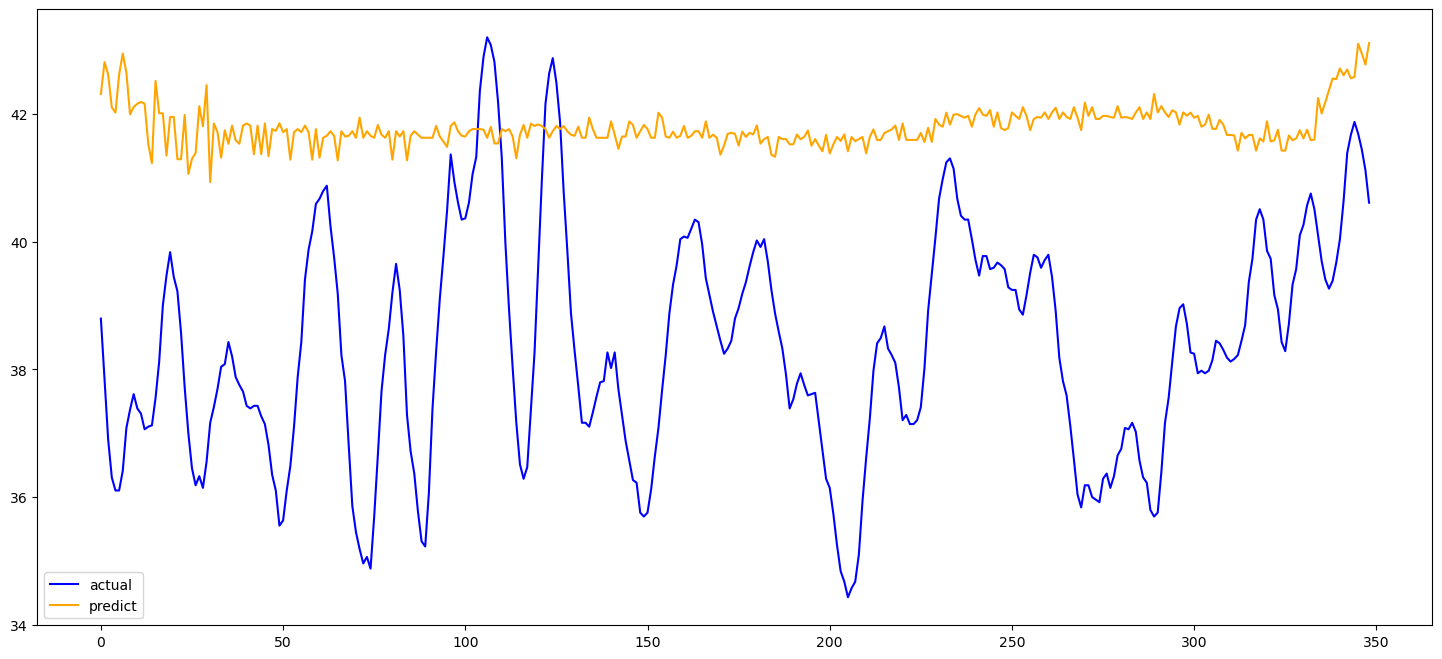

0.29%,1%
3.44%,2%
9.17%,3%
14.04%,4%
20.63%,5%
28.65%,6%
34.96%,7%
41.83%,8%
49.57%,9%
58.17%,10%
65.90%,11%
   - MAE : 2.40 (3.49 sur 2023)
   - MSE : 9.61 (15.00 sur 2023)
MAE: 3.57


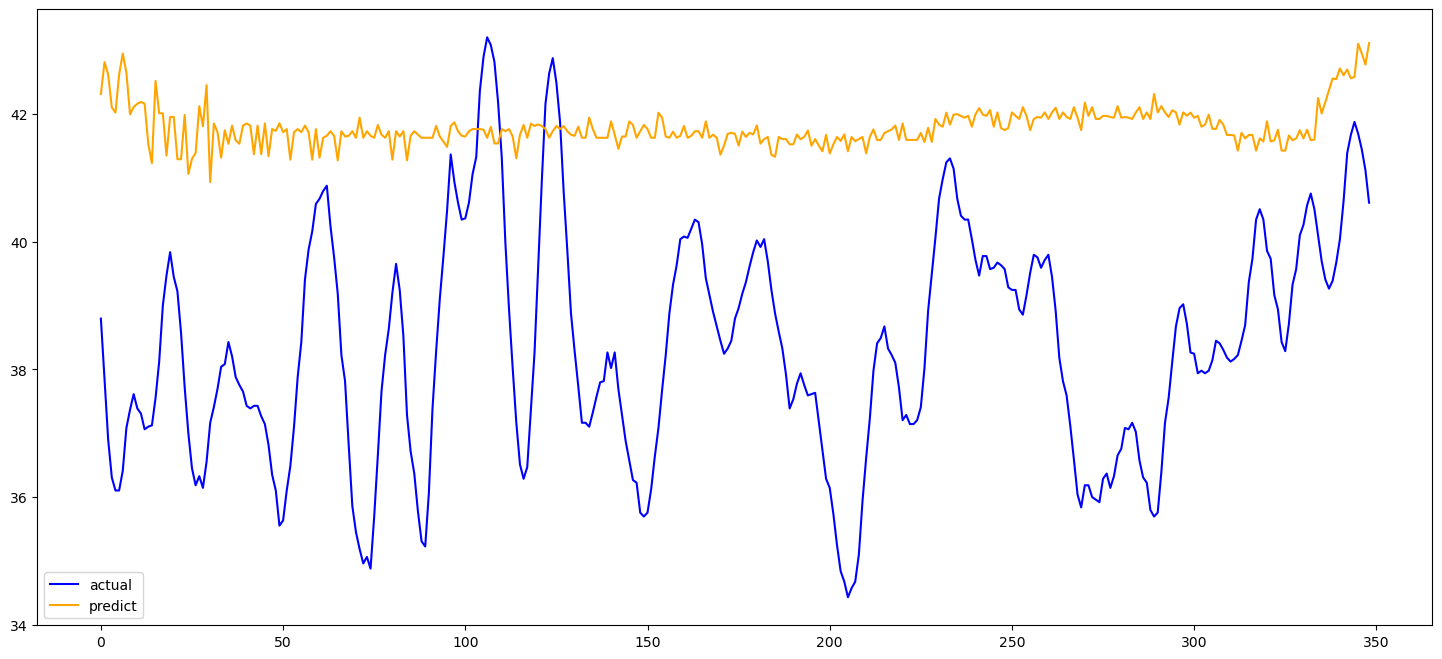

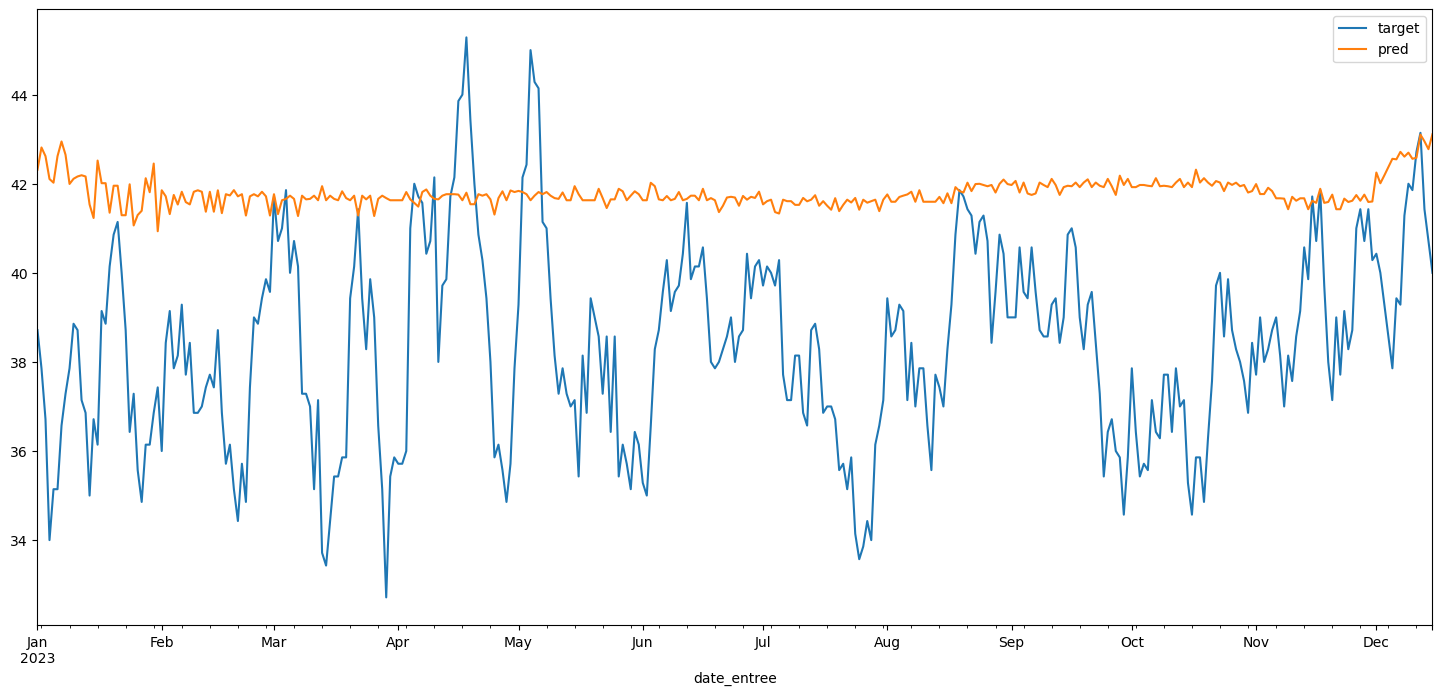

In [31]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


Amélioration avec max_depth=3: 100000.0000 -> 271.6147


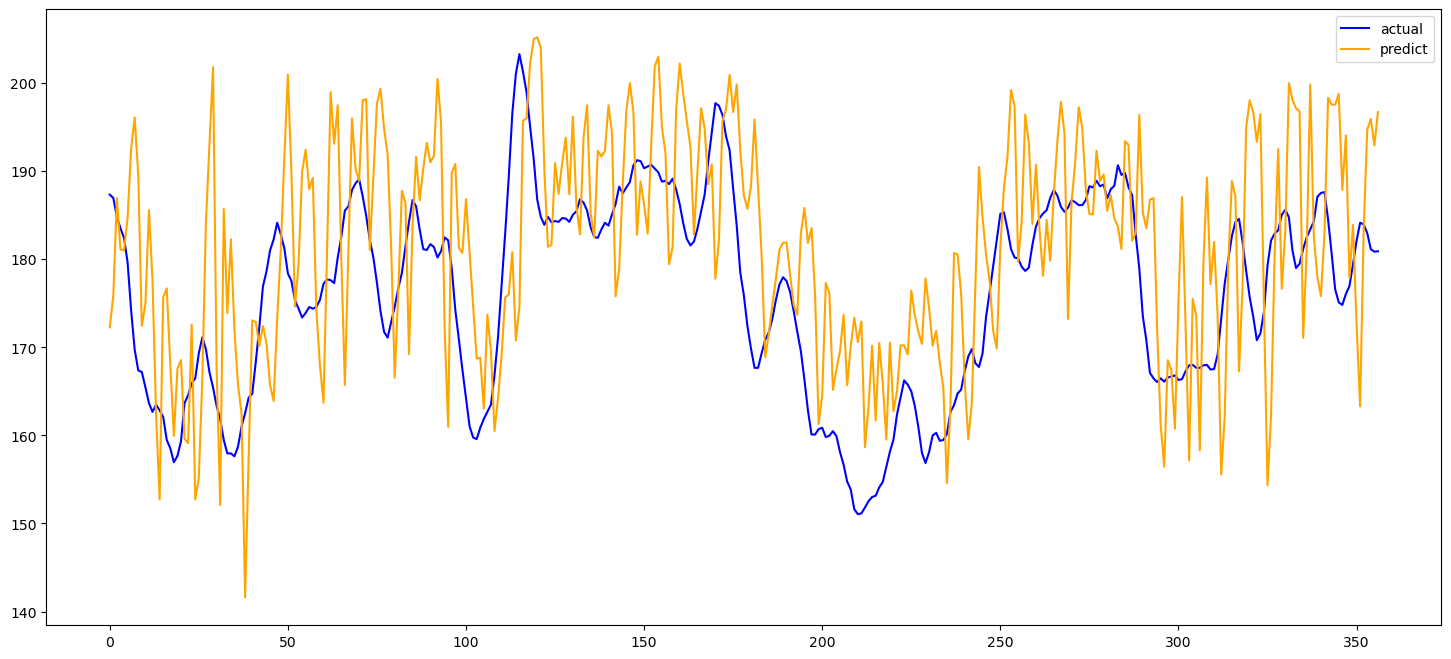

11.48%,1%
21.57%,2%
30.53%,3%
38.10%,4%
47.06%,5%
56.86%,6%
65.55%,7%
71.43%,8%
77.87%,9%
84.31%,10%
87.68%,11%
   - MAE : 12.46 (10.14 sur 2023)
   - MSE : 271.61 (151.42 sur 2023)
MAE: 12.51


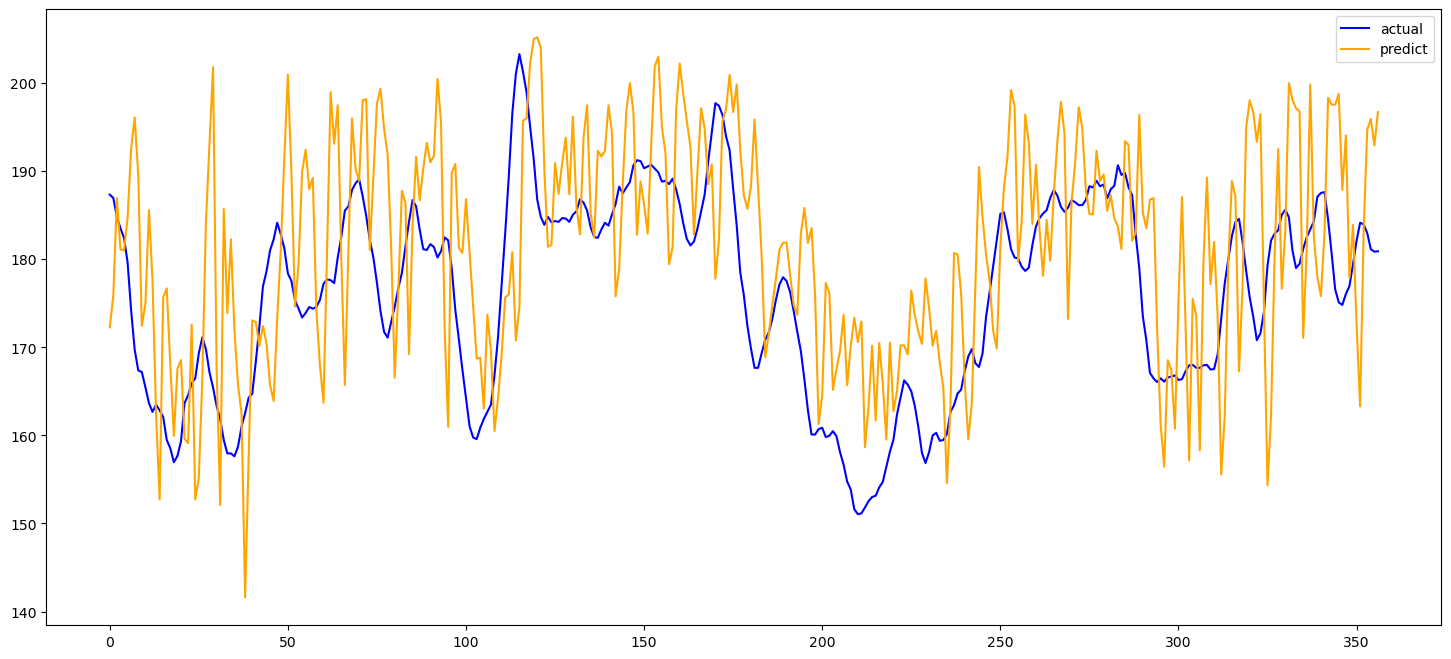

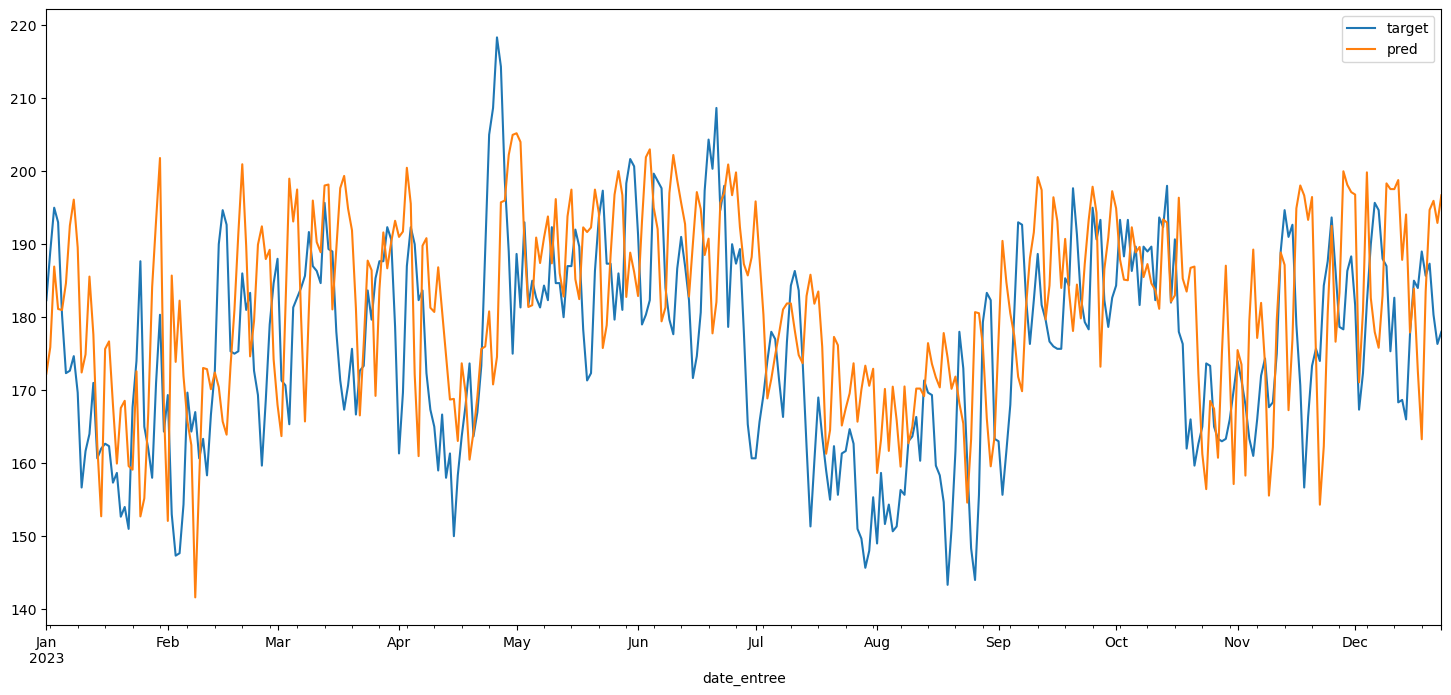

In [18]:
cols = ['dayofYear', 'month', 'holidays', 'arrivees_urgences', 'arrivees_urgences_history-1']
score, reg = teste(df[cols+['target']], params)

dg = df0.loc[df0.index.year == 2023][:-3]
dg['pred'] = reg.predict(xgb.DMatrix(df.loc[df.index.year == 2023][cols]))
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


MAE: 11.20


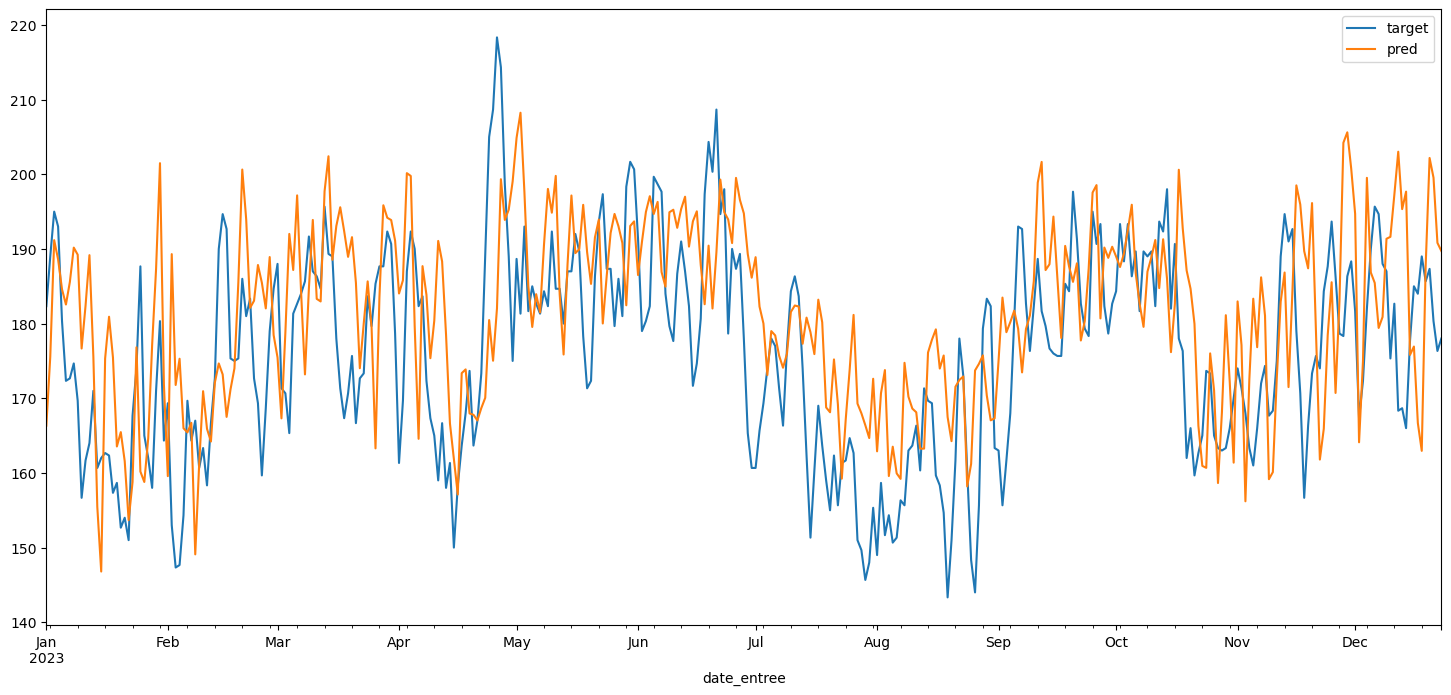

In [19]:
dg['seasonal'] = result.seasonal
dg['pred'] = dg.apply(lambda x: x['pred'] + x['seasonal'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [20]:
dg0 = df0.copy()
dg0['resid'] = result.resid
dg0.drop('target', axis=1, inplace=True)
dg0.rename({'resid': 'target'}, axis=1, inplace=True)
dg0.dropna(inplace=True)
dg0['target'] = dg0['target'].apply(lambda x: 1 if x > 0 else 0)

In [21]:
# Paramètres adaptés pour la classification binaire
params = {
    'eta': 0.05, 
    'objective': 'binary:logistic',  # Classification binaire
    'eval_metric': ['logloss', 'error'],  # Log loss et taux d'erreur
    'subsample': 0.7, 
    'colsample_bytree': 0.7,
    'nthread': -1
}

X_final = dg0.loc[dg0.index.year == 2023].drop('target', axis=1)
y_final = dg0.loc[dg0.index.year == 2023]['target']

train_val_test = dg0.loc[dg0.index.year < 2023]
X_train, X_valid, y_train, y_valid = train_test_split(train_val_test.drop('target', axis=1), 
                                                    train_val_test['target'], 
                                                    test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)
dtest = xgb.DMatrix(X_final, label=y_final)
evals = [(dtrain, 'train'), (dvalid, 'eval')]


# Entraînement avec early stopping
bst = xgb.train(
    params,
    dtrain,  # DMatrix contenant les données d'entraînement
    num_boost_round=100000,
    evals=evals,  # Liste des ensembles d'évaluation
    early_stopping_rounds=15,
    verbose_eval=True
)

# Prédiction des probabilités sur un ensemble de test
proba_preds = bst.predict(dtest)

# Conversion des probabilités en classes binaires (0 ou 1)
class_preds = (proba_preds >= 0.5).astype(int)

scale = result.resid.dropna().abs().mean()

class_preds = [(2*p-1)*scale for p in class_preds]

# Affichage des prédictions de classes
print(class_preds)

[0]	train-logloss:0.68150	train-error:0.37280	eval-logloss:0.69117	eval-error:0.44649
[1]	train-logloss:0.67170	train-error:0.27660	eval-logloss:0.69220	eval-error:0.47232
[2]	train-logloss:0.65992	train-error:0.24699	eval-logloss:0.69537	eval-error:0.51661
[3]	train-logloss:0.64914	train-error:0.18409	eval-logloss:0.69507	eval-error:0.50554
[4]	train-logloss:0.64074	train-error:0.18316	eval-logloss:0.69657	eval-error:0.48339
[5]	train-logloss:0.63393	train-error:0.17299	eval-logloss:0.69624	eval-error:0.51661
[6]	train-logloss:0.62553	train-error:0.14986	eval-logloss:0.69688	eval-error:0.48339
[7]	train-logloss:0.61846	train-error:0.13691	eval-logloss:0.69407	eval-error:0.49077
[8]	train-logloss:0.60764	train-error:0.11933	eval-logloss:0.69621	eval-error:0.49077
[9]	train-logloss:0.59991	train-error:0.11008	eval-logloss:0.69699	eval-error:0.48708
[10]	train-logloss:0.59294	train-error:0.10916	eval-logloss:0.69666	eval-error:0.50185
[11]	train-logloss:0.58323	train-error:0.08788	eval-l

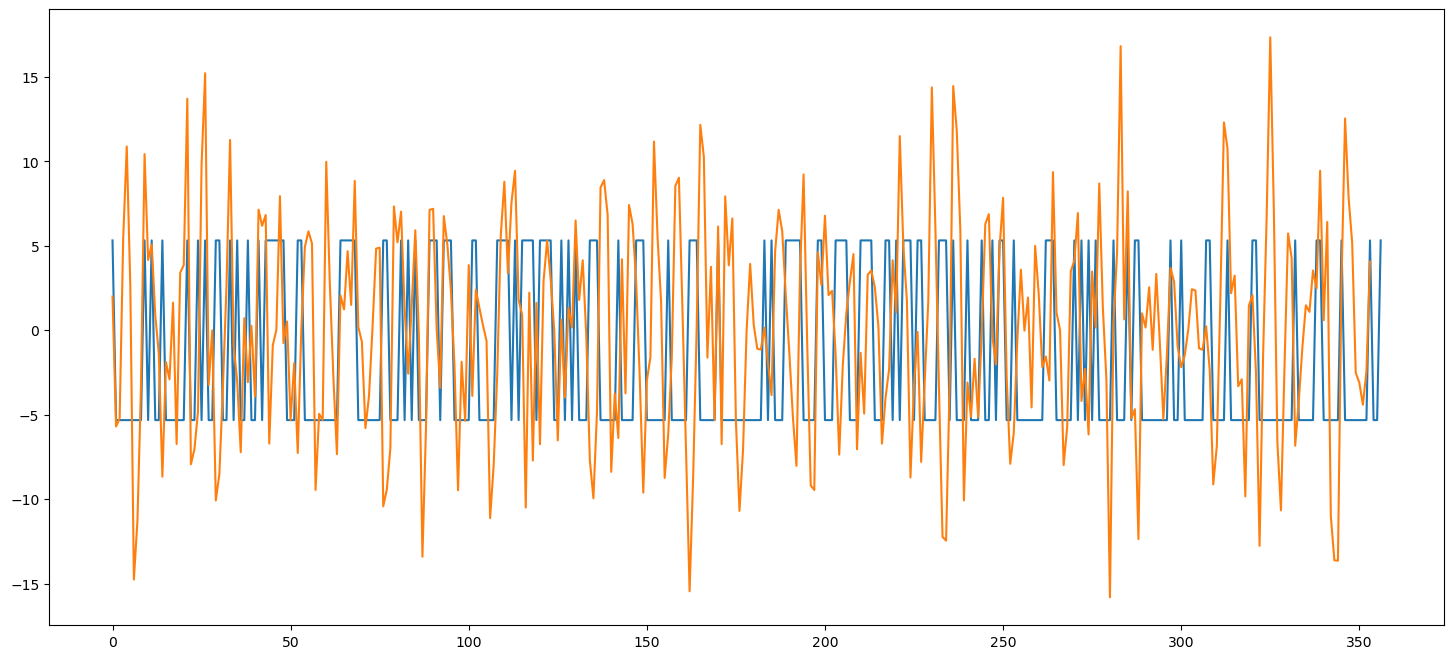

In [22]:
plt.plot(range(len(class_preds)), class_preds)
plt.plot(range(len(class_preds)), result.resid[-len(class_preds):])
plt.show()

MAE: 10.95


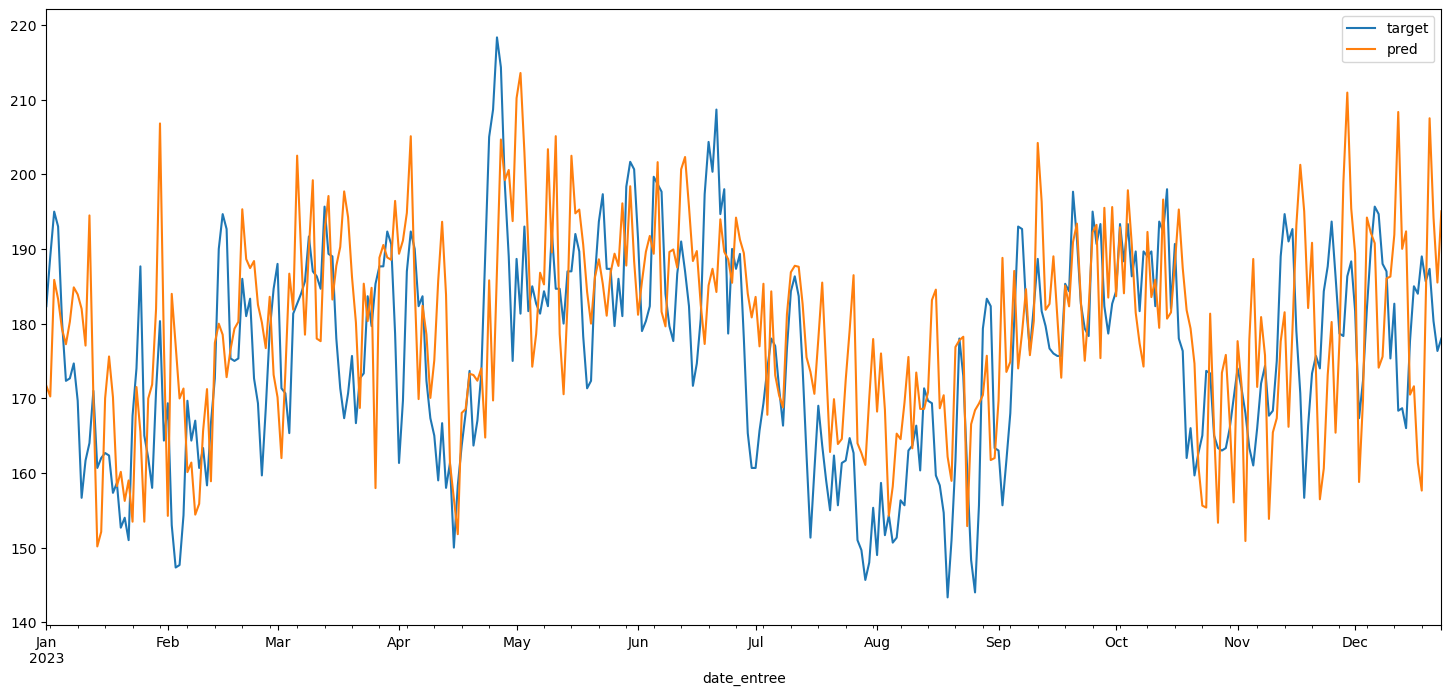

In [23]:
dg['residue'] = class_preds
dg['pred'] = dg.apply(lambda x: x['pred'] + x['residue'], axis=1)
dg.plot(y=['target', 'pred'])
print(f"MAE: {mean_absolute_error(dg['target'], dg['pred']):.2f}")


In [26]:
# Un exemple pour déterminer l'importance des variables après un pré-apprentissage XGBoost
importance_gain = bst.get_score(importance_type='gain')
importance_cover = bst.get_score(importance_type='cover')
importance_weight = bst.get_score(importance_type='weight')

df_gain = pd.DataFrame.from_dict(importance_gain, orient='index', columns=['gain'])
df_cover = pd.DataFrame.from_dict(importance_cover, orient='index', columns=['cover'])
df_weight = pd.DataFrame.from_dict(importance_weight, orient='index', columns=['weight'])

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df = df_gain.join(df_cover, how='outer').join(df_weight, how='outer')
df.fillna(0, inplace=True)  # Remplacer les valeurs manquantes par 0 si nécessaire

df['gain_norm'] = df['gain'] / df['gain'].sum()
df['cover_norm'] = df['cover'] / df['cover'].sum()
df['weight_norm'] = df['weight'] / df['weight'].sum()

w_gain = 0.5
w_cover = 0.3
w_weight = 0.2

df['importance'] = (df['gain_norm'] * w_gain) + (df['cover_norm'] * w_cover) + (df['weight_norm'] * w_weight)

df.sort_values(by='importance', ascending=False, inplace=True)
df['rank'] = df['importance'].rank(ascending=False)

df.reset_index(inplace=True)
df.rename(columns={'index': 'feature'}, inplace=True)
print(df[['feature', 'gain', 'cover', 'weight', 'importance', 'rank']])


                  feature       gain       cover  weight  importance   rank
0               dayofweek  14.086691  183.958206     5.0    0.012861    1.0
1       trend_hopital_J-5  13.299729   87.881310     7.0    0.010080    2.0
2       trend_hopital_J-6  14.853248  150.015381     1.0    0.010054    3.0
3       arrivees_urgences  10.756468  141.324341     4.0    0.009933    4.0
4       trend_hopital_J-7  10.254529  117.447426     6.0    0.009832    5.0
..                    ...        ...         ...     ...         ...    ...
249      air_PM25_FR26005   1.879937    7.221164     1.0    0.001242  250.0
250     inc_diarrhee_J-13   1.973167    5.072246     1.0    0.001191  251.0
251  air_PM10_FR26014_std   1.526453    5.747398     1.0    0.001089  252.0
252       inc_grippe_J-10   1.248711    5.203798     1.0    0.000991  253.0
253    trend_maladie_mean   0.180713    2.465013     1.0    0.000590  254.0

[254 rows x 6 columns]
